# **Table of Contents** <br>

### [0. Supporting Functions](#supporting_functions)
### [1. Analyzing initial dataset](#analyzing_initial_dataset)
### [2. Individual feature analyzis](#individual_feature_analyzis)
##### &nbsp;&nbsp;[2.1. customer_id](#21-customer_id)
##### &nbsp;&nbsp;[2.2. customer_region](#22-customer_region)
##### &nbsp;&nbsp;[2.3. customer_age](#23-customer_age)
##### &nbsp;&nbsp;[2.4. vendor_count](#24-vendor_count)
##### &nbsp;&nbsp;[2.5. product_count](#25-product_count)
##### &nbsp;&nbsp;[2.6. is_chain](#26-is_chain)
##### &nbsp;&nbsp;[2.7. first_order](#27-first_order)
##### &nbsp;&nbsp;[2.8. last_order](#28-last_order)
##### &nbsp;&nbsp;[2.9. last_promo](#29-last_promo)
##### &nbsp;&nbsp;[2.10. payment_method](#210-payment_method)
##### &nbsp;&nbsp;[2.11. CUI_variables](#211-cui_variables)
##### &nbsp;&nbsp;[2.12. DOW_variables](#212-dow_-variables)
##### &nbsp;&nbsp;[2.13. HR_variables](#213-hr_-variables)
##### &nbsp;&nbsp;[2.14. Overview of all variables](#overview-of-individual-analyzis)
### [3. Analyzing missing values](#3-analyzing-nan-values)
### [4. Analyzing outliers](#analyzing_outliers)
##### &nbsp;&nbsp;[4.1. Univariate outliers for numerical features](#41-univariate-outliers-for-numerical-features)
##### &nbsp;&nbsp;[4.2. Bivariate outliers for numerical features](#42-bivariate-outliers-for-numeric-features)
##### &nbsp;&nbsp;[4.3. Outliers for categorical features](#43-outliers-for-categorical-features)

### [5. Feature engineering](#feature_engineering)
### [6. Multivariate analyzis](#multivariate_analyzis)
    

In [214]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2
import math
import os
import scipy.stats as ss
import warnings

import copy 
import numpy as np
import pandas as pd
import seaborn as sns
import scipy as sp
from scipy.stats import chi2
from sklearn.covariance import MinCovDet
import scipy
import itertools
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import mpl_axes_aligner

sns.set_style("white")

# Remove warnings
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)

<div class="alert alert-block alert-info" style="font-size:16px" id = "supporting_functions">

# 0. Supporting functions 


In [215]:
def outlier_detection(df, features):
    if isinstance(features, str):
        features = [features]

    for feature in features:
        q3 = df[feature].quantile(0.75)
        q1 = df[feature].quantile(0.25)
        percentil_95 = round(df[feature].quantile(0.95),2)
        percentil_99 = round(df[feature].quantile(0.99),2)
        max = df[feature].max()
        min = df[feature].min()
        iqr = q3 - q1 

        #No lower bound moderate or extreme outliers in any feature
        #num_mod_outl = df.loc[(df[feature] > q3 + (1.5*iqr)) & (df[feature] < q3 + (3*iqr))].shape[0]
        #num_ext_outl = df.loc[df[feature] > q3 + 3*iqr].shape[0]
        num_mod_outl = df[feature].loc[(df[feature] > q3 + (1.5*iqr)) & (df[feature] < q3 + (3*iqr))].count()
        num_ext_outl = df[feature].loc[df[feature] > q3 + 3*iqr].count()

        total_outl = num_mod_outl + num_ext_outl
        if num_mod_outl != 0 and num_ext_outl!= 0:
            mod_outl_perc = int((num_mod_outl/total_outl)*100)
            ext_outl_perc = int((num_ext_outl/total_outl)*100)
        else:
            mod_outl_perc = ''
            ext_outl_perc = ''


        print(f"{feature}: \nNumber of extreme outliers: {num_ext_outl} ({ext_outl_perc}%) \nNumber of moderate outliers: {num_mod_outl} ({mod_outl_perc}%) \nTotal number of outliers: {total_outl}")
        print(f"Q3 + 1.5*IQR = {round(q3 + 1.5* iqr,2)} \nQ3 + 3*IQR = {round(q3 + 3* iqr,2)}\nMax: {max} \nMin: {min} \n95th percentil: {percentil_95}\n99th percentil: {percentil_99} \n")



"""Notes 
1. Function identifies and combines the moderate and extreme outliers across a specified group of features 
2. The result is a DataFrame of unique outliers from those features, representing the total number of unique outliers within that group of features in df
"""
def get_outliers_df(df, features):
    if isinstance(features, str):
        features = [features]

    total_outl = pd.DataFrame()
    for feature in features:
        q3 = df[feature].quantile(0.75)
        q1 = df[feature].quantile(0.25)
        iqr = q3 - q1

        mod_outl = df.loc[(df[feature] > (q3 + 1.5 * iqr)) | (df[feature] < (q1 - 1.5 * iqr))]
        ext_outl = df.loc[(df[feature] > (q3 + 3 * iqr)) | (df[feature] < (q1 - 3 * iqr))]
        
        # Combine moderate and extreme outliers for the current feature
        curr_total_outl = pd.concat([mod_outl, ext_outl]).drop_duplicates()
        total_outl = pd.concat([total_outl, curr_total_outl]).drop_duplicates()

    return total_outl



def cor_heatmap(cor):
    mask = np.triu(np.ones_like(cor, dtype=bool))  # Mask for the upper triangle
    plt.figure(figsize=(40, 30))
    sns.heatmap(data=cor, annot=True, cmap=plt.cm.Reds, fmt='.2f', mask=mask, linewidths=0.5)
    plt.show()



<hr>
<div class="alert alert-block alert-info" style="font-size:16px" id="analyzing_initial_dataset">
    
# 1. Analyzing initial dataset
    
</a>

In [216]:
df = pd.read_csv("DM2425_ABCDEats_DATASET.csv")

In [217]:
df.head()

customer_id customer_region  customer_age  vendor_count  product_count  \
0  1b8f824d5e            2360          18.0             2              5   
1  5d272b9dcb            8670          17.0             2              2   
2  f6d1b2ba63            4660          38.0             1              2   
3  180c632ed8            4660           NaN             2              3   
4  4eb37a6705            4660          20.0             2              5   

   is_chain  first_order  last_order last_promo payment_method  ...  HR_14  \
0         1          0.0           1   DELIVERY           DIGI  ...      0   
1         2          0.0           1   DISCOUNT           DIGI  ...      0   
2         2          0.0           1   DISCOUNT           CASH  ...      0   
3         1          0.0           2   DELIVERY           DIGI  ...      1   
4         0          0.0           2          -           DIGI  ...      0   

   HR_15  HR_16  HR_17  HR_18  HR_19  HR_20  HR_21  HR_22  HR_23  
0      0      0      0      2      0      0      0      0      0  
1      0      0      0      0      0      0      0      0      0  
2      0      0      0      0      0      0      0      0      0  
3      0      0      0      0      0      0      0      0      0  
4      0      0      0      0      0      0      0      0      0  

[5 rows x 56 columns]

In [218]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31888 entries, 0 to 31887
Data columns (total 56 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   customer_id               31888 non-null  object 
 1   customer_region           31888 non-null  object 
 2   customer_age              31161 non-null  float64
 3   vendor_count              31888 non-null  int64  
 4   product_count             31888 non-null  int64  
 5   is_chain                  31888 non-null  int64  
 6   first_order               31782 non-null  float64
 7   last_order                31888 non-null  int64  
 8   last_promo                31888 non-null  object 
 9   payment_method            31888 non-null  object 
 10  CUI_American              31888 non-null  float64
 11  CUI_Asian                 31888 non-null  float64
 12  CUI_Beverages             31888 non-null  float64
 13  CUI_Cafe                  31888 non-null  float64
 14  CUI_Ch

In [219]:
df.shape

(31888, 56)

In [220]:
df.describe(include=[np.number], percentiles=np.arange(0.1,1,0.1))

customer_age  vendor_count  product_count      is_chain   first_order  \
count  31161.000000  31888.000000   31888.000000  31888.000000  31782.000000   
mean      27.506499      3.102609       5.668245      2.818866     28.478604   
std        7.160898      2.771587       6.957287      3.977529     24.109086   
min       15.000000      0.000000       0.000000      0.000000      0.000000   
10%       20.000000      1.000000       1.000000      0.000000      2.000000   
20%       22.000000      1.000000       2.000000      1.000000      6.000000   
30%       23.000000      2.000000       2.000000      1.000000     10.000000   
40%       25.000000      2.000000       3.000000      1.000000     16.000000   
50%       26.000000      2.000000       3.000000      2.000000     22.000000   
60%       28.000000      3.000000       4.000000      2.000000     30.000000   
70%       30.000000      3.000000       6.000000      3.000000     39.000000   
80%       32.000000      4.000000       8.000000      4.000000     51.000000   
90%       37.000000      6.000000      12.000000      6.000000     67.000000   
max       80.000000     41.000000     269.000000     83.000000     90.000000   

         last_order  CUI_American     CUI_Asian  CUI_Beverages      CUI_Cafe  \
count  31888.000000  31888.000000  31888.000000   31888.000000  31888.000000   
mean      63.675521      4.880438      9.960451       2.300633      0.801163   
std       23.226123     11.654018     23.564351       8.479734      6.427132   
min        0.000000      0.000000      0.000000       0.000000      0.000000   
10%       27.000000      0.000000      0.000000       0.000000      0.000000   
20%       42.000000      0.000000      0.000000       0.000000      0.000000   
30%       55.000000      0.000000      0.000000       0.000000      0.000000   
40%       64.000000      0.000000      0.000000       0.000000      0.000000   
50%       70.000000      0.000000      0.000000       0.000000      0.000000   
60%       76.000000      0.000000      0.000000       0.000000      0.000000   
70%       81.000000      2.970000      6.340000       0.000000      0.000000   
80%       84.000000      6.840000     16.582000       0.000000      0.000000   
90%       87.000000     16.156000     30.643000       6.260000      0.000000   
max       90.000000    280.210000    896.710000     229.220000    326.100000   

       ...         HR_14         HR_15         HR_16         HR_17  \
count  ...  31888.000000  31888.000000  31888.000000  31888.000000   
mean   ...      0.215630      0.277032      0.356435      0.390962   
std    ...      0.599006      0.738162      0.874449      0.943721   
min    ...      0.000000      0.000000      0.000000      0.000000   
10%    ...      0.000000      0.000000      0.000000      0.000000   
20%    ...      0.000000      0.000000      0.000000      0.000000   
30%    ...      0.000000      0.000000      0.000000      0.000000   
40%    ...      0.000000      0.000000      0.000000      0.000000   
50%    ...      0.000000      0.000000      0.000000      0.000000   
60%    ...      0.000000      0.000000      0.000000      0.000000   
70%    ...      0.000000      0.000000      0.000000      0.000000   
80%    ...      0.000000      0.000000      1.000000      1.000000   
90%    ...      1.000000      1.000000      1.000000      1.000000   
max    ...     13.000000     23.000000     22.000000     20.000000   

              HR_18         HR_19         HR_20         HR_21         HR_22  \
count  31888.000000  31888.000000  31888.000000  31888.000000  31888.000000   
mean       0.336961      0.245610      0.142812      0.071155      0.048263   
std        0.893949      0.795296      0.586529      0.348536      0.298265   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
10%        0.000000      0.000000      0.000000      0.000000      0.000000   
20%        0.000000      0.000000      0.000000      0.000000      0.000000   
3

Set variable ***customer_id***  as the index 

In [221]:
df.set_index('customer_id', inplace=True)

Dropping duplicated values

In [222]:
duplicate_count = df.duplicated().sum()
print("Total number of duplicates in our data set:", duplicate_count)

Total number of duplicates in our data set: 60


In [223]:
df.drop_duplicates(inplace=True)

Checking number of NA Values

In [224]:
df.isna().sum()

customer_region                0
customer_age                 727
vendor_count                   0
product_count                  0
is_chain                       0
first_order                  106
last_order                     0
last_promo                     0
payment_method                 0
CUI_American                   0
CUI_Asian                      0
CUI_Beverages                  0
CUI_Cafe                       0
CUI_Chicken Dishes             0
CUI_Chinese                    0
CUI_Desserts                   0
CUI_Healthy                    0
CUI_Indian                     0
CUI_Italian                    0
CUI_Japanese                   0
CUI_Noodle Dishes              0
CUI_OTHER                      0
CUI_Street Food / Snacks       0
CUI_Thai                       0
DOW_0                          0
DOW_1                          0
DOW_2                          0
DOW_3                          0
DOW_4                          0
DOW_5                          0
DOW_6     

Plot of NaN values for each column as % total observations

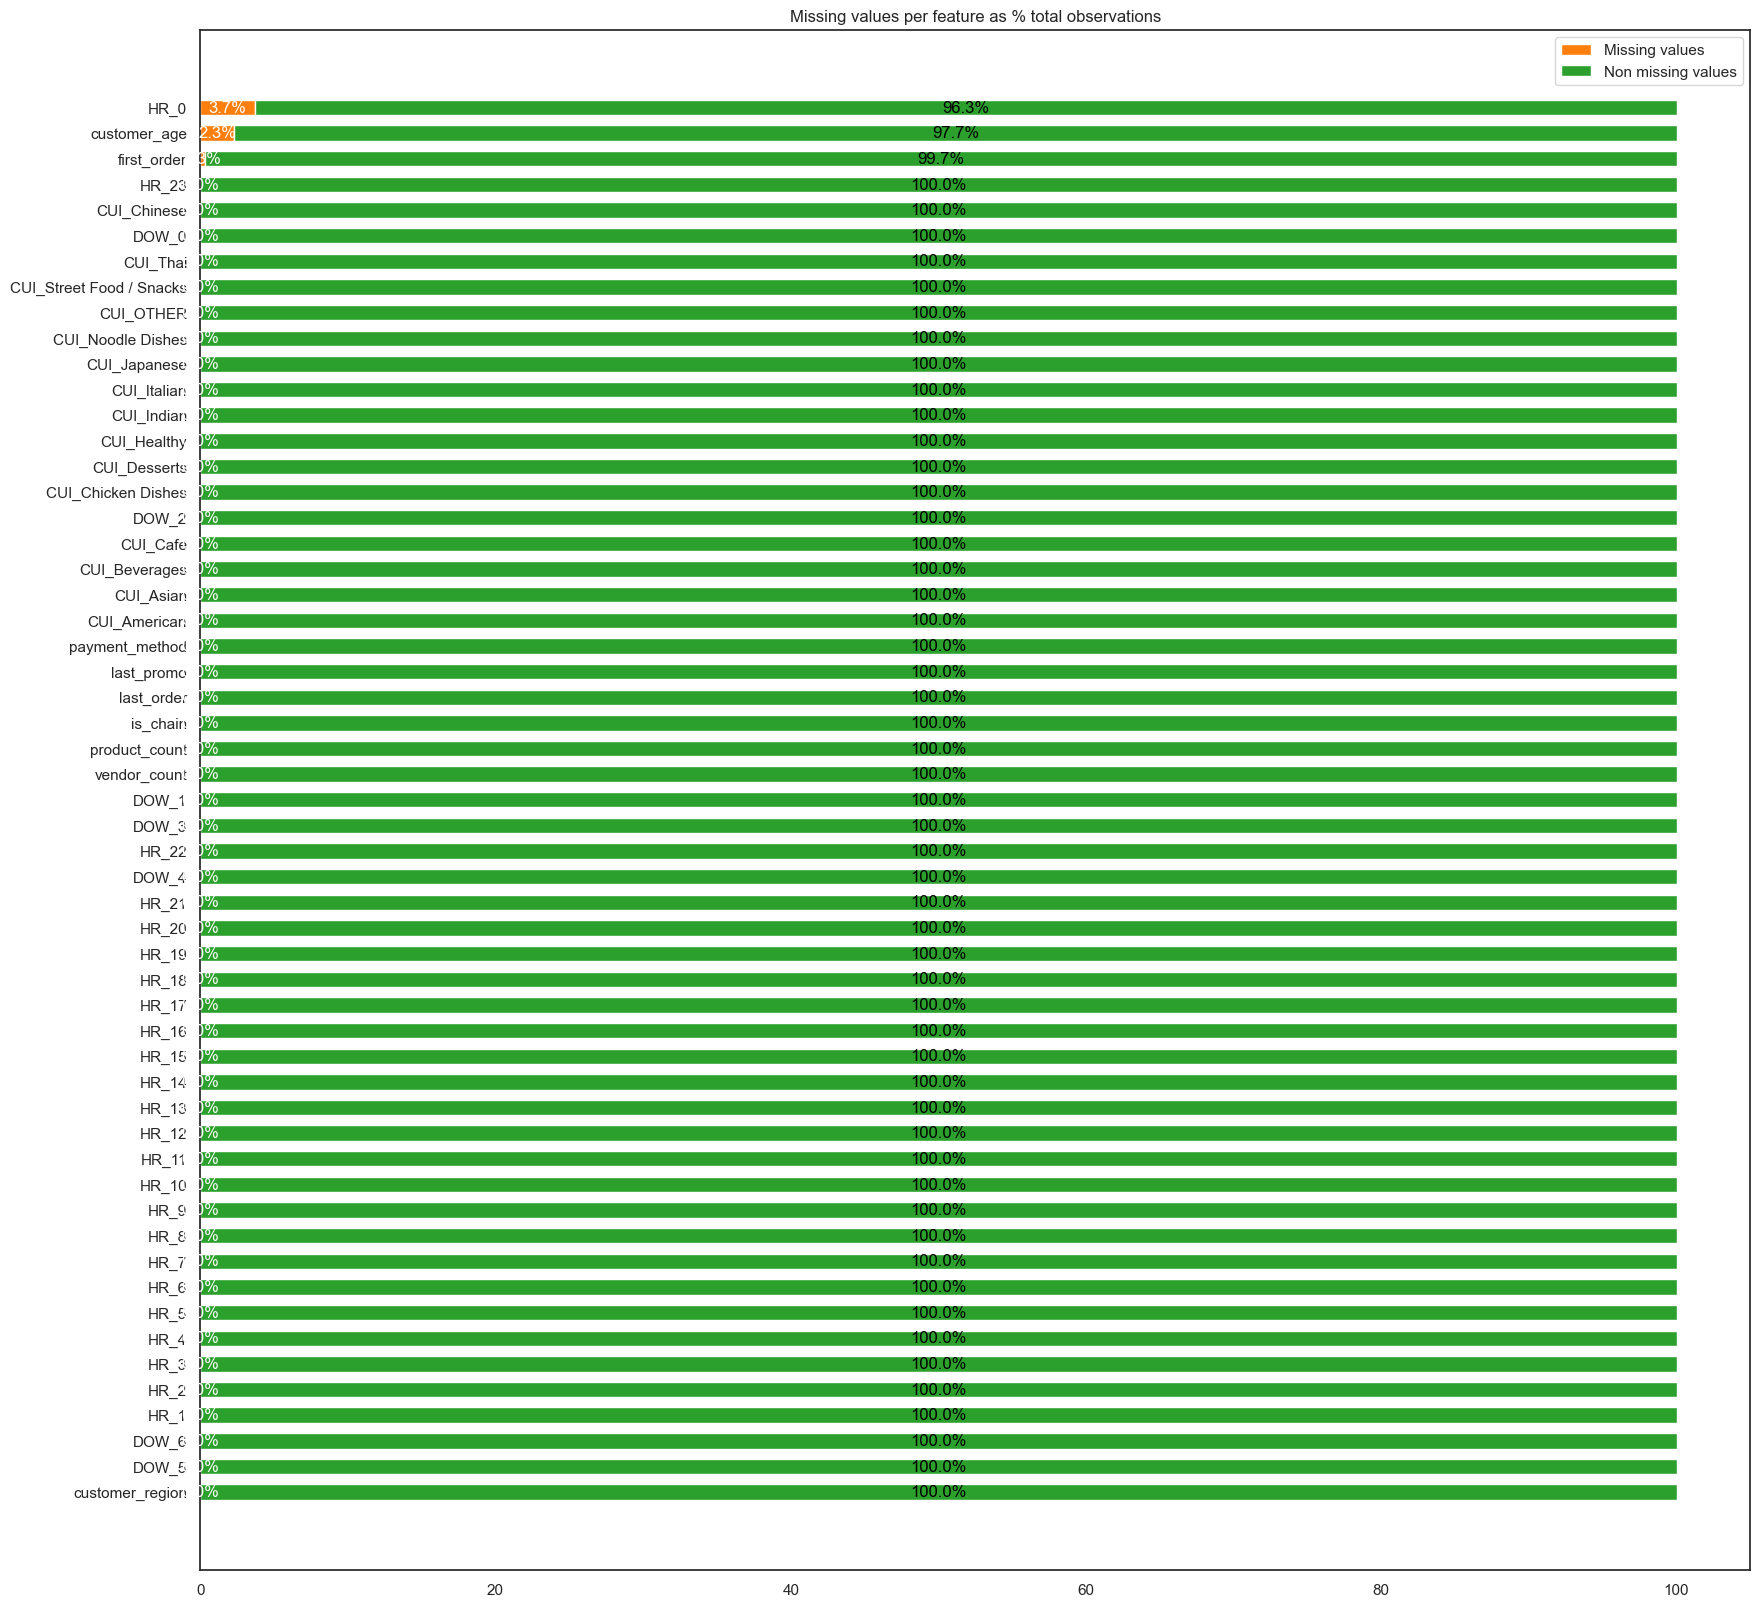

In [225]:
percentage_missing = round((df.isnull().sum() / df.shape[0])*100,1)
percentage_missing.sort_values(ascending=True, inplace= True)

percentage_missing_df = pd.DataFrame({"missing_values_(%)": percentage_missing})
percentage_missing_df["present_values_(%)"] = abs(percentage_missing_df["missing_values_(%)"] - 100)
percentage_present = percentage_missing_df["present_values_(%)"]
column_names = list(percentage_missing.index)

fig,ax = plt.subplots (figsize = (20,20))
p1 = ax.barh(y=column_names, width=percentage_missing, height= 0.6, color="tab:orange", label="Missing values")
p2 = ax.barh(y=column_names, width=percentage_present, height= 0.6, color="tab:green", left=percentage_missing, label= "Non missing values")
ax.bar_label(p1, labels= [str(element) + "%" for element in percentage_missing], color="white", label_type="center")
ax.bar_label(p2, labels= [str(element) + "%" for element in percentage_present], color="black", label_type="center")
ax.legend()
ax.set_title("Missing values per feature as % total observations")
plt.show()


<div class="alert alert-block alert-info" style="font-size:16px" id= "individual_feature_analyzis">

## 2. Individual feature analysis

---

### 2.1 **`customer_id`**

##### Customer_id variable contains unique identifier for each customer, thus we set that variable as index. That variable has not been further analysed.

----

### 2.2 **`customer_region`**

In [226]:
df['customer_region'].value_counts()

customer_region
8670    9748
4660    9533
2360    8815
2440    1482
4140     856
8370     495
2490     444
-        442
8550      13
Name: count, dtype: int64

In [227]:
#changing the 442 missing values from - to Unknown Region

df.replace("-", 'Unknown', inplace=True)
df['customer_region'].isna().sum()

0

In [228]:
df['customer_region'].value_counts()

customer_region
8670       9748
4660       9533
2360       8815
2440       1482
4140        856
8370        495
2490        444
Unknown     442
8550         13
Name: count, dtype: int64

In [229]:
region_counts = pd.DataFrame(df['customer_region'].value_counts())

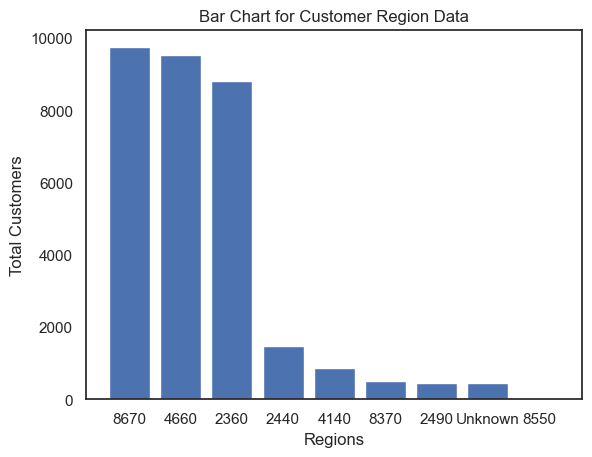

In [230]:
#making a boxplot for region data
plt.bar(region_counts.index, region_counts['count'])

plt.title('Bar Chart for Customer Region Data')
plt.xlabel('Regions')
plt.ylabel('Total Customers')

plt.show()

In [231]:
#sorting so the groups of regions are next to each other
region_counts.sort_index(axis=0, ascending=True, inplace=True, kind='quicksort')

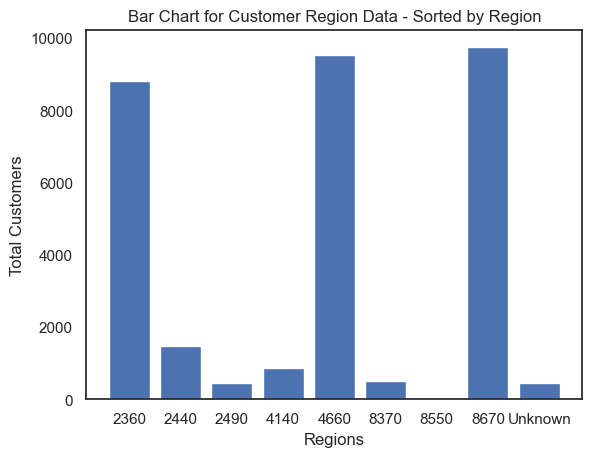

In [232]:
#making a boxplot for region data
plt.bar(region_counts.index, region_counts['count'])

plt.title('Bar Chart for Customer Region Data - Sorted by Region')
plt.xlabel('Regions')
plt.ylabel('Total Customers')

plt.show()

## customer_region summary
- Data type is object
- 442 hidden missing values, originally stored as "-", but transformed into 'Unknown Region' so that we can keep those observations without skewing the data
- 442 missing values represents 1.38% of total customer region data
- Duplicates are expected
- If we assume the first digit of the region indicates city, customers are split appproximately evenly throughout the three cities
    - 10,757 customers in City 2 (cities beginning with 2)
    - 10,407 customers in City 4 (cities beginning with 4)
    - 10,282 customers in City 8 (cities beginning with 8)
- The majority of customers live in 3 of the 8 regions:
    - 2360
    - 4660
    - 8670  

It is probably safe to assume these are the city centers of the cities

---

### 2.3 **`customer_age`**

In [233]:
#looking at descriptive statistics
df['customer_age'].describe().round(2)

count    31101.00
mean        27.51
std          7.16
min         15.00
25%         23.00
50%         26.00
75%         31.00
max         80.00
Name: customer_age, dtype: float64

In [234]:
#more descriptive statistics
median_age = df['customer_age'].median()
print(median_age)

26.0


In [235]:
df['customer_age'].value_counts()

customer_age
23.0    2356
22.0    2313
24.0    2299
25.0    2258
26.0    2056
        ... 
79.0       2
75.0       2
78.0       1
71.0       1
73.0       1
Name: count, Length: 66, dtype: int64

In [236]:
df['customer_age'].isna().sum()

727

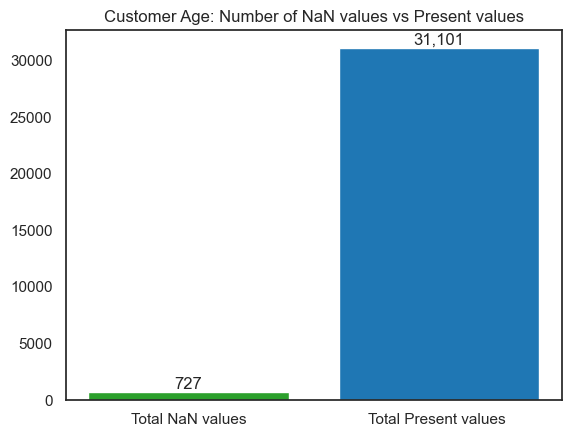

In [237]:
#Number of NaN values vs Non missing values
total_elements = len(df["customer_age"])
age_na_values = df["customer_age"].isna().sum()
age_present_values = total_elements- age_na_values

fig, ax = plt.subplots()
x_values = ["Total NaN values", "Total Present values "]
bar_colours = ["tab:green", "tab:blue"]

y_values = [age_na_values, age_present_values]
p = ax.bar(x_values, y_values, color=bar_colours)
ax.bar_label(p, labels= [f"{element:,}" for element in y_values])
ax.set_title("Customer Age: Number of NaN values vs Present values")

plt.show()

In [26]:
#examing rows with missing values to see if values are present for other features
age_missing_value_rows = df[df['customer_age'].isnull()]

age_missing_value_rows

customer_region  customer_age  vendor_count  product_count  \
customer_id                                                              
180c632ed8             4660           NaN             2              3   
8e8652bdc8             4660           NaN             2              3   
6137fa5620             8670           NaN             2              2   
2a90e9da84             4660           NaN             2              2   
a67d3108cb             8670           NaN             2              2   
...                     ...           ...           ...            ...   
46aa9dfeb0             8670           NaN             1              2   
29207a92c8             2360           NaN             1              1   
d7bf721199             2360           NaN             1              1   
ee49f4eb0a             2440           NaN             1              1   
f6b6709018             8670           NaN             1              1   

             is_chain  first_order  last_order last_promo payment_method  \
customer_id                                                                
180c632ed8          1          0.0           2   DELIVERY           DIGI   
8e8652bdc8          2          0.0           6   DISCOUNT           DIGI   
6137fa5620          2          0.0           8   DISCOUNT           CARD   
2a90e9da84          1          0.0          17    Unknown           CARD   
a67d3108cb          1          0.0          17    Unknown           CARD   
...               ...          ...         ...        ...            ...   
46aa9dfeb0          0         87.0          87   DELIVERY           DIGI   
29207a92c8          1         88.0          88    Unknown           CASH   
d7bf721199          1         89.0          89    Unknown           DIGI   
ee49f4eb0a          1          NaN           0   DELIVERY           CARD   
f6b6709018          0          NaN           0   DELIVERY           DIGI   

             CUI_American  ...  HR_14  HR_15  HR_16  HR_17  HR_18  HR_19  \
customer_id                ...                                             
180c632ed8           0.00  ...      1      0      0      0      0      0   
8e8652bdc8           0.00  ...      0      2      0      0      0      0   
6137fa5620           6.13  ...      1      0      0      0      0      0   
2a90e9da84          15.99  ...      0      1      0      0      0      1   
a67d3108cb           0.00  ...      0      0      0      0      0      0   
...                   ...  ...    ...    ...    ...    ...    ...    ...   
46aa9dfeb0           0.00  ...      0      0      0      0      0      0   
29207a92c8           0.00  ...      0      0      0      0      0      0   
d7bf721199           0.00  ...      1      0      0      0      0      0   
ee49f4eb0a           0.00  ...      0      0      0      1      0      0   
f6b6709018          18.04  ...      0      0      1      0      0      0   

             HR_20  HR_21  HR_22  HR_23  
customer_id                              
180c632ed8       0      0      0      0  
8e8652bdc8       0      0      0      0  
6137fa5620       0      0      0      0  
2a90e9da84       0      0      0      0  
a67d3108cb       0      0      0      0  
...            ...    ...    ...    ...  
46aa9dfeb0       0      0      0      0  
29207a92c8       0      0      0      0  
d7bf721199       0      0      0      0  
ee49f4eb0a       0      0      0      0  
f6b6709018       0      0      0      0  

[727 rows x 55 columns]

Histogram and boxplox for ***customer_age***

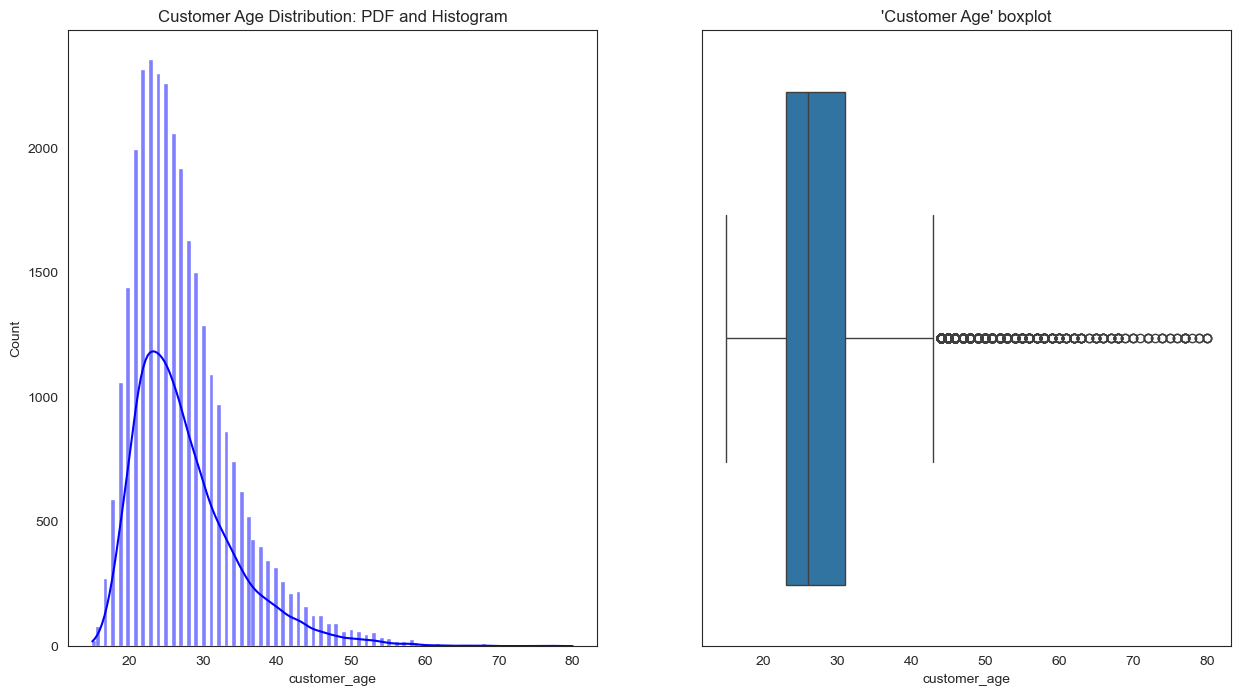

In [27]:
#For ploting purposes, we removed the NaN values
df_age_without_na = df["customer_age"].dropna()

Q1,Q3 = np.nanpercentile(df_age_without_na, [25, 75])
IQR = Q3-Q1
age_bin_width = (2*IQR)/len(df_age_without_na)**(1/3)
age_optimal_num_bins = int((max(df_age_without_na)-min(df_age_without_na))/age_bin_width)

fig, axes = plt.subplots(1, 2, figsize = (15,8))
sns.histplot(df_age_without_na, kde=True, color="blue", bins=age_optimal_num_bins, ax=axes[0])
axes[0].set_title("Customer Age Distribution: PDF and Histogram")

sns.boxplot(x = df_age_without_na, ax=axes[1])
axes[1].set_title("'Customer Age' boxplot")
plt.show()

### Conclusions from visuals  
- Data is highly positively skewed, resembling and F distribution
- Customer age has many highly positive outliers
- Middle 50% of the data is between ages 23 - 31

In [28]:
#let's take a closer look at outliers
age_IQR = df['customer_age'].quantile(0.75) - df['customer_age'].quantile(0.25)
print(age_IQR)

age_lower_bound = df['customer_age'].quantile(0.25) - 1.5 * age_IQR
age_upper_bound = df['customer_age'].quantile(0.75) + 1.5 * age_IQR

print(age_lower_bound)
print(age_upper_bound)

age_outliers = df[(df['customer_age'] < age_lower_bound) | (df['customer_age'] > age_upper_bound)]

age_outliers

8.0
11.0
43.0


customer_region  customer_age  vendor_count  product_count  \
customer_id                                                              
f49ed5489a             8670          51.0             2              2   
eb13ad08ad             8670          47.0             4              6   
b92ab1eeec             2360          47.0             5              6   
a9f54fe565             8670          48.0             2              4   
085c69caf5             2490          46.0             5             10   
...                     ...           ...           ...            ...   
eb13c834e7             2360          74.0             1              1   
12faabe829             8670          46.0             1              2   
20c90aaf32          Unknown          55.0             1              1   
4ff94a6987             2360          60.0             1              1   
b32f05f979             2360          51.0             1              1   

             is_chain  first_order  last_order last_promo payment_method  \
customer_id                                                                
f49ed5489a          2          0.0           4    FREEBIE           CARD   
eb13ad08ad          2          0.0           5   DELIVERY           CARD   
b92ab1eeec          5          0.0           6    Unknown           DIGI   
a9f54fe565          3          0.0          12   DISCOUNT           CARD   
085c69caf5          6          0.0          28   DELIVERY           CARD   
...               ...          ...         ...        ...            ...   
eb13c834e7          1         89.0          89   DELIVERY           CARD   
12faabe829          0          NaN           0    Unknown           CARD   
20c90aaf32          1          NaN           0   DISCOUNT           CASH   
4ff94a6987          1          NaN           0   DELIVERY           CARD   
b32f05f979          1          NaN           0    Unknown           CASH   

             CUI_American  ...  HR_14  HR_15  HR_16  HR_17  HR_18  HR_19  \
customer_id                ...                                             
f49ed5489a           0.00  ...      0      0      0      0      0      0   
eb13ad08ad           5.98  ...      0      0      1      0      0      0   
b92ab1eeec           3.00  ...      0      0      0      0      0      0   
a9f54fe565          12.59  ...      0      0      0      0      0      0   
085c69caf5           3.42  ...      0      0      0      1      0      0   
...                   ...  ...    ...    ...    ...    ...    ...    ...   
eb13c834e7           0.00  ...      0      0      0      0      0      1   
12faabe829           0.00  ...      0      0      0      0      0      0   
20c90aaf32           0.00  ...      0      0      0      0      0      0   
4ff94a6987           0.00  ...      0      0      0      0      0      0   
b32f05f979           0.00  ...      0      0      0      0      0      1   

             HR_20  HR_21  HR_22  HR_23  
customer_id                              
f49ed5489a       0      0      0      0  
eb13ad08ad       0      0      0      0  
b92ab1eeec       0      0      0      0  
a9f54fe565       0      0      0      0  
085c69caf5       0      1      0      0  
...            ...    ...    ...    ...  
eb13c834e7       0      0      0      0  
12faabe829       0      0      0      0  
20c90aaf32       0      0      0      0  
4ff94a6987       0      0      0      0  
b32f05f979       0      0      0      0  

[1083 rows x 55 columns]

In [29]:
age_outliers['customer_age'].value_counts()

customer_age
44.0    157
46.0    123
45.0    123
48.0     89
47.0     88
50.0     65
49.0     59
51.0     58
53.0     53
52.0     47
54.0     34
55.0     28
58.0     26
56.0     19
57.0     17
59.0     12
60.0      9
68.0      8
62.0      8
61.0      7
63.0      7
77.0      6
65.0      6
66.0      5
67.0      4
70.0      3
72.0      3
74.0      3
80.0      3
64.0      2
76.0      2
69.0      2
79.0      2
75.0      2
78.0      1
71.0      1
73.0      1
Name: count, dtype: int64

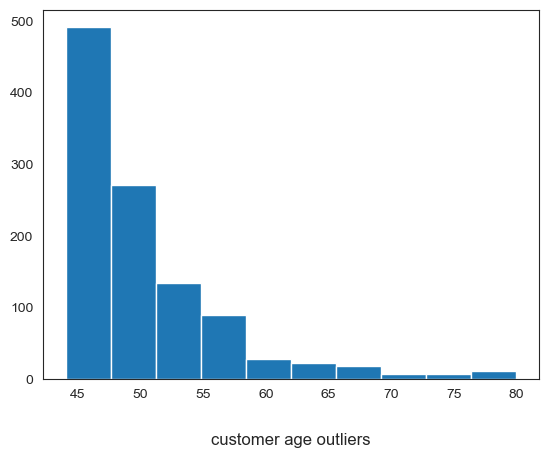

In [30]:
# customer age outlier histogram
plt.hist(age_outliers["customer_age"], bins=10)  # 13 bins bc age range is 65 so bins are 5 years each
plt.title("customer age outliers", y=-0.2)

plt.show()

In [31]:
outlier_detection(df, ['customer_age'])

customer_age: 
Number of extreme outliers: 159 (15%) 
Number of moderate outliers: 896 (84%) 
Total number of outliers: 1055
Q3 + 1.5*IQR = 43.0 
Q3 + 3*IQR = 55.0
Max: 80.0 
Min: 15.0 
95th percentil: 41.0
99th percentil: 52.0 



## customer_age summary
- Data type is float
- No abnormal values
- Duplicate values are exptected
- There are 727 missing values, which is 2.3% of the total age data - currenlty stored as NaN
- Range is 15 years to 80 years
- Mean is 27.51, median is 26, mode is 23
- 50% of the age data is between 23 and 31
- There are 1055 age outliers (3.31% of total age data):
      - 159 (0.49%) extreme outliers, 896 (2.81%) moderate outliers. anyone over the age of 43 is an outlier

---

### 2.4 **`vendor_count`**

In [32]:
# Understanding missing and unnusual values
print("vendor_count NaNs:")
print(df[['vendor_count']].isna().sum())

print("\nvendor_count unique values:")
print(df['vendor_count'].unique())

print("\nvendor_count = 0 instances:")
print(df[df['vendor_count'] == 0]['vendor_count'].value_counts())

vendor_count NaNs:
vendor_count    0
dtype: int64

vendor_count unique values:
[ 2  1  3  4  5  7  6 11  9  8 12 14 20 13 10 16 24 18 17 15 25 30 19 21
 23 22 28 32 41 40 26  0 27 34 31 35 29]

vendor_count = 0 instances:
vendor_count
0    138
Name: count, dtype: int64


In [33]:
#The custumers that have vendor_count == 0 don't seem to be missing people: they have ages, regions, payment methods, etc...

vendor_count_zero = df[df['vendor_count'] == 0]
vendor_count_zero

customer_region  customer_age  vendor_count  product_count  \
customer_id                                                              
4903041977             8670          22.0             0              0   
c94b288475             8670          26.0             0              0   
f687717dc1             8670          21.0             0              0   
c6cf0b76fb             8670          38.0             0              0   
1b7c34738e             8670          24.0             0              0   
...                     ...           ...           ...            ...   
177ede2420             8670          30.0             0              0   
0039059c9c             8670          22.0             0              0   
0e60632fe2             8670          23.0             0              0   
28ed1f1e3f             8670          20.0             0              0   
4c06e104de             8670          25.0             0              0   

             is_chain  first_order  last_order last_promo payment_method  \
customer_id                                                                
4903041977          1          1.0           1   DELIVERY           DIGI   
c94b288475          0          1.0           1   DELIVERY           CASH   
f687717dc1          1          1.0           1   DELIVERY           DIGI   
c6cf0b76fb          0          2.0           2   DELIVERY           CASH   
1b7c34738e          0          3.0           3    Unknown           CASH   
...               ...          ...         ...        ...            ...   
177ede2420          1         86.0          86    Unknown           DIGI   
0039059c9c          1         88.0          88   DISCOUNT           CARD   
0e60632fe2          0         89.0          89   DISCOUNT           CARD   
28ed1f1e3f          0         89.0          89   DELIVERY           DIGI   
4c06e104de          1         89.0          89    Unknown           CASH   

             CUI_American  ...  HR_14  HR_15  HR_16  HR_17  HR_18  HR_19  \
customer_id                ...                                             
4903041977            0.0  ...      0      0      0      0      0      0   
c94b288475            0.0  ...      0      0      0      0      0      0   
f687717dc1            0.0  ...      0      0      0      0      0      0   
c6cf0b76fb            0.0  ...      0      0      0      0      0      0   
1b7c34738e            0.0  ...      0      0      0      0      0      0   
...                   ...  ...    ...    ...    ...    ...    ...    ...   
177ede2420            0.0  ...      0      0      0      0      0      0   
0039059c9c            0.0  ...      0      0      0      0      0      0   
0e60632fe2            0.0  ...      0      0      0      0      0      0   
28ed1f1e3f            0.0  ...      0      0      0      0      0      0   
4c06e104de            0.0  ...      0      0      0      0      0      0   

             HR_20  HR_21  HR_22  HR_23  
customer_id                              
4903041977       0      0      0      0  
c94b288475       0      0      0      0  
f687717dc1       0      0      0      0  
c6cf0b76fb       0      0      0      0  
1b7c34738e       0      0      0      0  
...            ...    ...    ...    ...  
177ede2420       0      0      0      0  
0039059c9c       0      0      0      0  
0e60632fe2       0      0      0      0  
28ed1f1e3f       0      0      0      0  
4c06e104de       0      0      0      0  

[138 rows x 55 columns]

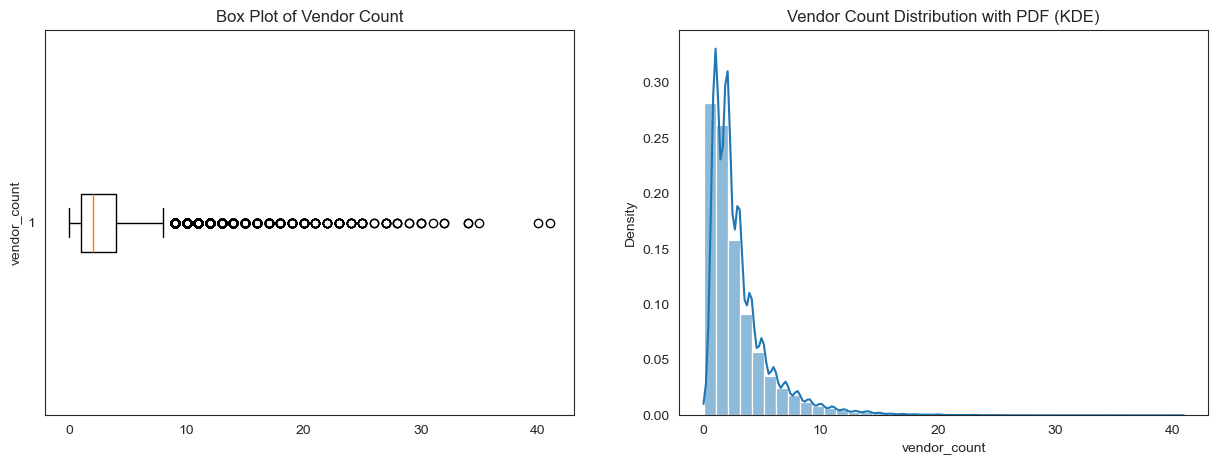

In [34]:
# Visualizing the data

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Box plot for vendor_count
plt.sca(axes[0])
plt.boxplot(df['vendor_count'], vert=False)
plt.title('Box Plot of Vendor Count')
plt.ylabel('vendor_count')

# Histogram with KDE for vendor_count
plt.sca(axes[1])
sns.histplot(df['vendor_count'], kde=True, bins=40, stat="density")
plt.title('Vendor Count Distribution with PDF (KDE)')
plt.xlabel('vendor_count')
plt.ylabel('Density')

plt.show()

## vendor_count summary

- The variable vendor_count represents the number of unique vendors the customer has ordered from.

- Therefore, there shouldn't be zeros. If to be on the database one needs to make a purchase, how can one have no vendor? But there are 138 zeros, which don't seem to be typos where the person doesnt exist.

- This data is highly skewed, with most customers purchasing from a small number of vendors.

- Focusing on the box plot, the median is close to 1 or 2, which can make sense if most people could tend to not use food delivery apps that much in three months, or they could be using them to pick up food from a few of their favorite places. The box is concentrated toward the lower end of the scale, with a lot of outliers. 

- These outliers could represent very active people. For instance, people who don't cook and use the app to feed themselves very often, thus having a high number of vendor interactions.

- The value of 0 likely represents NA or missing values as it doesn't make sense to have 0 vendors.


---

### 2.5 **`product_count`**

In [35]:
# Understanding missing and unusual values
print("product_count NaNs:")
print(df[['product_count']].isna().sum())

print("\nproduct_count unique values:")
print(df['product_count'].unique())

print("\nproduct_count = 0 instances:")
print(df[df['product_count'] == 0]['product_count'].value_counts())

product_count NaNs:
product_count    0
dtype: int64

product_count unique values:
[  5   2   3   4   6  10   8  17   7  26   9  32  15  13  16  28  19  12
  18  11  25  14  23  29  21  31  95  24  64  27  37  49  22  41  51  34
  39  20  30  47  40  53  38  54  35  33  56  65  45  63  36  79  48  70
  44  84  46  66  57  58  83 110 117 269  75  55  42  81  91  43  69  67
  72  59   1   0  77  97  87  73  76  60 109  52  62  94  80  89  61  82
  50  88  68]

product_count = 0 instances:
product_count
0    156
Name: count, dtype: int64


In [36]:
#The custumers that have product_count == 0 don't seem to be missing people: they have ages, regions, payment methods, etc...

product_count_zero = df[df['product_count'] == 0]
product_count_zero

customer_region  customer_age  vendor_count  product_count  \
customer_id                                                              
4903041977             8670          22.0             0              0   
c94b288475             8670          26.0             0              0   
f687717dc1             8670          21.0             0              0   
c6cf0b76fb             8670          38.0             0              0   
1b7c34738e             8670          24.0             0              0   
...                     ...           ...           ...            ...   
0039059c9c             8670          22.0             0              0   
0e60632fe2             8670          23.0             0              0   
28ed1f1e3f             8670          20.0             0              0   
4c06e104de             8670          25.0             0              0   
8d21b0b83c             4660          30.0             1              0   

             is_chain  first_order  last_order last_promo payment_method  \
customer_id                                                                
4903041977          1          1.0           1   DELIVERY           DIGI   
c94b288475          0          1.0           1   DELIVERY           CASH   
f687717dc1          1          1.0           1   DELIVERY           DIGI   
c6cf0b76fb          0          2.0           2   DELIVERY           CASH   
1b7c34738e          0          3.0           3    Unknown           CASH   
...               ...          ...         ...        ...            ...   
0039059c9c          1         88.0          88   DISCOUNT           CARD   
0e60632fe2          0         89.0          89   DISCOUNT           CARD   
28ed1f1e3f          0         89.0          89   DELIVERY           DIGI   
4c06e104de          1         89.0          89    Unknown           CASH   
8d21b0b83c          0         89.0          89   DELIVERY           DIGI   

             CUI_American  ...  HR_14  HR_15  HR_16  HR_17  HR_18  HR_19  \
customer_id                ...                                             
4903041977            0.0  ...      0      0      0      0      0      0   
c94b288475            0.0  ...      0      0      0      0      0      0   
f687717dc1            0.0  ...      0      0      0      0      0      0   
c6cf0b76fb            0.0  ...      0      0      0      0      0      0   
1b7c34738e            0.0  ...      0      0      0      0      0      0   
...                   ...  ...    ...    ...    ...    ...    ...    ...   
0039059c9c            0.0  ...      0      0      0      0      0      0   
0e60632fe2            0.0  ...      0      0      0      0      0      0   
28ed1f1e3f            0.0  ...      0      0      0      0      0      0   
4c06e104de            0.0  ...      0      0      0      0      0      0   
8d21b0b83c            0.0  ...      0      0      0      0      0      0   

             HR_20  HR_21  HR_22  HR_23  
customer_id                              
4903041977       0      0      0      0  
c94b288475       0      0      0      0  
f687717dc1       0      0      0      0  
c6cf0b76fb       0      0      0      0  
1b7c34738e       0      0      0      0  
...            ...    ...    ...    ...  
0039059c9c       0      0      0      0  
0e60632fe2       0      0      0      0  
28ed1f1e3f       0      0      0      0  
4c06e104de       0      0      0      0  
8d21b0b83c       0      0      0      0  

[156 rows x 55 columns]

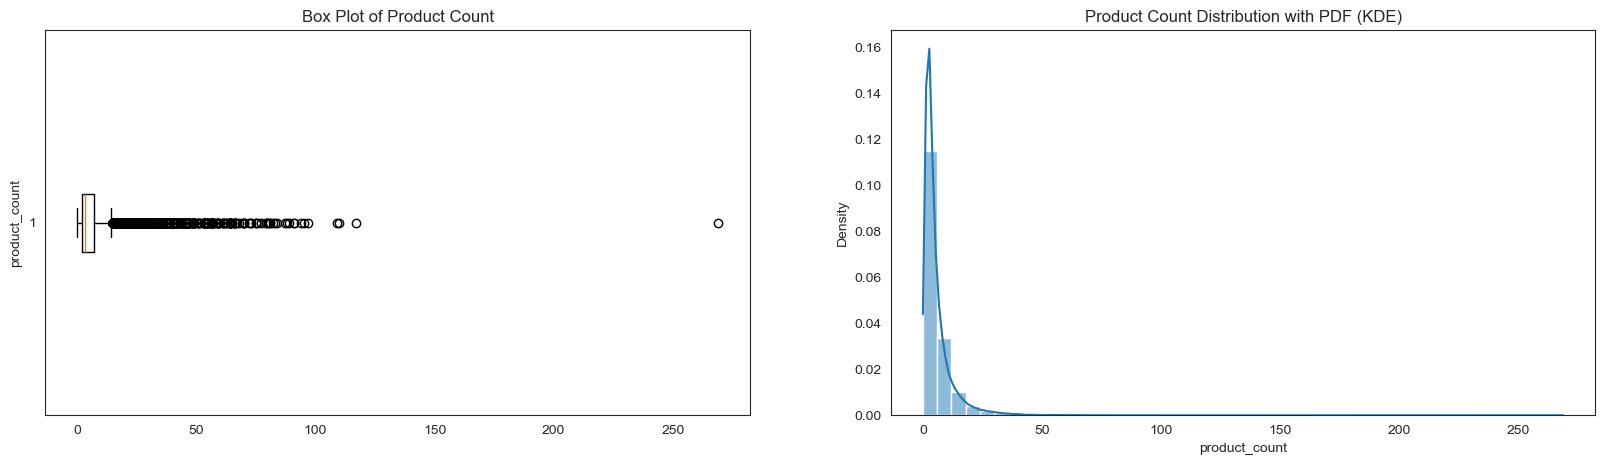

In [37]:
# Visualizing the data

fig, axes = plt.subplots(1, 2, figsize=(20, 5))

# Box plot for product_count
plt.sca(axes[0])
plt.boxplot(df['product_count'], vert=False)
plt.title('Box Plot of Product Count')
plt.ylabel('product_count')

# Histogram with KDE for product_count
plt.sca(axes[1])
sns.histplot(df['product_count'], kde=True, bins=45, stat="density")
plt.title('Product Count Distribution with PDF (KDE)')
plt.xlabel('product_count')
plt.ylabel('Density')

plt.show()

## product_count summary 
The variable product_count represents the total number of products that customers have ordered. 
- Product_count has 156 zeros, which doesn't make sense because it is improbable for someone to not have bought any products. These do not seem to be typos where the person does not exist.

The distribution is highly skewed, with the majority of customers ordering only a few products, and the probability decreasing rapidly as the number of products increases.

Looking at the box plot, the majority of customers have ordered very few products. The median is also very close to the lower bound.

In short, the majority of customers order small amounts of products. This could possibly be explained by the fact that people are usually placing an order for only themselves, a couple, or a family. The frequency of larger orders decreases rapidly. Some customers place significantly larger orders, but they are considered outliers.

It must be noted that this variable only reflects the total orders placed in the three months of data collection. It says nothing about how many products were bought per order. It is likely that product_count nor vendor_count are correlated and that the outliers in both could represent the same individuals (for instance, customer 92ced2dcb9 bought 269 products from 40 different vendors. This is likely a person who placed many orders, not someone who bought 200 meals in one go).

It is suspected that the zeros represent missing values, as it is impossible to order zero products.

---

### 2.6 **`is_chain`**

In [38]:
# Understanding missing and unusual values

print("is_chain NaNs:")
print(df[['is_chain']].isna().sum())

print("\nis_chain unique values:")
print(df['is_chain'].unique())

is_chain NaNs:
is_chain    0
dtype: int64

is_chain unique values:
[ 1  2  0  3  5  4  7 12  6 23  8 11 20 14  9 10 16 15 13 25 17 27 30 32
 24 18 26 28 22 40 31 39 21 37 19 33 65 38 29 45 47 73 81 56 35 46 67 44
 61 34 36 49 83 75 43 42 48 63 54 80]


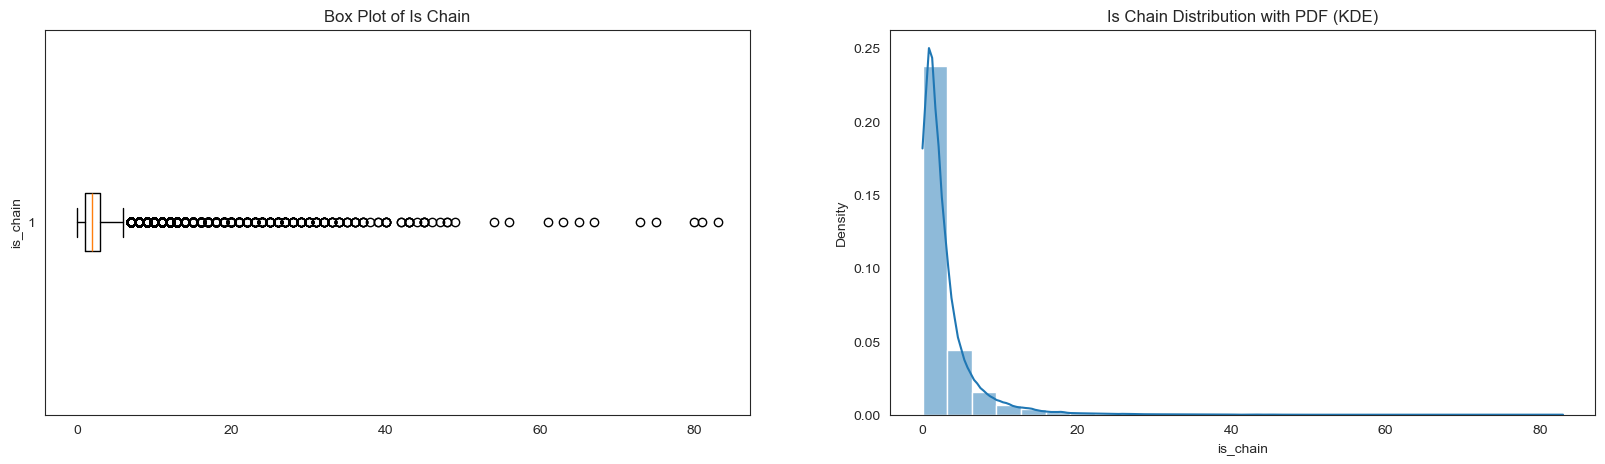

In [39]:
fig, axes = plt.subplots(1, 2, figsize=(20, 5))

# Box plot for is_chain
plt.sca(axes[0])
plt.boxplot(df['is_chain'], vert=False)
plt.title('Box Plot of Is Chain')
plt.ylabel('is_chain')

# Histogram with KDE for is_chain
plt.sca(axes[1])
sns.histplot(df['is_chain'], kde=True, bins=26, stat="density")
plt.title('Is Chain Distribution with PDF (KDE)')
plt.xlabel('is_chain')
plt.ylabel('Density')

plt.show()

## is_chain summary
The variable is_chain is described by the metadata as indicating whether the customer’s order was from a chain restaurant.

- The wording makes it sound like a boolean; however, it was observed in the descriptive statistics that it can take values up to 83. There are only 8,547 instances of 1 and 6,104 instances of 0, which suggests that the numbers represent how many chain restaurants the customer purchased from, and 0 indicates no chain purchases.
- There are some unusual numbers, such as customers who bought from 80 different chain restaurants.

Most customers order very few times from chain restaurants (many likely only 1 or 2 orders). However, due to outliers who have placed many orders from chains, the distribution is right-skewed. The lower whisker starts at 0, meaning some customers haven’t ordered from chain restaurants at all. This is probably highly related to product_count and vendor_count: the individuals who ordered from 40 vendors are likely the same ones buying hundreds of products, likely from many chain restaurants.


---

### 2.7 **`first_order`**

In [40]:
# Understanding the feature
df["first_order"].info()

<class 'pandas.core.series.Series'>
Index: 31828 entries, 1b8f824d5e to fd40d3b0e0
Series name: first_order
Non-Null Count  Dtype  
--------------  -----  
31722 non-null  float64
dtypes: float64(1)
memory usage: 1.5+ MB


In [41]:
# Undestanding the statistical properties
df["first_order"].describe(percentiles= np.arange(0.1,1,0.05))

count    31722.000000
mean        28.462329
std         24.101334
min          0.000000
10%          2.000000
15%          4.000000
20%          6.000000
25%          7.000000
30%         10.000000
35%         13.000000
40%         16.000000
45%         19.000000
50%         22.000000
50%         22.000000
55%         26.000000
60%         30.000000
65%         34.000000
70%         39.000000
75%         45.000000
80%         51.000000
85%         58.000000
90%         67.000000
95%         77.000000
max         90.000000
Name: first_order, dtype: float64

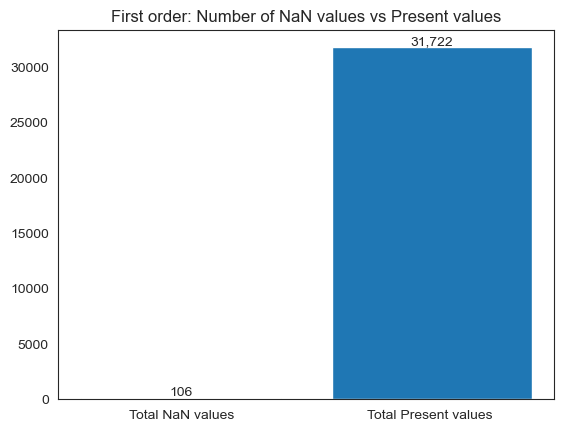

In [42]:
# Number of NaN values vs Non missing values
total_elements = len(df["first_order"])
fo_perc_na_values = df["first_order"].isna().sum()
fo_per_present_values = total_elements- fo_perc_na_values

fig, ax = plt.subplots()
x_values = ["Total NaN values", "Total Present values "]
bar_colours = ["tab:green", "tab:blue"]

y_values = [fo_perc_na_values, fo_per_present_values]
p = ax.bar(x_values, y_values, color=bar_colours)
ax.bar_label(p, labels= [f"{element:,}" for element in y_values])
ax.set_title("First order: Number of NaN values vs Present values")

plt.show()


In [43]:
# Attempting to understand the NaN values better
total_fo_nan_values = df.loc[df["first_order"].isnull()].shape[0]
lo_0_fo_nan_values = df.loc[ (df["first_order"].isnull()) & (df["last_order"] == 0) & (df["product_count"] > 0)].shape[0]

if total_fo_nan_values == lo_0_fo_nan_values:
    print("All the NaN values for 'first_order', correspond to clients who made their 'last_order' in the 1st day of the 1st month and have a total of product count bigger than 0")

All the NaN values for 'first_order', correspond to clients who made their 'last_order' in the 1st day of the 1st month and have a total of product count bigger than 0


In [44]:
# Identifying possible hidden NaN values 
df["first_order"].unique()

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
       39., 40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51.,
       52., 53., 54., 55., 56., 57., 58., 59., 60., 61., 62., 63., 64.,
       65., 66., 67., 68., 69., 70., 71., 72., 73., 74., 75., 76., 77.,
       78., 79., 80., 81., 82., 83., 84., 85., 86., 87., 88., 89., 90.,
       nan])

In [45]:
# Changing dtype
df["first_order"] = df["first_order"].astype("Int64")

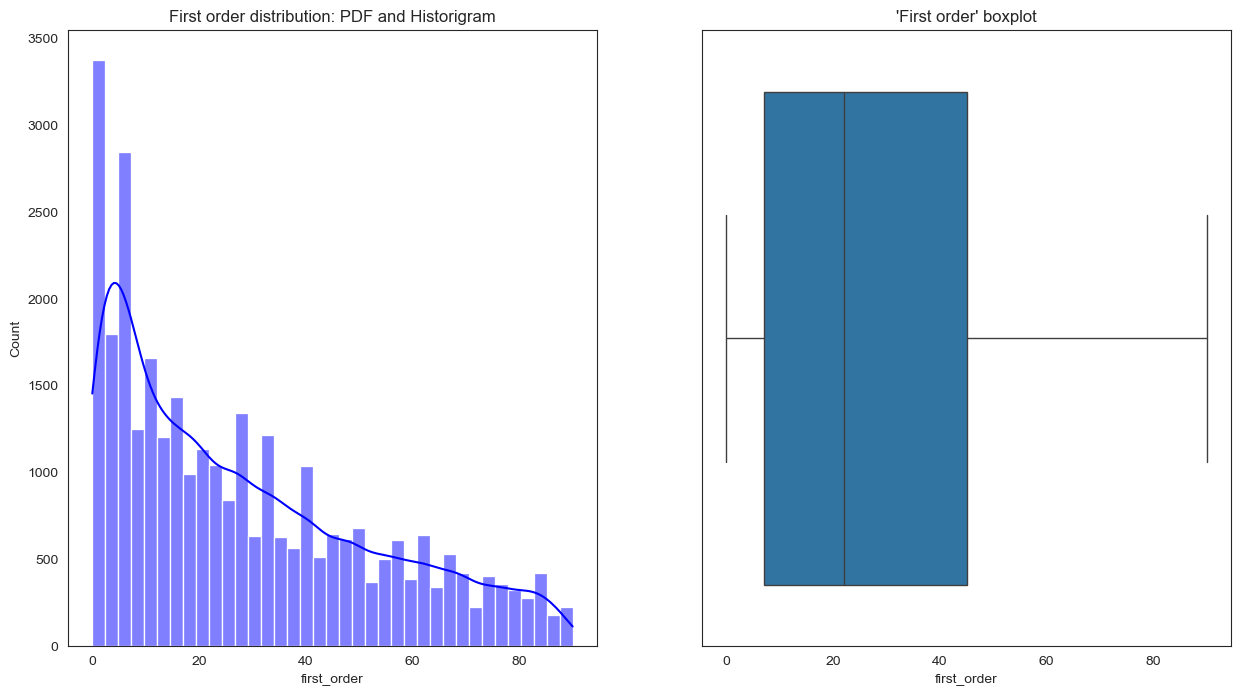

In [46]:
# Histogram and boxplot using the Freedman - Diaconis rule 

#For ploting purposes, we removed the NaN values
df_fo_without_na = df["first_order"].dropna()

Q1,Q3 = np.nanpercentile(df_fo_without_na, [25, 75])
IQR = Q3-Q1
fd_bin_width = (2*IQR)/len(df_fo_without_na)**(1/3)
df_optimal_num_bins = int((max(df_fo_without_na)-min(df_fo_without_na))/fd_bin_width)

fig, axes = plt.subplots(1, 2, figsize = (15,8))
sns.histplot(df_fo_without_na, kde=True, color="blue", bins=df_optimal_num_bins, ax=axes[0])
axes[0].set_title("First order distribution: PDF and Historigram")

sns.boxplot(x = df_fo_without_na, ax=axes[1])
axes[1].set_title("'First order' boxplot")
plt.show()

#### <u> Conclusions </u>
#### Based on the historigram and boxplot, we can conclude the following regarding the first order:

- No traditional outliers
- The distribution is positive skewed, meaning that clients tend to make their first order in the first month
- 60% of clients made their first order in the first month and 75% after one month and half
- Only 10% of clients took longer than 67 days to make their first order

#### Based on the analyzis, the following questions were raised:
1. Analyzing inactive/active users
    - From the 60% of clients that made their first order before the end of first month, how many became inactive and active users in the 2 months that followed?
        -How to determine inactive users do this: For the customers who made their first order before the end of first month, check how many have the first_order value equal to the last_order value 
    - From the clients 40% of clients that made their first order after 1 month, how many became inactive or active users in the 2 months that followed?

In [47]:
# Analyze num of outliers
outlier_detection(df, ["first_order"])

first_order: 
Number of extreme outliers: 0 (%) 
Number of moderate outliers: 0 (%) 
Total number of outliers: 0
Q3 + 1.5*IQR = 102.0 
Q3 + 3*IQR = 159
Max: 90 
Min: 0 
95th percentil: 77
99th percentil: 86 



[Text(0, 0, '61.0%'), Text(0, 0, '26.0%'), Text(0, 0, '14.0%')]

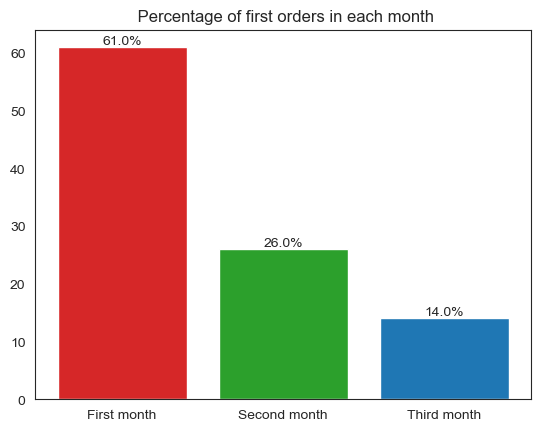

In [48]:
# Analyzing the % of clients who made their first order in each month

total_fo = int(df["first_order"].count())
first_month_fo = int(df["first_order"].loc[df["first_order"] <= 30].count())
second_month_fo = int(df["first_order"].loc[(df["first_order"] > 30) & (df["first_order"] <= 60)].count())
third_month_fo = int(df["first_order"].loc[(df["first_order"] > 60) & (df["first_order"] <= 90)].count())
y_values = [first_month_fo, second_month_fo, third_month_fo]
#Change to percentage values. Didn't do it above to avoid making the code too long
for i in range(len(y_values)):
    y_values[i] = round((y_values[i]/total_fo)*100, 0)

"""
1. Note that the meaning of the parameter label is different in ax.bar() and ax.bar_label()
1.1 In ax.bar(), it helps us define the different names going to be used in the 'legend' (rigth end corner)
2. ax.bar_label()
2.1 Helps us define the values that appear at the top of each bar
2.2 For it to work, we need to save ax.bar() in a variable
"""
x_values = ["First month", "Second month", "Third month"]
fig, ax = plt.subplots(nrows=1, ncols=1)
bar_color = ["tab:red", "tab:green", "tab:blue"]
bar_label_values = ax.bar(x_values, y_values, color = bar_color)
ax.set_title(" Percentage of first orders in each month")
ax.bar_label(bar_label_values, labels= [str(element) + "%" for element in y_values])



#### <u> Conclusions: </u>
1. We can clearly see the dominance of the first month, represeting the month where 61% of total first orders were made by the customers
2. From the first to the second month, there is a reduction of 35p.p and from the first to the third a reduction of 47p.p 
3. Combined, the second and third month only represent around 66% of the total representation of the first month

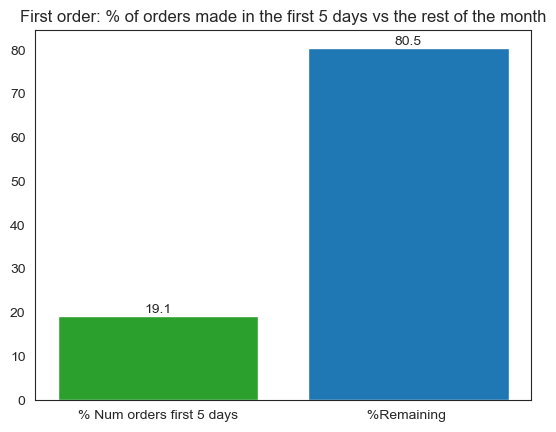

In [49]:
# Analyzing the % of orders made in the first 5 days vs the rest of the month

total_elements = len(df["first_order"])
fo_5_days = round((df["first_order"].loc[df["first_order"] <= 5].count()/total_elements)*100,1)
fo_remaining = round((df["first_order"].loc[df["first_order"] >5].count()/total_elements)*100,1)

fig, ax = plt.subplots()
x_values = ["% Num orders first 5 days", " %Remaining  "]
bar_colours = ["tab:green", "tab:blue"]

y_values = [fo_5_days, fo_remaining]
p = ax.bar(x_values, y_values, color=bar_colours)
ax.bar_label(p, labels= [f"{element:,}" for element in y_values])
ax.set_title("First order: % of orders made in the first 5 days vs the rest of the month")
plt.show()

## first_order summary
- Represents a discrete numerical variable (values between 0 and 90)
- No traditional outliers
- Despite low number of NaN values (106), they are quite interesting. Don't think they are NaN for lack of infromation but due to error. My suggestion: Input the hidden NaN values with a 0. 
- No hidden NaN values
- Changed data format from float64 to int64


---

### 2.8 **`last_order`**

In [50]:
#Understanding the feature
df["last_order"].info()

<class 'pandas.core.series.Series'>
Index: 31828 entries, 1b8f824d5e to fd40d3b0e0
Series name: last_order
Non-Null Count  Dtype
--------------  -----
31828 non-null  int64
dtypes: int64(1)
memory usage: 1.5+ MB


In [51]:
#Undestanding the statistical properties
df["last_order"].describe(percentiles= np.arange(0.1,1,0.05))

count    31828.00000
mean        63.66674
std         23.23167
min          0.00000
10%         27.00000
15%         35.00000
20%         42.00000
25%         49.00000
30%         55.00000
35%         60.00000
40%         64.00000
45%         68.00000
50%         70.00000
50%         70.00000
55%         74.00000
60%         76.00000
65%         79.00000
70%         81.00000
75%         83.00000
80%         84.00000
85%         86.00000
90%         87.00000
95%         89.00000
max         90.00000
Name: last_order, dtype: float64

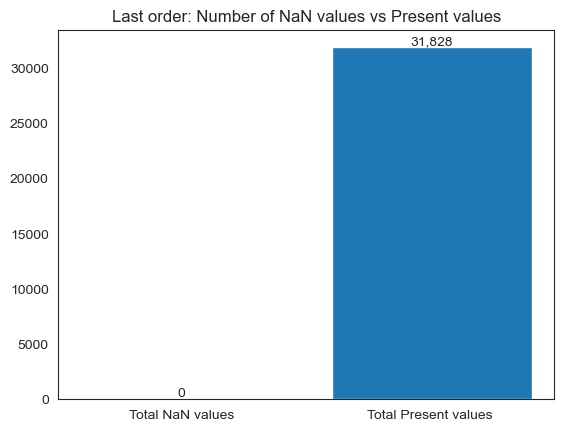

In [52]:
#Number of NaN values vs Non missing values
total_elements = len(df["last_order"])
fo_perc_na_values = df["last_order"].isna().sum()
fo_per_present_values = total_elements- fo_perc_na_values

fig, ax = plt.subplots()
x_values = ["Total NaN values", "Total Present values "]
bar_colours = ["tab:green", "tab:blue"]

y_values = [fo_perc_na_values, fo_per_present_values]
p = ax.bar(x_values, y_values, color=bar_colours)
ax.bar_label(p, labels= [f"{element:,}" for element in y_values])
ax.set_title("Last order: Number of NaN values vs Present values")

plt.show()


No NaN values in that variable

In [53]:
#Identifying possible hidden NaN values
df["last_order"].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8, 10, 11, 12, 13, 14, 16, 17, 18, 19,
       20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36,
       37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
       54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70,
       71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87,
       88, 89, 90,  9, 15,  0])

In [54]:
#Changing dtype
df["last_order"] = df["last_order"].astype("Int64")


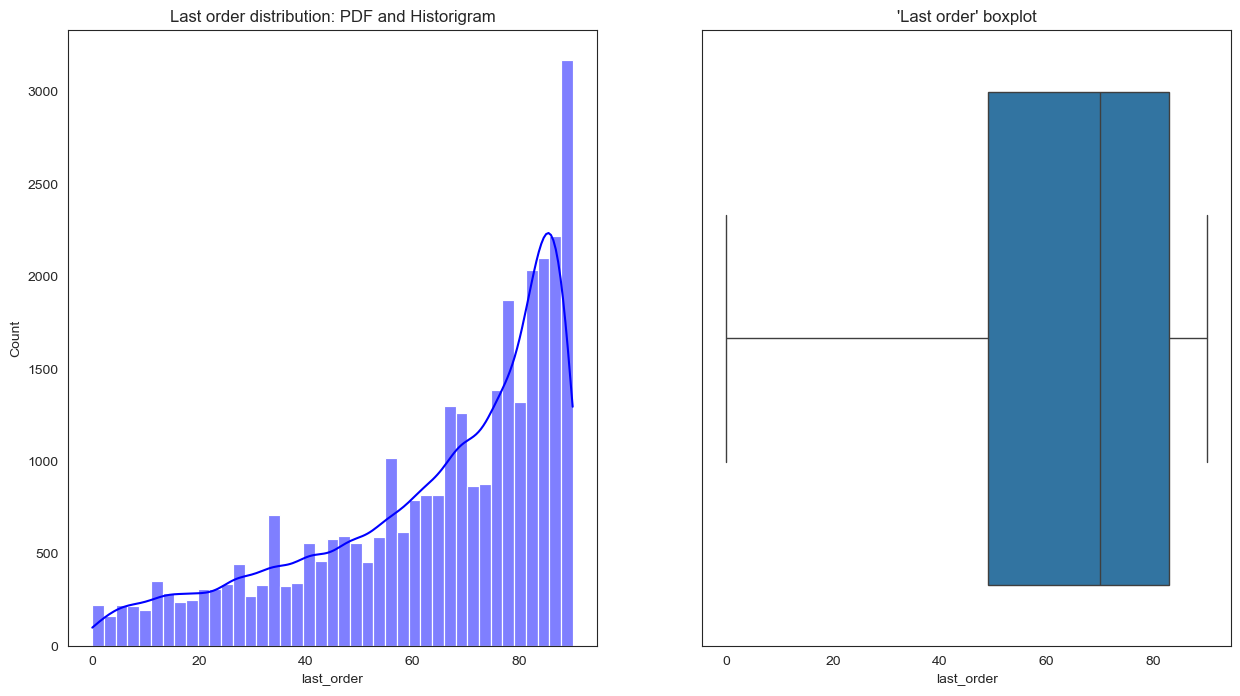

In [55]:
# Histogram and boxplot using the Freedman - Diaconis rule

Q1,Q3 = np.nanpercentile(df["last_order"], [25, 75])
IQR = Q3-Q1
fd_bin_width = (2*IQR)/len(df["last_order"])**(1/3)
df_optimal_num_bins = int((max(df["last_order"])-min(df["last_order"]))/fd_bin_width)

fig, axes = plt.subplots(1, 2, figsize = (15,8))
sns.histplot(df["last_order"], kde=True, color="blue", bins=df_optimal_num_bins, ax=axes[0])
axes[0].set_title("Last order distribution: PDF and Historigram")

sns.boxplot(x = df["last_order"], ax=axes[1])
axes[1].set_title("'Last order' boxplot")
plt.show()

In [56]:
# Analyze num of outliers
outlier_detection(df, ["last_order"])

last_order: 
Number of extreme outliers: 0 (%) 
Number of moderate outliers: 0 (%) 
Total number of outliers: 0
Q3 + 1.5*IQR = 134.0 
Q3 + 3*IQR = 185.0
Max: 90 
Min: 0 
95th percentil: 89.0
99th percentil: 89.0 



#### <u> Conclusions </u>
#### - Based on the historigram and boxplot, we can conclude the following regarding the last order:
1. Visual confirmation that variable follows a left skewed distribution, meaning that clients tend to make their last order laster in time with 50%
    making it close to the middle of the last month (last 20 days of the third month)
2. There seems to be no outlier presence in the last_order variable, despite not being normally distributed and being havily skewed to the left
3. Around 65% of clients made their last order in the last month and 35% made their last order in the first 2 months


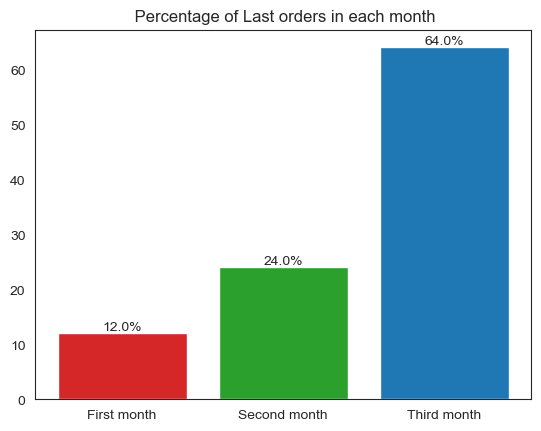

In [57]:
# Analyzing the % of clients who made their last order in each month

total_fo = int(df["last_order"].count())
first_month_fo = int(df["last_order"].loc[df["last_order"] <= 30].count())
second_month_fo = int(df["last_order"].loc[(df["last_order"] > 30) & (df["last_order"] <= 60)].count())
third_month_fo = int(df["last_order"].loc[(df["last_order"] > 60) & (df["last_order"] <= 90)].count())
y_values = [first_month_fo, second_month_fo, third_month_fo]

#Change to percentage values. Didn't do it above to avoid making the code too long
for i in range(len(y_values)):
    y_values[i] = round((y_values[i]/total_fo)*100, 0)

"""
1. Note that the meaning of the parameter label is different in ax.bar() and ax.bar_label()
1.1 In ax.bar(), it helps us define the different names going to be used in the 'legend' (rigth end corner)
2. ax.bar_label()
2.1 Helps us define the values that appear at the top of each bar
2.2 For it to work, we need to save ax.bar() in a variable
"""
x_values = ["First month", "Second month", "Third month"]
fig, ax = plt.subplots(nrows=1, ncols=1)
bar_color = ["tab:red", "tab:green", "tab:blue"]
bar_label_values = ax.bar(x_values, y_values, color = bar_color)
ax.set_title(" Percentage of Last orders in each month")
ax.bar_label(bar_label_values, labels= [str(element) + "%" for element in y_values])

plt.show()

## last_order summary
- Represents a discrete numerical variable (values between 0 and 90)
- No traditional outliers
- No NaN values, No hidden NaN values
- Changed data format from float64 to int64


---

### 2.9 **`last_promo`**

In [58]:
# Understanding the feature
df["last_promo"].info()

<class 'pandas.core.series.Series'>
Index: 31828 entries, 1b8f824d5e to fd40d3b0e0
Series name: last_promo
Non-Null Count  Dtype 
--------------  ----- 
31828 non-null  object
dtypes: object(1)
memory usage: 1.5+ MB


In [59]:
# Undestanding the statistical properties
df["last_promo"].describe(percentiles= np.arange(0.1,1,0.05))

count       31828
unique          4
top       Unknown
freq        16722
Name: last_promo, dtype: object

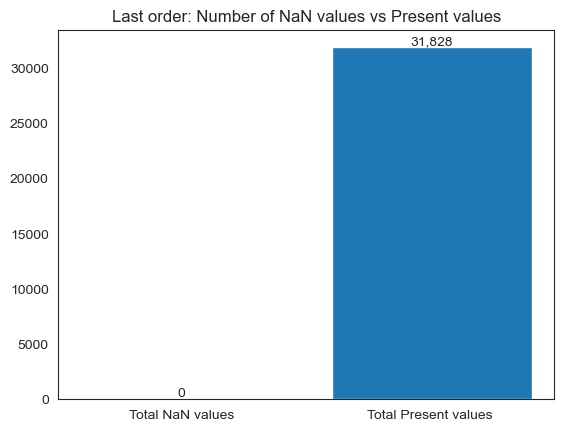

In [60]:
# Number of NaN values vs Non missing values
total_elements = len(df["last_promo"])
lp_perc_na_values = df["last_promo"].isna().sum()
lp_per_present_values = total_elements- fo_perc_na_values

fig, ax = plt.subplots()
x_values = ["Total NaN values", "Total Present values "]
bar_colours = ["tab:green", "tab:blue"]

y_values = [lp_perc_na_values, lp_per_present_values]
p = ax.bar(x_values, y_values, color=bar_colours)
ax.bar_label(p, labels= [f"{element:,}" for element in y_values])
ax.set_title("Last order: Number of NaN values vs Present values")

plt.show()


No NaN values in that variable

In [61]:
# Identifying possible hidden NaN values 
df["last_promo"].unique()

#Feature seems to have a strange value - '-'

array(['DELIVERY', 'DISCOUNT', 'Unknown', 'FREEBIE'], dtype=object)

[Text(0, 0, '0%'), Text(0, 0, '100%')]

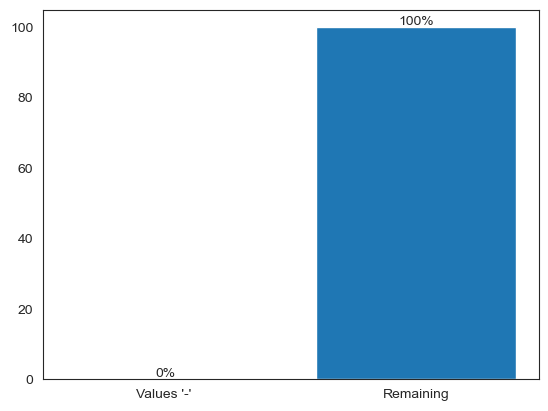

In [62]:
# Let's analyze the existing number of strange values
sns.set_style("white")


last_promo_strange_values = int(df["last_promo"].loc[df["last_promo"] == '-'].count() )
last_promo_remaining_values = int(df["last_promo"].loc[df["last_promo"] != '-'].count() )
total_values = df["last_promo"].count()
fig, ax = plt.subplots()
x_values = ["Values '-' ", "Remaining"]
bar_colours = ["tab:green", "tab:blue"]
y_values = [int((last_promo_strange_values/total_values)*100), int((last_promo_remaining_values/total_values)*100)]
p = ax.bar(x_values, y_values, color=bar_colours)
ax.bar_label(p, labels= [str(element) + "%" for element in y_values])

####  <u> Conclusions </u>
1. More than 50% of clients have the value '-' for the 'last_promo' feature 
2. Since the percentage of clients who have value '-' is very high, we will consider it not as NaN but has an indicator that no promotion code was used 

In [63]:
# Feature Preprocessing - Replacing '-' with 'NO PROMO USED' 

df.loc[df["last_promo"] == '-', "last_promo"] = 'NO PROMO USED'
df["last_promo"].unique()

array(['DELIVERY', 'DISCOUNT', 'Unknown', 'FREEBIE'], dtype=object)

In [64]:
# Checking the statistical properties after the change

df["last_promo"].describe()

count       31828
unique          4
top       Unknown
freq        16722
Name: last_promo, dtype: object

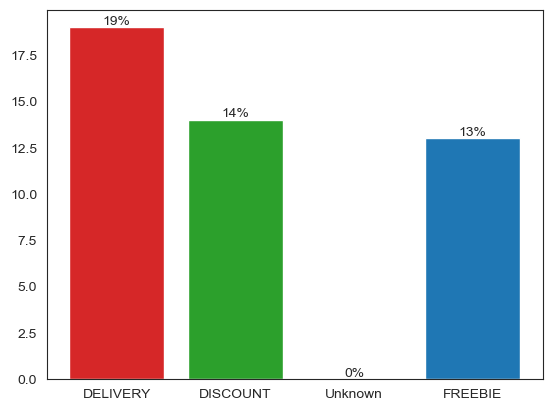

In [65]:
# Bar plot
x_values = list(df["last_promo"].unique())
delivery_promo = df["last_promo"].loc[df["last_promo"] == "DELIVERY"].count()
discount_promo = df["last_promo"].loc[df["last_promo"] ==  "DISCOUNT"].count()
no_promo_used = df["last_promo"].loc[df["last_promo"] ==  "NO PROMO USED"].count()
freebie_promo = df["last_promo"].loc[df["last_promo"] ==  "FREEBIE"].count()
total_elements = df["last_promo"].count()
y_values = [int((element/total_elements)*100) for element in [delivery_promo, discount_promo, no_promo_used, freebie_promo]]

fig, ax = plt.subplots()
bar_color = ["tab:red", "tab:green", "tab:grey", "tab:blue"]
p = ax.bar(x_values, y_values, color= bar_color)
ax.bar_label(p, labels= [str(element) + "%" for element in y_values])

plt.show()

#### <u> Conclusions </u> 
#### - Based on the barplot, we can conclude the following regarding the last promo:

1. 52% of clients haven't used any promo code in their last order. This is positive since they can be considered "profitable" clients in the last offer
2. The 48% remaining clients were less profitable to the company having received a partial discount on the food and service provided or having no cost at all
3. From the "less profitable" clients segment, it's important to note the 13% of clients who used the "FREEBIE" promo code in their last order. This means that around one out of every 10 last orders resulted in an incurrered lost to the company

#### - Based on the analyzis, the following questions were raised:
1. Did the FREEBIE clients make only one purchase order? This would mean they incurred a loss to the company

## last_promo summary

- Represents a categorical ordinal feature (Ordinal from 'NO PROMO USED' to 'FREEBIE')
- Visually doesn't seem to have outliers
- Had a strange value ('-')
- Preprocessing activities: Changed the strange value to 'NO PROMO USED'
- Didn't change the dtype 

---

### 2.10 **`payment_method`**

In [66]:
df['payment_method'].value_counts()

payment_method
CARD    20119
DIGI     6090
CASH     5619
Name: count, dtype: int64

In [67]:
df['payment_method'].isna().sum()

0

In [68]:
payment_groups = pd.DataFrame(df['payment_method'].value_counts())

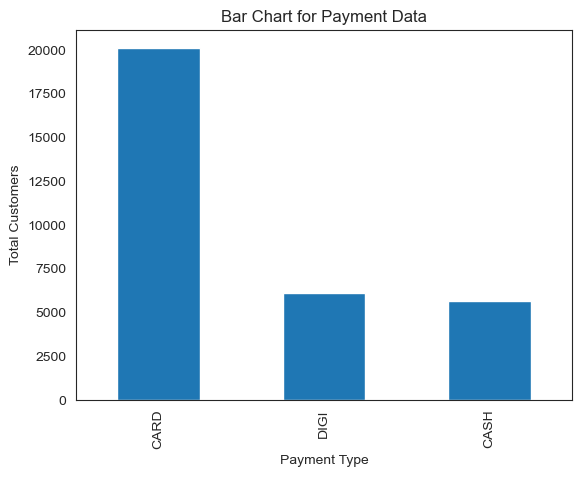

In [69]:
#bar chat for a visual
df['payment_method'].value_counts().plot(kind='bar')

plt.title('Bar Chart for Payment Data')
plt.xlabel('Payment Type')
plt.ylabel('Total Customers')

plt.show()

## payment_method summary
- Data type is object
- Duplicate values are expected
- No missing values
- 2/3 of customers pay with card
- If we consider "card" and "cash" to indicate in-person payment, and "digi" to indicate digital/online payment, then 31828 80.87% of customers are paying in-person. This presents a potential loss for the company - customers paying upon pickup may not show up, delivery drives may have to wait longer to move on to the next order, etc. It would be in the company's best interest to move more payments to online.

---

### 2.11 **`CUI_variables`**

- These variables are floats.
- There no missing values in these variables.
- There are several answers that corresponds to the fact that cutomers have not spend any monetary units in asked type of cuisine.

In [70]:
# A list with all CUI_ variables have been created.
    
cui_columns = [element for element in df.columns if 'CUI' in str(element)]
df[cui_columns]

CUI_American  CUI_Asian  CUI_Beverages  CUI_Cafe  \
customer_id                                                     
1b8f824d5e           0.00       0.00           0.00       0.0   
5d272b9dcb          12.82       6.39           0.00       0.0   
f6d1b2ba63           9.20       0.00           0.00       0.0   
180c632ed8           0.00      13.70           0.00       0.0   
4eb37a6705          14.57      40.87           0.00       0.0   
...                   ...        ...            ...       ...   
f4e366c281           0.00       0.00          18.04       0.0   
f6b6709018          18.04       0.00           0.00       0.0   
f74ad8ce3f           0.00       0.00           0.00       0.0   
f7b19c0241           0.00      12.03           0.00       0.0   
fd40d3b0e0           0.00       0.00           0.00       0.0   

             CUI_Chicken Dishes  CUI_Chinese  CUI_Desserts  CUI_Healthy  \
customer_id                                                               
1b8f824d5e                  0.0          0.0          0.00          0.0   
5d272b9dcb                  0.0          0.0          0.00          0.0   
f6d1b2ba63                  0.0          0.0          0.00          0.0   
180c632ed8                  0.0          0.0          0.00          0.0   
4eb37a6705                  0.0          0.0          0.00          0.0   
...                         ...          ...           ...          ...   
f4e366c281                  0.0          0.0          0.00          0.0   
f6b6709018                  0.0          0.0          0.00          0.0   
f74ad8ce3f                  0.0          0.0         17.79          0.0   
f7b19c0241                  0.0          0.0          0.00          0.0   
fd40d3b0e0                  0.0          0.0          0.00          0.0   

             CUI_Indian  CUI_Italian  CUI_Japanese  CUI_Noodle Dishes  \
customer_id                                                             
1b8f824d5e        28.88         0.00           0.0                0.0   
5d272b9dcb         0.00         0.00           0.0                0.0   
f6d1b2ba63         0.00         0.00           0.0                0.0   
180c632ed8        17.86         0.00           0.0                0.0   
4eb37a6705         0.00         0.00           0.0                0.0   
...                 ...          ...           ...                ...   
f4e366c281         0.00         0.00           0.0                0.0   
f6b6709018         0.00         0.00           0.0                0.0   
f74ad8ce3f         0.00         0.00           0.0                0.0   
f7b19c0241         0.00         0.00           0.0                0.0   
fd40d3b0e0         0.00         7.91           0.0                0.0   

             CUI_OTHER  CUI_Street Food / Snacks  CUI_Thai  
customer_id                                                 
1b8f824d5e         0.0                       0.0       0.0  
5d272b9dcb         0.0                       0.0       0.0  
f6d1b2ba63         0.0                       0.0       0.0  
180c632ed8         0.0                       0.0       0.0  
4eb37a6705         0.0                       0.0       0.0  
...                ...                       ...       ...  
f4e366c281         0.0                       0.0       0.0  
f6b6709018         0.0                       0.0       0.0  
f74ad8ce3f         0.0                       0.0       0.0  
f7b19c0241         0.0                       0.0       0.0  
fd40d3b0e0         0.0                       0.0       0.0  

[31828 rows x 15 columns]

In [71]:
df[cui_columns].info()

<class 'pandas.core.frame.DataFrame'>
Index: 31828 entries, 1b8f824d5e to fd40d3b0e0
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   CUI_American              31828 non-null  float64
 1   CUI_Asian                 31828 non-null  float64
 2   CUI_Beverages             31828 non-null  float64
 3   CUI_Cafe                  31828 non-null  float64
 4   CUI_Chicken Dishes        31828 non-null  float64
 5   CUI_Chinese               31828 non-null  float64
 6   CUI_Desserts              31828 non-null  float64
 7   CUI_Healthy               31828 non-null  float64
 8   CUI_Indian                31828 non-null  float64
 9   CUI_Italian               31828 non-null  float64
 10  CUI_Japanese              31828 non-null  float64
 11  CUI_Noodle Dishes         31828 non-null  float64
 12  CUI_OTHER                 31828 non-null  float64
 13  CUI_Street Food / Snacks  31828 non-null  float64
 1

In [72]:
df[cui_columns].describe()

CUI_American     CUI_Asian  CUI_Beverages      CUI_Cafe  \
count  31828.000000  31828.000000   31828.000000  31828.000000   
mean       4.878717      9.959460       2.296773      0.802162   
std       11.652854     23.571343       8.470691      6.432826   
min        0.000000      0.000000       0.000000      0.000000   
25%        0.000000      0.000000       0.000000      0.000000   
50%        0.000000      0.000000       0.000000      0.000000   
75%        5.660000     11.830000       0.000000      0.000000   
max      280.210000    896.710000     229.220000    326.100000   

       CUI_Chicken Dishes   CUI_Chinese  CUI_Desserts   CUI_Healthy  \
count        31828.000000  31828.000000  31828.000000  31828.000000   
mean             0.768990      1.431904      0.884069      0.951931   
std              3.660007      8.196175      5.257256      5.835936   
min              0.000000      0.000000      0.000000      0.000000   
25%              0.000000      0.000000      0.000000      0.000000   
50%              0.000000      0.000000      0.000000      0.000000   
75%              0.000000      0.000000      0.000000      0.000000   
max            219.660000    739.730000    230.070000    255.810000   

         CUI_Indian   CUI_Italian  CUI_Japanese  CUI_Noodle Dishes  \
count  31828.000000  31828.000000  31828.000000       31828.000000   
mean       1.630242      3.234723      2.993057           0.712701   
std        7.443219     11.253846     10.182749           4.540379   
min        0.000000      0.000000      0.000000           0.000000   
25%        0.000000      0.000000      0.000000           0.000000   
50%        0.000000      0.000000      0.000000           0.000000   
75%        0.000000      0.000000      0.000000           0.000000   
max      309.070000    468.330000    706.140000         275.110000   

          CUI_OTHER  CUI_Street Food / Snacks      CUI_Thai  
count  31828.000000              31828.000000  31828.000000  
mean       3.002839                  3.906958      0.841754  
std        9.775722                 15.522462      4.435322  
min        0.000000                  0.000000      0.000000  
25%        0.000000                  0.000000      0.000000  
50%        0.000000                  0.000000      0.000000  
75%        0.000000                  0.000000      0.000000  
max      366.080000                454.450000    136.380000

In [73]:
df[cui_columns].isna().sum()

CUI_American                0
CUI_Asian                   0
CUI_Beverages               0
CUI_Cafe                    0
CUI_Chicken Dishes          0
CUI_Chinese                 0
CUI_Desserts                0
CUI_Healthy                 0
CUI_Indian                  0
CUI_Italian                 0
CUI_Japanese                0
CUI_Noodle Dishes           0
CUI_OTHER                   0
CUI_Street Food / Snacks    0
CUI_Thai                    0
dtype: int64

In [74]:
zero_counts = {}

for column in cui_columns:
    zero_counts[column] = (df[column] == 0.00).sum()

for column, count in zero_counts.items():
    print(f"Number of 0.00 values for {column}: {count}")

Number of 0.00 values for CUI_American: 21053
Number of 0.00 values for CUI_Asian: 19953
Number of 0.00 values for CUI_Beverages: 26405
Number of 0.00 values for CUI_Cafe: 30465
Number of 0.00 values for CUI_Chicken Dishes: 28582
Number of 0.00 values for CUI_Chinese: 28310
Number of 0.00 values for CUI_Desserts: 29815
Number of 0.00 values for CUI_Healthy: 29660
Number of 0.00 values for CUI_Indian: 28388
Number of 0.00 values for CUI_Italian: 25389
Number of 0.00 values for CUI_Japanese: 25542
Number of 0.00 values for CUI_Noodle Dishes: 29604
Number of 0.00 values for CUI_OTHER: 24795
Number of 0.00 values for CUI_Street Food / Snacks: 27589
Number of 0.00 values for CUI_Thai: 29455


In [75]:
percentage = {}
for column, count in zero_counts.items():
    percentage[column] = round((count / 31888) * 100, 2)

# Sort the dictionary in ascending order
sorted_percentage = dict(sorted(percentage.items(), key=lambda x: x[1], reverse=True))

for key, value in sorted_percentage.items():
    print(f"Percentage share of 0.00 values in {key}: {value}%")


Percentage share of 0.00 values in CUI_Cafe: 95.54%
Percentage share of 0.00 values in CUI_Desserts: 93.5%
Percentage share of 0.00 values in CUI_Healthy: 93.01%
Percentage share of 0.00 values in CUI_Noodle Dishes: 92.84%
Percentage share of 0.00 values in CUI_Thai: 92.37%
Percentage share of 0.00 values in CUI_Chicken Dishes: 89.63%
Percentage share of 0.00 values in CUI_Indian: 89.02%
Percentage share of 0.00 values in CUI_Chinese: 88.78%
Percentage share of 0.00 values in CUI_Street Food / Snacks: 86.52%
Percentage share of 0.00 values in CUI_Beverages: 82.81%
Percentage share of 0.00 values in CUI_Japanese: 80.1%
Percentage share of 0.00 values in CUI_Italian: 79.62%
Percentage share of 0.00 values in CUI_OTHER: 77.76%
Percentage share of 0.00 values in CUI_American: 66.02%
Percentage share of 0.00 values in CUI_Asian: 62.57%


In [76]:
# Calulating how many rows (customers) there are that have 0 values for each cusine 
# Checking for "missing values"

rows_with_only_zeros_in_cuisines = (df[cui_columns] == 0).all(axis=1)
num_rows_with_only_zeros_in_cuisines = rows_with_only_zeros_in_cuisines.sum()
print(f"There are {num_rows_with_only_zeros_in_cuisines} rows in total that have only 0 values in cui variables")

There are 138 rows in total that have only 0 values in cui variables


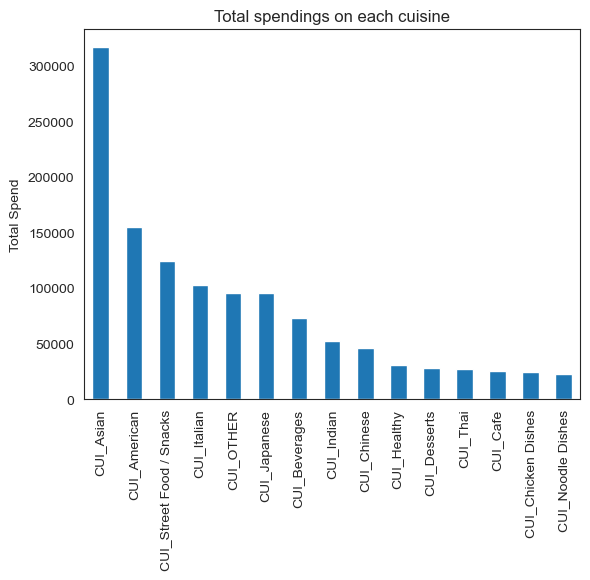

In [77]:
sorted_sums_cui = df[cui_columns].sum().sort_values(ascending=False)

sorted_sums_cui.plot(kind='bar')

plt.title('Total spendings on each cuisine')
plt.ylabel('Total Spend')
plt.show()

Most money are spend on Asian cuisine. Then on American and Street Fodd. The least is spend on Noodle and Chicken Dishes, Cafe, Thai, Desserts and Healthy cuisine.  

Check for outliers in CUI_ columns (with 0 values)

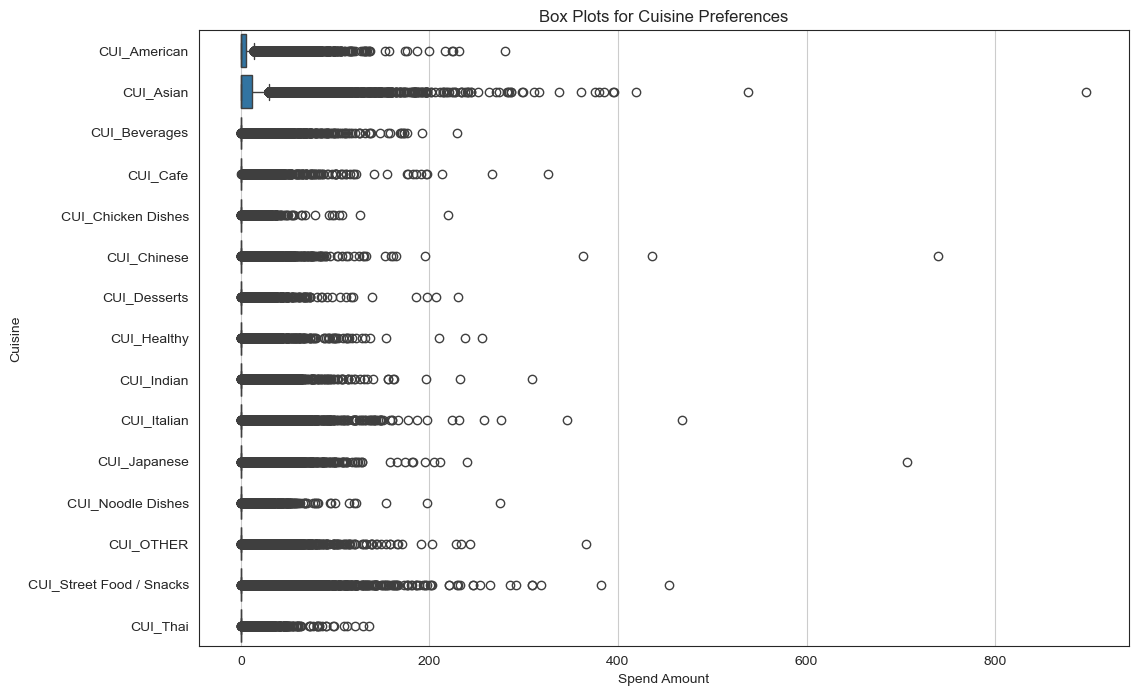

In [78]:
df_melted = df.melt(value_vars=cui_columns, var_name='Cuisine', value_name='Spend Amount')

plt.figure(figsize=(12, 8))
sns.boxplot(y='Cuisine', x='Spend Amount', data=df_melted)

plt.title('Box Plots for Cuisine Preferences')
plt.grid(axis='x')  
plt.show()


Check for outliers in CUI_ columns (withouts 0 values)

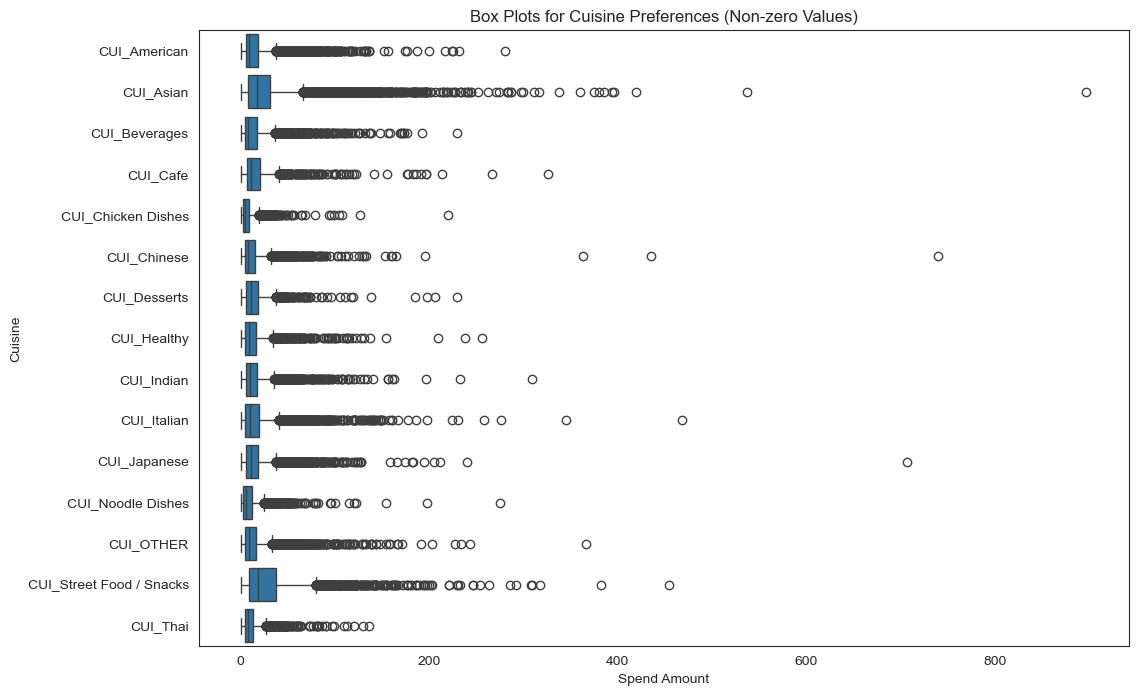

In [79]:

df_melted = df.melt(value_vars=cui_columns, var_name='Cuisine', value_name='Spend Amount')

df_melted = df_melted[df_melted['Spend Amount'] != 0]


plt.figure(figsize=(12, 8))
sns.boxplot(y='Cuisine', x='Spend Amount', data=df_melted)

plt.title('Box Plots for Cuisine Preferences (Non-zero Values)')
plt.show()

Since there are so many 0 values in the CUI_variables we checked box plots with 0 values included and without them. There are no significant difference between outliers in those two boxplots. Therefore, we will use boxplot with all values (with 0 values included) for further analysis.

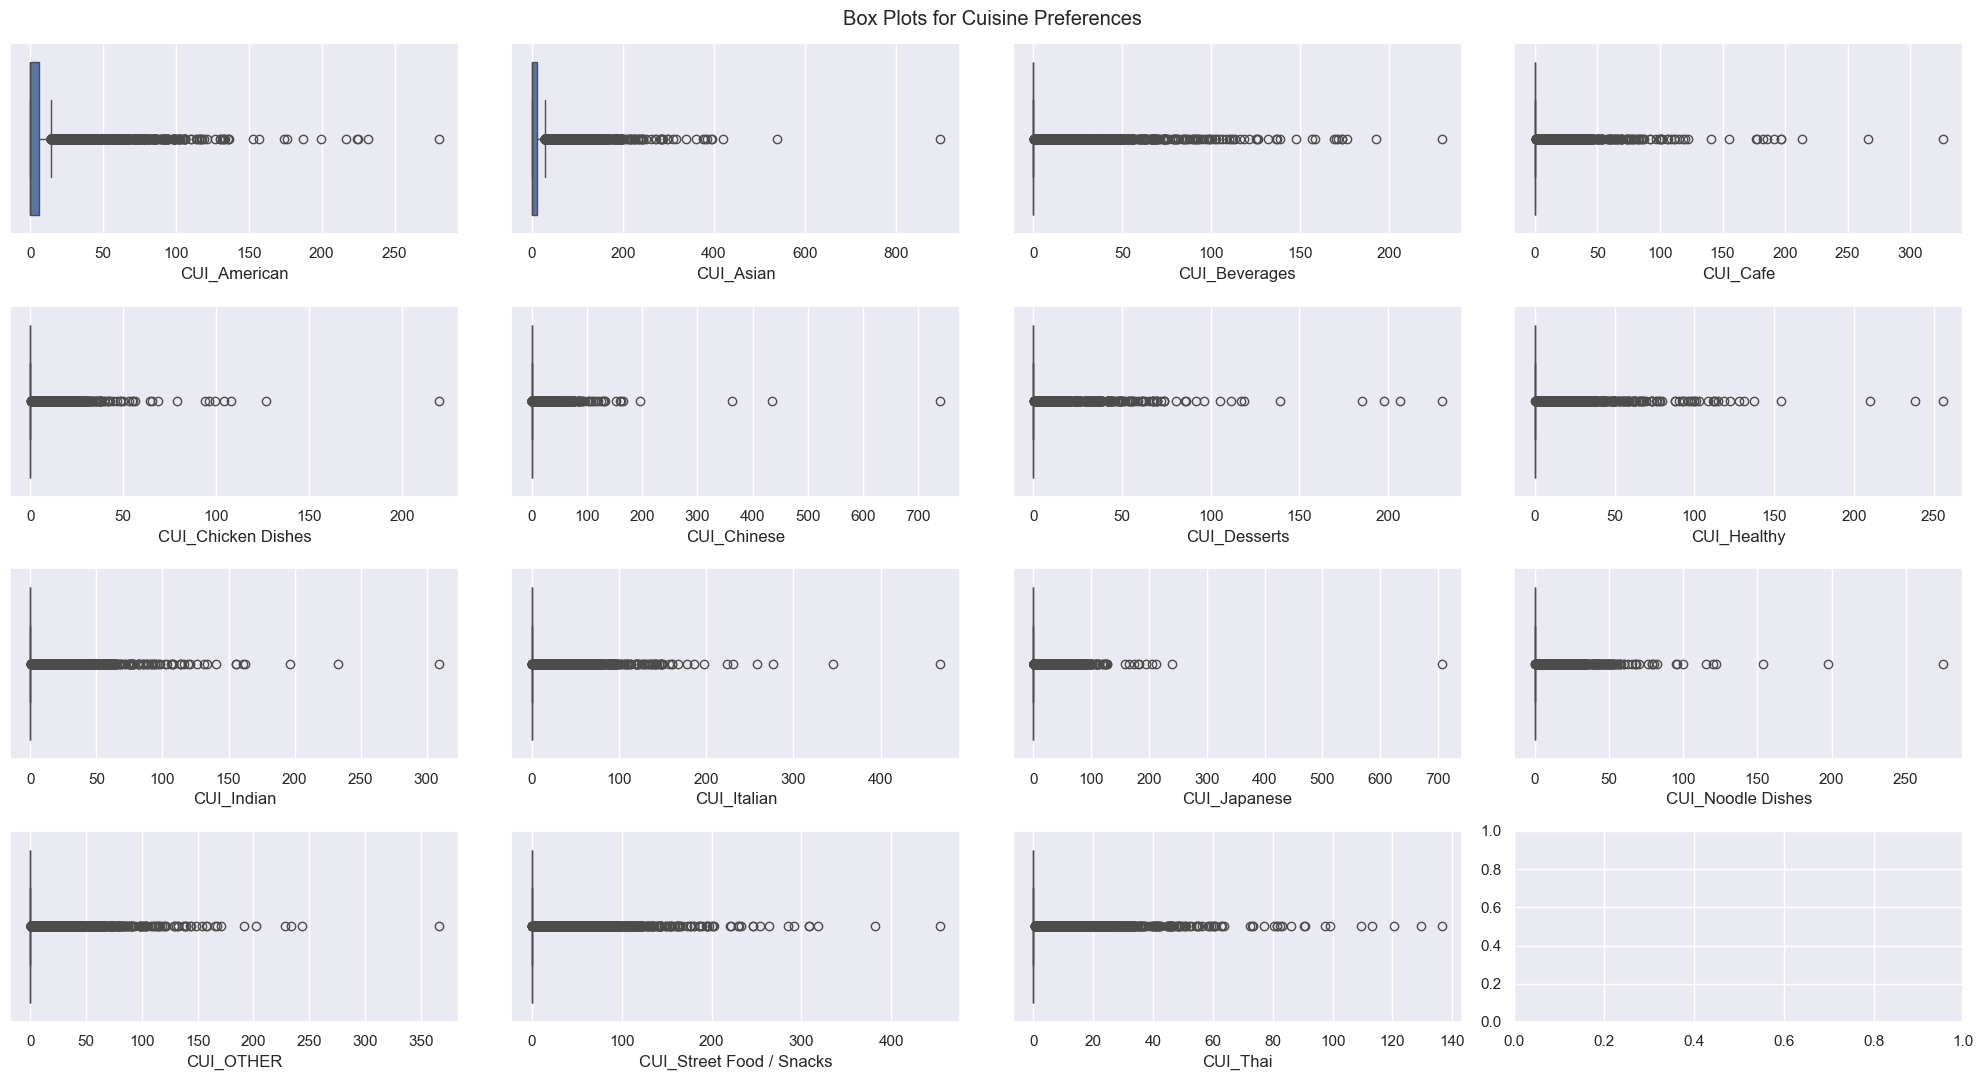

In [80]:
sns.set() 

sp_rows = 4
sp_cols = math.ceil(len(cui_columns) / sp_rows)



fig, axes = plt.subplots(sp_rows, 
                         sp_cols, 
                         figsize=(20, 11),
                         tight_layout=True
                        )


for ax, feat in zip(axes.flatten(), df[cui_columns]):
    sns.boxplot(x=df[feat], ax=ax)
    

title = "Box Plots for Cuisine Preferences"

plt.suptitle(title)

# if not os.path.exists(os.path.join('..', 'figures', 'eda')):
#     # if the eda directory is not present then create it first
#     os.makedirs(os.path.join('..', 'figures', 'eda'))


# plt.savefig(os.path.join('..', 'figures', 'eda', 'numeric_variables_boxplots.png'), dpi=200)


plt.show()

In [81]:
outlier_detection(df, cui_columns)

CUI_American: 
Number of extreme outliers: 1967 (56%) 
Number of moderate outliers: 1535 (43%) 
Total number of outliers: 3502
Q3 + 1.5*IQR = 14.15 
Q3 + 3*IQR = 22.64
Max: 280.21 
Min: 0.0 
95th percentil: 24.74
99th percentil: 53.43 

CUI_Asian: 
Number of extreme outliers: 1795 (51%) 
Number of moderate outliers: 1675 (48%) 
Total number of outliers: 3470
Q3 + 1.5*IQR = 29.58 
Q3 + 3*IQR = 47.32
Max: 896.71 
Min: 0.0 
95th percentil: 49.58
99th percentil: 106.12 

CUI_Beverages: 
Number of extreme outliers: 5423 (%) 
Number of moderate outliers: 0 (%) 
Total number of outliers: 5423
Q3 + 1.5*IQR = 0.0 
Q3 + 3*IQR = 0.0
Max: 229.22 
Min: 0.0 
95th percentil: 13.17
99th percentil: 37.9 

CUI_Cafe: 
Number of extreme outliers: 1363 (%) 
Number of moderate outliers: 0 (%) 
Total number of outliers: 1363
Q3 + 1.5*IQR = 0.0 
Q3 + 3*IQR = 0.0
Max: 326.1 
Min: 0.0 
95th percentil: 0.0
99th percentil: 21.79 

CUI_Chicken Dishes: 
Number of extreme outliers: 3246 (%) 
Number of moderate outli

### CUI_variables summary 
- Represents a continous variable (in a range from 0 to 897)
- These variables corresponds to the price that each customer spend on indicated cuisine type
- No NaN values, No hidden NaN values 
- There are a lot of rows that have 0 values, that means no monetary units have been spend on specific cuisine type.
- There are 138 customers that have not spend any monetary uni for any type of cuisine. 
- Most money people spend on Asian cuisine. Then on American and Street Fodd. The least is spend on Noodle and Chicken Dishes, Cafe, Thai, Desserts and Healthy cuisine.  
- In furher steps, it can be useful to create total spendings per customer for all cuisines and to create a binary variable that indicates if customer bought anything for specific type of cuisine


----

### 2.12 **`DOW_ variables`**

- These variables are integers.
- They represents a discrete numbers (from 0 to 20)
- There no missing values in these variables.
- DOW_ variables indicates the number of orders placed on each day of the week

In [82]:
dow_columns = ["DOW_1", "DOW_2", "DOW_3", "DOW_4", "DOW_5", "DOW_6", "DOW_0"]
day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

In [83]:
df[dow_columns].info()

<class 'pandas.core.frame.DataFrame'>
Index: 31828 entries, 1b8f824d5e to fd40d3b0e0
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   DOW_1   31828 non-null  int64
 1   DOW_2   31828 non-null  int64
 2   DOW_3   31828 non-null  int64
 3   DOW_4   31828 non-null  int64
 4   DOW_5   31828 non-null  int64
 5   DOW_6   31828 non-null  int64
 6   DOW_0   31828 non-null  int64
dtypes: int64(7)
memory usage: 3.0+ MB


In [84]:
df[dow_columns].describe()

DOW_1         DOW_2         DOW_3         DOW_4         DOW_5  \
count  31828.000000  31828.000000  31828.000000  31828.000000  31828.000000   
mean       0.567771      0.590801      0.619297      0.677957      0.652947   
std        1.044383      1.045672      1.069931      1.088231      1.069820   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        1.000000      1.000000      1.000000      1.000000      1.000000   
max       17.000000     15.000000     17.000000     16.000000     20.000000   

              DOW_6         DOW_0  
count  31828.000000  31828.000000  
mean       0.704254      0.555894  
std        1.167516      1.013460  
min        0.000000      0.000000  
25%        0.000000      0.000000  
50%        0.000000      0.000000  
75%        1.000000      1.000000  
max       20.000000     16.000000

In [85]:
for variable in df[dow_columns]:
    unique_v = df[variable].unique()
    print(f"Unique values for variable {variable} are: {unique_v}")

Unique values for variable DOW_1 are: [ 0  1  2  3  6  4  9  5 10  8  7 11 13 15 17 16 12]
Unique values for variable DOW_2 are: [ 0  1  2  3  4  9  5  7  6  8 15 14 10 11 12 13]
Unique values for variable DOW_3 are: [ 0  1  2  3  4  8  5  6  7  9 10 14 11 17 13 12 16]
Unique values for variable DOW_4 are: [ 0  1  2  3  6 10  4  7  5  8  9 11 14 12 13 15 16]
Unique values for variable DOW_5 are: [ 0  1  2  3  5  4 10  7  9  6  8 13 11 15 12 20 14]
Unique values for variable DOW_6 are: [ 1  2  3  4  7  9  6  5  8 10 11 17 13 12 14 20  0]
Unique values for variable DOW_0 are: [ 1  0  2  3  5  4  9  6  8 10  7 11 15 16]


In [86]:
df[dow_columns].isna().sum()

DOW_1    0
DOW_2    0
DOW_3    0
DOW_4    0
DOW_5    0
DOW_6    0
DOW_0    0
dtype: int64

There are no NaN values in the DOW_variables. DOW_variables are numerical in a range from 0 to 20

In [87]:
zero_counts_dow = {}

for column in dow_columns:
    zero_counts_dow[column] = (df[column] == 0).sum()

for column, count in zero_counts_dow.items():
    print(f"Number of 0 values for {column}: {count}")

Number of 0 values for DOW_1: 20523
Number of 0 values for DOW_2: 20077
Number of 0 values for DOW_3: 19596
Number of 0 values for DOW_4: 18362
Number of 0 values for DOW_5: 18758
Number of 0 values for DOW_6: 18480
Number of 0 values for DOW_0: 20598


In [88]:
percentage_dow = {}
for column, count in zero_counts_dow.items():
    percentage_dow[column] = round((count / 31888) * 100, 2)

# Sort the dictionary in ascending order
sorted_percentage_dow = dict(sorted(percentage_dow.items(), key=lambda x: x[1], reverse=True))

for key, value in sorted_percentage_dow.items():
    print(f"Percentage share of 0 values in {key}: {value}%")


Percentage share of 0 values in DOW_0: 64.59%
Percentage share of 0 values in DOW_1: 64.36%
Percentage share of 0 values in DOW_2: 62.96%
Percentage share of 0 values in DOW_3: 61.45%
Percentage share of 0 values in DOW_5: 58.82%
Percentage share of 0 values in DOW_6: 57.95%
Percentage share of 0 values in DOW_4: 57.58%


In [89]:
# Calulating how many rows (customers) there are that have not ordered during any of the week day
#Checking missing values 
rows_with_only_zeros_in_days = (df[dow_columns] == 0).all(axis=1)
num_rows_with_only_zeros_in_days = rows_with_only_zeros_in_days.sum()
num_rows_with_only_zeros_in_days
print(f"There are {num_rows_with_only_zeros_in_days} rows in total that have only 0 in dow variables")

There are 138 rows in total that have only 0 in dow variables


Countplot since it is categorical variable.

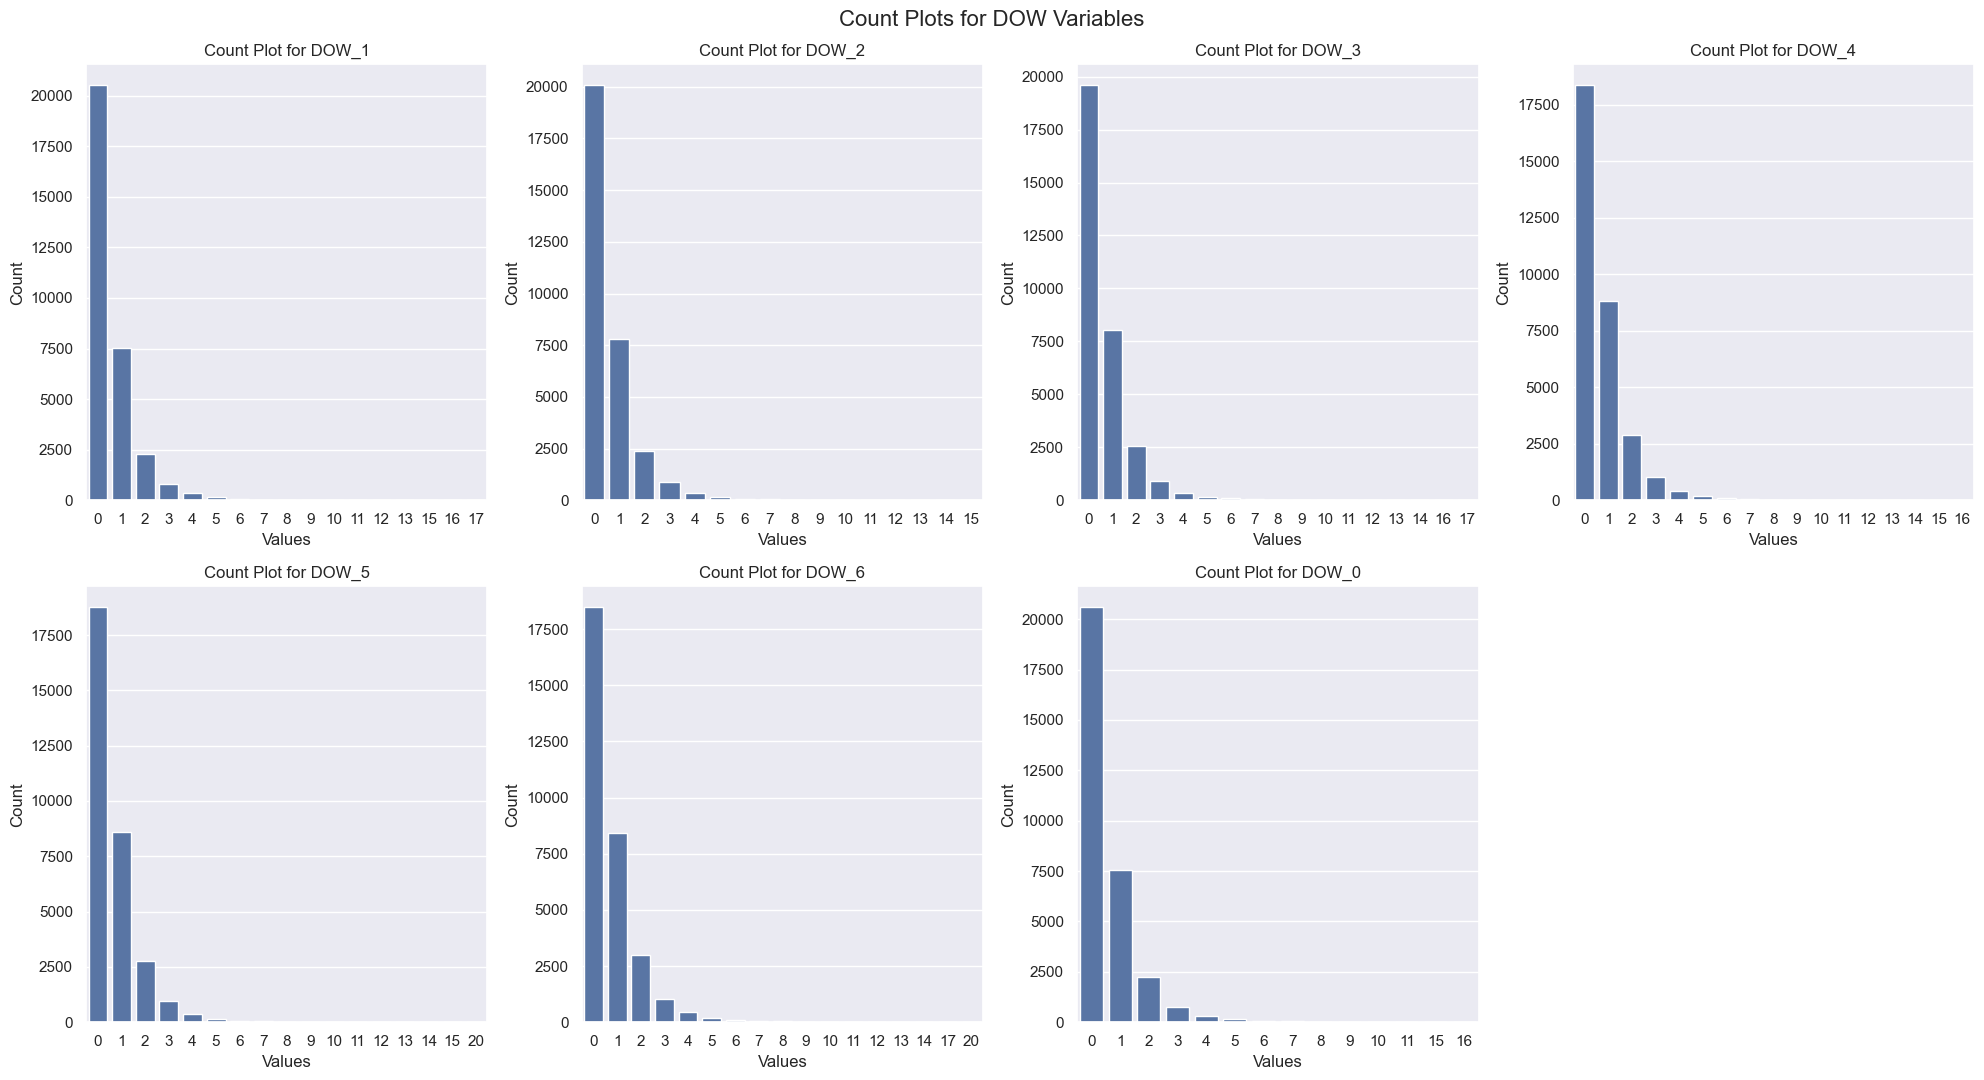

In [90]:
sp_rows = 2
sp_cols = math.ceil(len(dow_columns) / sp_rows)

# Create subplots
fig, axes = plt.subplots(sp_rows, sp_cols, figsize=(20, 11), tight_layout=True)

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Loop through each DOW column and create a countplot
for ax, column in zip(axes, dow_columns):
    sns.countplot(x=df[column], ax=ax)
    ax.set_title(f'Count Plot for {column}')  # Set title for each subplot
    ax.set_xlabel('Values')  # Label for x-axis
    ax.set_ylabel('Count')  # Label for y-axis

# If there are more axes than columns, hide the unused ones
for i in range(len(dow_columns), len(axes)):
    fig.delaxes(axes[i])

# Show the plot
plt.suptitle('Count Plots for DOW Variables', fontsize=16)
plt.show()


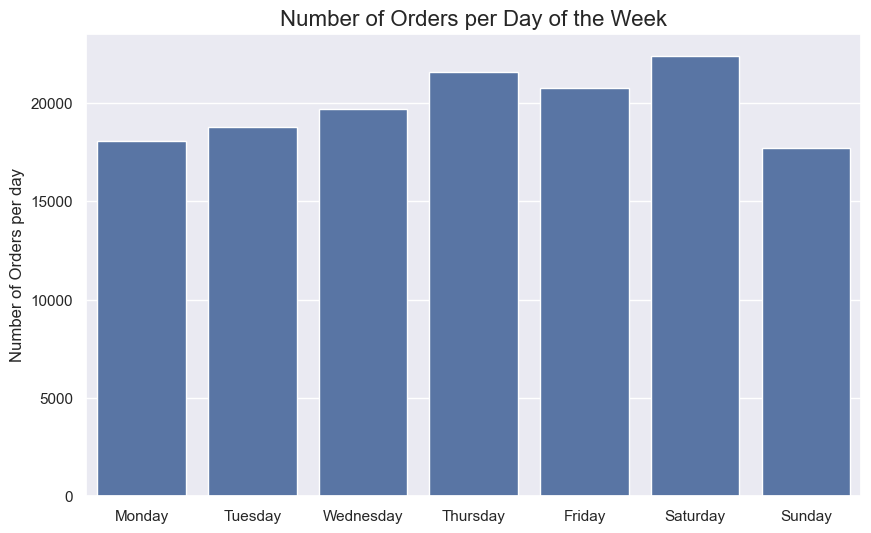

In [91]:
# Sum the values for each day of the week
dow_plot = df[dow_columns].sum()

# Create a new DataFrame for visualization
dow_counts = pd.DataFrame({
    'Day': day_names,
    'Number of Orders': dow_plot.values
})

# Create a count plot (using barplot here since we already have aggregated data)
plt.figure(figsize=(10, 6))
sns.barplot(x='Day', y='Number of Orders', data=dow_counts)

# Set the title and labels
plt.title('Number of Orders per Day of the Week', fontsize=16)
plt.xlabel('') 
plt.ylabel('Number of Orders per day', fontsize=12)
#plt.xticks(rotation=90)  

# Show the plot
plt.show()

**The highest number** of orders is placed on **Saturday** and **Thursday**. **The least orders** are on **Sundays**

In [92]:
dow_plot.describe()

count        7.000000
mean     19864.857143
std       1796.441615
min      17693.000000
25%      18437.500000
50%      19711.000000
75%      21180.000000
max      22415.000000
dtype: float64

In [93]:
print(f"The total number of orders is: {dow_plot.sum()}")

The total number of orders is: 139054


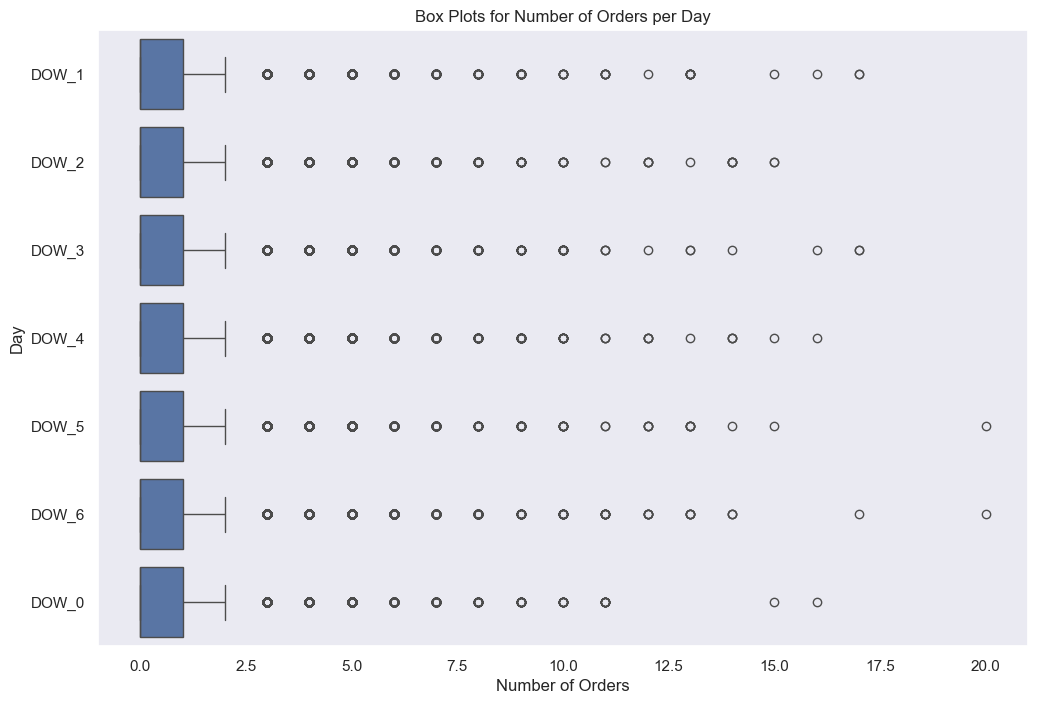

In [94]:
df_melted = df.melt(value_vars=dow_columns, var_name='Day', value_name='Number of Orders')

plt.figure(figsize=(12, 8))
sns.boxplot(y='Day', x='Number of Orders', data=df_melted)

plt.title('Box Plots for Number of Orders per Day')
plt.grid(axis='x')  
plt.show()


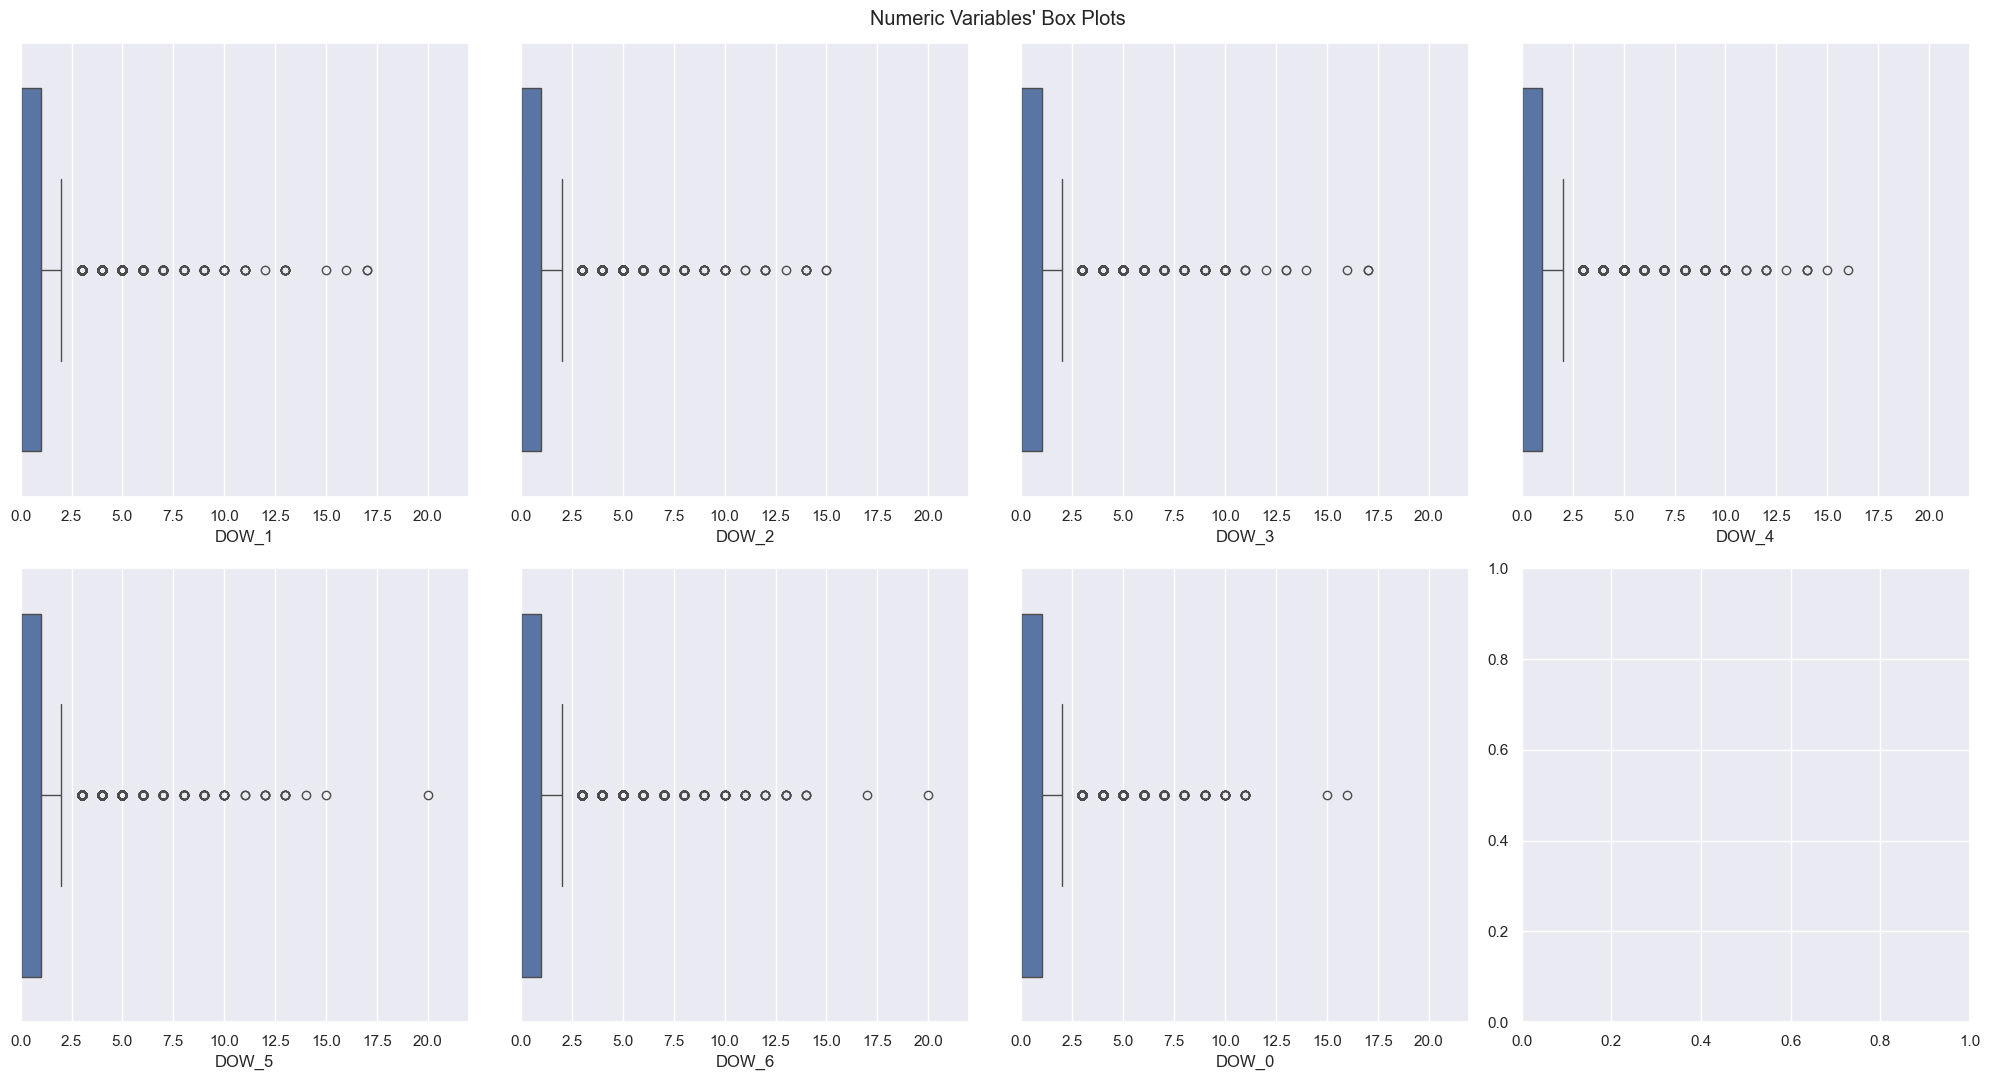

In [95]:
sns.set() #

## What do these do?
sp_rows = 2
sp_cols = math.ceil(len(dow_columns) / sp_rows)


# Prepare figure. Create individual axes where each histogram will be placed
fig, axes = plt.subplots(sp_rows, 
                         sp_cols, 
                         figsize=(20, 11),
                         tight_layout=True
                        )

# Plot data
# Iterate across axes objects and associate each histogram (hint: use the ax.hist() instead of plt.hist()):
for ax, feat in zip(axes.flatten(), df[dow_columns]): 
    sns.boxplot(x=df[feat], ax=ax)
    ax.set_xlim(0, 22)
# Layout
# Add a centered title to the figure:
title = "Numeric Variables' Box Plots"

plt.suptitle(title)

if not os.path.exists(os.path.join('..', 'figures', 'eda')):
    # if the eda directory is not present then create it first
    os.makedirs(os.path.join('..', 'figures', 'eda'))

plt.show()

In [96]:
outlier_detection(df, dow_columns)

DOW_1: 
Number of extreme outliers: 324 (28%) 
Number of moderate outliers: 810 (71%) 
Total number of outliers: 1134
Q3 + 1.5*IQR = 2.5 
Q3 + 3*IQR = 4.0
Max: 17 
Min: 0 
95th percentil: 2.0
99th percentil: 5.0 

DOW_2: 
Number of extreme outliers: 359 (28%) 
Number of moderate outliers: 893 (71%) 
Total number of outliers: 1252
Q3 + 1.5*IQR = 2.5 
Q3 + 3*IQR = 4.0
Max: 15 
Min: 0 
95th percentil: 2.0
99th percentil: 5.0 

DOW_3: 
Number of extreme outliers: 378 (29%) 
Number of moderate outliers: 909 (70%) 
Total number of outliers: 1287
Q3 + 1.5*IQR = 2.5 
Q3 + 3*IQR = 4.0
Max: 17 
Min: 0 
95th percentil: 3.0
99th percentil: 5.0 

DOW_4: 
Number of extreme outliers: 376 (27%) 
Number of moderate outliers: 1007 (72%) 
Total number of outliers: 1383
Q3 + 1.5*IQR = 2.5 
Q3 + 3*IQR = 4.0
Max: 16 
Min: 0 
95th percentil: 3.0
99th percentil: 5.0 

DOW_5: 
Number of extreme outliers: 347 (26%) 
Number of moderate outliers: 979 (73%) 
Total number of outliers: 1326
Q3 + 1.5*IQR = 2.5 
Q3 + 

## DOW_variables summary
- Represents a discrete variables (from 0 to 20)
- These variables corresponds to number of orders places each day of the week
- No NaN values, No hidden NaN values 
- There are a lot of rows that have 0 values, that means there were no orders placed
- Customers orders mostly on Saturdays and Thrusdays. The least orders are on Sundays and Mondays 
- There are 138 customers that have not placed any order in any day of the week (those are the same customers that were detected in the CUI_vairables)
- There are around 30% of customers that are potential outliers when it comes to total orders placed during a week.
- In the feature engineering step new variable: total order placed by each customer can be created


---

### 2.13 **`HR_ variables`**

- These variables are mostly integers (exception HR_0 which is float).
- They represents a discrete numbers (from 0 to 52)
- There no missing values only in HR_0 
- HR_ variables indicates the number of orders placed during each hour of the day

In [97]:
hr_columns = [element for element in df.columns if 'HR' in str(element)]
hr_values = [int(column.split('_')[1]) for column in hr_columns]

# Output the new list
print(hr_values)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]


In [98]:
df[hr_columns].info()

<class 'pandas.core.frame.DataFrame'>
Index: 31828 entries, 1b8f824d5e to fd40d3b0e0
Data columns (total 24 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   HR_0    30664 non-null  float64
 1   HR_1    31828 non-null  int64  
 2   HR_2    31828 non-null  int64  
 3   HR_3    31828 non-null  int64  
 4   HR_4    31828 non-null  int64  
 5   HR_5    31828 non-null  int64  
 6   HR_6    31828 non-null  int64  
 7   HR_7    31828 non-null  int64  
 8   HR_8    31828 non-null  int64  
 9   HR_9    31828 non-null  int64  
 10  HR_10   31828 non-null  int64  
 11  HR_11   31828 non-null  int64  
 12  HR_12   31828 non-null  int64  
 13  HR_13   31828 non-null  int64  
 14  HR_14   31828 non-null  int64  
 15  HR_15   31828 non-null  int64  
 16  HR_16   31828 non-null  int64  
 17  HR_17   31828 non-null  int64  
 18  HR_18   31828 non-null  int64  
 19  HR_19   31828 non-null  int64  
 20  HR_20   31828 non-null  int64  
 21  HR_21   31828 non-null  in

In [99]:
df[hr_columns].describe()

HR_0          HR_1          HR_2          HR_3          HR_4  \
count  30664.0  31828.000000  31828.000000  31828.000000  31828.000000   
mean       0.0      0.053726      0.063183      0.118386      0.101609   
std        0.0      0.316398      0.351663      0.497201      0.437411   
min        0.0      0.000000      0.000000      0.000000      0.000000   
25%        0.0      0.000000      0.000000      0.000000      0.000000   
50%        0.0      0.000000      0.000000      0.000000      0.000000   
75%        0.0      0.000000      0.000000      0.000000      0.000000   
max        0.0     14.000000     12.000000     11.000000     14.000000   

               HR_5          HR_6          HR_7          HR_8          HR_9  \
count  31828.000000  31828.000000  31828.000000  31828.000000  31828.000000   
mean       0.081846      0.069718      0.076756      0.131928      0.234259   
std        0.358645      0.329540      0.377581      0.635979      0.725483   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000000      0.000000      0.000000      0.000000      0.000000   
max        7.000000      8.000000     15.000000     52.000000     23.000000   

       ...         HR_14         HR_15         HR_16         HR_17  \
count  ...  31828.000000  31828.000000  31828.000000  31828.000000   
mean   ...      0.215408      0.276957      0.356321      0.391102   
std    ...      0.598255      0.738367      0.874181      0.944256   
min    ...      0.000000      0.000000      0.000000      0.000000   
25%    ...      0.000000      0.000000      0.000000      0.000000   
50%    ...      0.000000      0.000000      0.000000      0.000000   
75%    ...      0.000000      0.000000      0.000000      0.000000   
max    ...     13.000000     23.000000     22.000000     20.000000   

              HR_18         HR_19         HR_20         HR_21         HR_22  \
count  31828.000000  31828.000000  31828.000000  31828.000000  31828.000000   
mean       0.337125      0.245853      0.142799      0.071227      0.048228   
std        0.894446      0.795864      0.586876      0.348773      0.298032   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000000      0.000000      0.000000      0.000000      0.000000   
max       24.000000     35.000000     36.000000     11.000000     15.000000   

              HR_23  
count  31828.000000  
mean       0.045212  
std        0.282163  
min        0.000000  
25%        0.000000  
50%        0.000000  
75%        0.000000  
max       13.000000  

[8 rows x 24 columns]

In [100]:
for variable in df[hr_columns]:
    unique_v = df[variable].unique()
    print(f"Unique values for variable {variable} are: {unique_v}")

Unique values for variable HR_0 are: [ 0. nan]
Unique values for variable HR_1 are: [ 0  1  2  4  3  5  9  6  8 14  7]
Unique values for variable HR_2 are: [ 0  1  2  5  7  3 12  6  8 10  9  4]
Unique values for variable HR_3 are: [ 0  1  2  5  7  3  4  6  8 10 11  9]
Unique values for variable HR_4 are: [ 0  1  2 13  5 10  3  7  4 14  8  6  9]
Unique values for variable HR_5 are: [0 1 2 4 3 7 5]
Unique values for variable HR_6 are: [0 1 2 4 3 7 8 5 6]
Unique values for variable HR_7 are: [ 0  1  2  3  6  5  4  7 13 14  8 15  9]
Unique values for variable HR_8 are: [ 0  1  2  4  3  6  5 10  8  7 29 21 13 26 52 20  9 12]
Unique values for variable HR_9 are: [ 0  1  2  4  3  5  7  8  6  9 15 10 11 14 23 19 13]
Unique values for variable HR_10 are: [ 0  1  5  2  3  4  6 11  7  9  8 10 17 13 16 14 12 15 20 25]
Unique values for variable HR_11 are: [ 0  1  2  3  5  4 12  8 11 14  7  6  9 21 13 16 23 10 17 36]
Unique values for variable HR_12 are: [ 0  1  2  3  4 13  5  9 12  8  6  7 10 16 1

In [101]:
df[hr_columns].isna().sum()

HR_0     1164
HR_1        0
HR_2        0
HR_3        0
HR_4        0
HR_5        0
HR_6        0
HR_7        0
HR_8        0
HR_9        0
HR_10       0
HR_11       0
HR_12       0
HR_13       0
HR_14       0
HR_15       0
HR_16       0
HR_17       0
HR_18       0
HR_19       0
HR_20       0
HR_21       0
HR_22       0
HR_23       0
dtype: int64

There are 1164 missing values in the variable HR_0.

In [102]:
df[df['HR_0'].isna()]

customer_region  customer_age  vendor_count  product_count  \
customer_id                                                              
ae38da6386             8670          21.0             2              3   
a21a839c77             4140          19.0             1              4   
9237d23413             8670          22.0             3              4   
8c6ffd7357             4660          25.0             3              4   
67c6c9f9c4             4660          24.0             1              3   
...                     ...           ...           ...            ...   
37b72b449d             2360          23.0             1              4   
ac382ddfd1          Unknown          28.0             1              2   
96f1fc25e3             8670          25.0             2              2   
d7c7face7e             2440          26.0             1              1   
6624e03cdd             8670          28.0             1              2   

             is_chain  first_order  last_order last_promo payment_method  \
customer_id                                                                
ae38da6386          1            0           7   DELIVERY           DIGI   
a21a839c77          4            0          21    Unknown           CARD   
9237d23413          2            0          27    Unknown           CARD   
8c6ffd7357          1            0          28    Unknown           CARD   
67c6c9f9c4          0            0          36    FREEBIE           DIGI   
...               ...          ...         ...        ...            ...   
37b72b449d          0           85          85   DELIVERY           DIGI   
ac382ddfd1          2           87          89   DELIVERY           CARD   
96f1fc25e3          1           88          88   DELIVERY           CASH   
d7c7face7e          1           90          90   DELIVERY           CASH   
6624e03cdd          0         <NA>           0   DELIVERY           CARD   

             CUI_American  ...  HR_14  HR_15  HR_16  HR_17  HR_18  HR_19  \
customer_id                ...                                             
ae38da6386           0.00  ...      0      0      0      0      0      0   
a21a839c77           0.00  ...      0      0      0      0      0      1   
9237d23413           5.77  ...      0      0      0      0      0      0   
8c6ffd7357          27.54  ...      0      1      0      0      0      0   
67c6c9f9c4           0.00  ...      1      0      0      0      0      0   
...                   ...  ...    ...    ...    ...    ...    ...    ...   
37b72b449d           0.00  ...      0      0      0      0      0      0   
ac382ddfd1           0.00  ...      0      0      0      0      0      0   
96f1fc25e3           0.00  ...      0      0      0      0      0      0   
d7c7face7e           2.61  ...      0      0      0      0      0      0   
6624e03cdd          23.83  ...      0      0      0      0      0      0   

             HR_20  HR_21  HR_22  HR_23  
customer_id                              
ae38da6386       0      0      0      0  
a21a839c77       0      0      1      0  
9237d23413       0      0      0      0  
8c6ffd7357       0      0      0      0  
67c6c9f9c4       0      1      0      0  
...            ...    ...    ...    ...  
37b72b449d       0      0      0      0  
ac382ddfd1       0      0      0      1  
96f1fc25e3       0      0      0      0  
d7c7face7e       0      0      0      0  
6624e03cdd       0      0      0      0  

[1164 rows x 55 columns]

In [103]:
zero_counts_hr = {}

for column in hr_columns:
    zero_counts_hr[column] = (df[column] == 0).sum()

for column, count in zero_counts_hr.items():
    print(f"Number of 0 values for {column}: {count}")

Number of 0 values for HR_0: 30664
Number of 0 values for HR_1: 30548
Number of 0 values for HR_2: 30340
Number of 0 values for HR_3: 29308
Number of 0 values for HR_4: 29466
Number of 0 values for HR_5: 29807
Number of 0 values for HR_6: 30078
Number of 0 values for HR_7: 29936
Number of 0 values for HR_8: 28880
Number of 0 values for HR_9: 26906
Number of 0 values for HR_10: 25239
Number of 0 values for HR_11: 24306
Number of 0 values for HR_12: 25342
Number of 0 values for HR_13: 26382
Number of 0 values for HR_14: 26733
Number of 0 values for HR_15: 25803
Number of 0 values for HR_16: 24700
Number of 0 values for HR_17: 24228
Number of 0 values for HR_18: 25148
Number of 0 values for HR_19: 26942
Number of 0 values for HR_20: 28769
Number of 0 values for HR_21: 30070
Number of 0 values for HR_22: 30649
Number of 0 values for HR_23: 30706


In [104]:
percentage_hr = {}
for column, count in zero_counts_hr.items():
    percentage_hr[column] = round((count / 31888) * 100, 2)

# Sort the dictionary in ascending order
sorted_percentage_hr = dict(sorted(percentage_hr.items(), key=lambda x: x[1], reverse=True))

for key, value in sorted_percentage_hr.items():
    print(f"Percentage share of 0 values in {key}: {value}%")


Percentage share of 0 values in HR_23: 96.29%
Percentage share of 0 values in HR_0: 96.16%
Percentage share of 0 values in HR_22: 96.11%
Percentage share of 0 values in HR_1: 95.8%
Percentage share of 0 values in HR_2: 95.15%
Percentage share of 0 values in HR_6: 94.32%
Percentage share of 0 values in HR_21: 94.3%
Percentage share of 0 values in HR_7: 93.88%
Percentage share of 0 values in HR_5: 93.47%
Percentage share of 0 values in HR_4: 92.4%
Percentage share of 0 values in HR_3: 91.91%
Percentage share of 0 values in HR_8: 90.57%
Percentage share of 0 values in HR_20: 90.22%
Percentage share of 0 values in HR_19: 84.49%
Percentage share of 0 values in HR_9: 84.38%
Percentage share of 0 values in HR_14: 83.83%
Percentage share of 0 values in HR_13: 82.73%
Percentage share of 0 values in HR_15: 80.92%
Percentage share of 0 values in HR_12: 79.47%
Percentage share of 0 values in HR_10: 79.15%
Percentage share of 0 values in HR_18: 78.86%
Percentage share of 0 values in HR_16: 77.46%
P

In [105]:
# Calulating how many rows (customers) there are that have not ordered during any of the hour day
#Checking missing values 
rows_with_only_zeros_in_hours = (df[dow_columns] == 0).all(axis=1)
num_rows_with_only_zeros_in_hours = rows_with_only_zeros_in_hours.sum()
num_rows_with_only_zeros_in_hours
print(f"There are {num_rows_with_only_zeros_in_hours} rows in total that have only 0 in HR variables")

There are 138 rows in total that have only 0 in HR variables


In [106]:
new_df = df[rows_with_only_zeros_in_hours]
new_df

customer_region  customer_age  vendor_count  product_count  \
customer_id                                                              
4903041977             8670          22.0             0              0   
c94b288475             8670          26.0             0              0   
f687717dc1             8670          21.0             0              0   
c6cf0b76fb             8670          38.0             0              0   
1b7c34738e             8670          24.0             0              0   
...                     ...           ...           ...            ...   
177ede2420             8670          30.0             0              0   
0039059c9c             8670          22.0             0              0   
0e60632fe2             8670          23.0             0              0   
28ed1f1e3f             8670          20.0             0              0   
4c06e104de             8670          25.0             0              0   

             is_chain  first_order  last_order last_promo payment_method  \
customer_id                                                                
4903041977          1            1           1   DELIVERY           DIGI   
c94b288475          0            1           1   DELIVERY           CASH   
f687717dc1          1            1           1   DELIVERY           DIGI   
c6cf0b76fb          0            2           2   DELIVERY           CASH   
1b7c34738e          0            3           3    Unknown           CASH   
...               ...          ...         ...        ...            ...   
177ede2420          1           86          86    Unknown           DIGI   
0039059c9c          1           88          88   DISCOUNT           CARD   
0e60632fe2          0           89          89   DISCOUNT           CARD   
28ed1f1e3f          0           89          89   DELIVERY           DIGI   
4c06e104de          1           89          89    Unknown           CASH   

             CUI_American  ...  HR_14  HR_15  HR_16  HR_17  HR_18  HR_19  \
customer_id                ...                                             
4903041977            0.0  ...      0      0      0      0      0      0   
c94b288475            0.0  ...      0      0      0      0      0      0   
f687717dc1            0.0  ...      0      0      0      0      0      0   
c6cf0b76fb            0.0  ...      0      0      0      0      0      0   
1b7c34738e            0.0  ...      0      0      0      0      0      0   
...                   ...  ...    ...    ...    ...    ...    ...    ...   
177ede2420            0.0  ...      0      0      0      0      0      0   
0039059c9c            0.0  ...      0      0      0      0      0      0   
0e60632fe2            0.0  ...      0      0      0      0      0      0   
28ed1f1e3f            0.0  ...      0      0      0      0      0      0   
4c06e104de            0.0  ...      0      0      0      0      0      0   

             HR_20  HR_21  HR_22  HR_23  
customer_id                              
4903041977       0      0      0      0  
c94b288475       0      0      0      0  
f687717dc1       0      0      0      0  
c6cf0b76fb       0      0      0      0  
1b7c34738e       0      0      0      0  
...            ...    ...    ...    ...  
177ede2420       0      0      0      0  
0039059c9c       0      0      0      0  
0e60632fe2       0      0      0      0  
28ed1f1e3f       0      0      0      0  
4c06e104de       0      0      0      0  

[138 rows x 55 columns]

In [107]:
for variable in new_df[hr_columns]:
    unique_v = new_df[variable].unique()
    print(f"Unique values for variable {variable} are: {unique_v}")

Unique values for variable HR_0 are: [0.]
Unique values for variable HR_1 are: [0]
Unique values for variable HR_2 are: [0]
Unique values for variable HR_3 are: [0]
Unique values for variable HR_4 are: [0]
Unique values for variable HR_5 are: [0]
Unique values for variable HR_6 are: [0]
Unique values for variable HR_7 are: [0]
Unique values for variable HR_8 are: [0]
Unique values for variable HR_9 are: [0]
Unique values for variable HR_10 are: [0]
Unique values for variable HR_11 are: [0]
Unique values for variable HR_12 are: [0]
Unique values for variable HR_13 are: [0]
Unique values for variable HR_14 are: [0]
Unique values for variable HR_15 are: [0]
Unique values for variable HR_16 are: [0]
Unique values for variable HR_17 are: [0]
Unique values for variable HR_18 are: [0]
Unique values for variable HR_19 are: [0]
Unique values for variable HR_20 are: [0]
Unique values for variable HR_21 are: [0]
Unique values for variable HR_22 are: [0]
Unique values for variable HR_23 are: [0]


In [108]:
for variable in new_df[dow_columns]:
    unique_v = new_df[variable].unique()
    print(f"Unique values for variable {variable} are: {unique_v}")


Unique values for variable DOW_1 are: [0]
Unique values for variable DOW_2 are: [0]
Unique values for variable DOW_3 are: [0]
Unique values for variable DOW_4 are: [0]
Unique values for variable DOW_5 are: [0]
Unique values for variable DOW_6 are: [0]
Unique values for variable DOW_0 are: [0]


In [109]:
for variable in new_df[cui_columns]:
    unique_v = new_df[variable].unique()
    print(f"Unique values for variable {variable} are: {unique_v}")

Unique values for variable CUI_American are: [0.]
Unique values for variable CUI_Asian are: [0.]
Unique values for variable CUI_Beverages are: [0.]
Unique values for variable CUI_Cafe are: [0.]
Unique values for variable CUI_Chicken Dishes are: [0.]
Unique values for variable CUI_Chinese are: [0.]
Unique values for variable CUI_Desserts are: [0.]
Unique values for variable CUI_Healthy are: [0.]
Unique values for variable CUI_Indian are: [0.]
Unique values for variable CUI_Italian are: [0.]
Unique values for variable CUI_Japanese are: [0.]
Unique values for variable CUI_Noodle Dishes are: [0.]
Unique values for variable CUI_OTHER are: [0.]
Unique values for variable CUI_Street Food / Snacks are: [0.]
Unique values for variable CUI_Thai are: [0.]


Check for the rows that all HR values are equal to 0. We find out that for the same rows also DOW variables and CUI variables are equal to 0. Analysis made above.

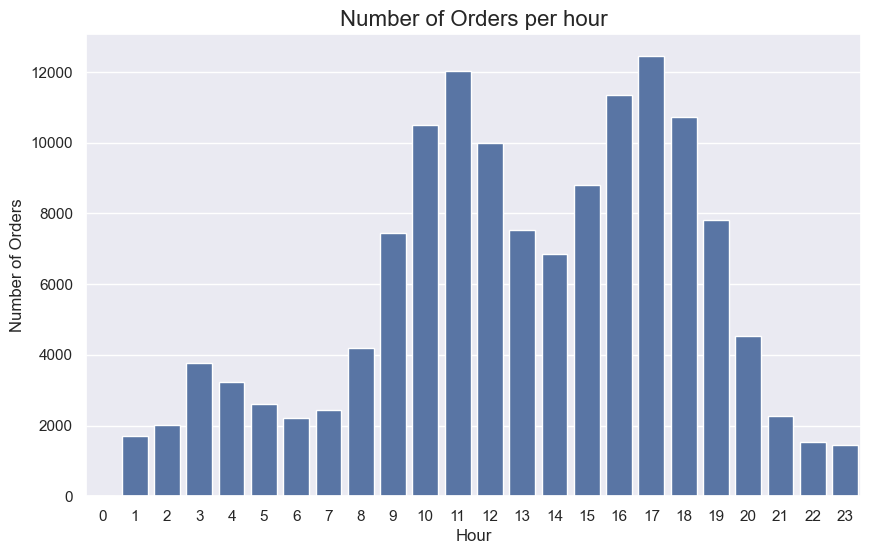

In [110]:
# Sum the values for each day of the week
hr_plot = df[hr_columns].sum()

# Create a new DataFrame for visualization
hr_counts = pd.DataFrame({
    'Hour': hr_values,
    'Number of Orders': hr_plot.values
})

# Create a count plot (using barplot here since we already have aggregated data)
plt.figure(figsize=(10, 6))
sns.barplot(x='Hour', y='Number of Orders', data=hr_counts)

# Set the title and labels
plt.title('Number of Orders per hour', fontsize=16)
plt.xlabel('Hour', fontsize=12)
plt.ylabel('Number of Orders', fontsize=12)
#plt.xticks(rotation=90)  # Rotate x-tick labels if needed

# Show the plot
plt.show()


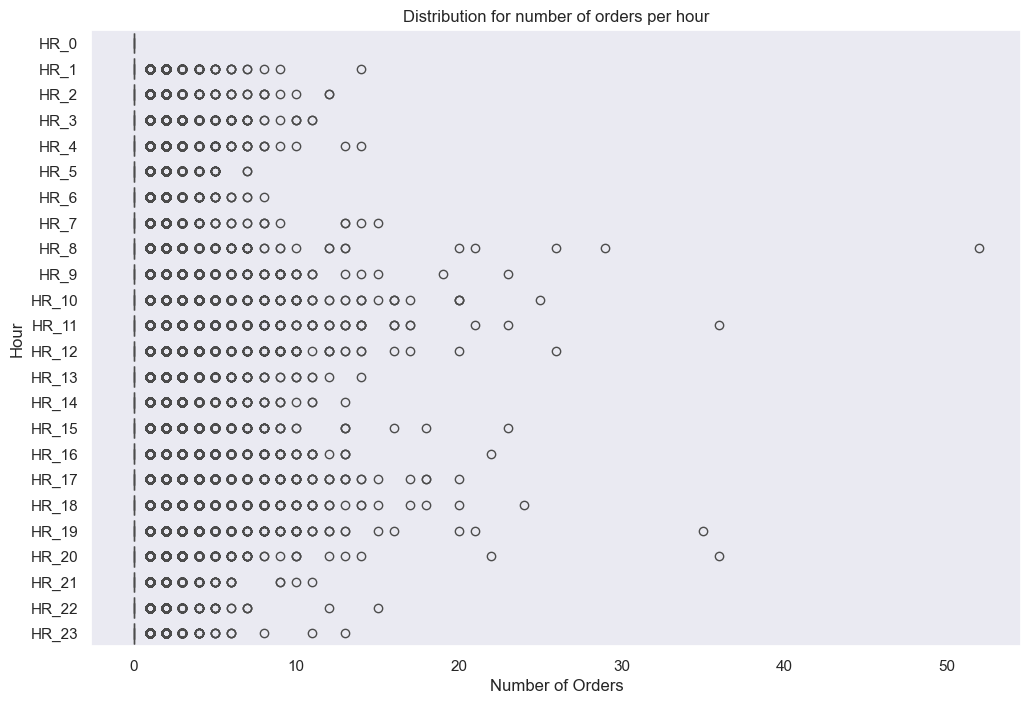

In [111]:
df_melted = df.melt(value_vars=hr_columns, var_name='Hour', value_name='Number of Orders')

# Create a transposed box plot
plt.figure(figsize=(12, 8))
sns.boxplot(y='Hour', x='Number of Orders', data=df_melted)

plt.title('Distribution for number of orders per hour')
plt.grid(axis='x') 
# plt.xticks(rotation=90) 
plt.show()



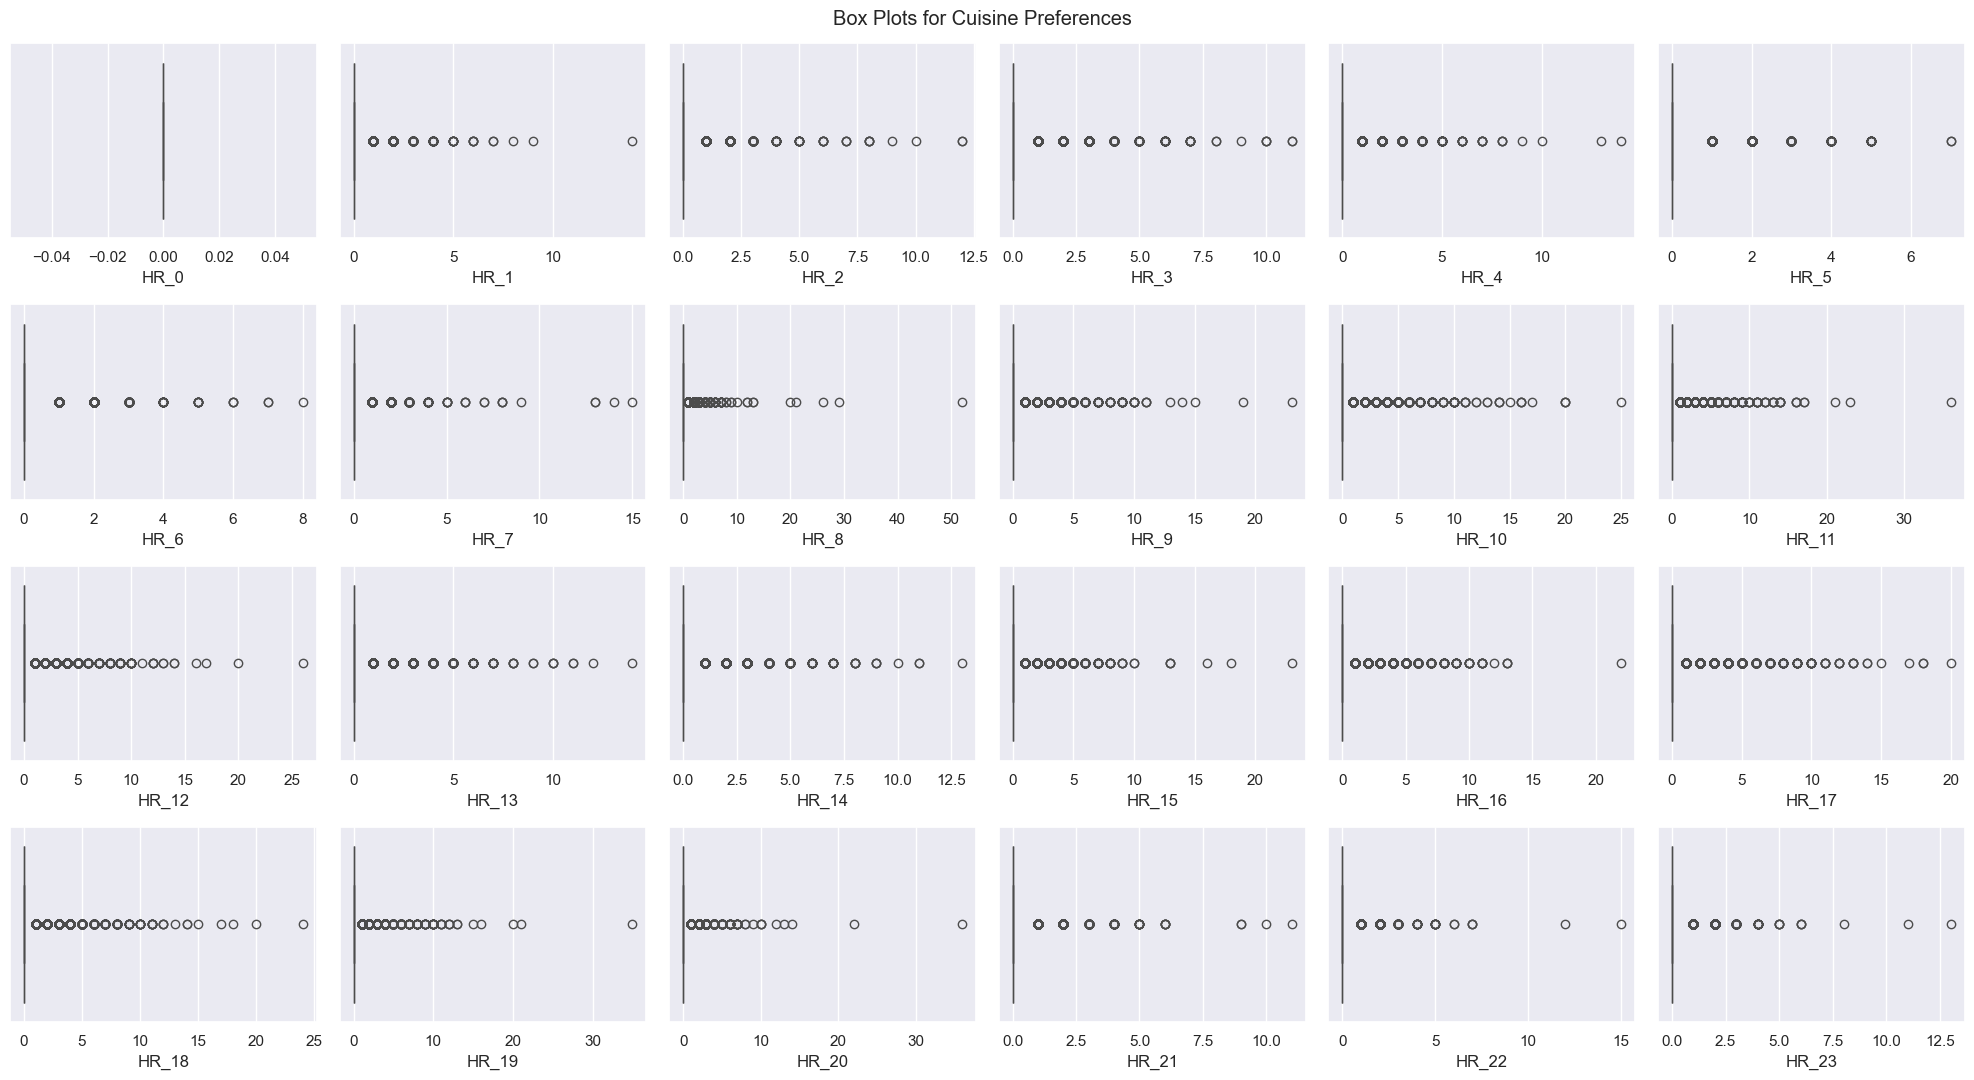

In [112]:
# Plot ALL Numeric Variables' Histograms in one figure

sns.set() ## Reset to darkgrid

## What do these do?
sp_rows = 4
sp_cols = math.ceil(len(hr_columns) / sp_rows)


# Prepare figure. Create individual axes where each histogram will be placed
fig, axes = plt.subplots(sp_rows, 
                         sp_cols, 
                         figsize=(20, 11),
                         tight_layout=True
                        )

# Plot data
# Iterate across axes objects and associate each histogram (hint: use the ax.hist() instead of plt.hist()):
for ax, feat in zip(axes.flatten(), df[hr_columns]): # Notice the zip() function and flatten() method
    sns.boxplot(x=df[feat], ax=ax)
    
# Layout
# Add a centered title to the figure:
title = "Box Plots for Cuisine Preferences"

plt.suptitle(title)
plt.show()

In [113]:
outlier_detection(df, hr_columns)

HR_0: 
Number of extreme outliers: 0 (%) 
Number of moderate outliers: 0 (%) 
Total number of outliers: 0
Q3 + 1.5*IQR = 0.0 
Q3 + 3*IQR = 0.0
Max: 0.0 
Min: 0.0 
95th percentil: 0.0
99th percentil: 0.0 

HR_1: 
Number of extreme outliers: 1280 (%) 
Number of moderate outliers: 0 (%) 
Total number of outliers: 1280
Q3 + 1.5*IQR = 0.0 
Q3 + 3*IQR = 0.0
Max: 14 
Min: 0 
95th percentil: 0.0
99th percentil: 1.0 

HR_2: 
Number of extreme outliers: 1488 (%) 
Number of moderate outliers: 0 (%) 
Total number of outliers: 1488
Q3 + 1.5*IQR = 0.0 
Q3 + 3*IQR = 0.0
Max: 12 
Min: 0 
95th percentil: 0.0
99th percentil: 1.0 

HR_3: 
Number of extreme outliers: 2520 (%) 
Number of moderate outliers: 0 (%) 
Total number of outliers: 2520
Q3 + 1.5*IQR = 0.0 
Q3 + 3*IQR = 0.0
Max: 11 
Min: 0 
95th percentil: 1.0
99th percentil: 2.0 

HR_4: 
Number of extreme outliers: 2362 (%) 
Number of moderate outliers: 0 (%) 
Total number of outliers: 2362
Q3 + 1.5*IQR = 0.0 
Q3 + 3*IQR = 0.0
Max: 14 
Min: 0 
95th 

## HR_variables summary

- Represents a discrete values 
- These variables corresponds to the number of orders placed during each hour of the day
- There are only missing values in the variable HR_0. That variable contains only 0 and NaN values. 
- There are a lot of rows that have 0 values, that means no order were placed during several hours.
- People order most around the time of their lunch (around 11 am) and after work (around 5 pm).
- There are 138 customers that have not order anything during whole day. Those rows have null values also for DOW and CUI columns
- For the feautre engineering process we consider creating new variable with total orders during a day per customer. Moreover, we want to create a variable that will have 4 categories indicating how many orders were placed in the morning, afternoon, evening and at night to reduce number of HR_variables.

---

### **`Overview of individual analyzis`**

### General Notes
1. Going to group numerical features into different groups and plot their histogram and boxplot together
2. Plot the barplot for all the categorical features together 

### Groups defined
1. 'customer_age', 'vendor_count', 'product_count', 'is_chain', 'first_order' and 'last_order' 
2. CUI features
3. DOW features
4. HR features

Ploting all histograms for ***group 1***

In [114]:
columns_group_1 = ['customer_age', 'vendor_count', 'product_count', 'is_chain', 'first_order', 'last_order']

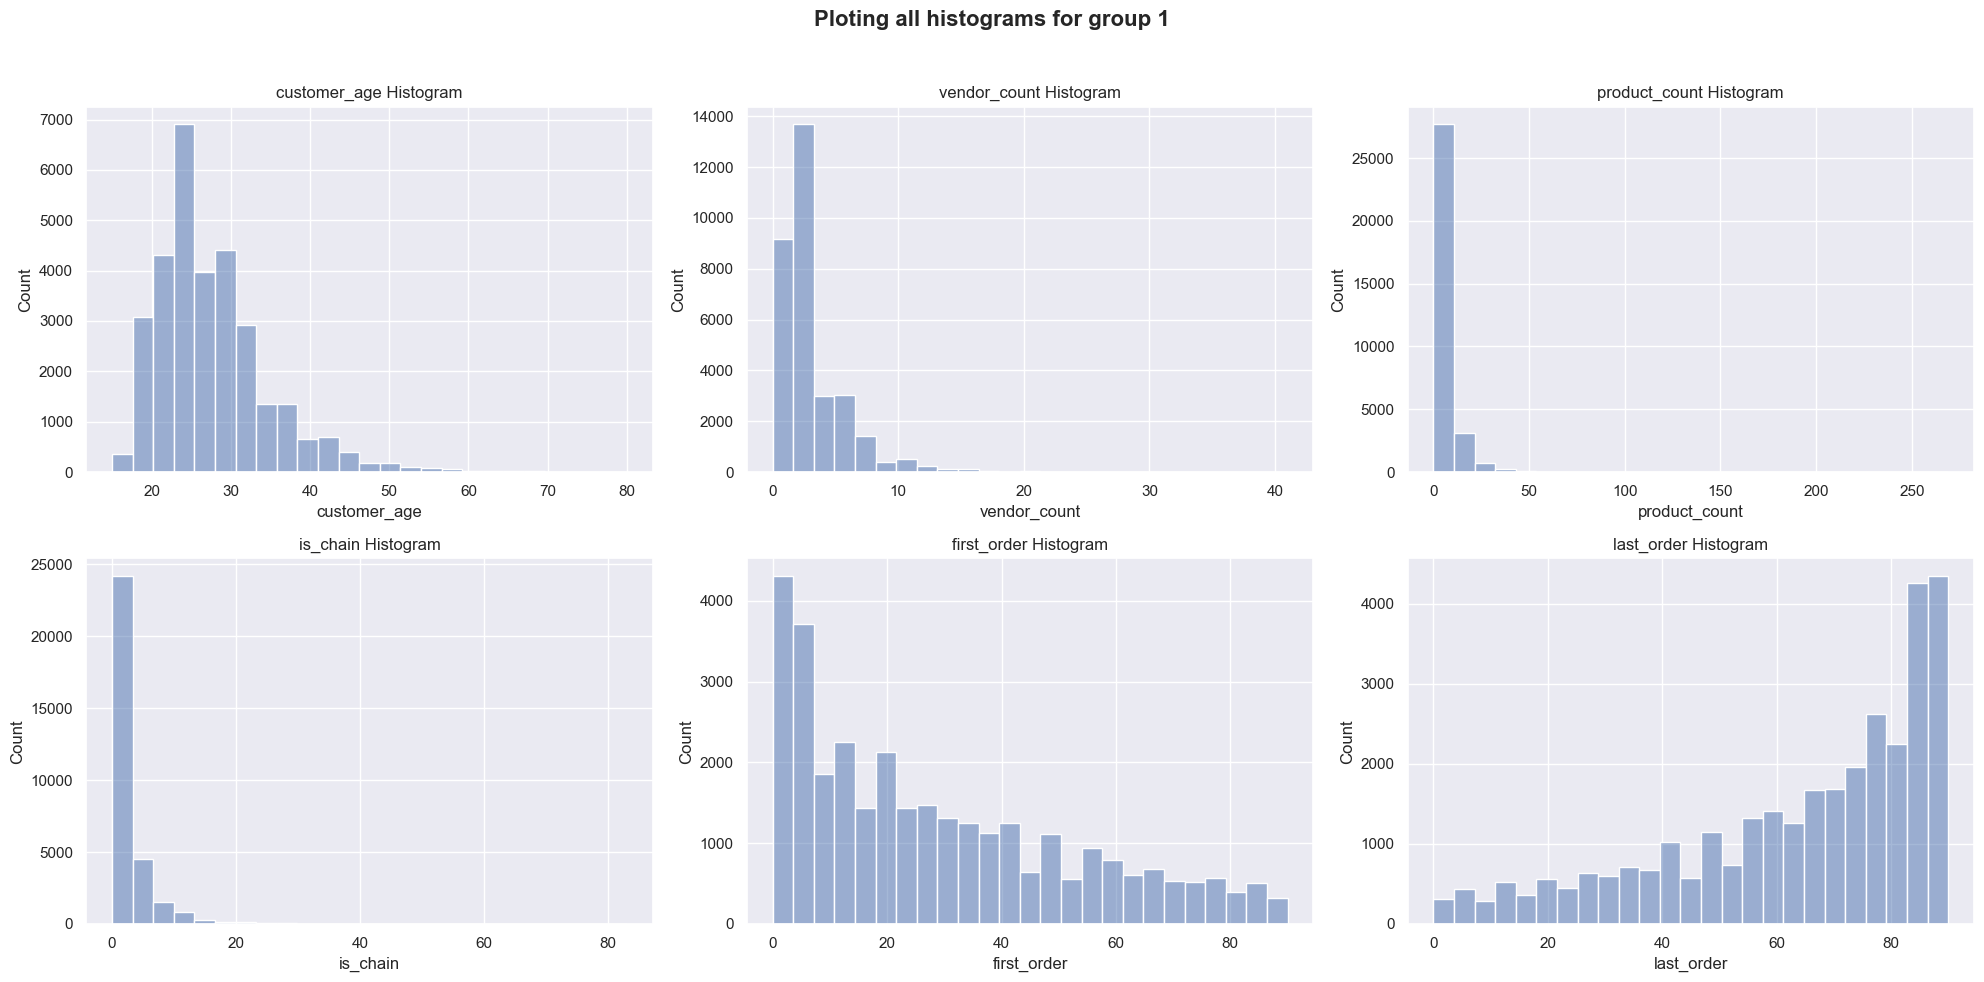

In [115]:
fig, axes = plt.subplots(2, 3, figsize=(20, 10))

# Loop through each feature and plot histograms
for i, feature in enumerate(columns_group_1):
    ax = axes[i // 3, i % 3]

    #sns.histplot(df[feature], kde=True, color=palette[5], ax=ax, alpha=0.5)
    sns.histplot(df[feature], kde=False, ax=ax, alpha=0.5, bins=25)
    
    # Set titles
    ax.set_title(f"{feature} Histogram")

# Adding overall title
plt.suptitle("Ploting all histograms for group 1", fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

Ploting all boxplots for ***group 1***

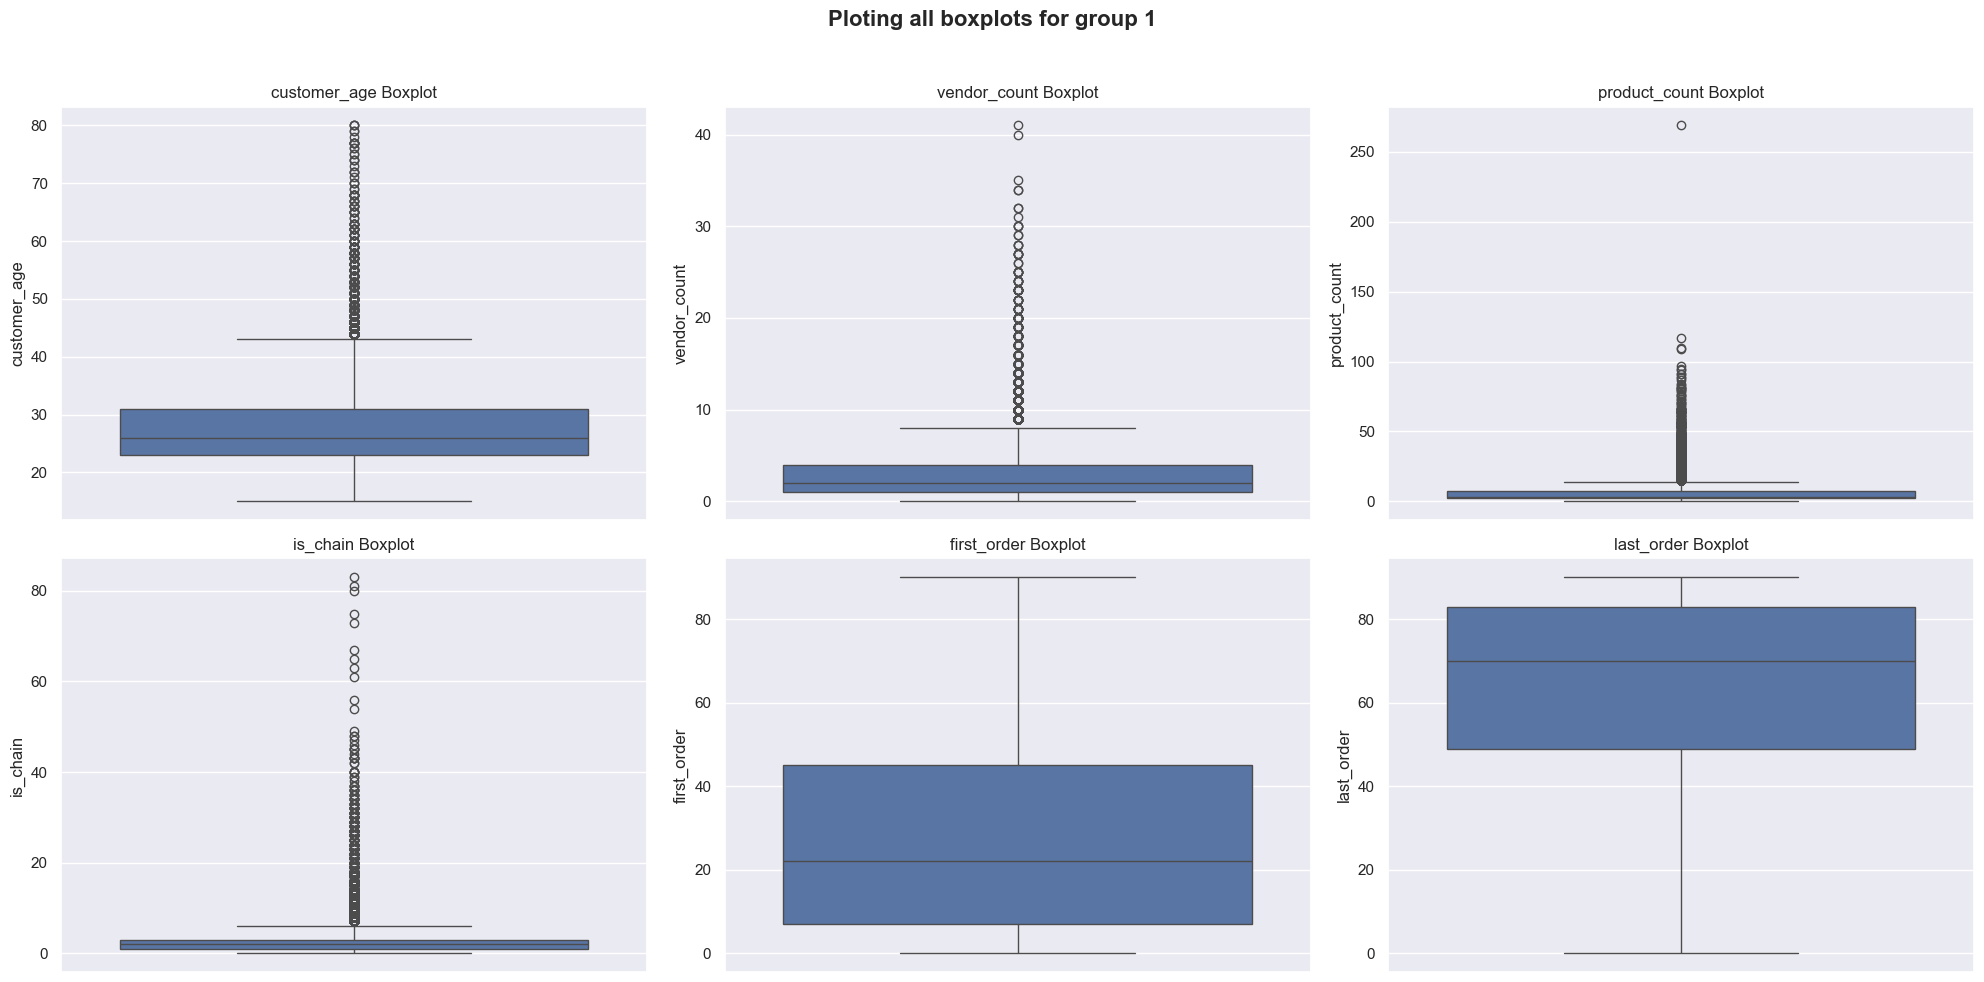

In [116]:
fig, axes = plt.subplots(2, 3, figsize=(20, 10))

# Loop through each feature and plot boxplots
for i, feature in enumerate(columns_group_1):
    ax = axes[i // 3, i % 3]

    #sns.histplot(df[feature], kde=True, color=palette[5], ax=ax, alpha=0.5)
    sns.boxplot(data=df[feature], ax=ax)
    
    # Set titles
    ax.set_title(f"{feature} Boxplot")

# Adding overall title
plt.suptitle("Ploting all boxplots for group 1", fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

Ploting all histograms for ***CUI variables***

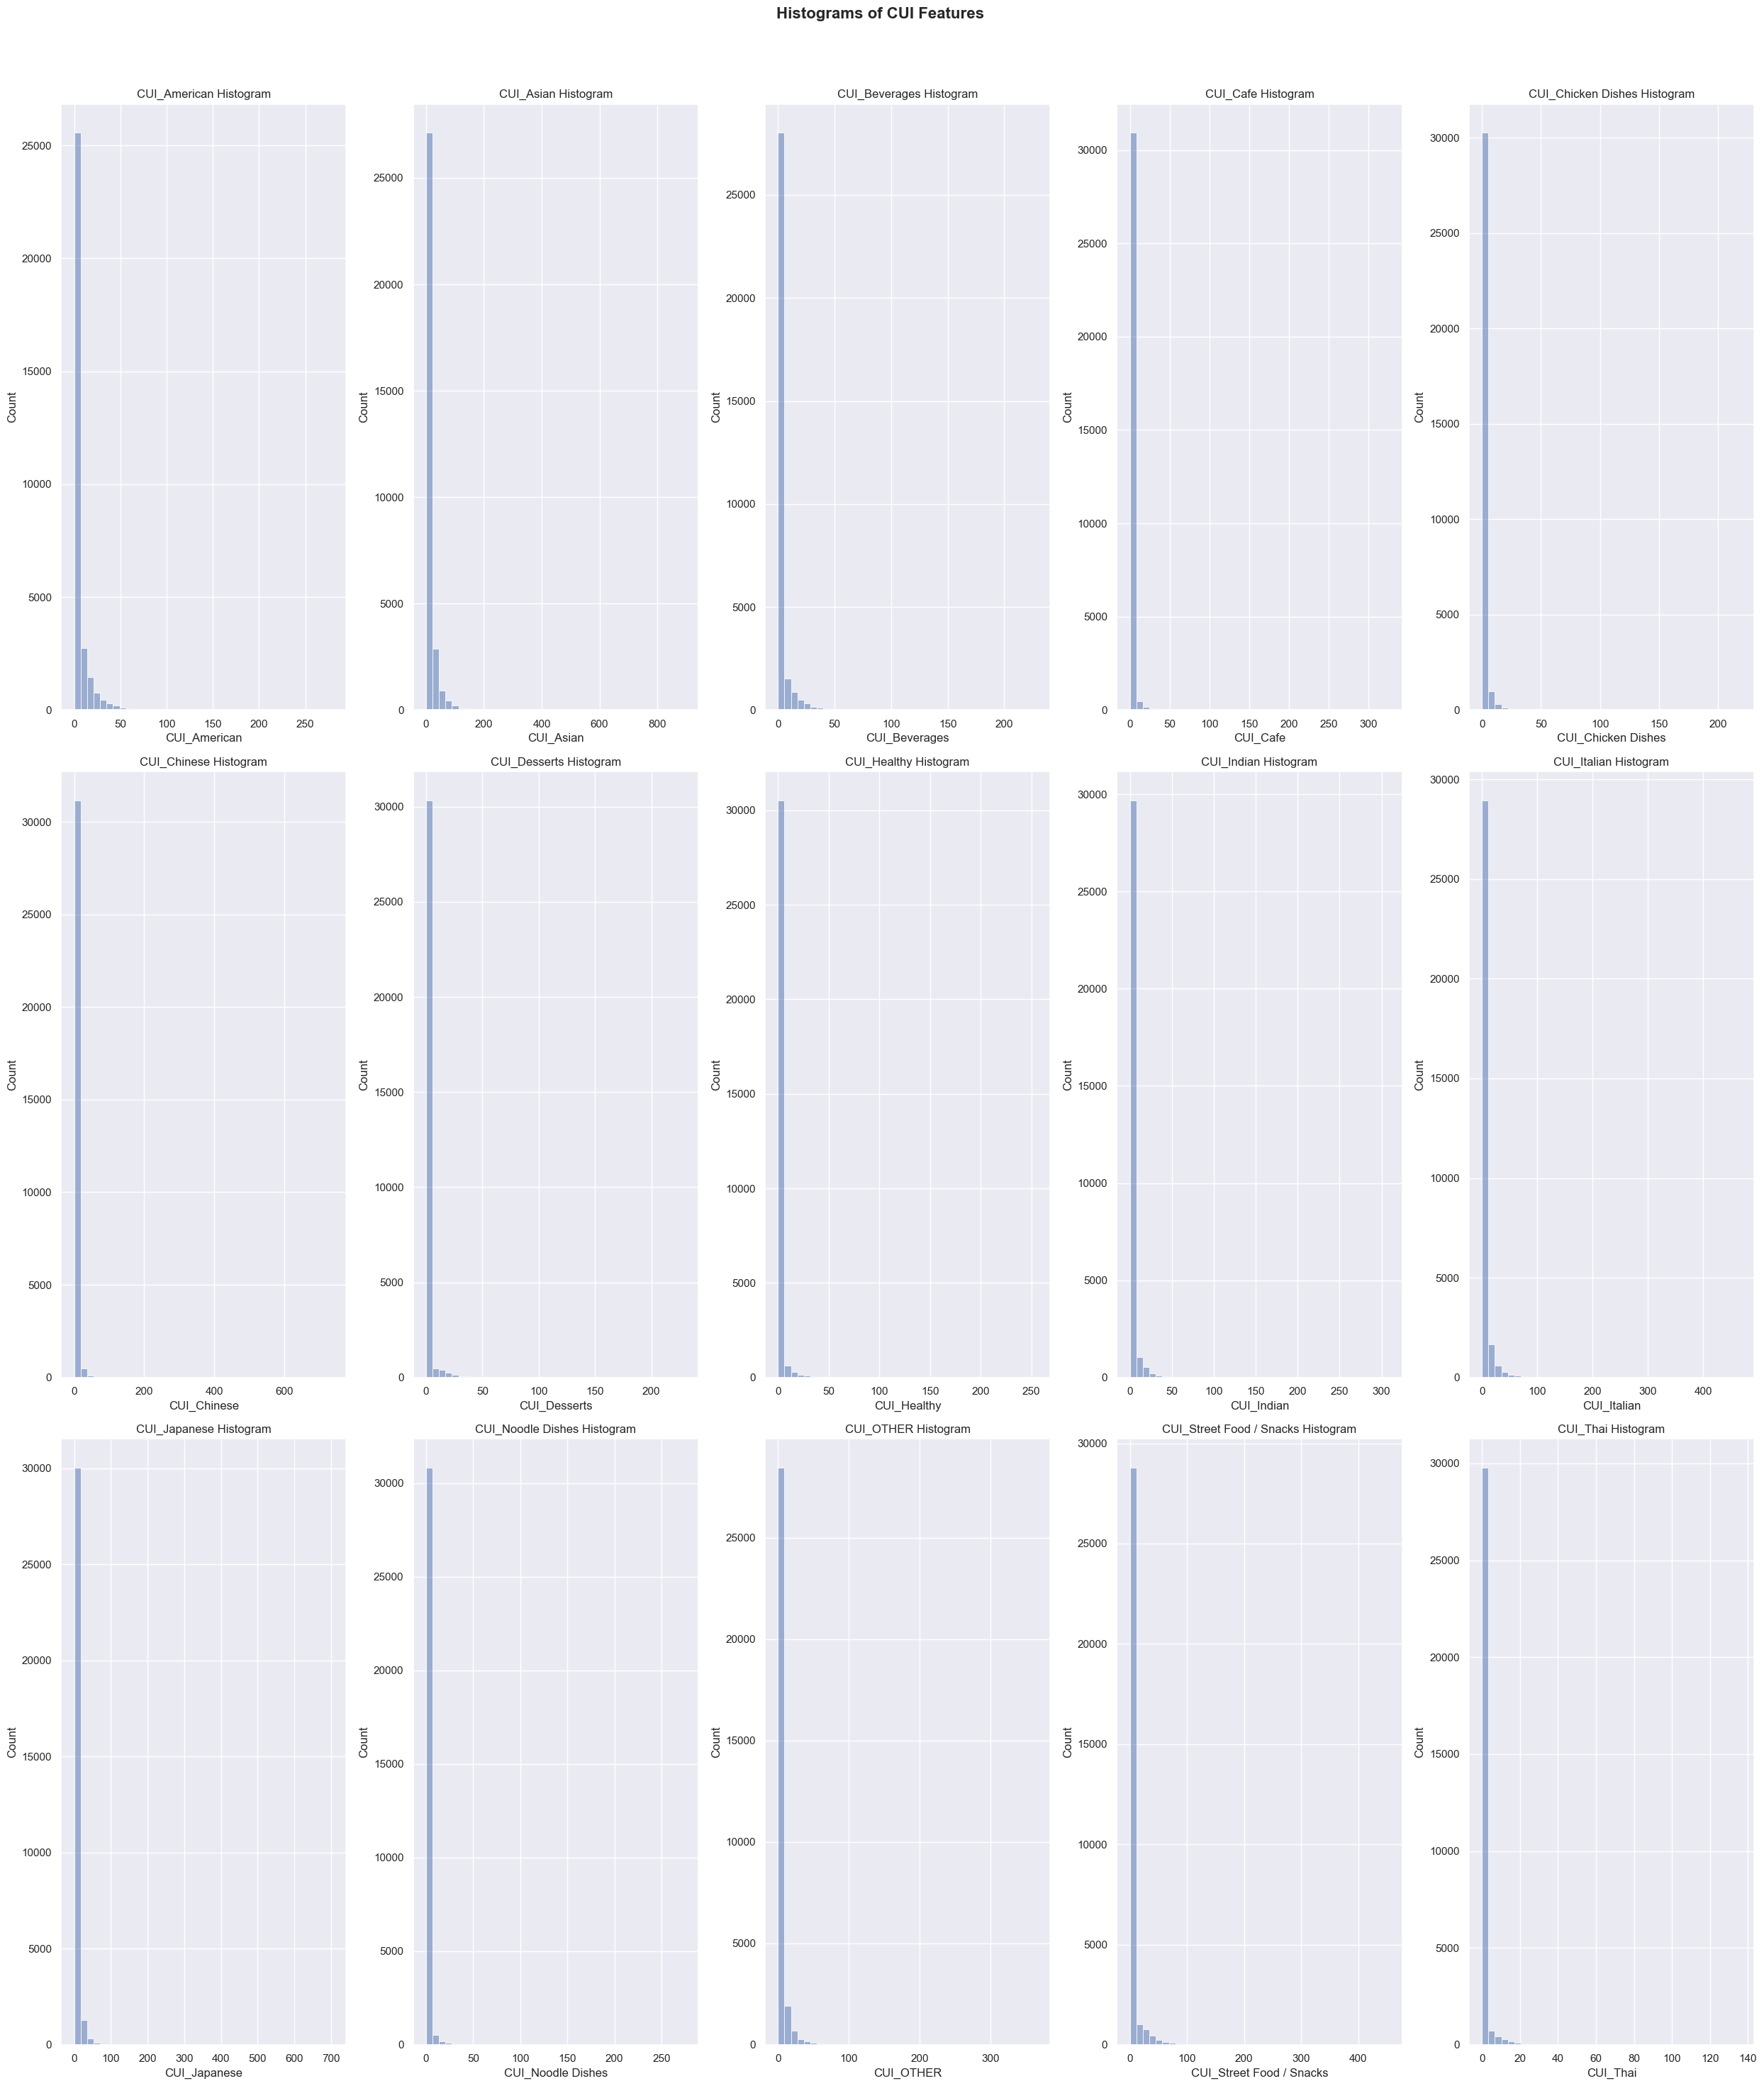

In [117]:
fig, axes = plt.subplots(3, 5, figsize=(25, 30))

# Loop through each feature in CUI columns and plot histograms 
for i, feature in enumerate(cui_columns):
    ax = axes[i // 5, i % 5]
    sns.histplot(df[feature], kde=False, ax=ax, alpha=0.5, bins=40)
    
    # Set title for each subplot
    ax.set_title(f"{feature} Histogram")

# Adding an overall title for the entire figure
plt.suptitle("Histograms of CUI Features", fontsize=16, fontweight='bold')

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Show the plot
plt.show()


Ploting all boxplots for ***CUI variables***

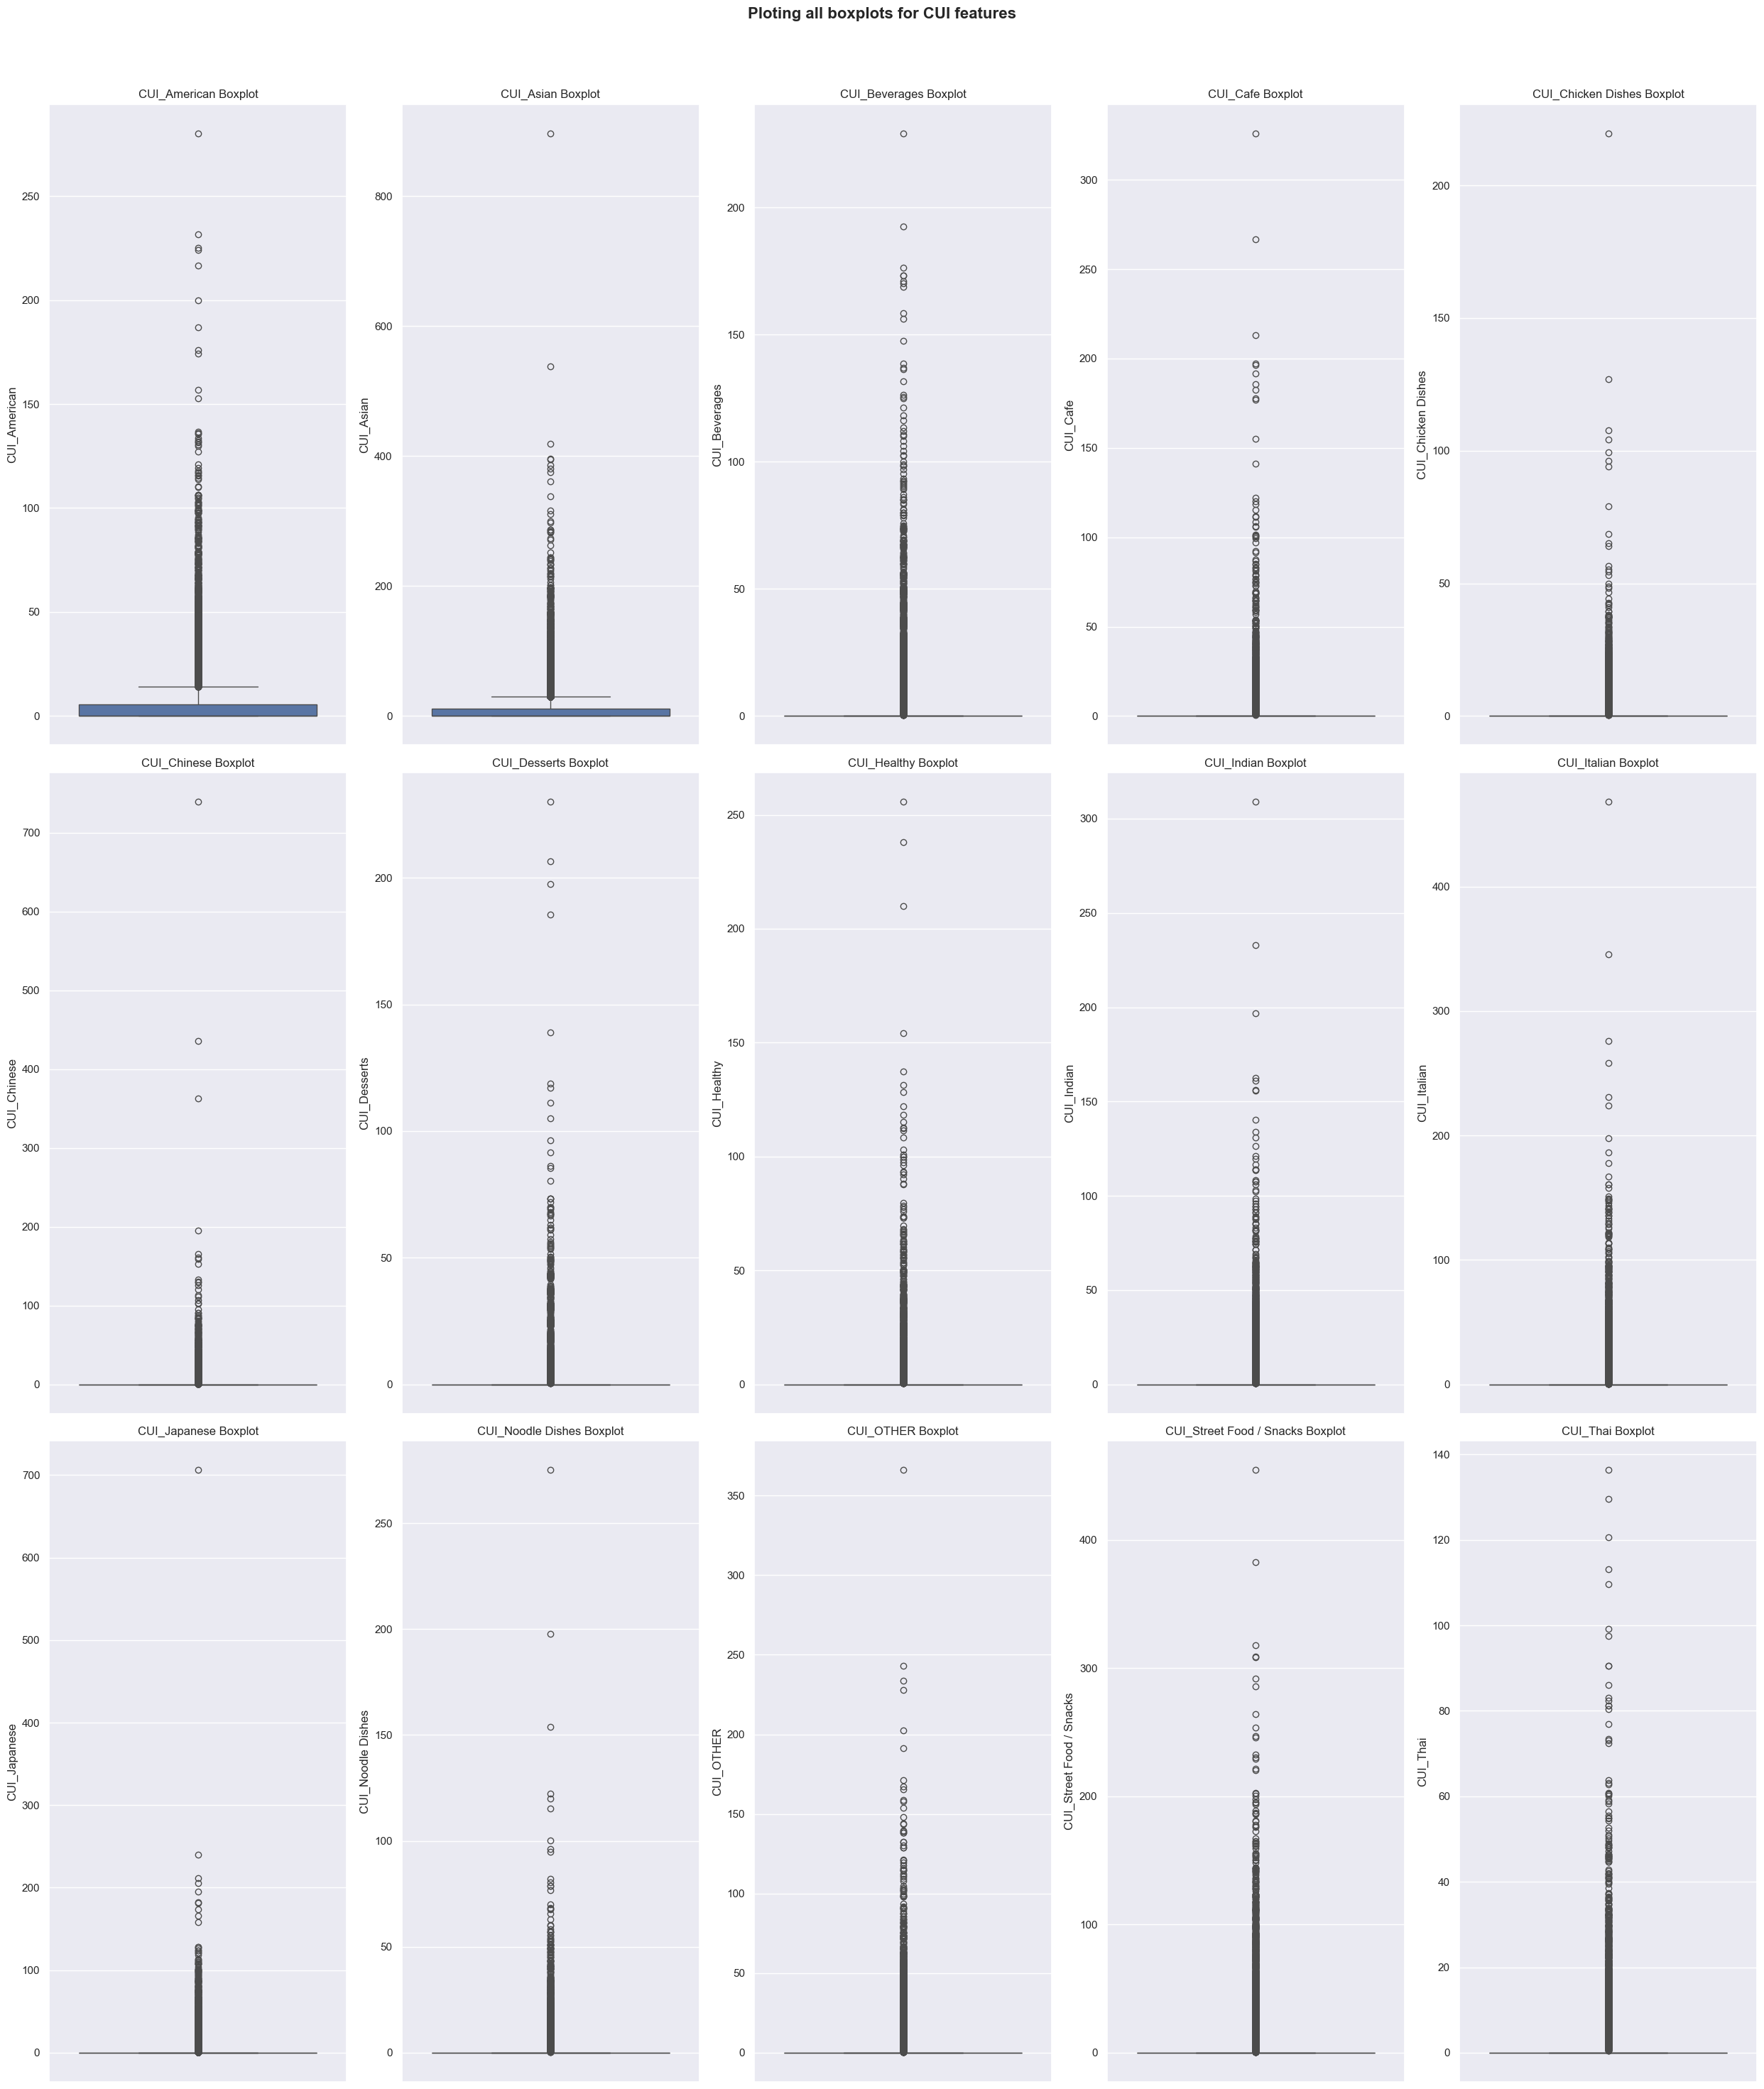

In [118]:
fig, axes = plt.subplots(3, 5, figsize=(25, 30))

# Loop through each feature and plot boxplots
for i, feature in enumerate(cui_columns):
    ax = axes[i // 5, i % 5]
    sns.boxplot(df[feature], ax=ax)
    
    # Set titles
    ax.set_title(f"{feature} Boxplot")

# Adding overall title
plt.suptitle("Ploting all boxplots for CUI features", fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

Ploting all histograms for ***DOW variables*** 

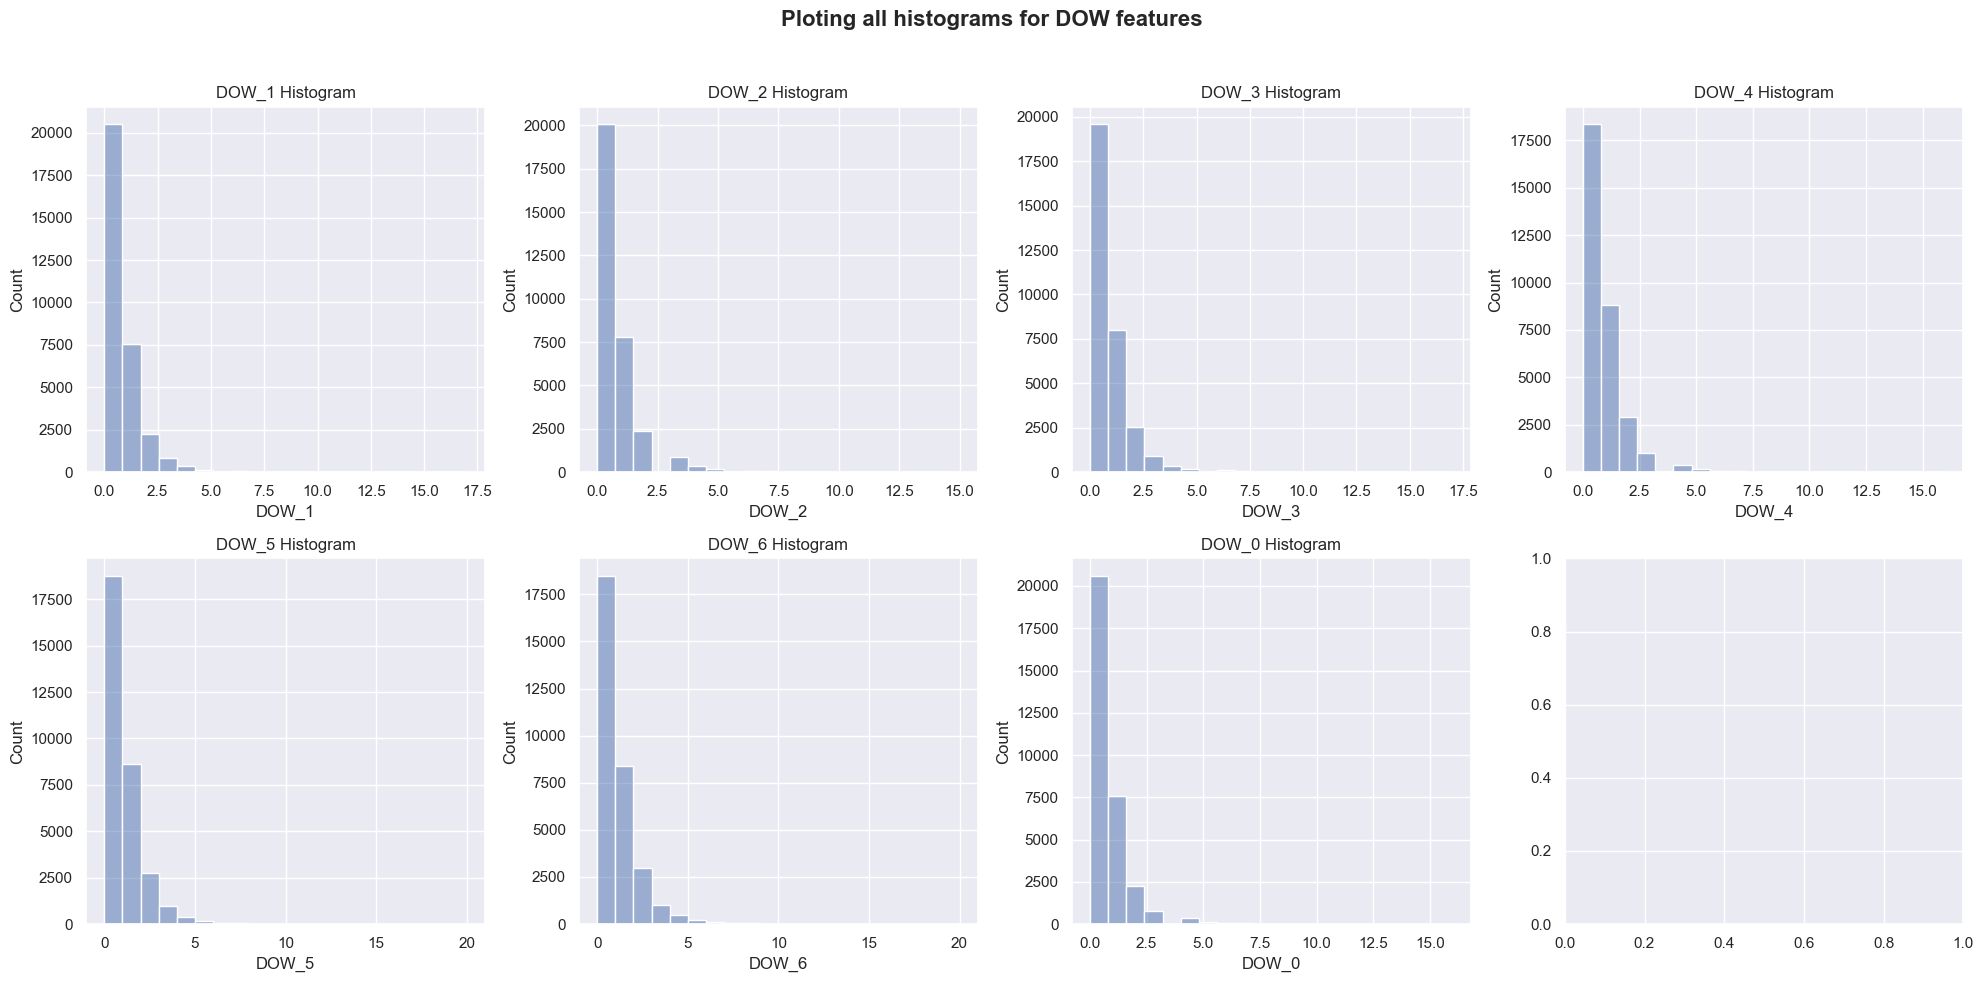

In [119]:
fig, axes = plt.subplots(2, 4, figsize=(20, 10))

# Loop through each feature and plot histograms
for i, feature in enumerate(dow_columns):
    ax = axes[i // 4, i % 4]
    sns.histplot(df[feature], kde=False, ax=ax, alpha=0.5, bins=20)
    
    # Set titles
    ax.set_title(f"{feature} Histogram")

# Adding overall title
plt.suptitle("Ploting all histograms for DOW features", fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

Ploting all boxplots for ***DOW variables***

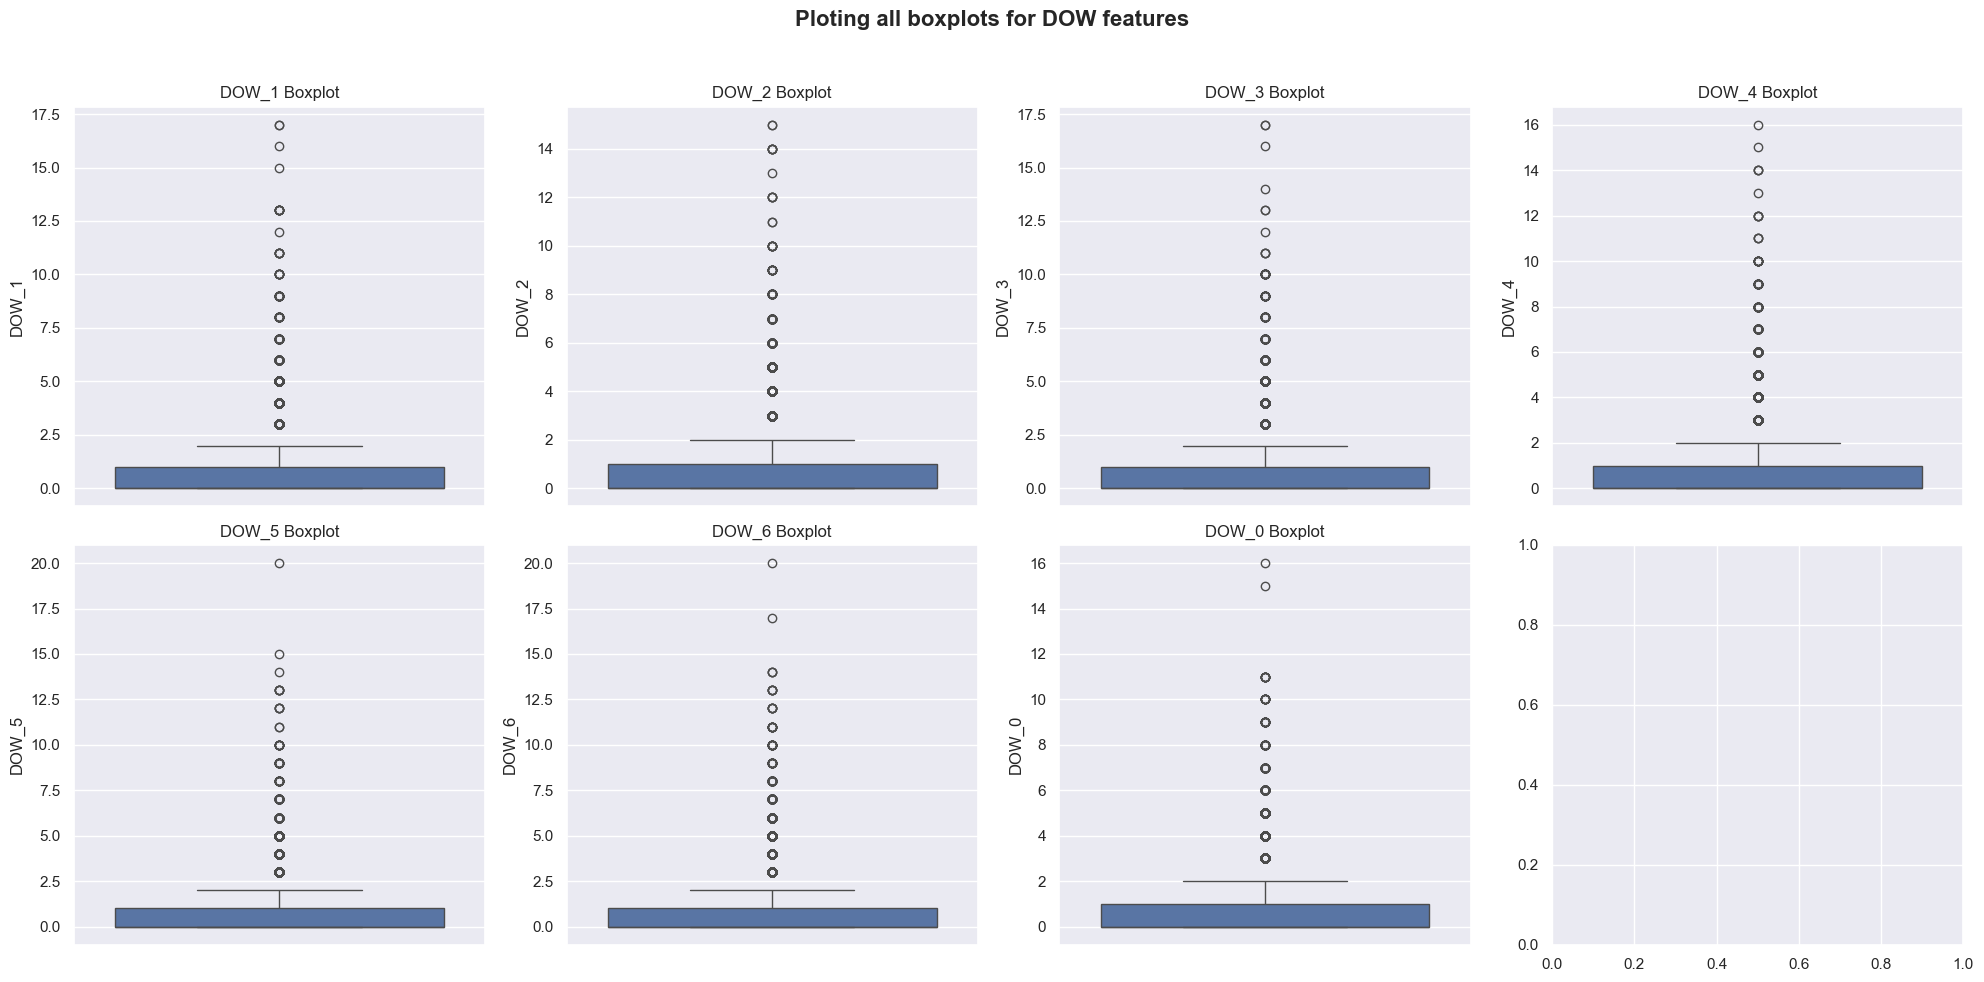

In [120]:
fig, axes = plt.subplots(2, 4, figsize=(20, 10))

# Loop through each feature and plot boxplots
for i, feature in enumerate(dow_columns):
    ax = axes[i // 4, i % 4]
    sns.boxplot(df[feature], ax=ax)
    
    # Set titles
    ax.set_title(f"{feature} Boxplot")

# Adding overall title
plt.suptitle("Ploting all boxplots for DOW features", fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

Ploting all histograms for ***HR variables***

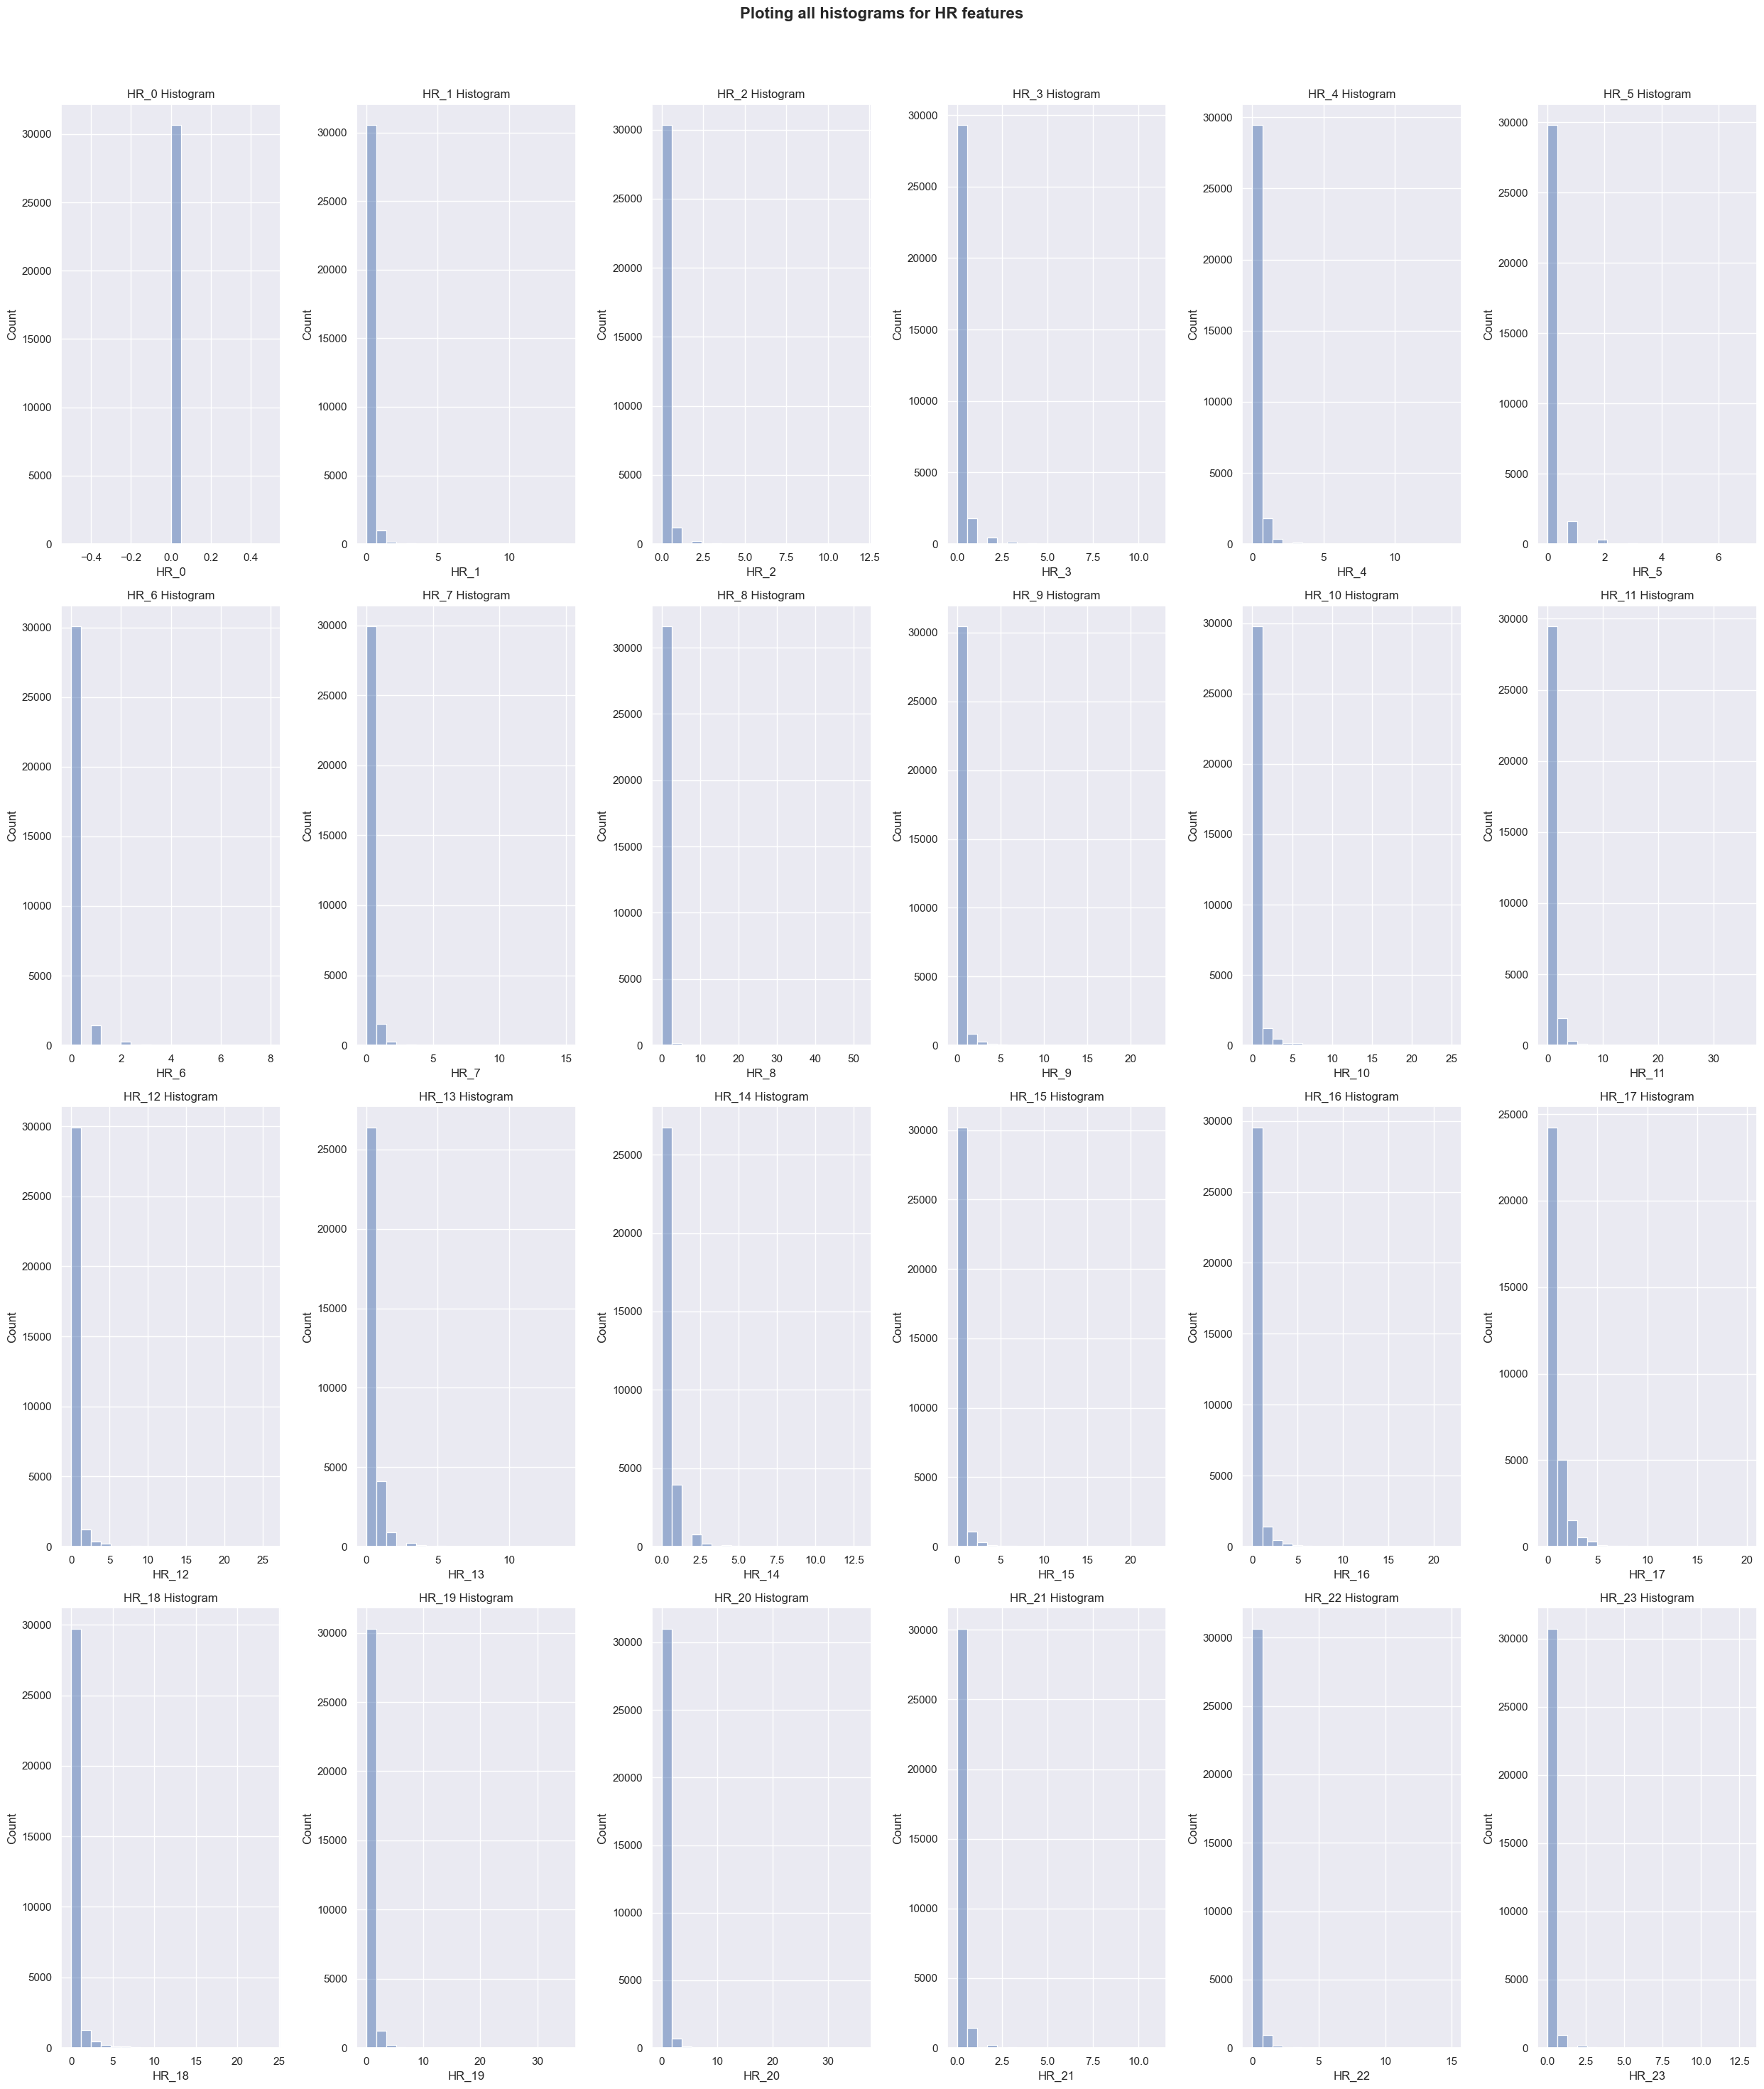

In [121]:
fig, axes = plt.subplots(4, 6, figsize=(25, 30))

# Loop through each feature and plot histograms
for i, feature in enumerate(hr_columns):
    ax = axes[i // 6, i % 6]
    sns.histplot(df[feature], kde=False, ax=ax, alpha=0.5, bins=20)
    
    # Set titles
    ax.set_title(f"{feature} Histogram")

# Adding overall title
plt.suptitle("Ploting all histograms for HR features", fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

***Ploting all boxplots for HR variables***

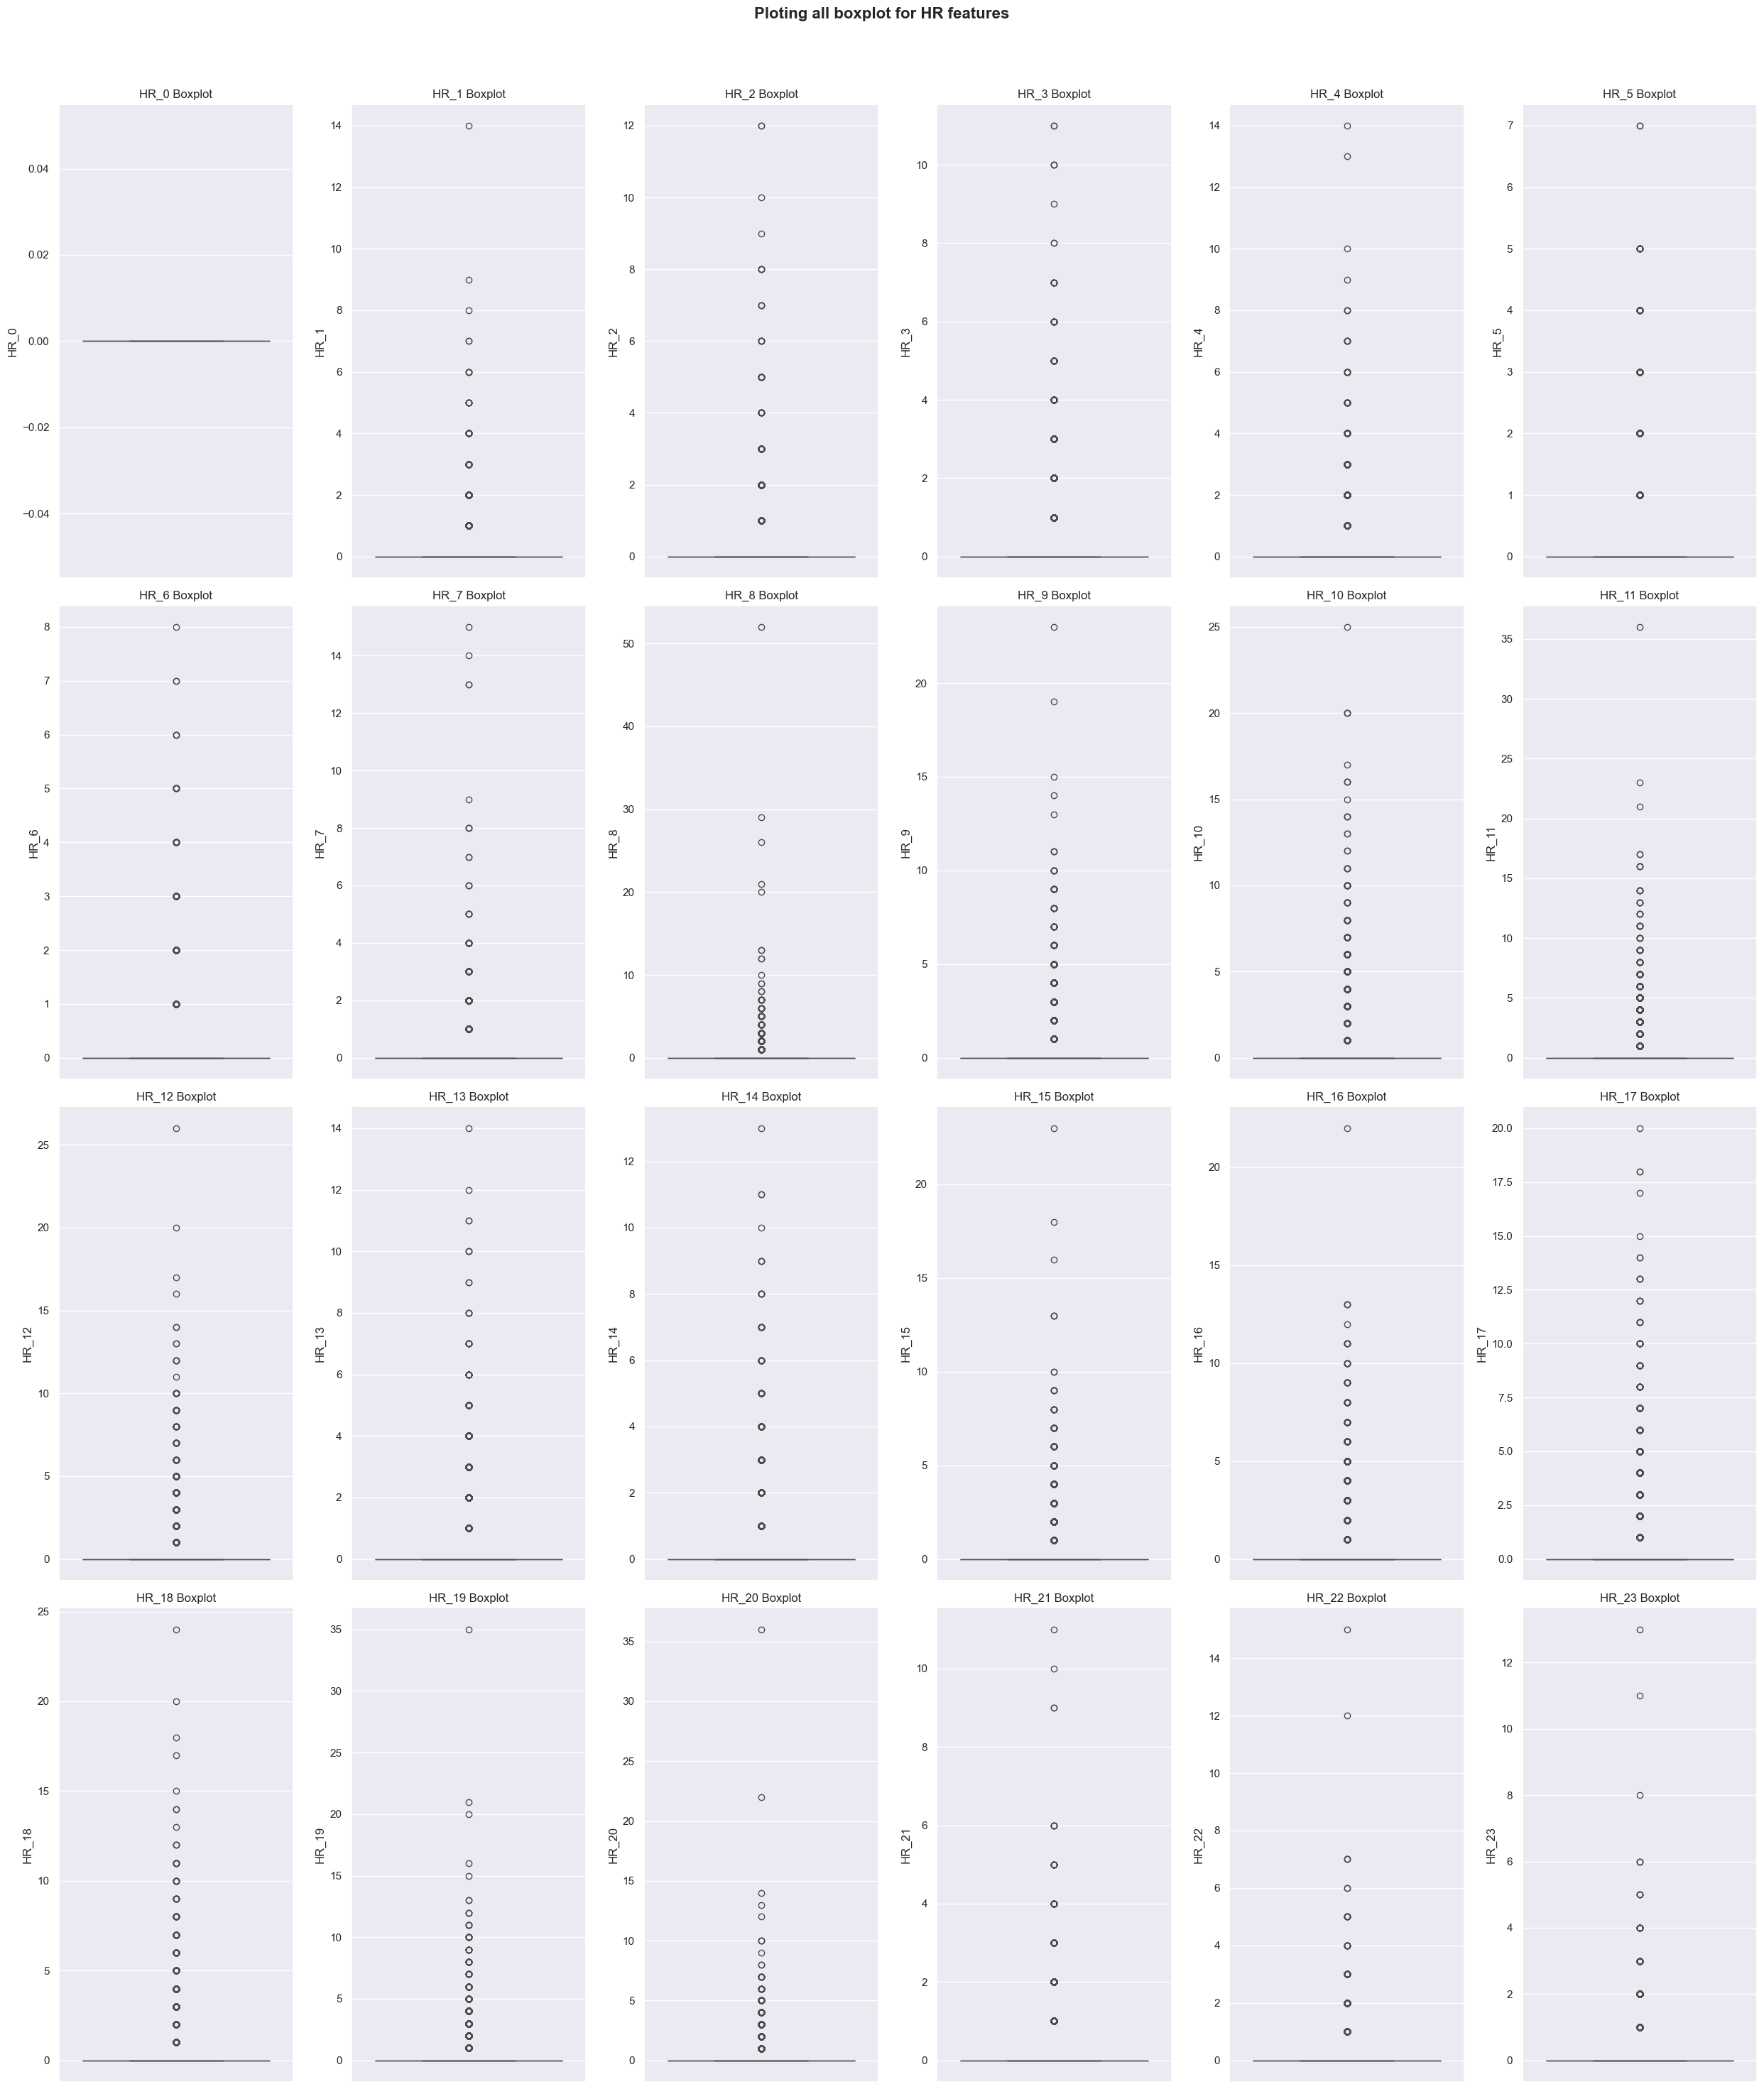

In [122]:
fig, axes = plt.subplots(4, 6, figsize=(25, 30))

# Loop through each feature and plot histograms
for i, feature in enumerate(hr_columns):
    ax = axes[i // 6, i % 6]
    sns.boxplot(df[feature], ax=ax)
    
    # Set titles
    ax.set_title(f"{feature} Boxplot")


# Adding overall title
plt.suptitle("Ploting all boxplot for HR features", fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

Bar plot for ***all categorical*** features

In [123]:
columns_categorical = ["customer_region", "last_promo", "payment_method"]

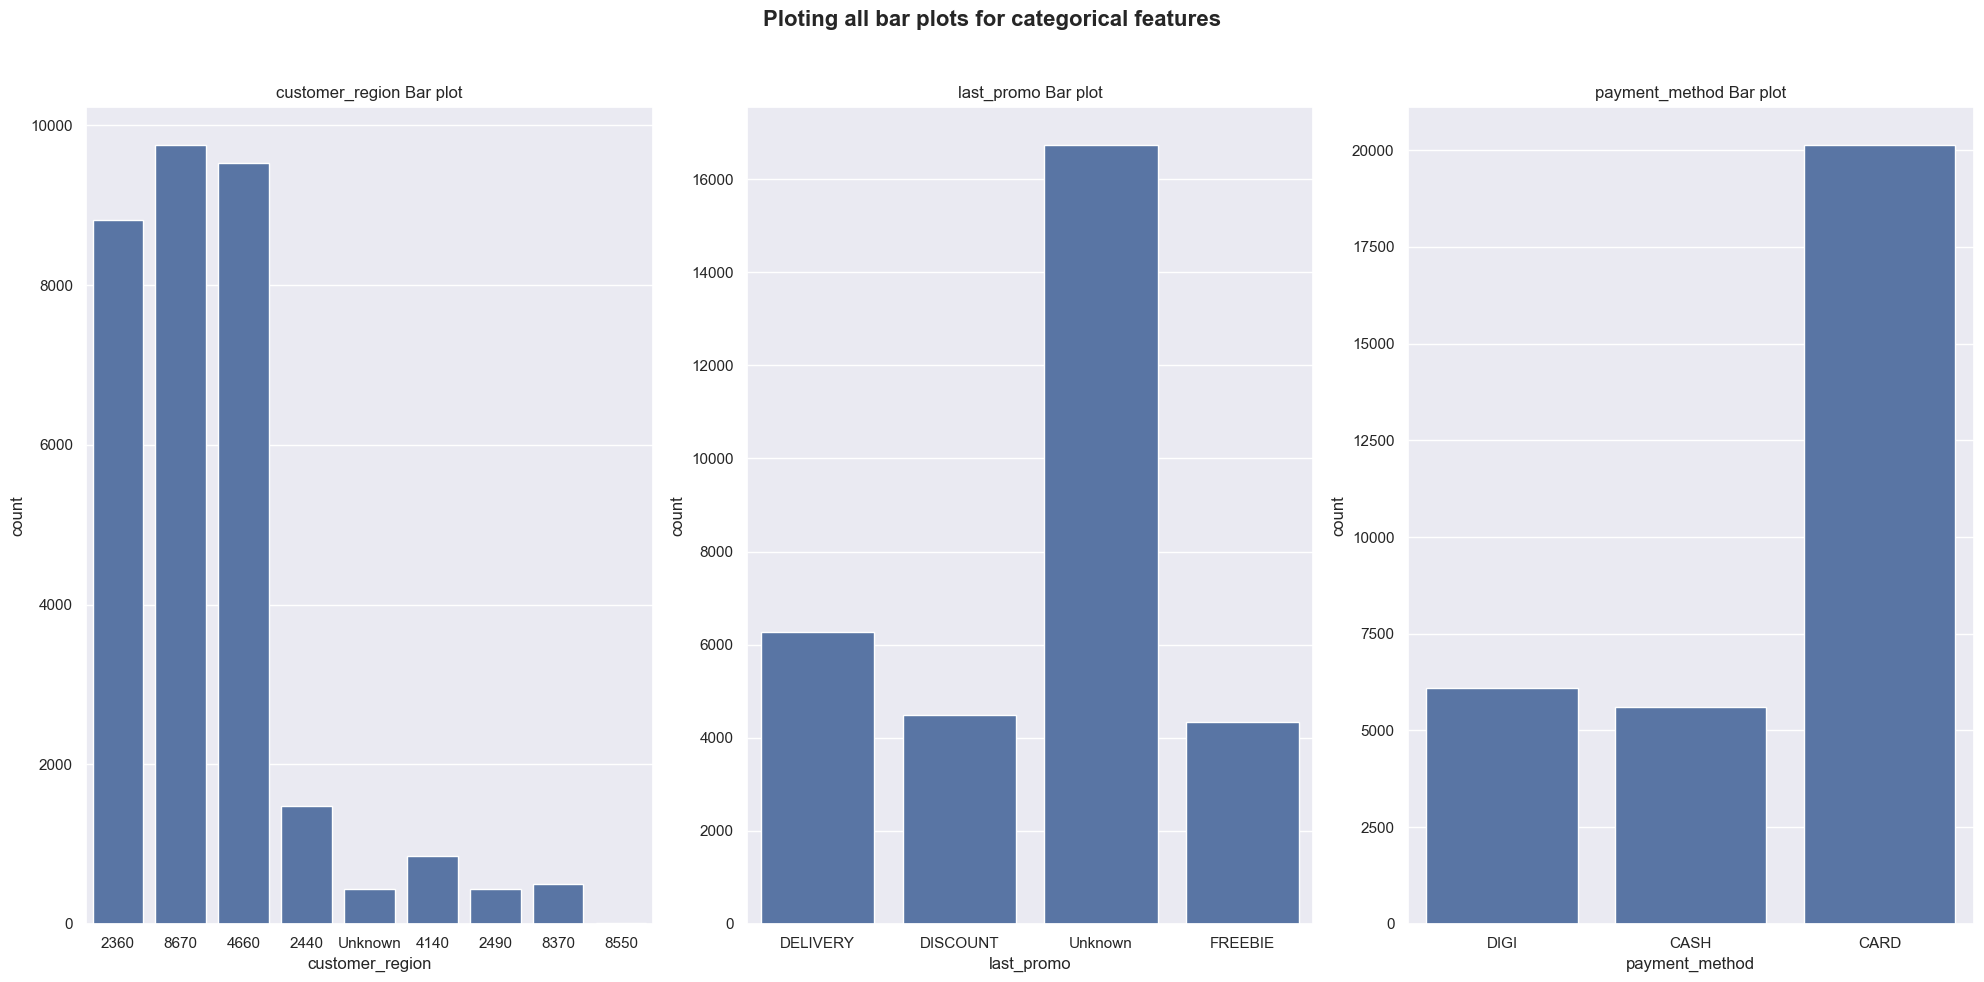

In [124]:
fig, axes = plt.subplots(1, 3, figsize=(20, 10))

# Loop through each feature and plot histograms
for i, feature in enumerate(columns_categorical):
    ax = axes[i]
    sns.countplot(data=df, x=feature, ax=ax)
    
    # Set titles
    ax.set_title(f"{feature} Bar plot")

# Adding overall title
plt.suptitle("Ploting all bar plots for categorical features", fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

---

<div class="alert alert-block alert-info" style="font-size:16px" id = "analyzing_nan_values">

## 3. Analyzing NaN values

### Types of NaN values

- MCAR (Missing Completely at Random): Missing data is independent of observed or unobserved variables, and its absence is purely random, causing no bias.

- MAR (Missing at Random): The likelihood of missing data depends on observed data but not on the missing data itself, leading to potential bias if not handled properly.

- MNAR (Missing Not at Random): The probability of missing data depends on the unobserved values, making it difficult to address without introducing bias.

In [125]:
# Making a copy in order to safely work on the nan values
df_nan = df.copy()

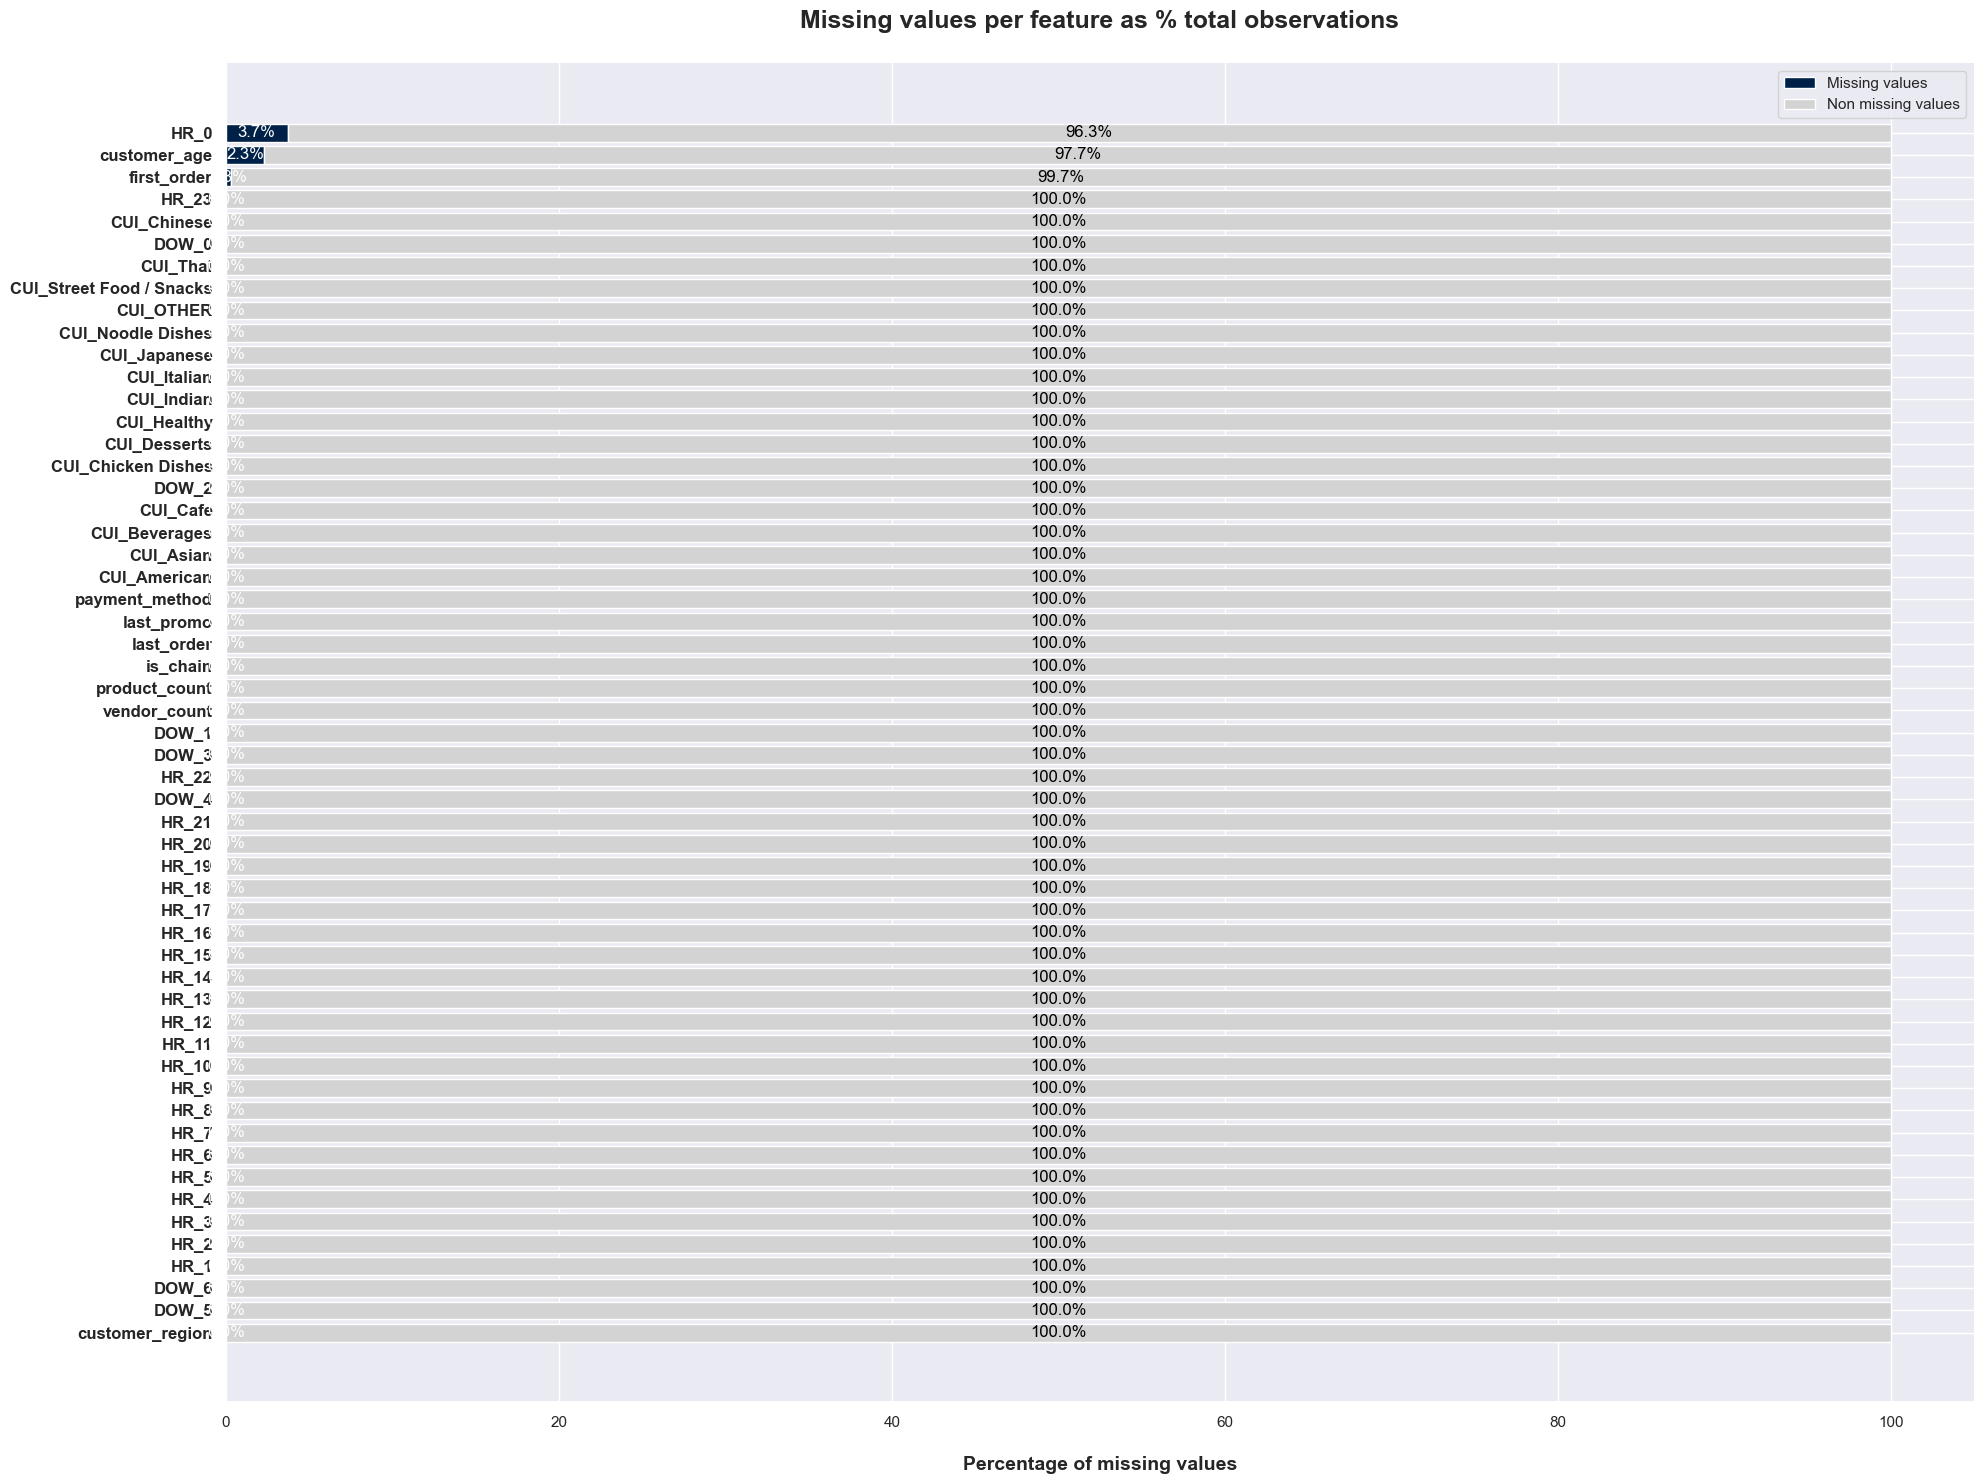

In [126]:
# [Alternative] Visualize the proportion of missing values in the dataset - NaN values for each column as % total obervations
# Calculate missing values percentage
percentage_missing = round((df_nan.isnull().sum() / len(df_nan))*100,1).sort_values(ascending=True)

# Create a DataFrame with missing and present values
percentage_missing_df = pd.DataFrame({"missing_values_(%)": percentage_missing})
percentage_missing_df["present_values_(%)"] = abs(percentage_missing_df["missing_values_(%)"] - 100)
percentage_present = percentage_missing_df["present_values_(%)"]
column_names = list(percentage_missing.index)

# Plot the BarChart
fig, ax = plt.subplots(figsize = (20,15))
p1 = ax.barh(y=column_names, width=percentage_missing, height= .8, color='#002147', label="Missing values")
p2 = ax.barh(y=column_names, width=percentage_present, height= .8, color="lightgrey", left=percentage_missing, label= "Non missing values")

# Add the percentage values on the bars
ax.bar_label(p1, labels= [str(round(element,1)) + "%" for element in percentage_missing], color="white", label_type="center")
ax.bar_label(p2, labels= [str(round(element,1)) + "%" for element in percentage_present], color="black", label_type="center")

# Set the title, labels and legend
ax.legend()
ax.set_title("Missing values per feature as % total observations\n", fontsize= 18, fontweight="bold")
ax.set_xlabel("\nPercentage of missing values", fontsize= 14, fontweight="bold")
plt.yticks(fontsize=12, fontweight="bold")
sns.despine(right=True, top=True)
plt.tight_layout()
plt.show()

---

### **`customer_region`**

In [149]:
# Refreshing memory on customer_region feature
df_nan["customer_region"].unique()

array(['2360', '8670', '4660', '2440', 'Unknown', '4140', '2490', '8370',
       '8550'], dtype=object)

In [150]:
# Total number of nan values
df_nan["customer_region"].isnull().sum()

0

In [151]:
# Imputation process applied - create a new category "Unknown location" (please check explanation in the key notes below)

df_nan["customer_region"] = df["customer_region"].fillna("Unknown location")
df_nan["customer_region"].unique()

array(['2360', '8670', '4660', '2440', 'Unknown', '4140', '2490', '8370',
       '8550'], dtype=object)

In [152]:
# Number of elements of rare category '8550' in customer region 
df_nan["customer_region"].loc[df_nan["customer_region"] == '8550'].count()

13

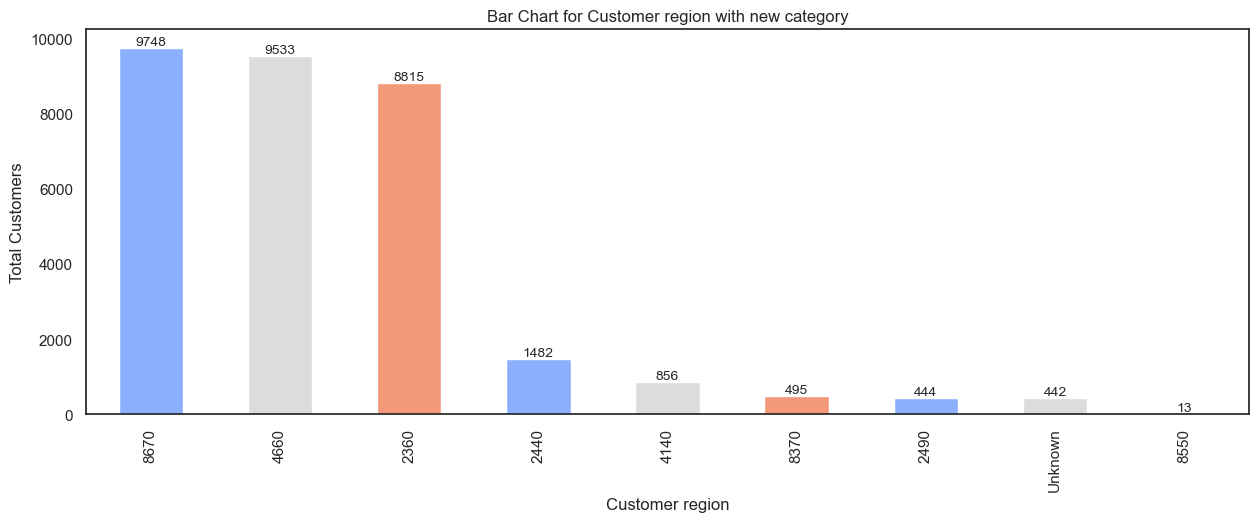

In [153]:
# Bar Chart for customer region with new category 'unknown location' 

fig, ax = plt.subplots(1,1, figsize=(15, 5))

bar_colors = sns.color_palette("coolwarm", len(x_values))
df_nan['customer_region'].value_counts().plot(kind='bar', color=bar_colors, ax =ax)

plt.title('Bar Chart for Customer region with new category')
plt.xlabel('Customer region')
plt.ylabel('Total Customers')

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2, p.get_height()), 
                ha='center', va='bottom', fontsize = 10)

plt.show()

---

### **`customer_age`**

In [142]:
# Number of nan values
df_nan.loc[df_nan["customer_age"].isnull()].shape[0]

727

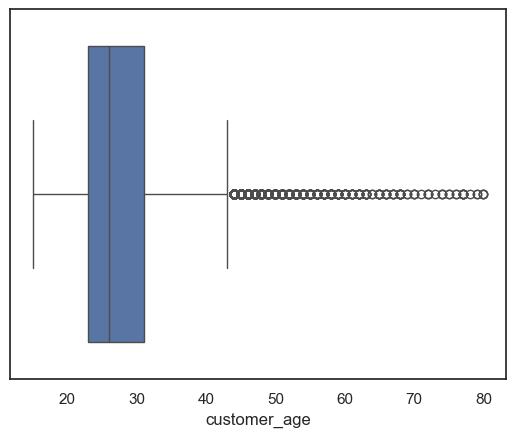

In [144]:
# Boxplot to understand where the median or mean is a betetr option as potential imputation method

sns.boxplot(x=df_nan["customer_age"])

plt.show()

In [146]:
df_nan["customer_age"].describe()

count    31101.000000
mean        27.508376
std          7.164141
min         15.000000
25%         23.000000
50%         26.000000
75%         31.000000
max         80.000000
Name: customer_age, dtype: float64

---

### **`first_order`**

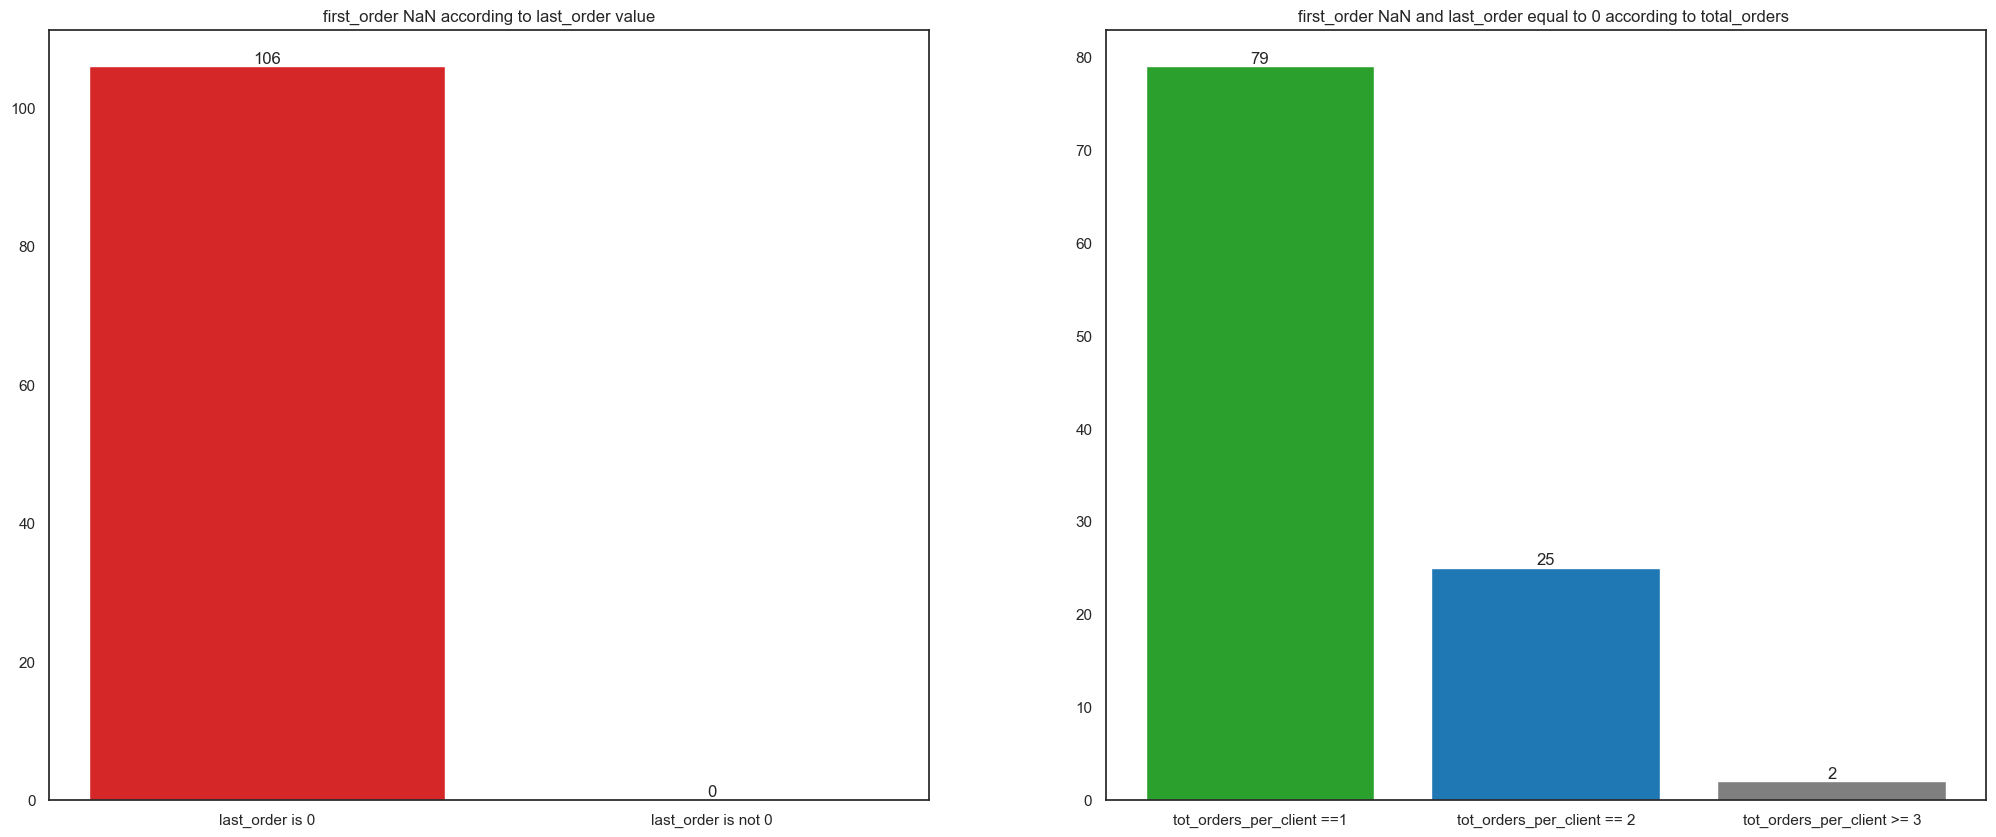

In [148]:
# Bar plot
sns.set_style("white")
fig, ax = plt.subplots(1,2, figsize=(25, 10))

y_values = [df_nan.loc[(df_nan["first_order"].isnull()) & (df_nan["last_order"] == 0)].shape[0], df_nan.loc[(df_nan["first_order"].isnull()) & (df_nan["last_order"] != 0)].shape[0], ]
x_values = ['last_order is 0', 'last_order is not 0']
bar_color = ["tab:red", "tab:grey"]
p2 = ax[0].bar(x_values, y_values, color= bar_color)
ax[0].bar_label(p2, labels= [str(element) for element in y_values])
ax[0].set_title("first_order NaN according to last_order value")



y_values = [df_nan.loc[ (df_nan["first_order"].isnull()) & (df_nan["last_order"] == 0) & (df_nan["product_count"] == 1)].shape[0], 
            df_nan.loc[ (df_nan["first_order"].isnull()) & (df_nan["last_order"] == 0) & (df_nan["product_count"] == 2)].shape[0],
            df_nan.loc[ (df_nan["first_order"].isnull()) & (df_nan["last_order"] == 0) & (df_nan["product_count"] >= 3)].shape[0],
            ]
x_values = ["tot_orders_per_client ==1", "tot_orders_per_client == 2", "tot_orders_per_client >= 3"]
bar_color = ["tab:green", "tab:blue", "tab:grey"]
p1 = ax[1].bar(x_values, y_values, color= bar_color)
ax[1].bar_label(p1, labels= [str(element) for element in y_values])
ax[1].set_title("first_order NaN and last_order equal to 0 according to total_orders ")

plt.show()



### **`HR_0`**
#### - Using DOW_0 to DOW_6 vs HR_0 to HR_23 to determine total num of orders

### Notes
- We are formulating the hypothesis that the total num of orders calculated by summing all the values from DOW_0 to DOW_6 and from HR_0 to HR_23 must be the same.
- From all the features, only HR_0 has NaN values, maning that if there is a discrepancy they might be the cause of it
- We expect the total_orders calculated with DOW to be higher than the total_orders calculated using HR. If this happens, than it further verifies that we can input the HR_0 NaN values in the following way:
    - HR_0 NaN value client = total_orders_Dow for client - total_orders_HR for client

In [128]:
columns = [element for element in df.columns if "DOW" in str(element) or "HR" in str(element)]
df_HR_DOW = df[columns]

columns_to_sum = [f'DOW_{i}' for i in range(7)]
df_HR_DOW.insert(7, "total_orders_DOW", df[columns_to_sum].sum(axis=1) )

columns_to_sum = [f'HR_{i}' for i in range(24)]
df_HR_DOW["total_orders_HR"] = df[columns_to_sum].sum(axis=1).astype(int)
df_HR_DOW

total_ord_diff = df_HR_DOW.loc[df_HR_DOW["total_orders_DOW"] != df_HR_DOW["total_orders_HR"] ]
total_is_dif_HR_is_NaN = df_HR_DOW.loc[ (df_HR_DOW["total_orders_DOW"] != df_HR_DOW["total_orders_HR"]) & (df_HR_DOW["HR_0"].isnull()) & (df_HR_DOW["total_orders_HR"] < df_HR_DOW["total_orders_DOW"]) ]


if total_is_dif_HR_is_NaN.shape[0] == total_ord_diff.shape[0]:
    print("All the clients whose total number of observations is different when summing all DOW's or HR's are also the ones with NaN values for HR_0 and the total value is always higher in total DOW than HR\n")
    print("This means we can input the values")

#making copy of the column to then input the values
df_HR_DOW.insert(9, "HR_0_corrected", df_HR_DOW["HR_0"])
#Correct values to input HR_0 NaN
values_HR_0_corrected = total_ord_diff["total_orders_DOW"] - total_ord_diff["total_orders_HR"]
df_HR_DOW.fillna({"HR_0_corrected": values_HR_0_corrected}, inplace=True)
df_HR_DOW

All the clients whose total number of observations is different when summing all DOW's or HR's are also the ones with NaN values for HR_0 and the total value is always higher in total DOW than HR

This means we can input the values


DOW_0  DOW_1  DOW_2  DOW_3  DOW_4  DOW_5  DOW_6  \
customer_id                                                    
1b8f824d5e       1      0      0      0      0      0      1   
5d272b9dcb       1      0      0      0      0      0      1   
f6d1b2ba63       1      0      0      0      0      0      1   
180c632ed8       0      1      0      0      0      0      1   
4eb37a6705       0      1      0      0      0      0      1   
...            ...    ...    ...    ...    ...    ...    ...   
f4e366c281       0      0      0      0      0      0      1   
f6b6709018       0      0      0      0      0      0      1   
f74ad8ce3f       0      0      0      0      0      0      1   
f7b19c0241       0      0      0      0      0      0      1   
fd40d3b0e0       0      0      0      0      0      0      1   

             total_orders_DOW  HR_0  HR_0_corrected  ...  HR_15  HR_16  HR_17  \
customer_id                                          ...                        
1b8f824d5e                  2   0.0             0.0  ...      0      0      0   
5d272b9dcb                  2   0.0             0.0  ...      0      0      0   
f6d1b2ba63                  2   0.0             0.0  ...      0      0      0   
180c632ed8                  2   0.0             0.0  ...      0      0      0   
4eb37a6705                  2   0.0             0.0  ...      0      0      0   
...                       ...   ...             ...  ...    ...    ...    ...   
f4e366c281                  1   0.0             0.0  ...      0      0      0   
f6b6709018                  1   0.0             0.0  ...      0      1      0   
f74ad8ce3f                  1   0.0             0.0  ...      0      0      0   
f7b19c0241                  1   0.0             0.0  ...      0      0      0   
fd40d3b0e0                  1   0.0             0.0  ...      0      1      0   

             HR_18  HR_19  HR_20  HR_21  HR_22  HR_23  total_orders_HR  
customer_id                                                             
1b8f824d5e       2      0      0      0      0      0                2  
5d272b9dcb       0      0      0      0      0      0                2  
f6d1b2ba63       0      0      0      0      0      0                2  
180c632ed8       0      0      0      0      0      0                2  
4eb37a6705       0      0      0      0      0      0                2  
...            ...    ...    ...    ...    ...    ...              ...  
f4e366c281       0      0      0      0      0      0                1  
f6b6709018       0      0      0      0      0      0                1  
f74ad8ce3f       0      0      0      0      0      0                1  
f7b19c0241       0      0      0      0      0      0                1  
fd40d3b0e0       0      0      0      0      0      0                1  

[31828 rows x 34 columns]

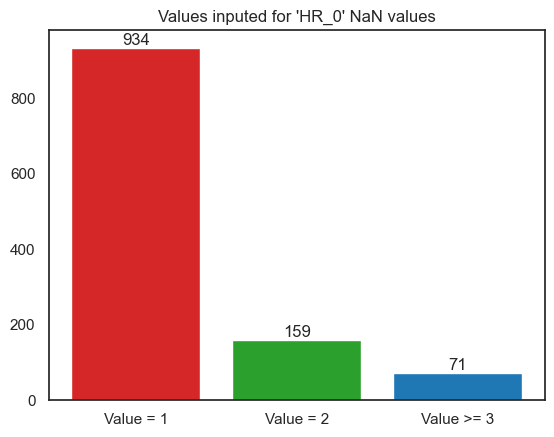

Total values inputed 1164
Number of HR_0 NaN values: 1164


In [129]:
# Bar plot

HR_0_input_values = df_HR_DOW.loc[df_HR_DOW["HR_0"].isna(), "HR_0_corrected"]
values_1_inputed = HR_0_input_values.loc[HR_0_input_values == 1].count()
values_2_inputed = HR_0_input_values.loc[HR_0_input_values == 2].count()
values_3_inputed = HR_0_input_values.loc[HR_0_input_values >= 3].count()

y_values = [values_1_inputed, values_2_inputed, values_3_inputed]

x_values = ["Value = 1", "Value = 2", "Value >= 3"]
fig, ax = plt.subplots()
bar_color = ["tab:red", "tab:green", "tab:blue"]
p = ax.bar(x_values, y_values, color= bar_color)
ax.bar_label(p, labels= [str(element) for element in y_values])
ax.set_title("Values inputed for 'HR_0' NaN values")
plt.show()

HR_0_Nan = df["HR_0"].isnull().sum()
print(f"Total values inputed {values_1_inputed+values_2_inputed+values_3_inputed}")
print(f"Number of HR_0 NaN values: {HR_0_Nan}") 


<div class="alert alert-block alert-warning">
<b style="font-size: 2em">Note:</b> Now we need to check wheter the total number of orders made by all clients is equal using DOW and HR variables after inputting the 'HR_0' NaN values.

</div>



In [130]:
#Insert corrected column
df_nan.insert(34, "HR_0_corrected", df_nan["HR_0"])

# Determine correct values to input NaN HR_0 and replace them in the corrected column
df_nan.fillna({"HR_0_corrected": values_HR_0_corrected}, inplace=True)

In [131]:
columns_HR = [element for element in df_nan.columns if "HR" in str(element)]
columns_HR.remove("HR_0")
columns_DOW = [element for element in df_nan.columns if "DOW" in str(element)]

HR_total_orders_dataset = int(df_nan[columns_HR].sum().sum())
DOW_total_orders_dataset = int(df_nan[columns_DOW].sum().sum())

print(f"{columns_HR} \n")
print(f"Total number of orders of all clients using HR (used HR_0 instead of HR) is: {HR_total_orders_dataset:,}")
print(f"Total number of orders of all clients using DOW is: {DOW_total_orders_dataset:,}")


['HR_1', 'HR_2', 'HR_0_corrected', 'HR_3', 'HR_4', 'HR_5', 'HR_6', 'HR_7', 'HR_8', 'HR_9', 'HR_10', 'HR_11', 'HR_12', 'HR_13', 'HR_14', 'HR_15', 'HR_16', 'HR_17', 'HR_18', 'HR_19', 'HR_20', 'HR_21', 'HR_22', 'HR_23'] 

Total number of orders of all clients using HR (used HR_0 instead of HR) is: 139,054
Total number of orders of all clients using DOW is: 139,054


In [132]:
# Drop HR_0 column (doing it on purpose on isolated cell)
df_nan.drop(columns="HR_0", inplace=True)

In [133]:
# Rename HR_0_corrected column to HR_0
df_nan.rename(columns={"HR_0_corrected": "HR_0"}, inplace= True)

In [134]:
df_nan["HR_0"].isnull().sum()

0

In [135]:
# Applying the changes to the respective column in df
df["HR_0"] = df_nan["HR_0"]

---

<div class="alert alert-block alert-info" style="font-size:16px">

### Key notes **`customer_region`** (MNAR)
1. There is a total of 442 nan values in the 'customer_region' feature
2. The nan values don't seem to be deterministically imputable
3. The missing values in customer_region are likely MNAR because they may relate to unobserved reasons like frequent travelling clients who regularly move between different places or clients who share the same account and live in different cities
4. The nature of the underlying feature nan values, requires a more targeted analyses to avoid potential biasses when removing the data or when selecting an imputation method.
5. To preserve this meaningful absence, we will create a new category called "Unknown location"

### Key notes **`customer_age`** (MAR)
1. There is a total of 727 nan values in the 'customer_age' feature
2. The absence of data will most likely be related to other observed features meaning the missing values could be classified as MAR and requiring a robost imputation method since the nan values don't seem to be deterministically imputable.
3. Since 'customer_age' has a low percentage of missing values and there is a strong presence of outliers, we would choose the median as the imputation method. Besides it's simplicity and effectiveness, it also provides a robust medthod to dealing with outliers wwithout adding complexity


### Key notes **`first_order`** (MAR)
1. There is a total of 106 nan values
2. They seem to be deterministically imputable and their value depend on the last_order and total_orders made. Hence the missing values could be classified as MAR
3. The first_order missing values correpond to clients where:
    - the last order was made in the first day of the first month.
    - their total orders was bigger than 0
4. Considering a total period of 3 months, from the total clients with first_order missing values (106):
    - 79 clients made a single order
    - 25 clients made 2 orders
    - 2 clients made more than 3 orders
5. If all the missing values correspond to clients with 'last_order' equal to 0 and total_orders bigger than 0, then it's safe to assume that during the 3 months clients made all their order/s 
in the first day of the first month. Then we should input these NaN values with the value 0


### Key notes **`HR_0`** (MAR)
1. There is a total of 1164 nan values in the 'HR_0' feature
2. The nan values seem to be deterministically imputable so the missigness is not random but it depends on information related to other features. In this case the DOW and HR features. Hence the missing values could be claissfied as MAR
3. For each client, the 'HR_0' NaN value corresponds to the difference between the client's total number of orders using 'DOW' and total number of orders using 'HR'
4. After creating the column 'HR_0_corrected' where all the NaN values were substitued by their correct values, we can see that the total number of orders in the dataset using the HR variables or the DOW variables is the same

### **`General notes`**
1. Replaced HR_0 with HR_0_corrected (dropped HR_0 and renamed HR_0_corrected to HR_0) in df_nan and in df



In [154]:
df_nan.columns

Index(['customer_region', 'customer_age', 'vendor_count', 'product_count',
       'is_chain', 'first_order', 'last_order', 'last_promo', 'payment_method',
       'CUI_American', 'CUI_Asian', 'CUI_Beverages', 'CUI_Cafe',
       'CUI_Chicken Dishes', 'CUI_Chinese', 'CUI_Desserts', 'CUI_Healthy',
       'CUI_Indian', 'CUI_Italian', 'CUI_Japanese', 'CUI_Noodle Dishes',
       'CUI_OTHER', 'CUI_Street Food / Snacks', 'CUI_Thai', 'DOW_0', 'DOW_1',
       'DOW_2', 'DOW_3', 'DOW_4', 'DOW_5', 'DOW_6', 'HR_1', 'HR_2', 'HR_0',
       'HR_3', 'HR_4', 'HR_5', 'HR_6', 'HR_7', 'HR_8', 'HR_9', 'HR_10',
       'HR_11', 'HR_12', 'HR_13', 'HR_14', 'HR_15', 'HR_16', 'HR_17', 'HR_18',
       'HR_19', 'HR_20', 'HR_21', 'HR_22', 'HR_23'],
      dtype='object')

---

<div class="alert alert-block alert-info" style="font-size:16px" id = "analyzing_outlier_values">

## 4. Analyzing outlier values

### How to identify outliers ?
-  using visual tools like boxplots
- with statistical tools like z-score and IQR

### Types of outliers going to be analyzed

1. Univariate outliers for numerical features
2. Bivariate outliers for numerical features
3. Outliers for categorical features

### Different ways to deal with Outliers

1. Numerical features
 - Remove based on visual inspection: Eliminate outliers if they fall outside a defined visual threshold.
- Adjust values to reduce extremity: Modify extreme values to bring them closer to the range of other data points (often called "winsorizing").
- Retain all values: Keep all data points, allowing for a full range of variability.

2. Categorical features
- Remove based on threshold
- Retain values by creating a new category inside feature. E.g 'Other'

### Maximum number of outliers to remove
1. As a rule of thumb, try not to remove more than 5% of your rows. 
2. However, it might be necessary to remove more.

In [155]:
df_outliers = df.copy()

## 4.1 **Univariate outliers for numerical features**

### **`customer_age, vendor_count, product_count, is_chain, first_order and last_order`**

Ploting boxplots and focusing on outliers identified

In [157]:
columns = ['customer_age', 'vendor_count', 'product_count', 'is_chain', 'first_order', 'last_order']

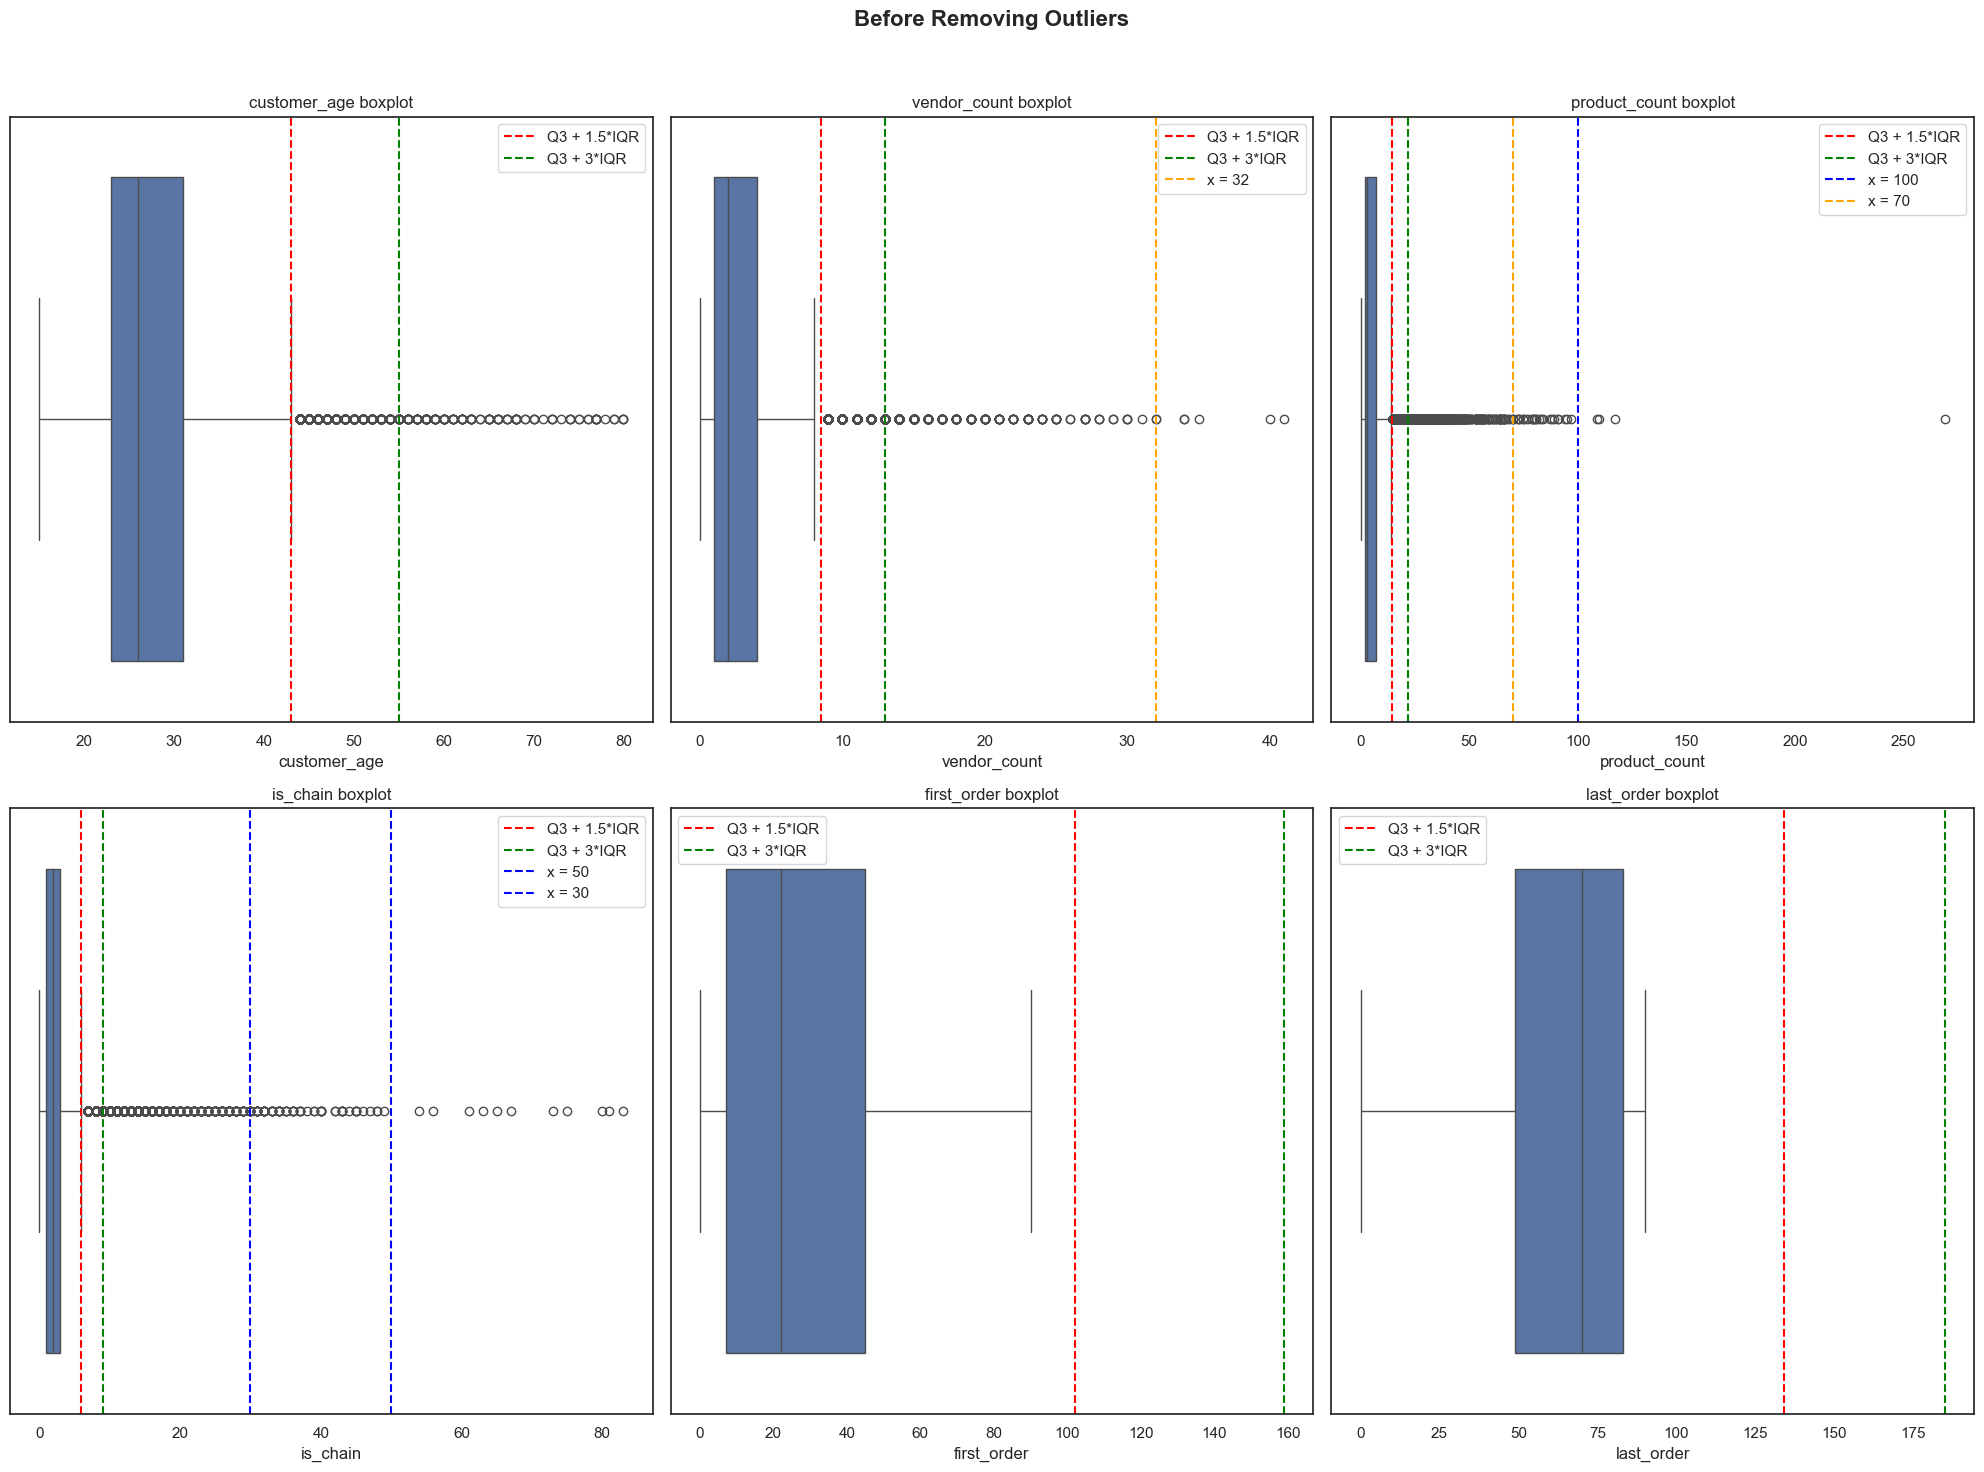

In [158]:
fig, axes = plt.subplots(2, 3, figsize=(20, 15))

# Loop through each feature and plot boxplots with vertical lines for Q3 + 1.5*IQR and Q3 + 3*IQR
for i, feature in enumerate(columns):
    ax = axes[i // 3, i % 3]
    
    # Calculate Q1, Q3, and IQR
    q1 = df_outliers[feature].quantile(0.25)
    q3 = df_outliers[feature].quantile(0.75)
    iqr = q3 - q1
    
    # Plot the boxplot
    sns.boxplot(x=df_outliers[feature], ax=ax)
    
    # Draw vertical lines for Q3 + 1.5*IQR and Q3 + 3*IQR
    ax.axvline(x=q3 + 1.5 * iqr, color='red', linestyle='--', label='Q3 + 1.5*IQR')
    ax.axvline(x=q3 + 3 * iqr, color='green', linestyle='--', label='Q3 + 3*IQR')
    if feature == 'vendor_count':
        ax.axvline(x=32, color='orange', linestyle='--', label='x = 32')


    if feature == 'product_count':
        ax.axvline(x=100, color='blue', linestyle='--', label='x = 100')
        ax.axvline(x=70, color='orange', linestyle='--', label='x = 70')


    if feature == 'is_chain':
        ax.axvline(x=50, color='blue', linestyle='--', label='x = 50')
        ax.axvline(x=30, color='blue', linestyle='--', label='x = 30')
    
    # Set titles
    ax.set_title(f"{feature} boxplot")
    ax.legend()

# Adding overall title
plt.suptitle("Before Removing Outliers", fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


Checking how many outliers we can remove following the 5% thumb rule

In [159]:
int(df_outliers.shape[0]*0.05)


1591

- Analyzing both strategies considered for the ***customer_age*** visual threshold

In [160]:
print(df_outliers.loc[df_outliers["customer_age"] > 32].shape[0])
print(df_outliers.loc[df_outliers["vendor_count"] > 14].shape[0])

5992
268


- Analyzing both strategies considered for the ***vendor_count*** visual threshold


In [161]:
print(df_outliers.loc[df_outliers["vendor_count"] > 32].shape[0])
print(df_outliers.loc[df_outliers["vendor_count"] > 14].shape[0])

5
268


- Analyzing both strategies considered for the ***product_count*** visual threshold



In [162]:
print(df_outliers.loc[df_outliers["product_count"] > 100].shape[0])
print(df_outliers.loc[df_outliers["product_count"] > 33].shape[0])


4
318


- Analyzing both strategies considered for ***is_chain***  visual threshold

In [163]:
print(df_outliers.loc[df_outliers["is_chain"] > 50].shape[0])
print(df_outliers.loc[df_outliers["is_chain"] > 30].shape[0])

11
78


Using IQR as a statistical tool to identify number of extreme and moderate outliers

In [164]:
num_outliers = 0
for variable in columns:
    outlier_detection(df_outliers, variable)


customer_age: 
Number of extreme outliers: 159 (15%) 
Number of moderate outliers: 896 (84%) 
Total number of outliers: 1055
Q3 + 1.5*IQR = 43.0 
Q3 + 3*IQR = 55.0
Max: 80.0 
Min: 15.0 
95th percentil: 41.0
99th percentil: 52.0 

vendor_count: 
Number of extreme outliers: 369 (26%) 
Number of moderate outliers: 1042 (73%) 
Total number of outliers: 1411
Q3 + 1.5*IQR = 8.5 
Q3 + 3*IQR = 13.0
Max: 41 
Min: 0 
95th percentil: 8.0
99th percentil: 14.0 

product_count: 
Number of extreme outliers: 932 (41%) 
Number of moderate outliers: 1336 (58%) 
Total number of outliers: 2268
Q3 + 1.5*IQR = 14.5 
Q3 + 3*IQR = 22.0
Max: 269 
Min: 0 
95th percentil: 18.0
99th percentil: 33.0 

is_chain: 
Number of extreme outliers: 1601 (57%) 
Number of moderate outliers: 1176 (42%) 
Total number of outliers: 2777
Q3 + 1.5*IQR = 6.0 
Q3 + 3*IQR = 9.0
Max: 83 
Min: 0 
95th percentil: 10.0
99th percentil: 19.0 

first_order: 
Number of extreme outliers: 0 (%) 
Number of moderate outliers: 0 (%) 
Total number

<div class="alert alert-block alert-info" style="font-size:16px">

### Key notes **`General`**
1. For the features that have outlier values, only 'is_chain' has a higher percentage of extreme values. This shows a greater variability in customer behaviour when deciding whether to make an order in a chain restaurant or not, possibly representing an important feature to differentiate client behaviour.
2. For all the features present in this group, we will end up always opting for the strategy of adjusting extreme outliers closer to a specifc threshold. What will vary is the threshold defined for each feature and the inital choices considered

### Key notes **`customer_age`**
1. From total outliers (1055), 896 are 'moderate' outliers and 159 are 'extreme' outliers 
2. Since we have a very left skewed distribution with 90% of the clients having less than 37 years old and considering the existance of outlier clients with more than 70 years, we considered two possible strategies: Either removing all the extreme values (clients with age over 55 years old) or adjusting values by capping the extreme values closer to the upper bound of extreme outliers (55 years old).
3. To avoid removing observations that reflect the variability in our dataset we opted for the second strategy


### Key notes **`vendor_count`**
1. From total outliers (1411), 1042 are 'moderate' outliers and 369 are 'extreme' outliers
2. Vendor_count is another feature with a left skewed distribution with 90% of clients ordering from less than 6 unique vendors.
3. Once again we will opt for the strategy of adjusting values by capping the extreme values closer to specified threhold. Here instead of defining the threshold based on the upper bound for extreme valeus (vendor count = 13) and to preserve the variability of clients behaviour we will define a visual threshold based on where the outlier density starts to decrease. Initially we selected the most obvious visual threshold with the selected value being 32. However, this would only affect 5 clients. Hence, we opted to define the treshold with the value 14 using the 99 percentil as the indicator. 268 clients would be affected by the changes


### Key notes **`product_count`**
1. From total outliers (2268), 1336 are 'moderate' outliers and 932 are 'extreme' outliers 
2. Product_count is another feature with a left skewed distribution with 90% of clients ordering a total of less than 12 products.
2. Once again opting for the startegy of capping the extreme values closer to a specificied threshold, we consideredd defining the threhold where the clear extreme outliers lie (product count over 100). However, this would result in only 4 clients being affected by the change. Beacuse of that, we opted to define a stronger threhold with value 33, based on the 99th percentil. In this case a total of 318 clients would be affected by the changes


### Key notes **`is_chain`**
1. From total outliers (2777), 1176 are 'moderate' outliers and 1601 are 'extreme' outliers. Only feature from this group with a higher percentage of extreme outliers.
2. This means we need to be extra vigilant on how we define the tresholds to capp the extreme values.
3. Is_chain is another feature with a left skewed distribution with 90% of clients making a total of 6 orders in chain restaurants
4. We considered defining the threhold where the clear extreme outliers lie (is_chain over 50). However, this would result in only 11 clients being affected by the change. Beacuse of that, we opted to define a stronger threhold with value 30, still quite above is_chain equal to 19 (99th percentil). In this case a total of 78 clients would be affected by the changes


### Key notes **`first_order and last_order`**

1. No presence of outliers

---

### **`CUI variables`**

In [178]:
columns_CUI = [element for element in df_outliers.columns if 'CUI' in str(element)]

Box plot of all CUI features to udnerstand them visually and indentify most adequate cleaning techniques

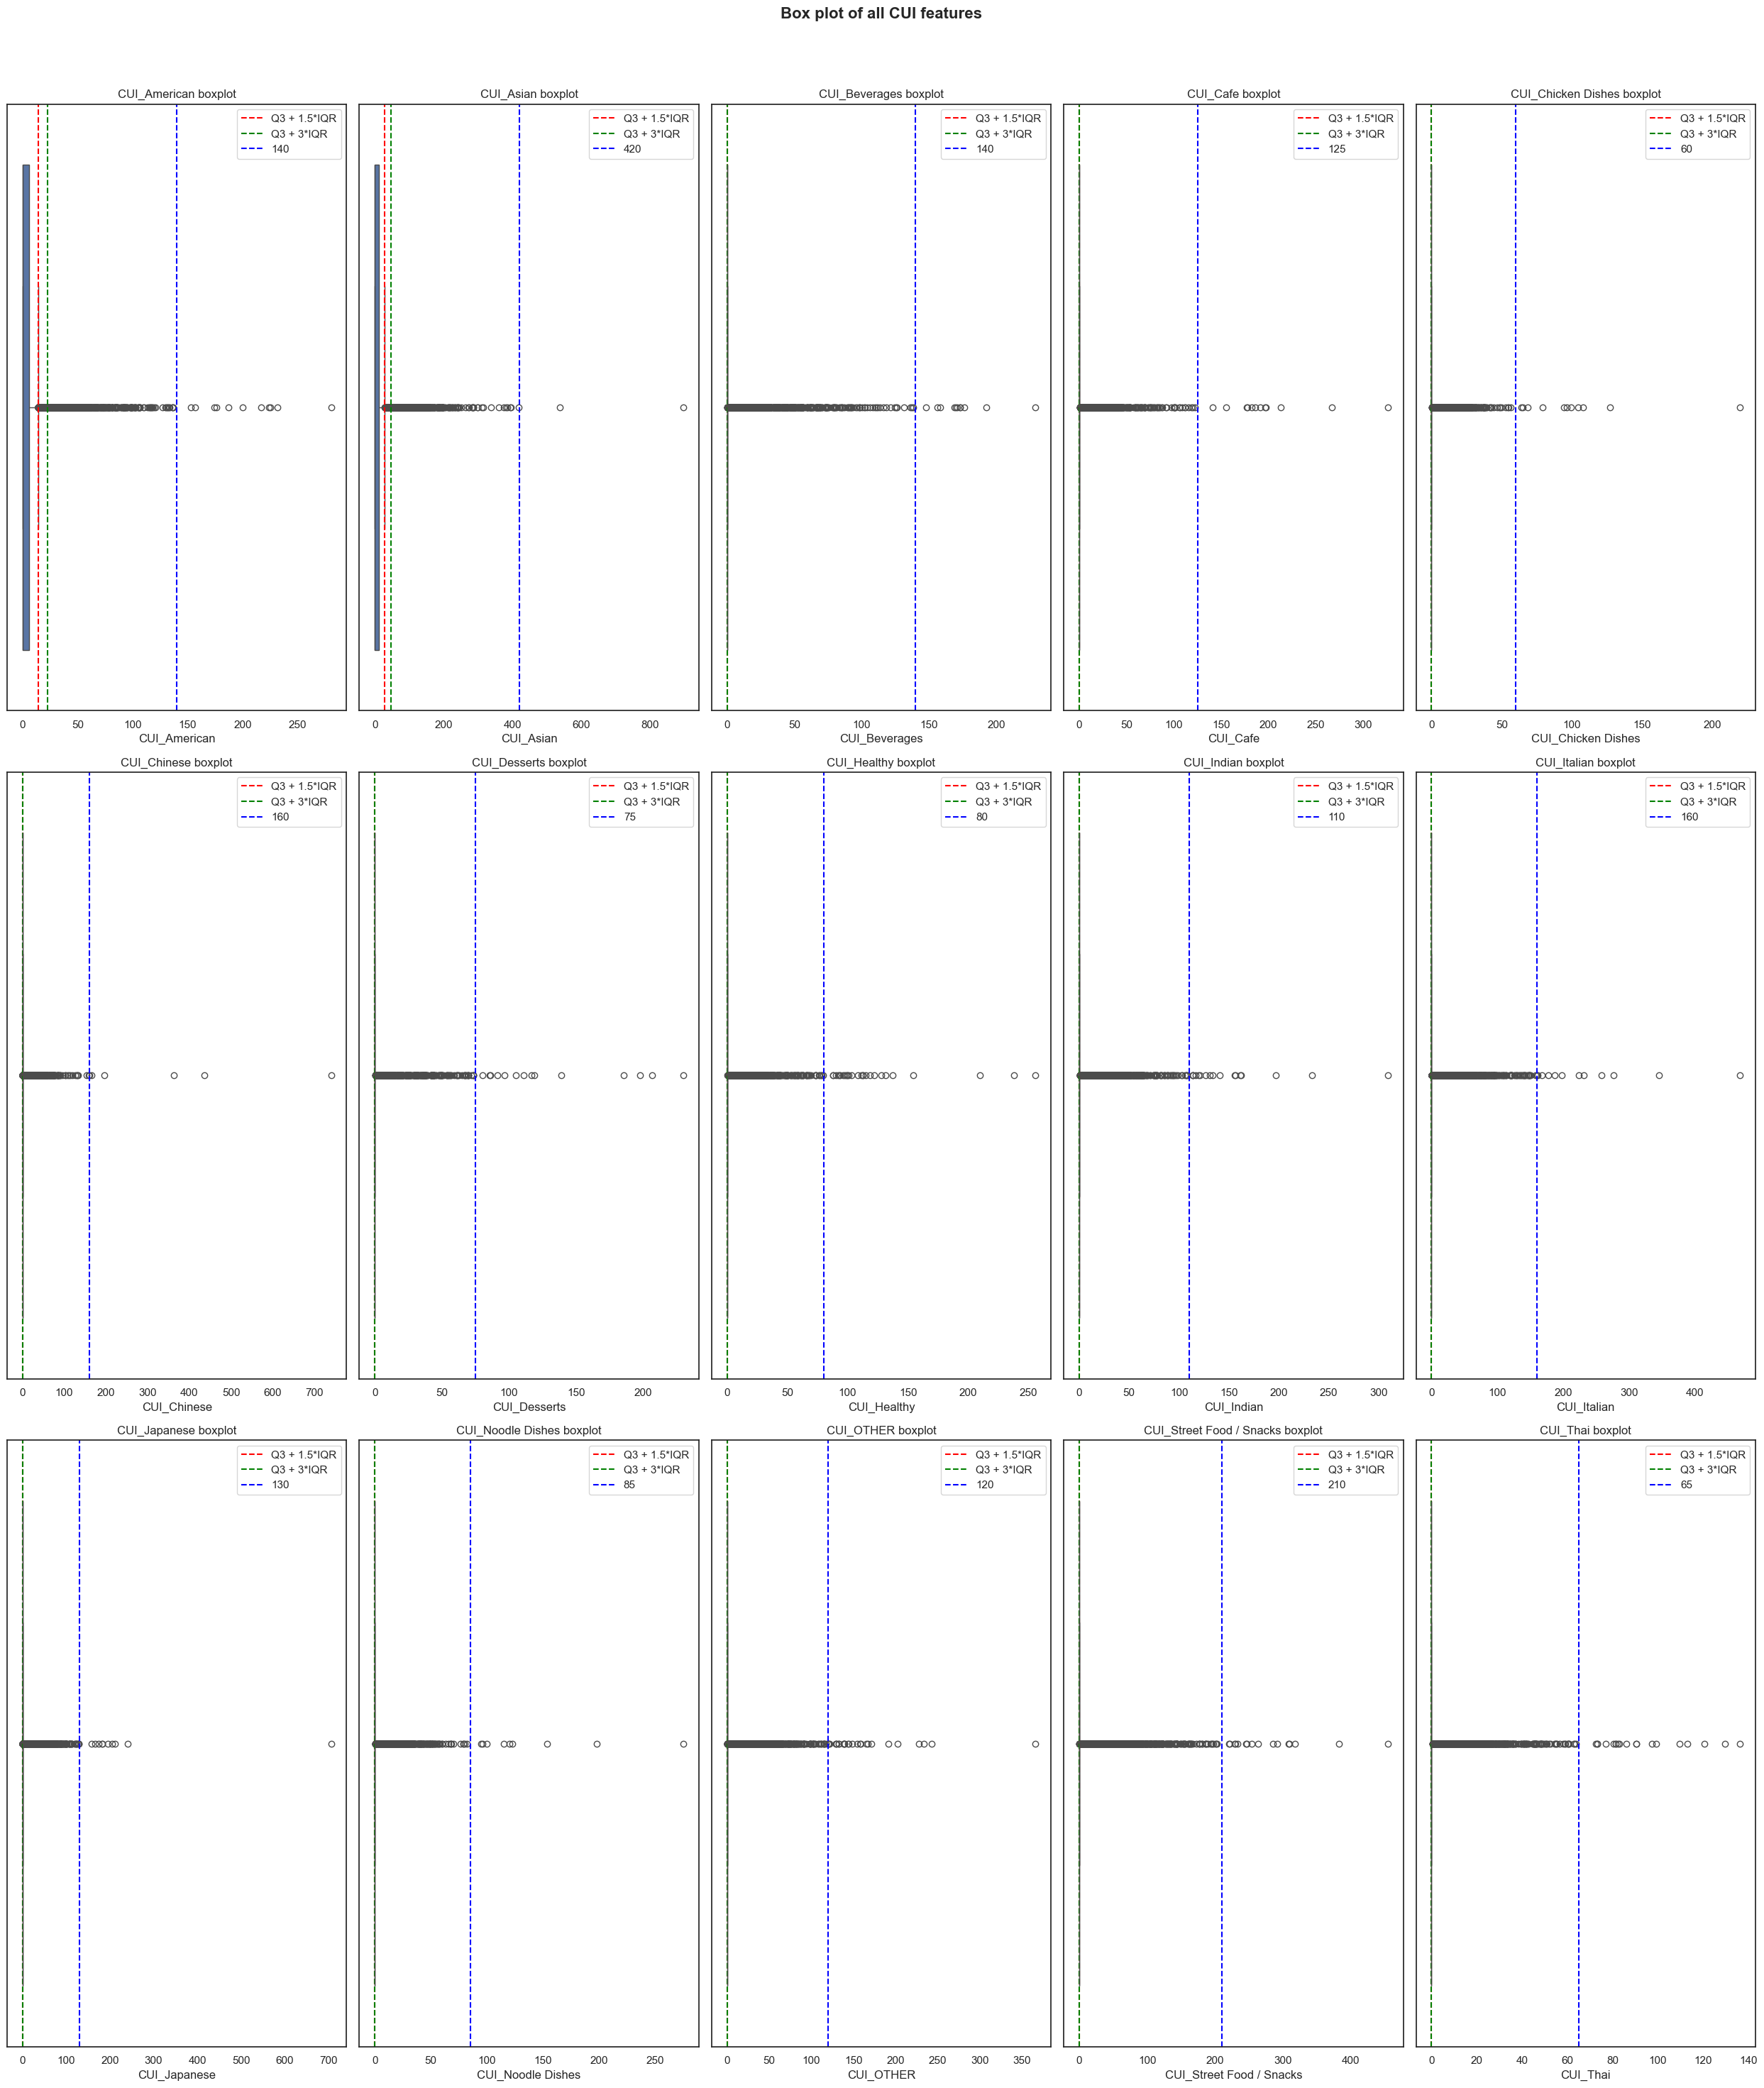

In [179]:
fig, axes = plt.subplots(3, 5, figsize=(25, 30))

# Loop through each feature and plot boxplots with vertical lines for Q3 + 1.5*IQR and Q3 + 3*IQR
for i, feature in enumerate(columns_CUI):
    ax = axes[i // 5, i % 5]
    
    # Calculate Q1, Q3, and IQR
    q1 = df_outliers[feature].quantile(0.25)
    q3 = df_outliers[feature].quantile(0.75)
    iqr = q3 - q1
    
    # Plot the boxplot
    sns.boxplot(x=df_outliers[feature], ax=ax)
    
    # Draw vertical lines for Q3 + 1.5*IQR and Q3 + 3*IQR
    ax.axvline(x=q3 + 1.5 * iqr, color='red', linestyle='--', label='Q3 + 1.5*IQR')
    ax.axvline(x=q3 + 3 * iqr, color='green', linestyle='--', label='Q3 + 3*IQR')

    if 'American' in feature:
        ax.axvline(x=140, color='blue', linestyle='--', label='140')
        #ax.axvline(x=250, color='orange', linestyle='--', label='250')

    if 'Asian' in feature:
        ax.axvline(x=420, color='blue', linestyle='--', label='420')

    if 'Beverages' in feature:
        ax.axvline(x=140, color='blue', linestyle='--', label='140')

    if 'Cafe' in feature:
        ax.axvline(x=125, color='blue', linestyle='--', label='125')

    if 'Chicken' in feature:
        ax.axvline(x=60, color='blue', linestyle='--', label='60')

    if 'Chinese' in feature:
        ax.axvline(x=160, color='blue', linestyle='--', label='160')

    if 'Desserts' in feature:
        ax.axvline(x=75, color='blue', linestyle='--', label='75')

    if 'Healthy' in feature:
        ax.axvline(x=80, color='blue', linestyle='--', label='80')

    if 'Indian' in feature:
        ax.axvline(x=110, color='blue', linestyle='--', label='110')

    if 'Italian' in feature:
        ax.axvline(x=160, color='blue', linestyle='--', label='160')
        
    if 'Japanese' in feature:
        ax.axvline(x=130, color='blue', linestyle='--', label='130')

    if 'Noodle' in feature:
        ax.axvline(x=85, color='blue', linestyle='--', label='85')

    if 'OTHER' in feature:
        ax.axvline(x=120, color='blue', linestyle='--', label='120')

    if 'Street' in feature:
        ax.axvline(x=210, color='blue', linestyle='--', label='210')

    if 'Thai' in feature:
        ax.axvline(x=65, color='blue', linestyle='--', label='65')

    
    # Set titles
    ax.set_title(f"{feature} boxplot")
    ax.legend()

# Adding overall title
plt.suptitle("Box plot of all CUI features", fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [180]:
df_outliers[columns_CUI].describe(percentiles=np.arange(0,1,0.1))

CUI_American     CUI_Asian  CUI_Beverages      CUI_Cafe  \
count  31828.000000  31828.000000   31828.000000  31828.000000   
mean       4.878717      9.959460       2.296773      0.802162   
std       11.652854     23.571343       8.470691      6.432826   
min        0.000000      0.000000       0.000000      0.000000   
0%         0.000000      0.000000       0.000000      0.000000   
10%        0.000000      0.000000       0.000000      0.000000   
20%        0.000000      0.000000       0.000000      0.000000   
30%        0.000000      0.000000       0.000000      0.000000   
40%        0.000000      0.000000       0.000000      0.000000   
50%        0.000000      0.000000       0.000000      0.000000   
60%        0.000000      0.000000       0.000000      0.000000   
70%        2.960000      6.339000       0.000000      0.000000   
80%        6.840000     16.582000       0.000000      0.000000   
90%       16.133000     30.650000       6.260000      0.000000   
max      280.210000    896.710000     229.220000    326.100000   

       CUI_Chicken Dishes   CUI_Chinese  CUI_Desserts   CUI_Healthy  \
count        31828.000000  31828.000000  31828.000000  31828.000000   
mean             0.768990      1.431904      0.884069      0.951931   
std              3.660007      8.196175      5.257256      5.835936   
min              0.000000      0.000000      0.000000      0.000000   
0%               0.000000      0.000000      0.000000      0.000000   
10%              0.000000      0.000000      0.000000      0.000000   
20%              0.000000      0.000000      0.000000      0.000000   
30%              0.000000      0.000000      0.000000      0.000000   
40%              0.000000      0.000000      0.000000      0.000000   
50%              0.000000      0.000000      0.000000      0.000000   
60%              0.000000      0.000000      0.000000      0.000000   
70%              0.000000      0.000000      0.000000      0.000000   
80%              0.000000      0.000000      0.000000      0.000000   
90%              0.963000      2.120000      0.000000      0.000000   
max            219.660000    739.730000    230.070000    255.810000   

         CUI_Indian   CUI_Italian  CUI_Japanese  CUI_Noodle Dishes  \
count  31828.000000  31828.000000  31828.000000       31828.000000   
mean       1.630242      3.234723      2.993057           0.712701   
std        7.443219     11.253846     10.182749           4.540379   
min        0.000000      0.000000      0.000000           0.000000   
0%         0.000000      0.000000      0.000000           0.000000   
10%        0.000000      0.000000      0.000000           0.000000   
20%        0.000000      0.000000      0.000000           0.000000   
30%        0.000000      0.000000      0.000000           0.000000   
40%        0.000000      0.000000      0.000000           0.000000   
50%        0.000000      0.000000      0.000000           0.000000   
60%        0.000000      0.000000      0.000000           0.000000   
70%        0.000000      0.000000      0.000000           0.000000   
80%        0.000000      1.008000      0.000000           0.000000   
90%        2.689000     10.410000     10.913000           0.000000   
max      309.070000    468.330000    706.140000         275.110000   

          CUI_OTHER  CUI_Street Food / Snacks      CUI_Thai  
count  31828.000000              31828.000000  31828.000000  
mean       3.002839                  3.906958      0.841754  
std        9.775722                 15.522462      4.435322  
min        0.000000                  0.000000      0.000000  
0%         0.000000                  0.000000      0.000000  
10%        0.000000                  0.000000      0.000000  
20%        0.000000                  0.000000      0.000000  
30%        0.000000                  0.000000      0.000000  
40%        0.000000                  0.000000      0.000000  
50%        0.000000                  0.000000      0.000000  
60%       

Using IQR as a statistical tool to identify number of extreme and moderate outliers

In [181]:
for variable in columns_CUI:
    outlier_detection(df_outliers, variable)


CUI_American: 
Number of extreme outliers: 1967 (56%) 
Number of moderate outliers: 1535 (43%) 
Total number of outliers: 3502
Q3 + 1.5*IQR = 14.15 
Q3 + 3*IQR = 22.64
Max: 280.21 
Min: 0.0 
95th percentil: 24.74
99th percentil: 53.43 

CUI_Asian: 
Number of extreme outliers: 1795 (51%) 
Number of moderate outliers: 1675 (48%) 
Total number of outliers: 3470
Q3 + 1.5*IQR = 29.58 
Q3 + 3*IQR = 47.32
Max: 896.71 
Min: 0.0 
95th percentil: 49.58
99th percentil: 106.12 

CUI_Beverages: 
Number of extreme outliers: 5423 (%) 
Number of moderate outliers: 0 (%) 
Total number of outliers: 5423
Q3 + 1.5*IQR = 0.0 
Q3 + 3*IQR = 0.0
Max: 229.22 
Min: 0.0 
95th percentil: 13.17
99th percentil: 37.9 

CUI_Cafe: 
Number of extreme outliers: 1363 (%) 
Number of moderate outliers: 0 (%) 
Total number of outliers: 1363
Q3 + 1.5*IQR = 0.0 
Q3 + 3*IQR = 0.0
Max: 326.1 
Min: 0.0 
95th percentil: 0.0
99th percentil: 21.79 

CUI_Chicken Dishes: 
Number of extreme outliers: 3246 (%) 
Number of moderate outli

Analyzing number of clients affected using the ***visual threshold strategy*** initially identified for ***CUI variables***

In [168]:
visual_tresholds_defined = [140,420,140,125,60,160,75,80,110,160,130,85,120,210,65]
for feature, visual_thresh in zip(columns_CUI, visual_tresholds_defined):
    clients_affected = df_outliers.loc[df_outliers[feature] > visual_thresh].shape[0]
    print(f"Number of {feature} clients affected using the visual threshold {visual_thresh} ---> {clients_affected} ")

Number of CUI_American clients affected using the visual threshold 140 ---> 11 
Number of CUI_Asian clients affected using the visual threshold 420 ---> 2 
Number of CUI_Beverages clients affected using the visual threshold 140 ---> 11 
Number of CUI_Cafe clients affected using the visual threshold 125 ---> 12 
Number of CUI_Chicken Dishes clients affected using the visual threshold 60 ---> 11 
Number of CUI_Chinese clients affected using the visual threshold 160 ---> 6 
Number of CUI_Desserts clients affected using the visual threshold 75 ---> 14 
Number of CUI_Healthy clients affected using the visual threshold 80 ---> 27 
Number of CUI_Indian clients affected using the visual threshold 110 ---> 17 
Number of CUI_Italian clients affected using the visual threshold 160 ---> 12 
Number of CUI_Japanese clients affected using the visual threshold 130 ---> 10 
Number of CUI_Noodle Dishes clients affected using the visual threshold 85 ---> 9 
Number of CUI_OTHER clients affected using the 

Analyzing number of clients affected using the ***99.9th percentil strategy*** for ***CUI variables***

In [182]:
for feature in columns_CUI:
    percentil_99 = df_outliers[feature].quantile(0.99)
    clients_affected = df_outliers.loc[df_outliers[feature] > percentil_99].shape[0]
    print(f"Number of {feature} clients affected using the 99th percentil is {clients_affected} ")


Number of CUI_American clients affected using the 99th percentil is 319 
Number of CUI_Asian clients affected using the 99th percentil is 319 
Number of CUI_Beverages clients affected using the 99th percentil is 319 
Number of CUI_Cafe clients affected using the 99th percentil is 318 
Number of CUI_Chicken Dishes clients affected using the 99th percentil is 319 
Number of CUI_Chinese clients affected using the 99th percentil is 319 
Number of CUI_Desserts clients affected using the 99th percentil is 319 
Number of CUI_Healthy clients affected using the 99th percentil is 319 
Number of CUI_Indian clients affected using the 99th percentil is 319 
Number of CUI_Italian clients affected using the 99th percentil is 319 
Number of CUI_Japanese clients affected using the 99th percentil is 319 
Number of CUI_Noodle Dishes clients affected using the 99th percentil is 319 
Number of CUI_OTHER clients affected using the 99th percentil is 319 
Number of CUI_Street Food / Snacks clients affected us

<div class="alert alert-block alert-info" style="font-size:16px">

### Key notes **`General`**
1. The number of outliers for all CUI features is very high since the most values tend be close or equal to 0
2. Most CUI features only have extreme outliers. This happens because the upper bound for extreme and moderate outliers are both equal to 0 (Q3 + 1.5*IQR = Q3 + 3*IQR =0) The higher than usual % of extreme outliers suggests significant variability in client spending. This variability can reflect unique purchasing patterns and consequently mean that certain CUI features could be excelent indicators to differentiate clients in different clusters
2. 'CUI_America' and 'CUI_Asia' represent the exceptions being the most popular cuisines in terms of total spending
3. To decide on the type of startegy to apply for this group of features we need to consider the fact that despite being extreme values, outliers regrarding the amount spent in each cuisine represent legitimate clients pruchasing behaviour and eliminating them seems to be an imprudent way leading to a more biassed dataset
4. Hence the strategy applied will be the following: for each CUI feature, we will adjust extreme values to a specific threshold for each feature. This threshold will either be defined visually based on where the outlier density starts to decrease or based on the 99th percentil depending on total observation affected. After analyzing the number of clients affected in both situations we ended up choosing the latter strategy for all CUI features 
5. Asian and Japanese cuisines have the biggest spending outliers. Could be good options as features capable of differentiating groups of clients

### Key notes **`CUI_American`**
1. From total outliers (3502), 1535 are 'moderate' outliers and 1967 are 'extreme' outliers 
2. Number of clients affected using the 99.9th percentil strategy --> check above
3. Number of clients affected using the visual threshold defined at $140 strategy --> check above

### Key notes **`CUI_Asian`**
1. From total outliers (3470), 1675 are 'moderate' outliers and 1795 are 'extreme' outliers
2. Number of clients affected using the 99.9th percentil strategy --> check above
3. Number of clients affected using the visual threshold defined at $420 strateg --> check above


### Key notes **`CUI_Beverages`**
1. From total outliers (5423), 0 are 'moderate' outliers and 5423 are 'extreme' outliers 
2. Number of clients affected using the 99.9th percentil strategy --> check above
3. Number of clients affected using the visual threshold defined at $140 strategy --> check above

### Key notes **`CUI_Cafe`**
1. From total outliers (1363), 0 are 'moderate' outliers and 1363 are 'extreme' outliers 
2. Number of clients affected using the 99.9th percentil strategy --> check above
3. Number of clients affected using the visual threshold defined at $125 strategy --> check above   

### Key notes **`CUI_Chicken Dishes`**
1. From total outliers (3246), 0 are 'moderate' outliers and 3246 are 'extreme' outliers 
2. Number of clients affected using the 99.9th percentil strategy --> check above
3. Number of clients affected using the visual threshold defined at $60 strategy --> check above   

### Key notes **`CUI_Chinese`**
1. From total outliers (3518), 0 are 'moderate' outliers and 3518 are 'extreme' outliers 
2. Number of clients affected using the 99.9th percentil strategy --> check above
3. Number of clients affected using the visual threshold defined at $160 strategy --> check above  


### Key notes **`CUI_Desserts`**
1. From total outliers (2013), 0 are 'moderate' outliers and 2013 are 'extreme' outliers 
2. Number of clients affected using the 99.9th percentil strategy --> check above
3. Number of clients affected using the visual threshold defined at $75 strategy --> check above


### Key notes **`CUI_Healthy`**
1. From total outliers (2168), 0 are 'moderate' outliers and 2168 are 'extreme' outliers 
2. Number of clients affected using the 99.9th percentil strategy --> check above
3. Number of clients affected using the visual threshold defined at $80 strategy --> check above   


### Key notes **`CUI_Indian`**
1. From total outliers (3440), 0 are 'moderate' outliers and 3440 are 'extreme' outliers 
2. Number of clients affected using the 99.9th percentil strategy --> check above
3. Number of clients affected using the visual threshold defined at $110 strategy --> check above   

### Key notes **`CUI_Italian`**
1. From total outliers (6439), 0 are 'moderate' outliers and 6439 are 'extreme' outliers 
2. Number of clients affected using the 99.9th percentil strategy --> check above
3. Number of clients affected using the visual threshold defined at $160 strategy --> check above   

### Key notes **`CUI_Japanese`**
1. From total outliers (6286), 0 are 'moderate' outliers and 6286 are 'extreme' outliers 
2. Number of clients affected using the 99.9th percentil strategy --> check above
3. Number of clients affected using the visual threshold defined at $130 strategy --> check above  

### Key notes **`CUI_Noodle Dishes`**
1. From total outliers (2224), 0 are 'moderate' outliers and 2224 are 'extreme' outliers 
2. Number of clients affected using the 99.9th percentil strategy --> check above
3. Number of clients affected using the visual threshold defined at $85 strategy--> check above  


### Key notes **`CUI_OTHER`**
1. From total outliers (7033), 0 are 'moderate' outliers and 7033 are 'extreme' outliers 
2. Number of clients affected using the 99.9th percentil strategy --> check above
3. Number of clients affected using the visual threshold defined at $120 strategy  --> check above 


### Key notes **`CUI_Street Food/Snacks`**
1. From total outliers (4239), 0 are 'moderate' outliers and 4239 are 'extreme' outliers 
2. Number of clients affected using the 99.9th percentil strategy --> check above
3. Number of clients affected using the visual threshold defined at $210 strategy --> check above   


### Key notes **`CUI_Thai`**
1. From total outliers (2373), 0 are 'moderate' outliers and 2373 are 'extreme' outliers 
2. Number of clients affected using the 99.9th percentil strategy --> check above
3. Number of clients affected using the visual threshold defined at $65 strategy --> check above  


---

### **`DOW variables`**

In [183]:
columns_DOW = [element for element in df_outliers.columns if 'DOW' in str(element)]

Box plot of all ***DOW features*** to udnerstand them visually and indentify most adequate cleaning techniques

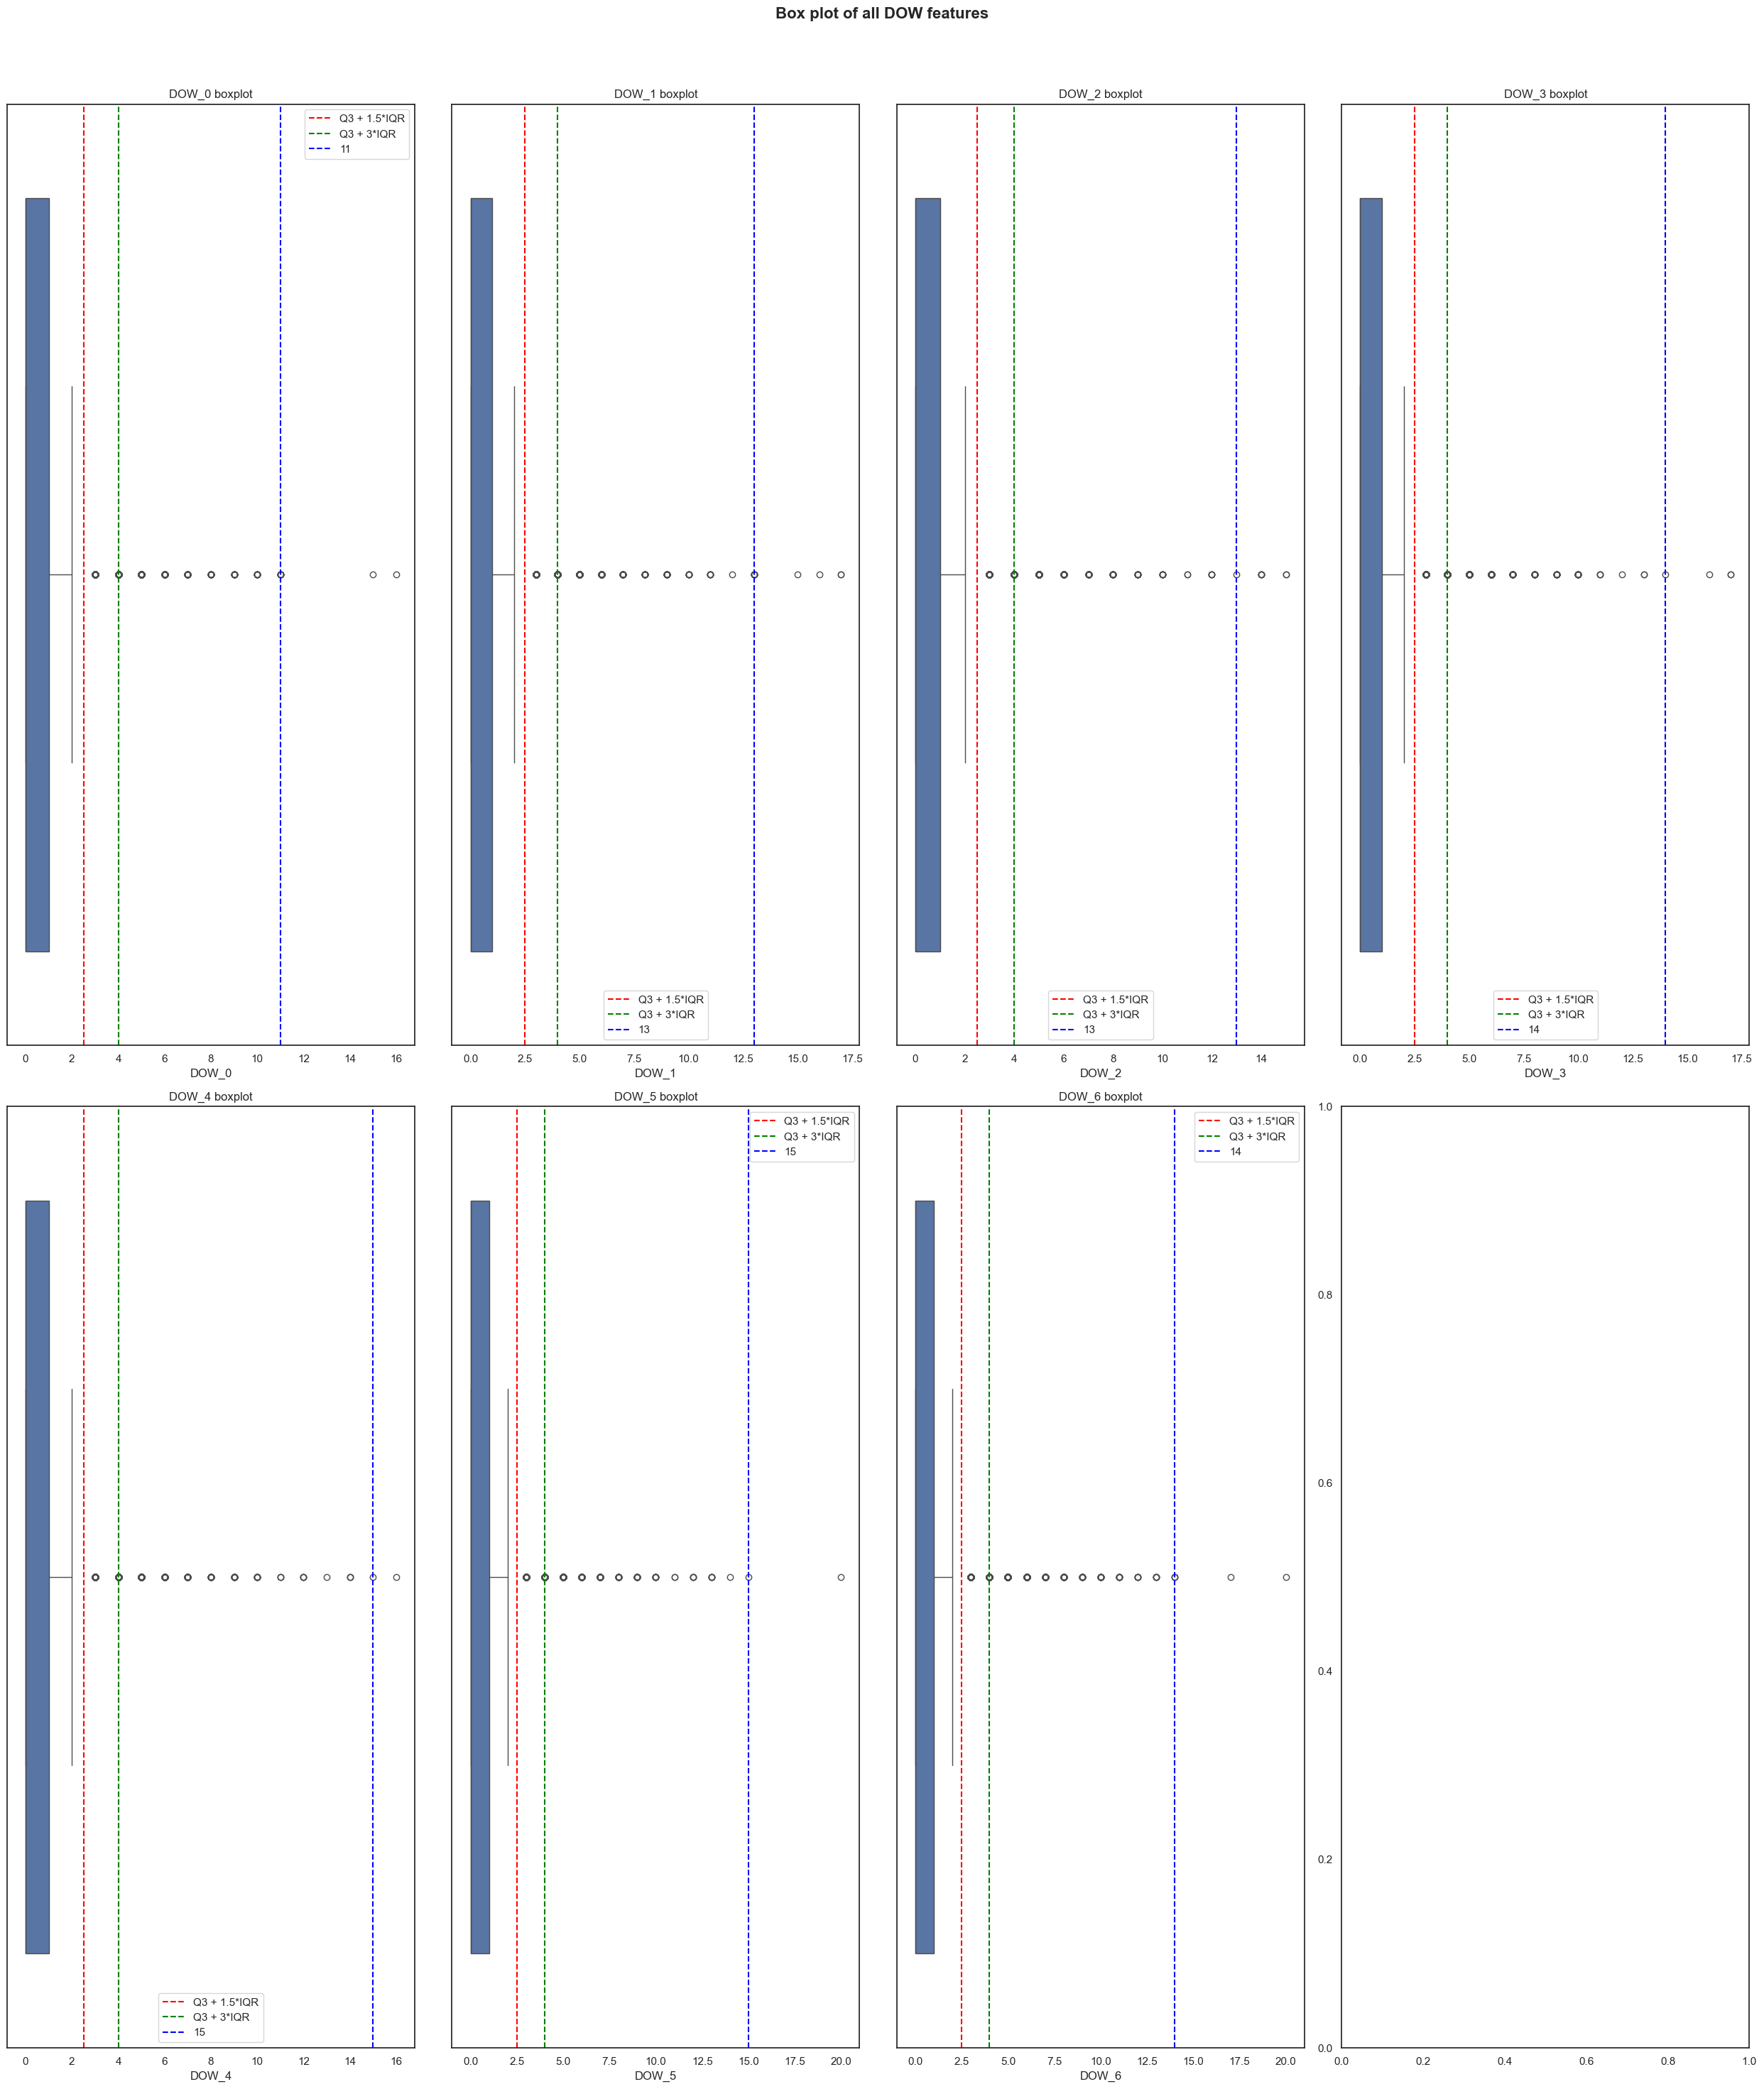

In [184]:
fig, axes = plt.subplots(2, 4, figsize=(25, 30))

# Loop through each feature and plot boxplots with vertical lines for Q3 + 1.5*IQR and Q3 + 3*IQR
for i, feature in enumerate(columns_DOW):
    ax = axes[i // 4, i % 4]
    
    # Calculate Q1, Q3, and IQR
    q1 = df_outliers[feature].quantile(0.25)
    q3 = df_outliers[feature].quantile(0.75)
    iqr = q3 - q1
    
    # Plot the boxplot
    sns.boxplot(x=df_outliers[feature], ax=ax)
    
    # Draw vertical lines for Q3 + 1.5*IQR and Q3 + 3*IQR
    ax.axvline(x=q3 + 1.5 * iqr, color='red', linestyle='--', label='Q3 + 1.5*IQR')
    ax.axvline(x=q3 + 3 * iqr, color='green', linestyle='--', label='Q3 + 3*IQR')

    if '0' in feature:
        ax.axvline(x=11, color='blue', linestyle='--', label='11')

    if '1' in feature:
        ax.axvline(x=13, color='blue', linestyle='--', label='13')

    if '2' in feature:
        ax.axvline(x=13, color='blue', linestyle='--', label='13')


    if '3' in feature:
        ax.axvline(x=14, color='blue', linestyle='--', label='14')

    if '5' in feature:
        ax.axvline(x=15, color='blue', linestyle='--', label='15')

    if '4' in feature:
        ax.axvline(x=15, color='blue', linestyle='--', label='15')

    if '6' in feature:
        ax.axvline(x=14, color='blue', linestyle='--', label='14')

    
    # Set titles
    ax.set_title(f"{feature} boxplot")
    ax.legend()

# Adding overall title
plt.suptitle("Box plot of all DOW features", fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [185]:
df_outliers[columns_DOW].describe(percentiles=np.arange(0,1,0.1))

DOW_0         DOW_1         DOW_2         DOW_3         DOW_4  \
count  31828.000000  31828.000000  31828.000000  31828.000000  31828.000000   
mean       0.555894      0.567771      0.590801      0.619297      0.677957   
std        1.013460      1.044383      1.045672      1.069931      1.088231   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
0%         0.000000      0.000000      0.000000      0.000000      0.000000   
10%        0.000000      0.000000      0.000000      0.000000      0.000000   
20%        0.000000      0.000000      0.000000      0.000000      0.000000   
30%        0.000000      0.000000      0.000000      0.000000      0.000000   
40%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
60%        0.000000      0.000000      0.000000      0.000000      1.000000   
70%        1.000000      1.000000      1.000000      1.000000      1.000000   
80%        1.000000      1.000000      1.000000      1.000000      1.000000   
90%        2.000000      2.000000      2.000000      2.000000      2.000000   
max       16.000000     17.000000     15.000000     17.000000     16.000000   

              DOW_5         DOW_6  
count  31828.000000  31828.000000  
mean       0.652947      0.704254  
std        1.069820      1.167516  
min        0.000000      0.000000  
0%         0.000000      0.000000  
10%        0.000000      0.000000  
20%        0.000000      0.000000  
30%        0.000000      0.000000  
40%        0.000000      0.000000  
50%        0.000000      0.000000  
60%        1.000000      1.000000  
70%        1.000000      1.000000  
80%        1.000000      1.000000  
90%        2.000000      2.000000  
max       20.000000     20.000000

Using IQR as a statistical tool to identify number of extreme and moderate outliers

In [172]:
for variable in columns_DOW:
    outlier_detection(df_outliers, variable)

DOW_0: 
Number of extreme outliers: 323 (30%) 
Number of moderate outliers: 747 (69%) 
Total number of outliers: 1070
Q3 + 1.5*IQR = 2.5 
Q3 + 3*IQR = 4.0
Max: 16 
Min: 0 
95th percentil: 2.0
99th percentil: 5.0 

DOW_1: 
Number of extreme outliers: 324 (28%) 
Number of moderate outliers: 810 (71%) 
Total number of outliers: 1134
Q3 + 1.5*IQR = 2.5 
Q3 + 3*IQR = 4.0
Max: 17 
Min: 0 
95th percentil: 2.0
99th percentil: 5.0 

DOW_2: 
Number of extreme outliers: 359 (28%) 
Number of moderate outliers: 893 (71%) 
Total number of outliers: 1252
Q3 + 1.5*IQR = 2.5 
Q3 + 3*IQR = 4.0
Max: 15 
Min: 0 
95th percentil: 2.0
99th percentil: 5.0 

DOW_3: 
Number of extreme outliers: 378 (29%) 
Number of moderate outliers: 909 (70%) 
Total number of outliers: 1287
Q3 + 1.5*IQR = 2.5 
Q3 + 3*IQR = 4.0
Max: 17 
Min: 0 
95th percentil: 3.0
99th percentil: 5.0 

DOW_4: 
Number of extreme outliers: 376 (27%) 
Number of moderate outliers: 1007 (72%) 
Total number of outliers: 1383
Q3 + 1.5*IQR = 2.5 
Q3 + 

Analyzing number of clients affected using the ***visual threshold strategy*** initially identified for ***DOW variables***

In [173]:
visual_tresholds_defined = [11,13,13,14,15,15,14]
for feature, visual_thresh in zip(columns_DOW, visual_tresholds_defined):
    clients_affected = df_outliers.loc[df_outliers[feature] > visual_thresh].shape[0]
    print(f"Number of {feature} clients affected using the visual threshold {visual_thresh} ---> {clients_affected} ")

Number of DOW_0 clients affected using the visual threshold 11 ---> 2 
Number of DOW_1 clients affected using the visual threshold 13 ---> 4 
Number of DOW_2 clients affected using the visual threshold 13 ---> 7 
Number of DOW_3 clients affected using the visual threshold 14 ---> 3 
Number of DOW_4 clients affected using the visual threshold 15 ---> 1 
Number of DOW_5 clients affected using the visual threshold 15 ---> 1 
Number of DOW_6 clients affected using the visual threshold 14 ---> 2 


Analyzing number of clients affected using the ***99.9th percentil strategy*** for ***DOW variables***

In [174]:
for feature in columns_DOW:
    percentil_99 = df_outliers[feature].quantile(0.99)
    clients_affected = df_outliers.loc[df_outliers[feature] > percentil_99].shape[0]
    print(f"Number of {feature} clients affected using the 99.9th percentil is {clients_affected} ")


Number of DOW_0 clients affected using the 99.9th percentil is 182 
Number of DOW_1 clients affected using the 99.9th percentil is 185 
Number of DOW_2 clients affected using the 99.9th percentil is 185 
Number of DOW_3 clients affected using the 99.9th percentil is 204 
Number of DOW_4 clients affected using the 99.9th percentil is 208 
Number of DOW_5 clients affected using the 99.9th percentil is 189 
Number of DOW_6 clients affected using the 99.9th percentil is 282 


<div class="alert alert-block alert-info" style="font-size:16px">

### Key notes **`General`**
1. The number of orders per day seem to be homeogenously distributed (left skewed) with all the features showing a prevelance of moderate outliers (80%). 
2. The higher % of moderate outliers suggests significantly less variability in client's number of orders per day of the week compared to variability showed in client spending per cuisine type. (might not be as good to diferentiate clients into different groups)
3. For all DOW features, the extreme (Q3 + 3*IQR) and moderate outliers (Q3 + 1.5*IQR) thresholds are always 3 and 1.5 respectively
4. Despite the existance of less extreme outliers to avoid reducing total number of observations, we will once again adjust values by capping the extreme values closer to a reasonable maximum. 
5. To do so we will apply one of 2 strategies:
    - a visual threshold based on where the outlier density starts to decrease or based on a proxy threshold when it is harder to find a visual treshold (find similarly distributed day and apply it's visually defined threshold)
    - based on the 99th percentil of each feature


### Key notes **`DOW_0`** (Sunday)
1. From total outliers (1070), 747 are 'moderate' outliers and 323 are 'extreme' outliers
2. Number of clients affected using the 99th percentil strategy --> check above
3. Number of clients affected using the visual threshold defined at 11 orders --> check above

### Key notes **`DOW_1`** (Monday)
1. From total outliers (1134), 810 are 'moderate' outliers and 324 are 'extreme' outliers
2. Number of clients affected using the 99th percentil strategy --> check above
3. Number of clients affected using the visual threshold defined at 13 orders --> check above


### Key notes **`DOW_2`** (Tuesday)
1. From total outliers (1252), 893 are 'moderate' outliers and 359 are 'extreme' outliers 
2. Harder to define visual threshold. So we had to think about a different strategy
3. If we used IQR as a statistical tool to define either Q3 + 1.5*IQR or Q3 + 3*IQR as the reasonable maximum, we would remove more outliers in this feature compared to the other DOW features. Concsidering that we used the following solution: Since we know from previous indivudal analyzis that all DOW features are similarly distributed with Thrusdays, Fridays and Saturdays being the days with the most orders, we will use DOW_1 as a proxy and use it's thrreshold for DOW_2 
4. Number of clients affected using the 99th percentil strategy --> check above
5. Number of clients affected using the visual threshold defined at 13 orders --> check above


### Key notes **`DOW_3`** (Wednesday)
1. From total outliers (1287), 909 are 'moderate' outliers and 378 are 'extreme' outliers
2. Number of clients affected using the 99th percentil strategy --> check above
3. Number of clients affected using the visual threshold defined at 14 orders --> check above


### Key notes **`DOW_4`** (Thrusday)
1. From total outliers (1383), 1007 are 'moderate' outliers and 376 are 'extreme' outliers 
2. Harder to define visual threshold so we will apply a similar logic to the one used for DOW_2. In this case, we will use DOW_5 as a proxy for DOW_4 (Thursday)
3. Number of clients affected using the 99th percentil strategy --> check above
4. Number of clients affected using the visual threshold defined at 15 orders --> check above


### Key notes **`DOW_5`** (Friday)
1. From total outliers (1326), 979 are 'moderate' outliers and 347 are 'extreme' outliers
2. Number of clients affected using the 99th percentil strategy --> check above
3. Number of clients affected using the visual threshold defined at 15  orders --> check above


### Key notes **`DOW_6`** (Saturday)
1. From total outliers (1503), 1017 are 'moderate' outliers and 486 are 'extreme' outliers
2. Number of clients affected using the 99th percentil strategy --> check above
3. Number of clients affected using the visual threshold defined at 14 orders --> check above



---

### **`HR variables`**

In [176]:
columns_HR = [element for element in df_outliers.columns if 'HR' in str(element)]

Box plot of all HR features to understand them visually and identify most adequate cleaning techniques

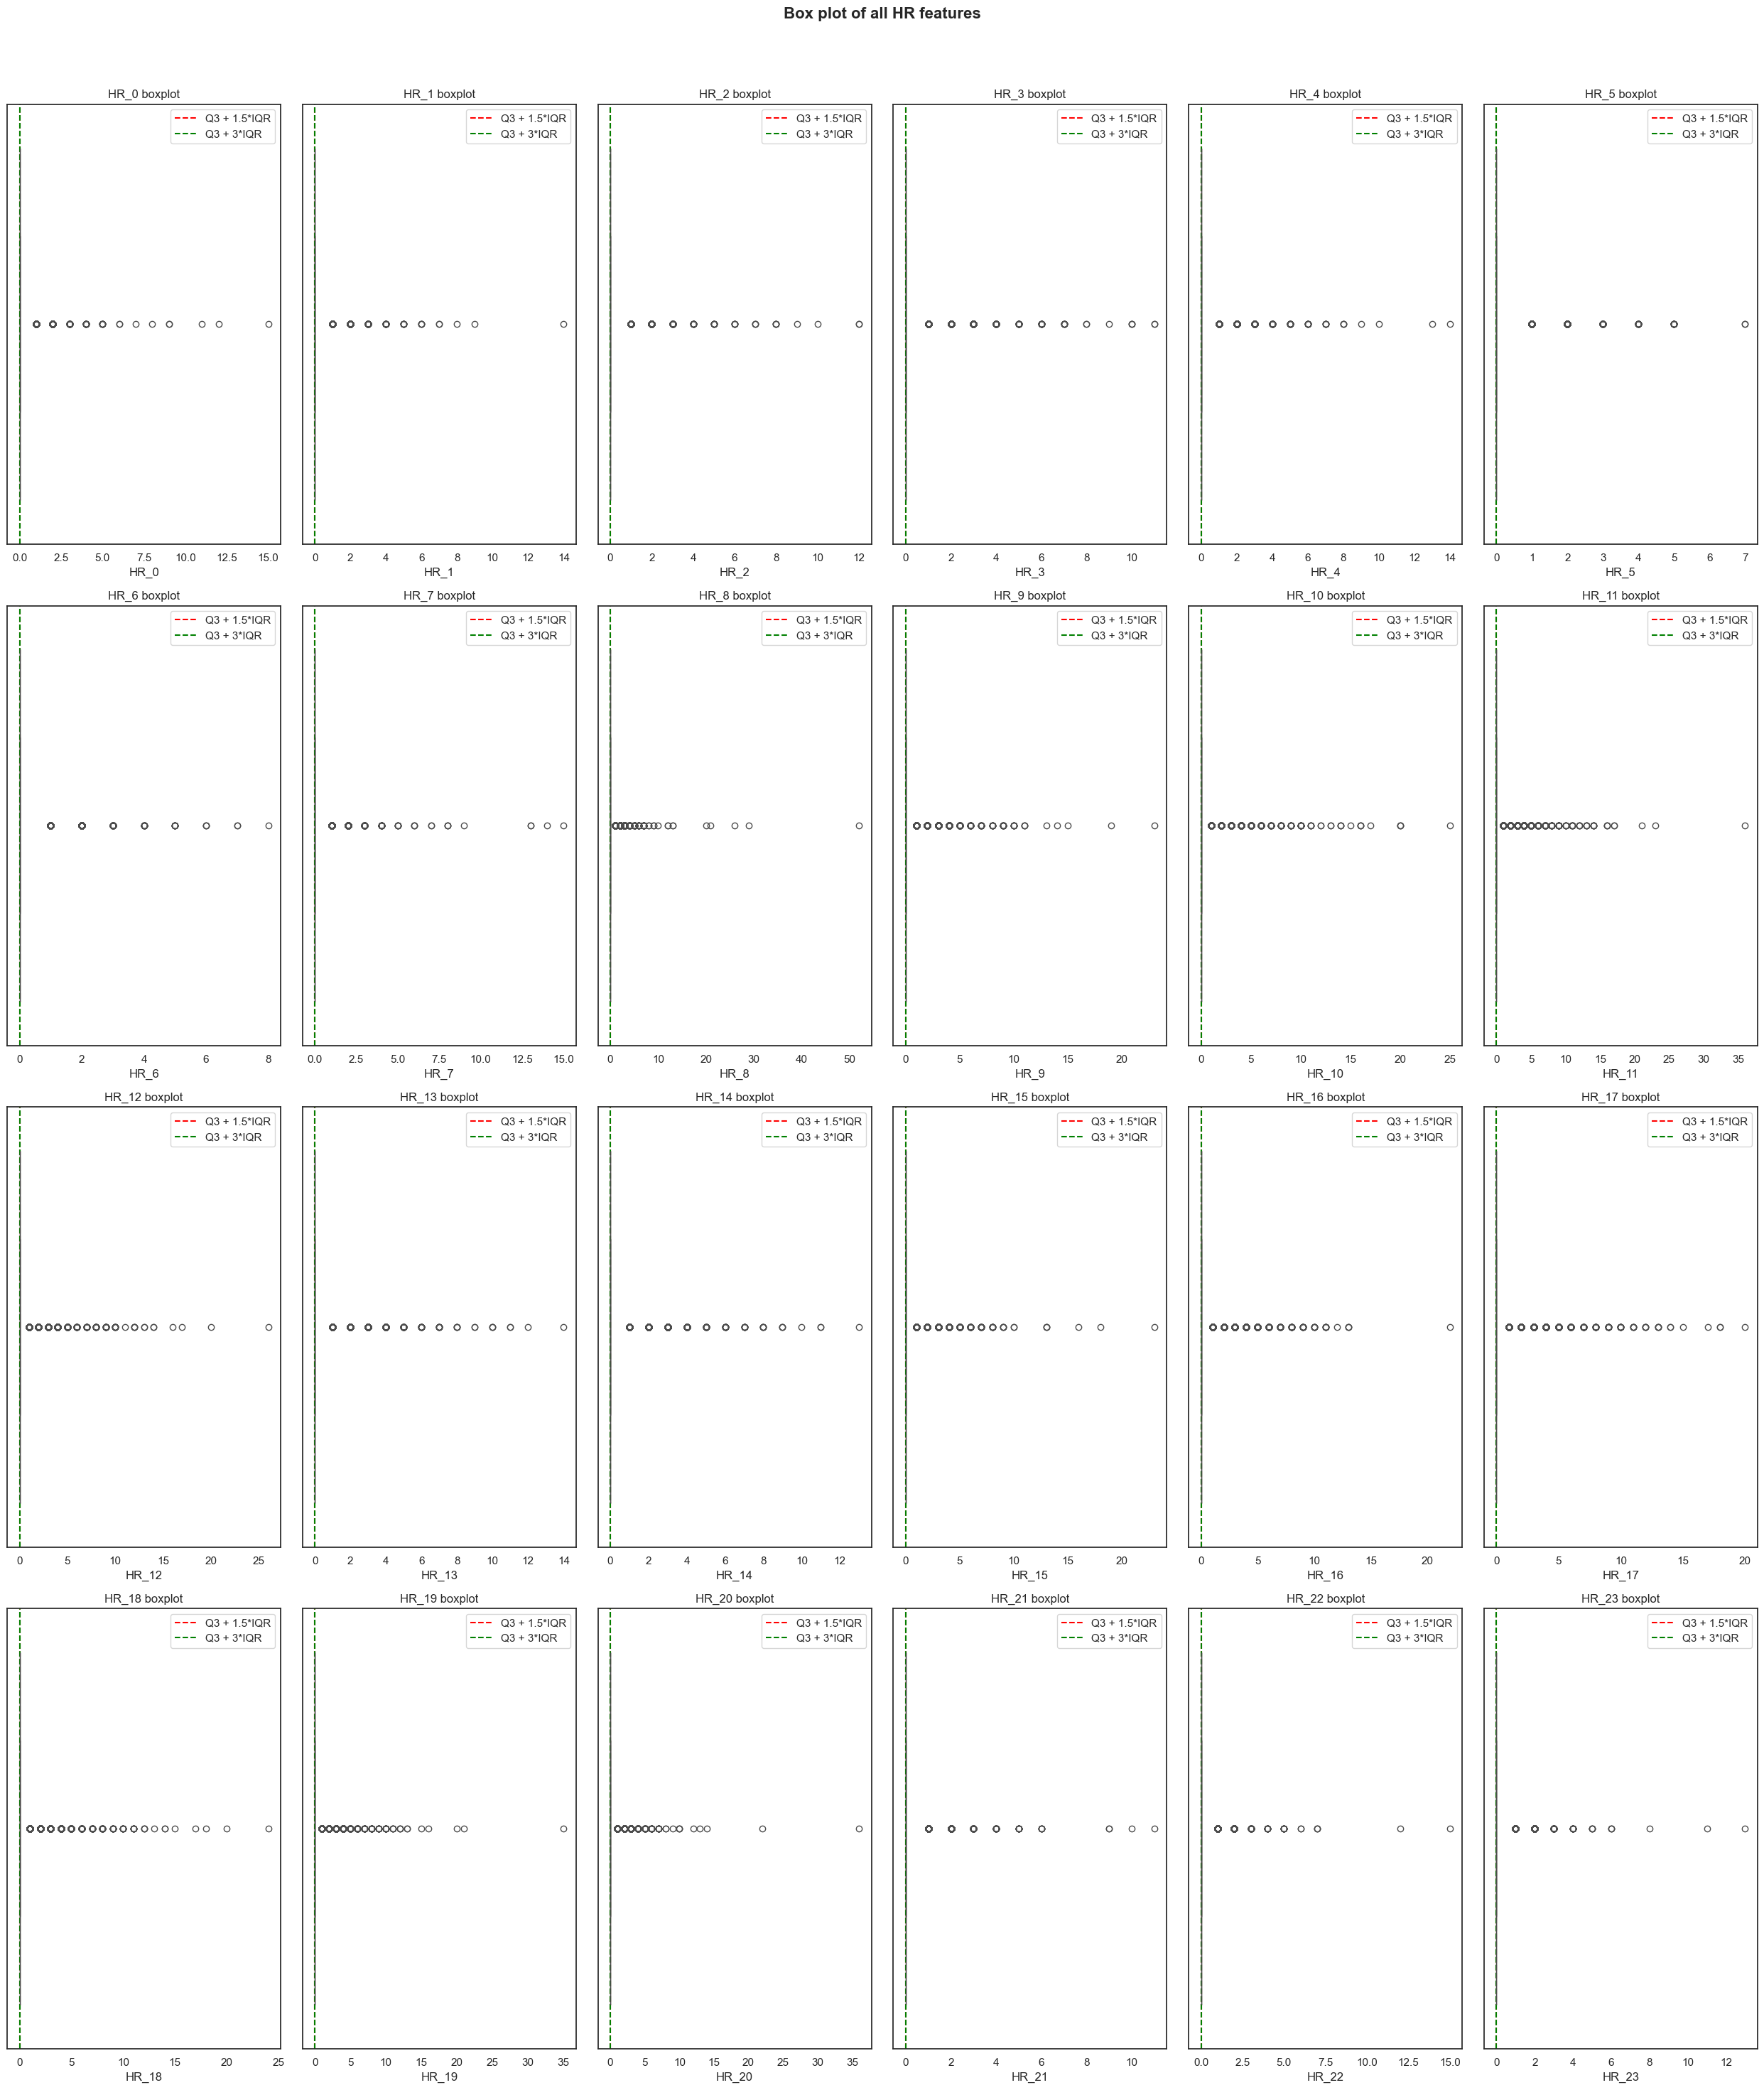

In [177]:
fig, axes = plt.subplots(4, 6, figsize=(25, 30))

# Loop through each feature and plot boxplots with vertical lines for Q3 + 1.5*IQR and Q3 + 3*IQR
for i, feature in enumerate(columns_HR):
    ax = axes[i // 6, i % 6]
    
    # Calculate Q1, Q3, and IQR
    q1 = df_outliers[feature].quantile(0.25)
    q3 = df_outliers[feature].quantile(0.75)
    iqr = q3 - q1
    
    # Plot the boxplot
    sns.boxplot(x=df_outliers[feature], ax=ax)
    
    # Draw vertical lines for Q3 + 1.5*IQR and Q3 + 3*IQR
    ax.axvline(x=q3 + 1.5 * iqr, color='red', linestyle='--', label='Q3 + 1.5*IQR')
    ax.axvline(x=q3 + 3 * iqr, color='green', linestyle='--', label='Q3 + 3*IQR')

    #if '0' in feature:
        #ax.axvline(x=11, color='blue', linestyle='--', label='11')

    
    # Set titles
    ax.set_title(f"{feature} boxplot")
    ax.legend()

# Adding overall title
plt.suptitle("Box plot of all HR features", fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


Using IQR as a statistical tool to identify number of extreme and moderate outliers

In [186]:
for variable in columns_HR:
    outlier_detection(df_outliers, variable)

HR_0: 
Number of extreme outliers: 1164 (%) 
Number of moderate outliers: 0 (%) 
Total number of outliers: 1164
Q3 + 1.5*IQR = 0.0 
Q3 + 3*IQR = 0.0
Max: 15.0 
Min: 0.0 
95th percentil: 0.0
99th percentil: 1.0 

HR_1: 
Number of extreme outliers: 1280 (%) 
Number of moderate outliers: 0 (%) 
Total number of outliers: 1280
Q3 + 1.5*IQR = 0.0 
Q3 + 3*IQR = 0.0
Max: 14 
Min: 0 
95th percentil: 0.0
99th percentil: 1.0 

HR_2: 
Number of extreme outliers: 1488 (%) 
Number of moderate outliers: 0 (%) 
Total number of outliers: 1488
Q3 + 1.5*IQR = 0.0 
Q3 + 3*IQR = 0.0
Max: 12 
Min: 0 
95th percentil: 0.0
99th percentil: 1.0 

HR_3: 
Number of extreme outliers: 2520 (%) 
Number of moderate outliers: 0 (%) 
Total number of outliers: 2520
Q3 + 1.5*IQR = 0.0 
Q3 + 3*IQR = 0.0
Max: 11 
Min: 0 
95th percentil: 1.0
99th percentil: 2.0 

HR_4: 
Number of extreme outliers: 2362 (%) 
Number of moderate outliers: 0 (%) 
Total number of outliers: 2362
Q3 + 1.5*IQR = 0.0 
Q3 + 3*IQR = 0.0
Max: 14 
Min: 0

***HR histograms***

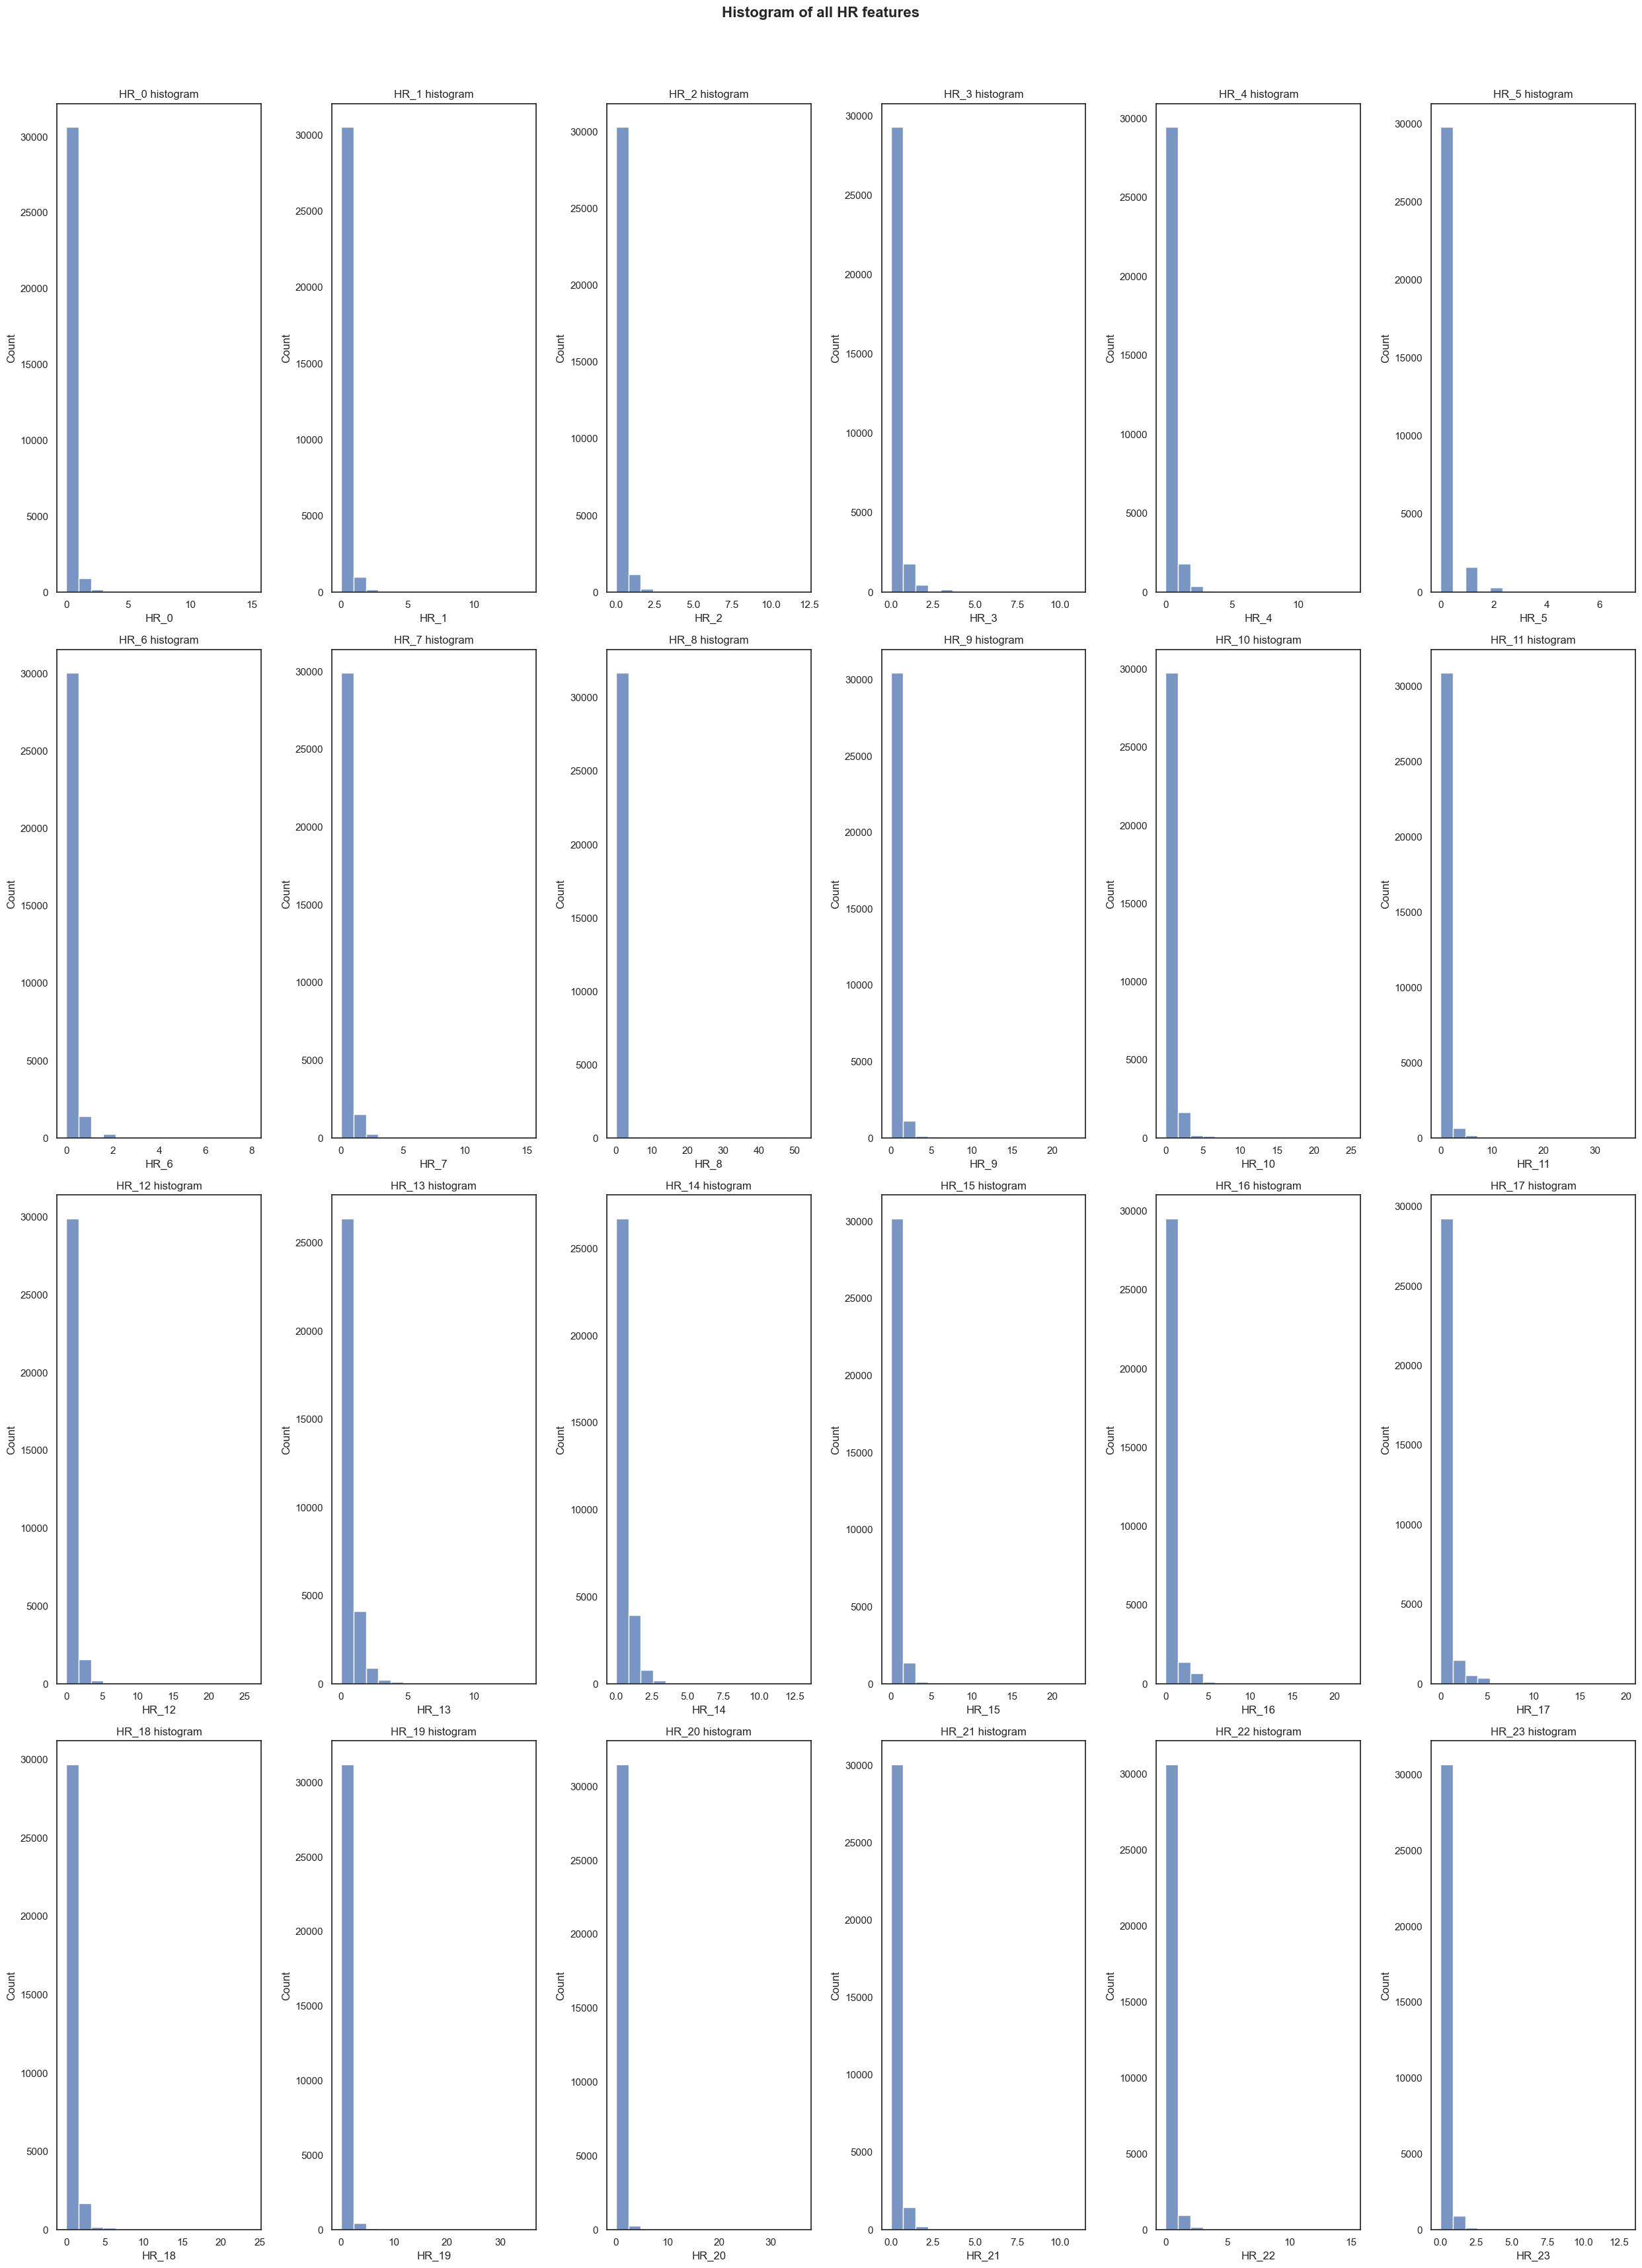

In [188]:
fig, axes = plt.subplots(4, 6, figsize=(25, 35))

# Loop through each feature and plot histograms with vertical lines for Q3 + 1.5*IQR and Q3 + 3*IQR
for i, feature in enumerate(columns_HR):
    ax = axes[i // 6, i % 6]
     
    # Plot the histogram
    sns.histplot(df_outliers[feature], bins=15, kde=False, ax=ax)
    
    # Set titles
    ax.set_title(f"{feature} histogram")

# Adding overall title
plt.suptitle("Histogram of all HR features", fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


Client Order Distribution per Hour (Zero vs. Non-Zero Orders)

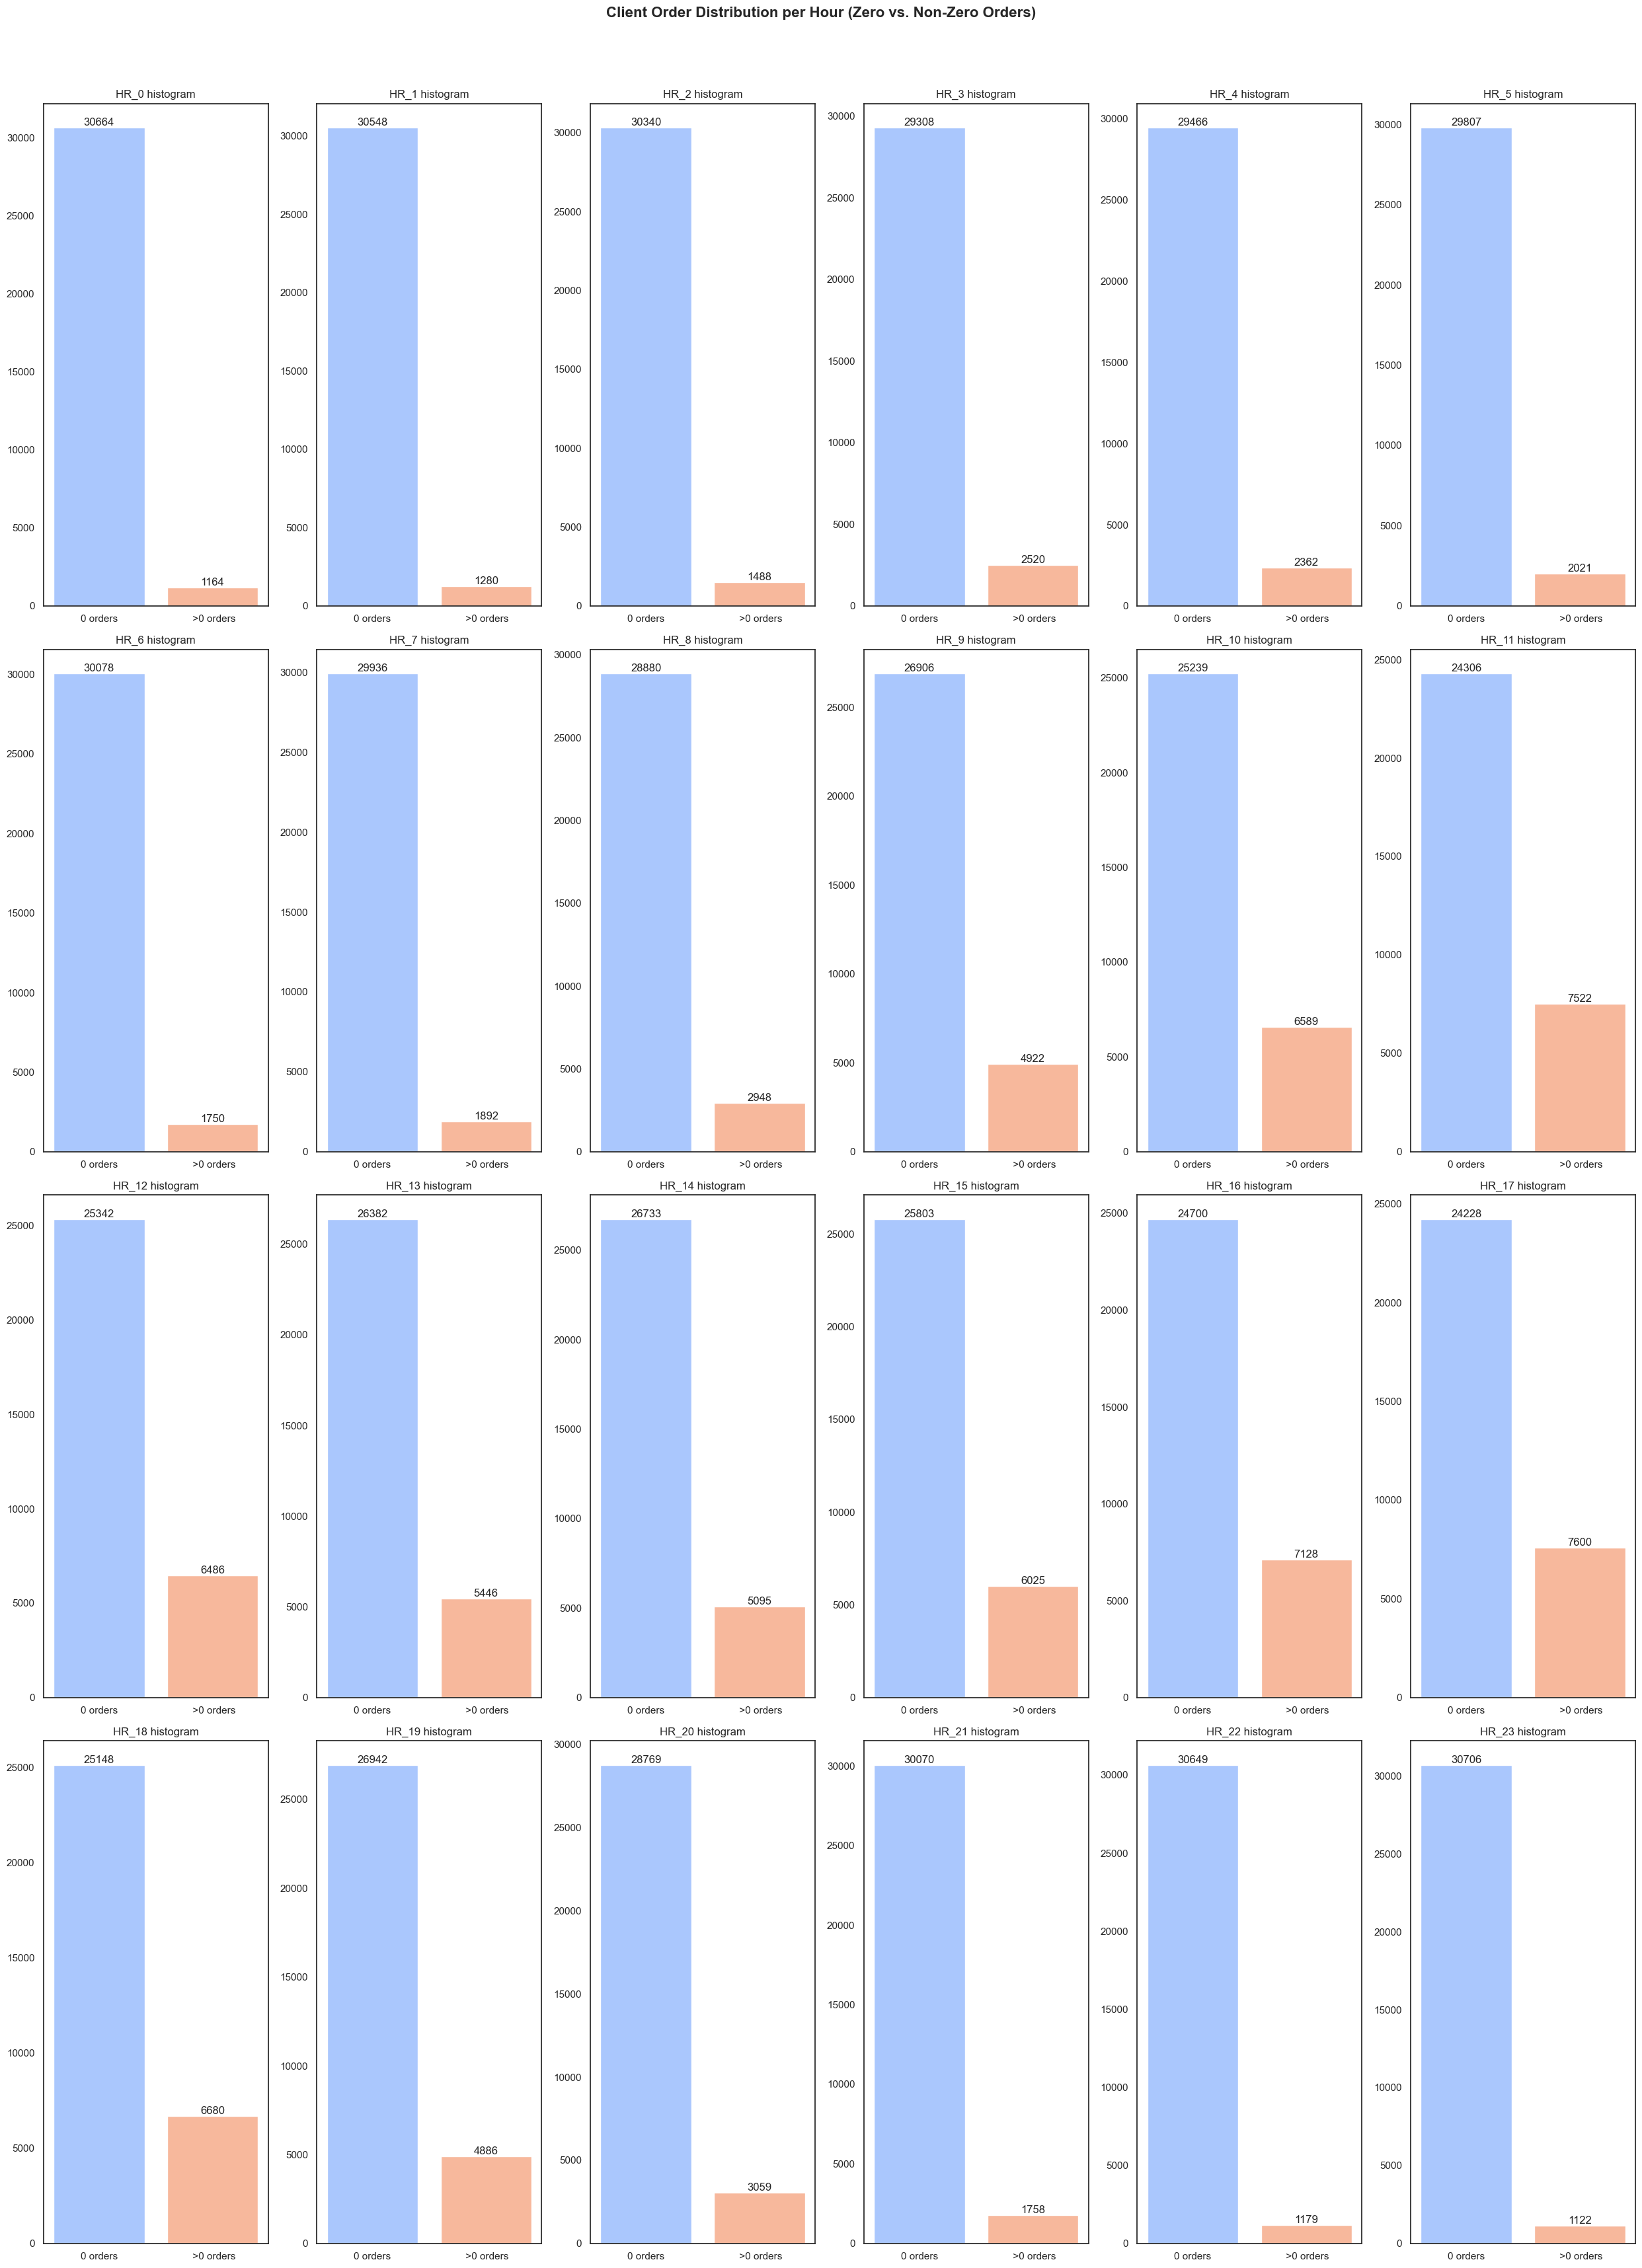

In [190]:
fig, axes = plt.subplots(4, 6, figsize=(25, 35))
bar_color = sns.color_palette("coolwarm", len(x_values))

# Loop through each feature and plot histograms with vertical lines for Q3 + 1.5*IQR and Q3 + 3*IQR
for i, feature in enumerate(columns_HR):
    ax = axes[i // 6, i % 6]
    x_values = ["0 orders", " >0 orders"]
    clients_with_0_orders = df_outliers.loc[df_outliers[feature] == 0].shape[0]

    clients_with_none_0_orders = df_outliers.loc[df_outliers[feature] > 0].shape[0]
    y_values = [clients_with_0_orders, clients_with_none_0_orders]
    
    p = ax.bar(x_values, y_values, color= bar_color)
    ax.bar_label(p, labels= [str(element) for element in y_values])
    
    # Set titles
    ax.set_title(f"{feature} histogram")

# Adding overall title
plt.suptitle("Client Order Distribution per Hour (Zero vs. Non-Zero Orders)", fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

<div class="alert alert-block alert-info" style="font-size:16px">

### Key notes **`General`**
1. As we can see from both the histogram and boxplots, all the HR features are heavily skewed to the left. This happens due to the fact that most clients in each hour do not make any orders
2. To averiguate this, we categorized each HR feature into 2 categories: clients with 0 orders and client with none 0 orders in the 'Client Order Distribution per Hour (Zero vs. Non-Zero Orders)' plot
    - We can confirm what we expected: for each feature the majority class is always the clients with 0 orders
    - Thi ssituation can also be seen above where we print the number of outliers and the upper limit for moderate outliers and extreme outliers for each feature. For every feature, the upper limti for moderate and extreme outliers is 0.

3. Considering the existence of 2 hidden categories in these numerical features, it doesn't seem statistically prudent to remove any outliers based soly on the analyzis of each original HR features.


---

## 4.2 **Bivariate outliers for numeric features**

> To determine the multidimension outliers between numerical features, we will use **Mahalanobis distance**.

#### **Mahalanobis distance**

Represents a statistical measure that determines how far away a datapoint is from the mean of a multivariate distribution taking into account correlations between variables. 

<img src="/Users/joaohenriques/Desktop/Mestrados/Data Science Nova IMS/My docs/Data Mining/Project/figures/Mahalanobis distance.png" alt="Mahalanobis distance formula"
width="400">

- S: semi-definite covariance matrix
- x_vector: multivariate data point
- mu_vector: multivariate mean

#### **Determining outliers using the Mahalanobis distance**

Since the Mahalanobis distance determines how much a data point deviates from the centre distribution, we can determine outliers following the steps below:
1. Compute the Mahalanobis distance for the features we are interested on evaluating the presence of multivariate outliers
2. Pair plot each pair of features grouped by different thresholds of Mahalanobis and define threshold where points with a higher Mahalanobis distance will be classified as outliers.
3. After determining the threshold, visually identify outliers to be removed. We opted for the visualization method instead of using the chi-square test to idnetify the vivariate outliers in ordert to have more control over the total number of outliers we want to remove 



In [192]:
def mahalanobis_distance (data = None):
    #x: dataset we are wroking with
    #data: ndarray of the dataset from which we want to compute the mahalanobis distance
    data = data.astype(float)
    x_minus_mu = data -np.mean(data)
    cov = np.cov(data.values.T)
    inv_covmat = scipy.linalg.inv(cov)
    left_term = np.dot(x_minus_mu, inv_covmat)
    mahal = np.dot(left_term, x_minus_mu.T)
    return np.sqrt(mahal.diagonal())



def flag_outliers(df, mahal, threshold):
    
    # Identify outliers
    outlier = []
    for index, value in enumerate(mahal):
        if value > threshold:
            outlier.append(index)
        else:
            continue

    # Create the flag
    flag = []
    for index in range(df.shape[0]):
        if index in outliers:
            flag.append(1)
        else:
            flag.append(0)
    return flag, outlier



Creating new dataframe withotu NaN values since the mahalanobis distance doesn't work with NaN values

In [193]:
df_outliers_na = df_outliers.copy()
df_outliers_na.dropna(inplace=True)

In [195]:
sns.set_style("white")

columns = ['customer_age', 'vendor_count', 'product_count', 'is_chain', 'first_order', 'last_order']
#columns = ['customer_age', 'vendor_count', 'product_count', 'is_chain']
df_g1 = df_outliers_na[columns]

combinations = list(itertools.combinations(columns, 2))
print(combinations)


fig, axes = plt.subplots(3, 5, figsize=(25, 15))

# Loop through each feature and plot boxplots with vertical lines for Q3 + 1.5*IQR and Q3 + 3*IQR
for i, (feat1, feat2) in enumerate(combinations):
    ax = axes[i // 5, i % 5]
    
    # Calculate Mahalanobis distance for each pair of features
    df_g1['mahala'] = mahalanobis_distance(df_g1[[feat1, feat2]])
    
    # Plot Mahalanobis distances
    sns.scatterplot(x=df_g1[feat1], y=df_g1[feat2], hue=df_g1['mahala'], ax=ax, palette="coolwarm")
    
    # Set titles
    ax.set_title(f"Mahalanobis Distance: {feat1} vs {feat2}")
    ax.legend()

# Adding overall title
plt.suptitle("Pair plot grouped by different thresholds of Mahalanobis distances", fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


<div class="alert alert-block alert-info" style="font-size:16px">

### Key notes **`General`**
1. Each pair plot is being grouped by different thresholds of Mahalanobis distances.
2. The higher the threshold (warmer colors), the less outliers will be identified usign the mahalanobis distance
3. Since we haven't treated any univaririate outliers, the most extreme mahalanobis distances correspond to univariate outliers for their respective features. Additionaly, we had to drop nan values without applying any of the suugested 'cleaning' solution suggested in the 3. Analyzing nan values. Hence we whould only analyze the bivariate outliers after preprocessing the initial outliers (as a distance, mahalanobis distance is is stronghly influenced by outliers) and applying the suggested solution to the nan values

### Key notes **`Removal criteria`**
1. For each pair plots with the exception of first_order with last_order, vendor_count with last_order and customer_age with last_order, we could start by removing the very extreme outliers represented in red.
2. However, we can see that those points correspond to univariate outliers in their respective features.


### Key notes **`Exception pairs criteria`**
1. The pair plots mentioned above were refered as an exception since each pair has a higher amount of red colour outliers identified. 
2. We would need to proceed with caution in order to avoid removing importat observations from our dataset

---

## 4.3 **Outliers for categorical features**

In [196]:
cat_features = ["customer_region", "last_promo", "payment_method", "payment_method_combined", "city"]
num_features = [element for element in df.columns if element not in cat_features]

Bar Plot of Selected Categorical Features in original df

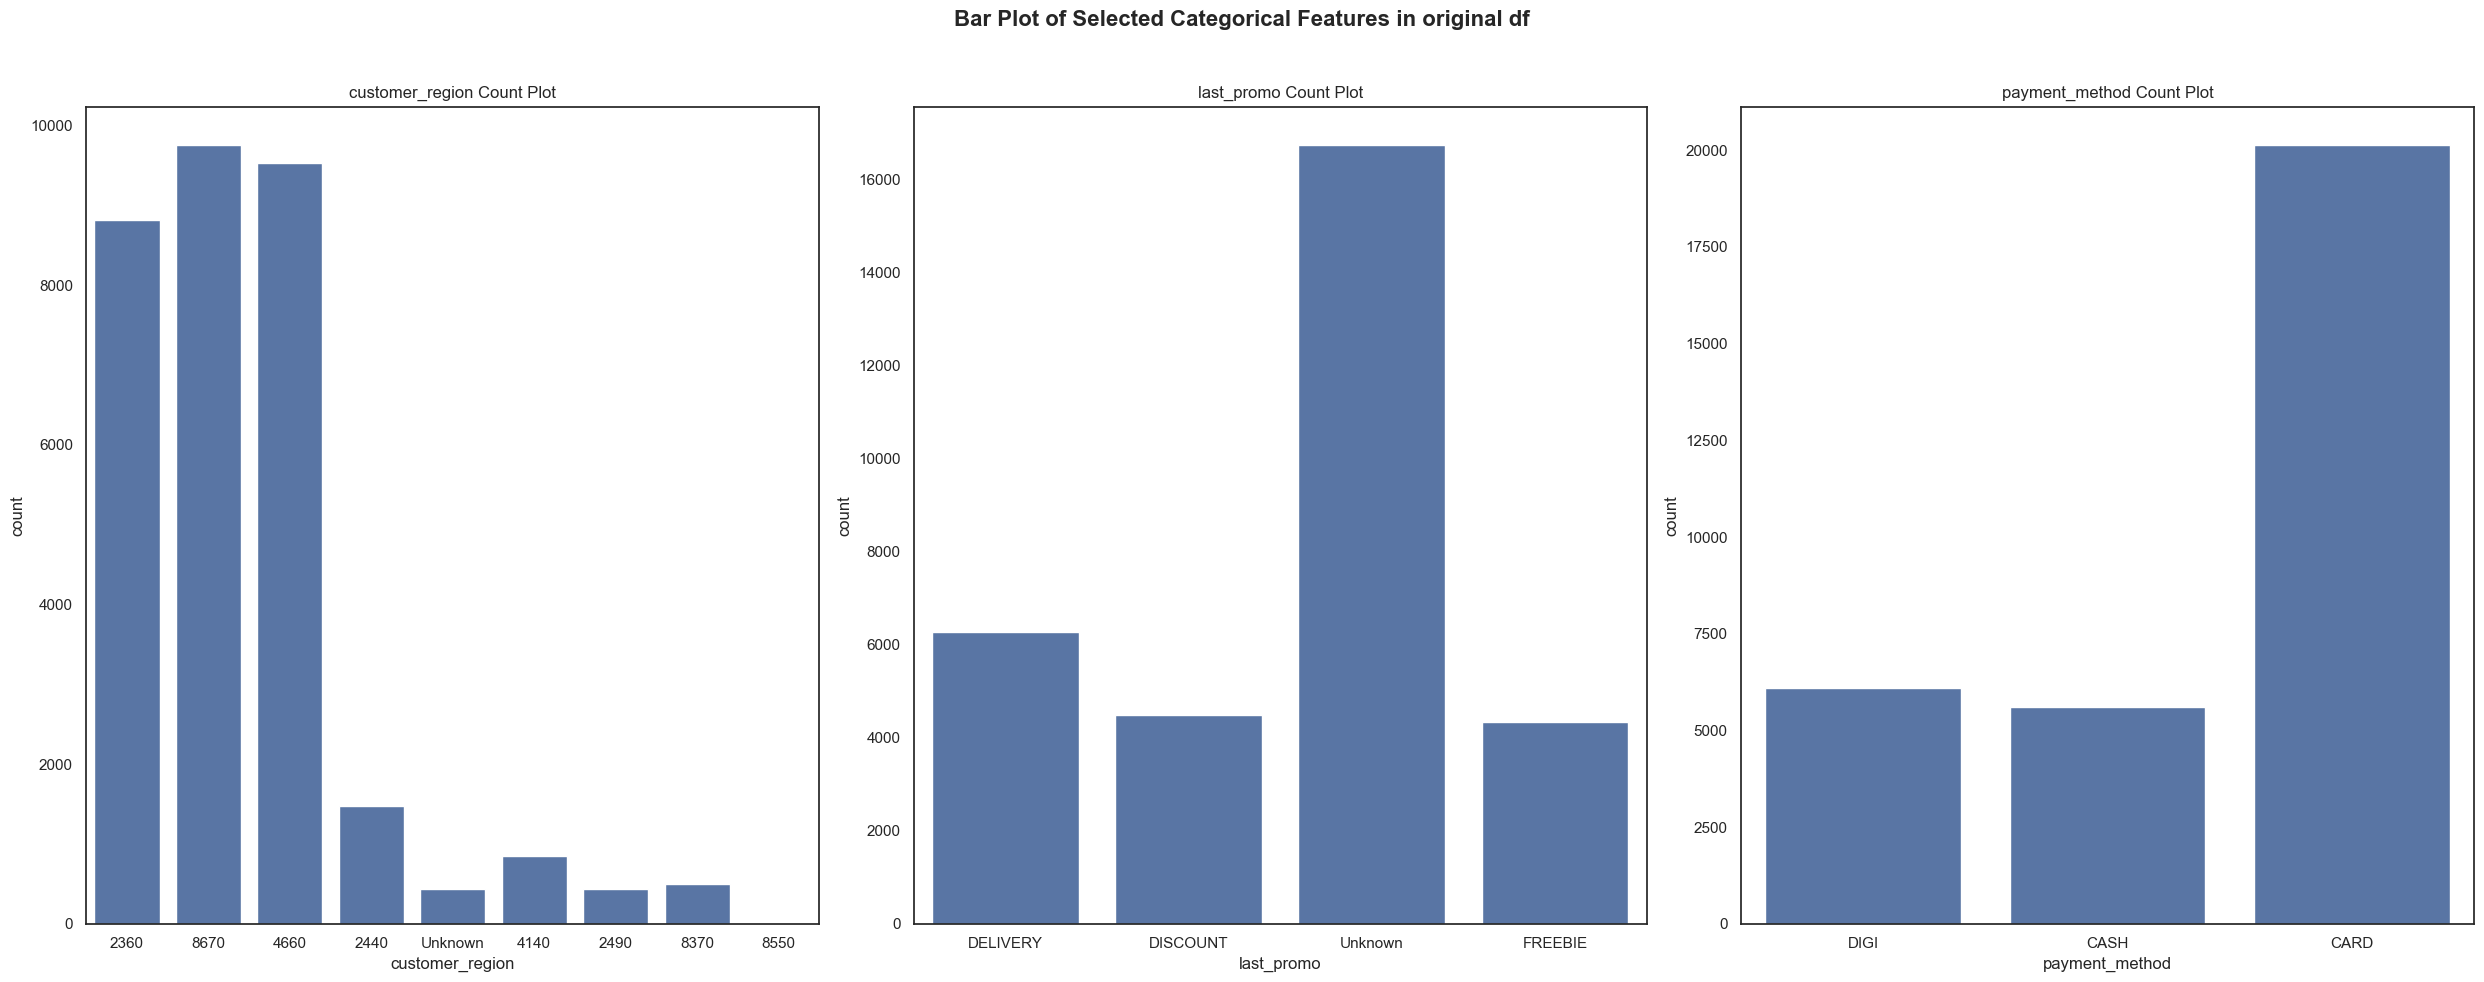

In [198]:
cat_features_original = ["customer_region", "last_promo", "payment_method"]

fig, axes = plt.subplots(1, 3, figsize=(25, 10))

# Loop through each feature and plot bar plots
for i, feature in enumerate(cat_features_original):
    ax = axes[i % 3]
    
    # Plot the bar plot
    sns.countplot(data=df_outliers, x=feature, ax=ax)
    
    # Set titles
    ax.set_title(f"{feature} Count Plot")

# Adding overall title
plt.suptitle("Bar Plot of Selected Categorical Features in original df", fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


<div class="alert alert-block alert-info" style="font-size:16px">

### Key notes **`General`**
1. 'last_promo' and 'payment_method' features do not seem to have any outlier categories 
2. In customer_region, region '8550' seems to be an rare category. However, considerign the feature engineering process and the creation of a feature with only 3 categories: city 2, city 4 and city 8 it doesn't make sense to remove or treat this rare category


---

<div class="alert alert-block alert-info" style="font-size:16px" id = "feature_engineering">

## 5. Feature engineering

Copying df_nan instead of df in order to have the HR_0 correct values. It would impact the creatiom of night_num_orders
  

In [199]:
df_fe = df_nan.copy()

In [200]:
df_fe.loc[df_fe["first_order"] == -100]

Empty DataFrame
Columns: [customer_region, customer_age, vendor_count, product_count, is_chain, first_order, last_order, last_promo, payment_method, CUI_American, CUI_Asian, CUI_Beverages, CUI_Cafe, CUI_Chicken Dishes, CUI_Chinese, CUI_Desserts, CUI_Healthy, CUI_Indian, CUI_Italian, CUI_Japanese, CUI_Noodle Dishes, CUI_OTHER, CUI_Street Food / Snacks, CUI_Thai, DOW_0, DOW_1, DOW_2, DOW_3, DOW_4, DOW_5, DOW_6, HR_1, HR_2, HR_0, HR_3, HR_4, HR_5, HR_6, HR_7, HR_8, HR_9, HR_10, HR_11, HR_12, HR_13, HR_14, HR_15, HR_16, HR_17, HR_18, HR_19, HR_20, HR_21, HR_22, HR_23]
Index: []

[0 rows x 55 columns]

---

### **`payment_method_combined`**
1. How did we create this feature?
    - We combined card and cash payments into a category called 'in-person' and categorized digital payments as 'online'

In [268]:
df_fe['payment_method_combined'] = df_fe['payment_method']
df_fe['payment_method_combined'] = df_fe['payment_method_combined'].replace({'CARD': 'In Person', 'CASH': 'In Person', 'DIGI': 'Online'})

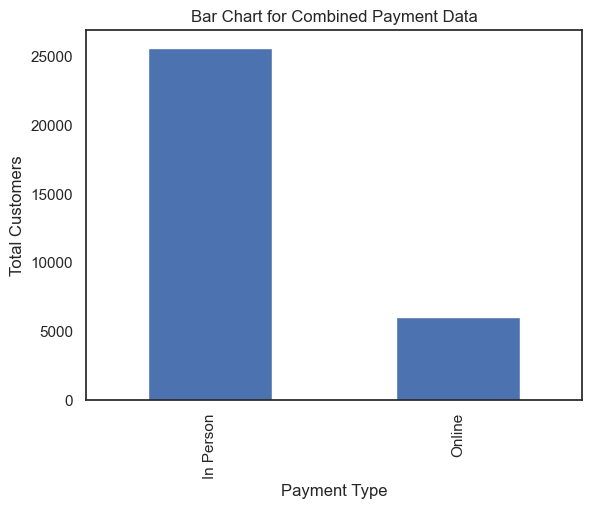

In [269]:
df_fe['payment_method_combined'].value_counts().plot(kind='bar')

plt.title('Bar Chart for Combined Payment Data')
plt.xlabel('Payment Type')
plt.ylabel('Total Customers')

plt.show()

In [270]:
df_fe['payment_method_combined'].value_counts()

payment_method_combined
In Person    25638
Online        6052
Name: count, dtype: int64

In [271]:
#dropping payment_method from df_fe
df_fe.drop('payment_method', axis = 1, inplace = True)

<div class="alert alert-block alert-info" style="font-size:16px">

### Key notes **`payment_method_combined`**:
- Data type is object
- Duplicate values are expected
- No missing values
- 2/3 of customers pay with card
- If we consider "card" and "cash" to indicate in-person payment, and "digi" to indicate digital/online payment, then 31828 80.87% of customers are paying in-person. This presents a potential loss for the company - customers paying upon pickup may not show up, delivery drives may have to wait longer to move on to the next order, etc. It would be in the company's best interest to move more payments to online.

---


### **`city`**
1. How did we create this feature?
    - By combining reigons beginning with the same digit
          - For example, regions 2360, 2440 and 2490 are combined into 'city 2'

In [272]:
# creating a new variable (city) that groups regions by first digit
df_fe['city'] = df_fe['customer_region'].str[0]
df_fe['city'] = df_fe['city'].replace({'2': 'City 2', '4': 'City 4', '8': 'City 8', 'U': 'City Unknown'})

In [273]:
#moving the city column next to customer region
df_fe.insert(df_fe.columns.get_loc('customer_region') + 1, 'city', df_fe.pop('city'))

In [274]:
#dropping region from df_fe
df_fe.drop('customer_region', axis = 1, inplace = True)

In [275]:
df_fe.head()

city  customer_age  vendor_count  product_count  is_chain  \
customer_id                                                                
1b8f824d5e   City 2          18.0             2              5         1   
5d272b9dcb   City 8          17.0             2              2         2   
f6d1b2ba63   City 4          38.0             1              2         2   
180c632ed8   City 4           NaN             2              3         1   
4eb37a6705   City 4          20.0             2              5         0   

             first_order  last_order last_promo  CUI_American  CUI_Asian  ...  \
customer_id                                                               ...   
1b8f824d5e             0           1   DELIVERY          0.00       0.00  ...   
5d272b9dcb             0           1   DISCOUNT         12.82       6.39  ...   
f6d1b2ba63             0           1   DISCOUNT          9.20       0.00  ...   
180c632ed8             0           2   DELIVERY          0.00      13.70  ...   
4eb37a6705             0           2    Unknown         14.57      40.87  ...   

             purchased_Thai  num_unique_cuisines_tried  peak_days_num_orders  \
customer_id                                                                    
1b8f824d5e                0                          1                     1   
5d272b9dcb                0                          2                     1   
f6d1b2ba63                0                          1                     1   
180c632ed8                0                          2                     1   
4eb37a6705                0                          2                     1   

             off_peak_days_num_orders  client_order_behaviour  \
customer_id                                                     
1b8f824d5e                          1                       0   
5d272b9dcb                          1                       0   
f6d1b2ba63                          1                       0   
180c632ed8                          1                       0   
4eb37a6705                          1                       0   

             morning_num_orders  afternoon_num_orders  evening_num_orders  \
customer_id                                                                 
1b8f824d5e                    0                     0                   2   
5d272b9dcb                    2                     0                   0   
f6d1b2ba63                    2                     0                   0   
180c632ed8                    1                     1                   0   
4eb37a6705                    2                     0                   0   

             night_num_orders  payment_method_combined  
customer_id                                             
1b8f824d5e                  0                   Online  
5d272b9dcb                  0                   Online  
f6d1b2ba63                  0                In Person  
180c632ed8                  0                   Online  
4eb37a6705                  0                   Online  

[5 rows x 81 columns]

In [276]:
#creating data frames for each of the cities
city_2 = df_fe[df_fe['city'] == 'City 2']
city_4 = df_fe[df_fe['city'] == 'City 4']
city_8 = df_fe[df_fe['city'] == 'City 8']

In [277]:
#shapes for each of the cities
print(city_2.shape)
print(city_4.shape)
print(city_8.shape)

(10741, 81)
(10389, 81)
(10118, 81)


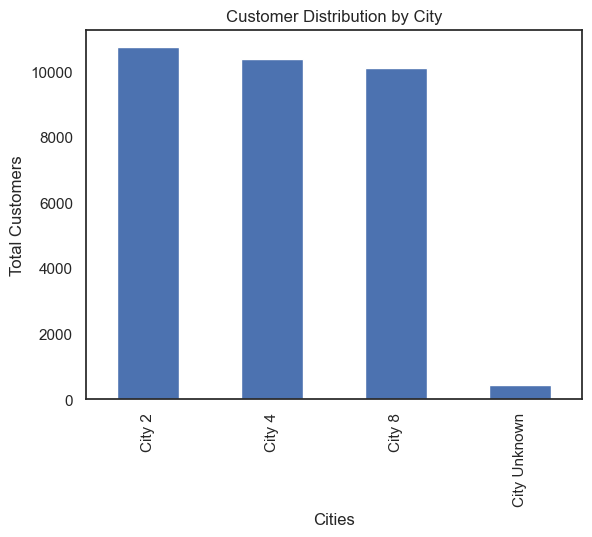

In [278]:
#add bar chart for this
#making a boxplot for region data
city_counts = pd.DataFrame(df_fe['city'].value_counts())

df_fe['city'].value_counts().plot(kind='bar')

plt.title('Customer Distribution by City')
plt.xlabel('Cities')
plt.ylabel('Total Customers')

plt.show()

<div class="alert alert-block alert-info" style="font-size:16px">

### Key notes **`city`**  
- If we assume the first digit of the region indicates city, customers are split appproximately evenly throughout the three cities
    - 10,757 customers in City 2 (cities beginning with 2)
    - 10,407 customers in City 4 (cities beginning with 4)
    - 10,282 customers in City 8 (cities beginning with 8)
- 442 "unknown region" values are kept as unknown when assigned to a city
- We don't know specifically what these region codes represent, not much benefit is gained by analying the regions individually. When we combine the regions into cities, this feature gains meaning and interpretability.

---

### **`tot_orders_per_client`**

#### How did we create the feature?
1. The DOW variables represent how many orders each client made per day of the week throughout the 3 months
2. Since these variables don't have any nan values, to obtain the total orders made per client, we just need to sum these values row wise

In [202]:
columns_to_sum = [f'DOW_{i}' for i in range(7)]
df_fe["tot_orders_per_client"] = df_fe[columns_to_sum].sum(axis=1).astype(int)

Histogram and boxplot using the Freedman - Diaconis rule 

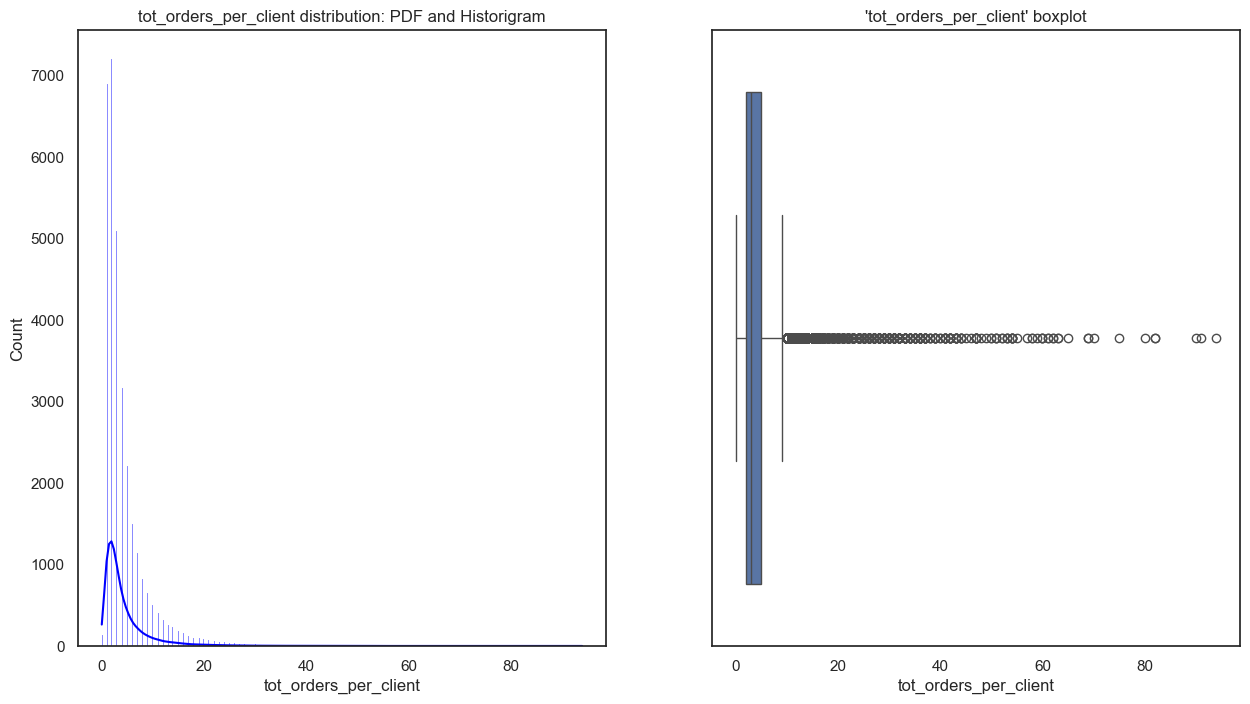

In [203]:
Q1,Q3 = np.nanpercentile(df_fe["tot_orders_per_client"], [25, 75])
IQR = Q3-Q1
fd_bin_width = (2*IQR)/len(df_fe["tot_orders_per_client"])**(1/3)
df_optimal_num_bins = int((max(df_fe["tot_orders_per_client"])-min(df_fe["tot_orders_per_client"]))/fd_bin_width)

fig, axes = plt.subplots(1, 2, figsize = (15,8))
sns.histplot(df_fe["tot_orders_per_client"], kde=True, color="blue", bins=df_optimal_num_bins, ax=axes[0])
axes[0].set_title("tot_orders_per_client distribution: PDF and Historigram")

sns.boxplot(x = df_fe["tot_orders_per_client"], ax=axes[1])
axes[1].set_title("'tot_orders_per_client' boxplot")
plt.show()

Total orders per client class segmentation

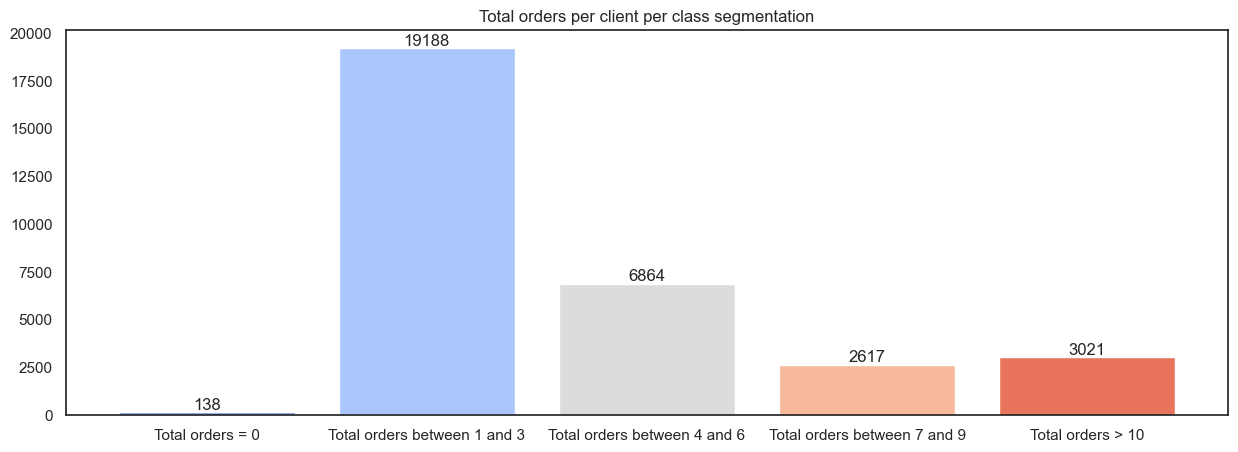

In [204]:
tot_orders_0 = df_fe.loc[df_fe["tot_orders_per_client"] == 0].shape[0]
tot_orders_1_3 = df_fe.loc[(df_fe["tot_orders_per_client"] >= 1) & (df_fe["tot_orders_per_client"] <=3)].shape[0]
tot_orders_4_6 = df_fe.loc[(df_fe["tot_orders_per_client"] >=4) & (df_fe["tot_orders_per_client"] <=6)].shape[0]
tot_orders_7_9 = df_fe.loc[(df_fe["tot_orders_per_client"] >=7) & (df_fe["tot_orders_per_client"] <=9)].shape[0]
tot_orders_10 = df_fe.loc[df_fe["tot_orders_per_client"] >=10].shape[0]

total_elements = df_fe.shape[0]

fig, ax = plt.subplots(1,1, figsize = (15,5))
y_values= [tot_orders_0, tot_orders_1_3, tot_orders_4_6, tot_orders_7_9, tot_orders_10]
x_values = ["Total orders = 0", "Total orders between 1 and 3", "Total orders between 4 and 6", "Total orders between 7 and 9", "Total orders > 10" ]
bar_colours = sns.color_palette("coolwarm", len(x_values))

p = ax.bar(x_values, y_values, color=bar_colours)
ax.bar_label(p, labels= [f"{element}" for element in y_values])
ax.set_title("Total orders per client per class segmentation")
plt.show()

Some clients have 0 total orders if we sum the DOW variables

In [205]:
HR_columns = [element for element in df_fe.columns if 'HR' in str(element)]
strange_clients_df = df_fe.loc[(df_fe["tot_orders_per_client"]==0) & ( (df_fe["product_count"]!=0) | (df_fe["is_chain"]!=0) | (df_fe["first_order"]!=0)| (df_fe["last_order"]!=0) )]
tot_orders_0= df_fe.loc[(df_fe["tot_orders_per_client"]==0)].shape[0]
strange_clients_df

customer_region  customer_age  vendor_count  product_count  \
customer_id                                                              
4903041977             8670          22.0             0              0   
c94b288475             8670          26.0             0              0   
f687717dc1             8670          21.0             0              0   
c6cf0b76fb             8670          38.0             0              0   
1b7c34738e             8670          24.0             0              0   
...                     ...           ...           ...            ...   
177ede2420             8670          30.0             0              0   
0039059c9c             8670          22.0             0              0   
0e60632fe2             8670          23.0             0              0   
28ed1f1e3f             8670          20.0             0              0   
4c06e104de             8670          25.0             0              0   

             is_chain  first_order  last_order last_promo payment_method  \
customer_id                                                                
4903041977          1            1           1   DELIVERY           DIGI   
c94b288475          0            1           1   DELIVERY           CASH   
f687717dc1          1            1           1   DELIVERY           DIGI   
c6cf0b76fb          0            2           2   DELIVERY           CASH   
1b7c34738e          0            3           3    Unknown           CASH   
...               ...          ...         ...        ...            ...   
177ede2420          1           86          86    Unknown           DIGI   
0039059c9c          1           88          88   DISCOUNT           CARD   
0e60632fe2          0           89          89   DISCOUNT           CARD   
28ed1f1e3f          0           89          89   DELIVERY           DIGI   
4c06e104de          1           89          89    Unknown           CASH   

             CUI_American  ...  HR_15  HR_16  HR_17  HR_18  HR_19  HR_20  \
customer_id                ...                                             
4903041977            0.0  ...      0      0      0      0      0      0   
c94b288475            0.0  ...      0      0      0      0      0      0   
f687717dc1            0.0  ...      0      0      0      0      0      0   
c6cf0b76fb            0.0  ...      0      0      0      0      0      0   
1b7c34738e            0.0  ...      0      0      0      0      0      0   
...                   ...  ...    ...    ...    ...    ...    ...    ...   
177ede2420            0.0  ...      0      0      0      0      0      0   
0039059c9c            0.0  ...      0      0      0      0      0      0   
0e60632fe2            0.0  ...      0      0      0      0      0      0   
28ed1f1e3f            0.0  ...      0      0      0      0      0      0   
4c06e104de            0.0  ...      0      0      0      0      0      0   

             HR_21  HR_22  HR_23  tot_orders_per_client  
customer_id                                              
4903041977       0      0      0                      0  
c94b288475       0      0      0                      0  
f687717dc1       0      0      0                      0  
c6cf0b76fb       0      0      0                      0  
1b7c34738e       0      0      0                      0  
...            ...    ...    ...                    ...  
177ede2420       0      0      0                      0  
0039059c9c       0      0      0                      0  
0e60632fe2       0      0      0                      0  
28ed1f1e3f       0      0      0                      0  
4c06e104de       0      0      0                      0  

[138 rows x 56 columns]

In [206]:
# Number of NaN values
df_fe["tot_orders_per_client"].isnull().sum()

0

In [208]:
# Let's try to understand if we sum all the HR_variables if some of these clients have total orders different from 0"""
df_fe["tot_orders_per_client_HR"] = df_fe[HR_columns].sum(axis=1).astype(int)
strange_clients = df_fe.loc[df_fe["tot_orders_per_client"]==0].index
df_fe.loc[strange_clients, "tot_orders_per_client_HR"].sum()

0

The answer is NO. Even when trying to use the sum of HR_variables to determine the total orders, the strange clients still have total orders = 0

<div class="alert alert-block alert-info" style="font-size:16px">

### Key notes **`tot_orders_per_client`**
1. Represents a numerical feature with total orders made per clietn
2. To build the feature, we had 2 initial options: sum all the DOW variables or all the HR variables. Since only DOW variables don't have any NaN values, we opted to use it. 
3. Strange values detected. 
    - 138 clients had 0 total orders made despite one or many of the following features being bigger than 0: "product_count", "is_chain", "first_order" and "last_order"
    - Tried to understand if the issue was related to the DOW variables (features used to determine tot_orders_per_client feature). To do so, decided to determine the total number of orders per client using the HR variables despite the existence of NaN values. The results didn't change, meaning that all strange clients stayed strange clients.
    - How to deal with these values? In my opinion, they should be removed.
4. From 31,828 clients, almost 20k have made a total number of orders between 1 and 3
5. From boxplot and histogram
    - A lot of outliers present (both extreme and moderate)
    - heavily left skewed distribution
6. No NaN values



----

### **`tot_money_spent_per_client`**

#### How did we create the feature?
1. The CUI variables represent the monetary amount spent by each client in each of the different types of cousines throughout the 3 months
2. Since these variables don't have any nan values to obtain the total money spent per client we just need to sum these values row wise

In [209]:
CUI_columns = [element for element in df_fe.columns if 'CUI' in str(element)]
df_fe[CUI_columns].isnull().sum()
df_fe["tot_money_spent_per_client"] = df_fe[CUI_columns].sum(axis=1).astype(float)
df_fe

customer_region  customer_age  vendor_count  product_count  \
customer_id                                                              
1b8f824d5e             2360          18.0             2              5   
5d272b9dcb             8670          17.0             2              2   
f6d1b2ba63             4660          38.0             1              2   
180c632ed8             4660           NaN             2              3   
4eb37a6705             4660          20.0             2              5   
...                     ...           ...           ...            ...   
f4e366c281             8670          30.0             1              1   
f6b6709018             8670           NaN             1              1   
f74ad8ce3f             8670          24.0             1              1   
f7b19c0241             8670          34.0             1              1   
fd40d3b0e0             4660          30.0             1              1   

             is_chain  first_order  last_order last_promo payment_method  \
customer_id                                                                
1b8f824d5e          1            0           1   DELIVERY           DIGI   
5d272b9dcb          2            0           1   DISCOUNT           DIGI   
f6d1b2ba63          2            0           1   DISCOUNT           CASH   
180c632ed8          1            0           2   DELIVERY           DIGI   
4eb37a6705          0            0           2    Unknown           DIGI   
...               ...          ...         ...        ...            ...   
f4e366c281          1         <NA>           0    FREEBIE           DIGI   
f6b6709018          0         <NA>           0   DELIVERY           DIGI   
f74ad8ce3f          1         <NA>           0    Unknown           DIGI   
f7b19c0241          0         <NA>           0   DISCOUNT           DIGI   
fd40d3b0e0          0         <NA>           0    Unknown           CASH   

             CUI_American  ...  HR_17  HR_18  HR_19  HR_20  HR_21  HR_22  \
customer_id                ...                                             
1b8f824d5e           0.00  ...      0      2      0      0      0      0   
5d272b9dcb          12.82  ...      0      0      0      0      0      0   
f6d1b2ba63           9.20  ...      0      0      0      0      0      0   
180c632ed8           0.00  ...      0      0      0      0      0      0   
4eb37a6705          14.57  ...      0      0      0      0      0      0   
...                   ...  ...    ...    ...    ...    ...    ...    ...   
f4e366c281           0.00  ...      0      0      0      0      0      0   
f6b6709018          18.04  ...      0      0      0      0      0      0   
f74ad8ce3f           0.00  ...      0      0      0      0      0      0   
f7b19c0241           0.00  ...      0      0      0      0      0      0   
fd40d3b0e0           0.00  ...      0      0      0      0      0      0   

             HR_23  tot_orders_per_client  tot_orders_per_client_HR  \
customer_id                                                           
1b8f824d5e       0                      2                         2   
5d272b9dcb       0                      2                         2   
f6d1b2ba63       0                      2                         2   
180c632ed8       0                      2                         2   
4eb37a6705       0                      2                         2   
...            ...                    ...                       ...   
f4e366c281       0                      1                         1   
f6b6709018       0                      1                         1   
f74ad8ce3f       0                      1                         1   
f7b19c0241       0                      1                         1   
fd40d3b0e0       0                      1                         1   

             tot_money_spent_per_client  
customer_id                              
1b8f824d5e                        28.88  
5d272b9dcb           

Histogram and boxplot using the Freedman - Diaconis rule 

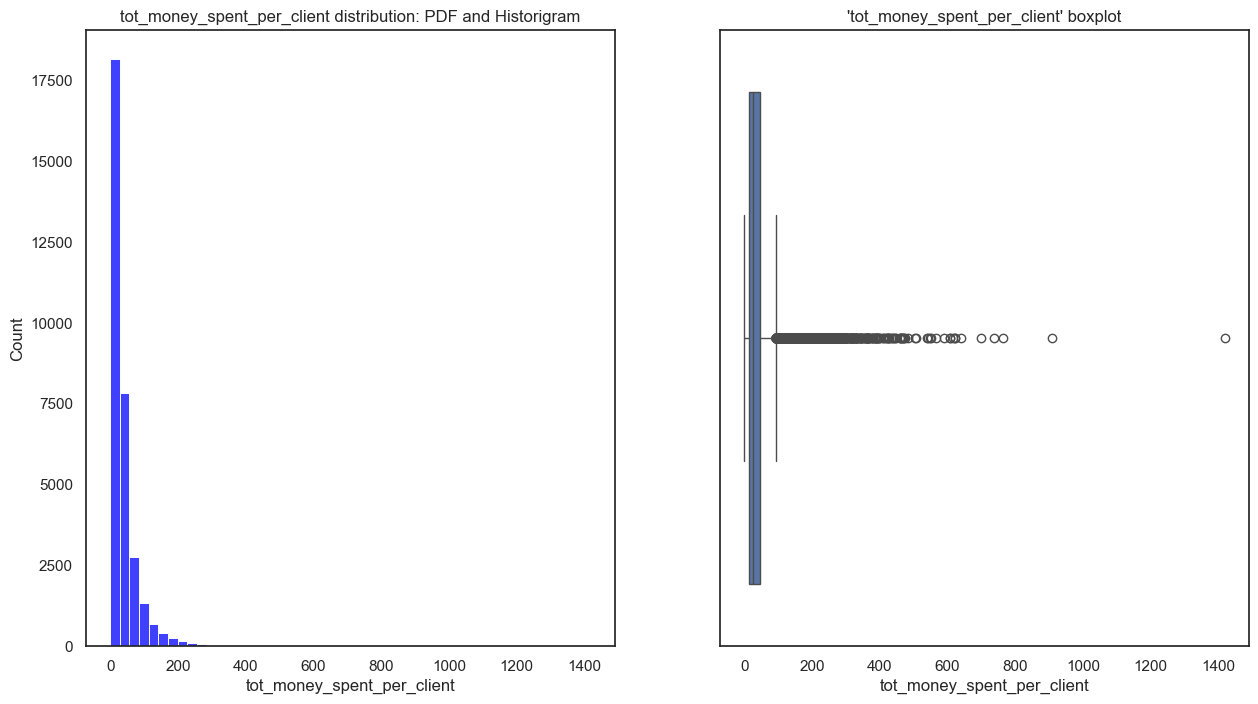

In [210]:
Q1,Q3 = np.nanpercentile(df_fe["tot_money_spent_per_client"], [25, 75])
IQR = Q3-Q1
fd_bin_width = (2*IQR)/len(df_fe["tot_money_spent_per_client"])**(1/3)
df_optimal_num_bins = int((max(df_fe["tot_money_spent_per_client"])-min(df_fe["tot_money_spent_per_client"]))/fd_bin_width)

fig, axes = plt.subplots(1, 2, figsize = (15,8))
sns.histplot(df_fe["tot_money_spent_per_client"], kde=False, color="blue", bins=50, ax=axes[0])
axes[0].set_title("tot_money_spent_per_client distribution: PDF and Historigram")

sns.boxplot(x = df_fe["tot_money_spent_per_client"], ax=axes[1])
axes[1].set_title("'tot_money_spent_per_client' boxplot")
plt.show()

Total money spent per client per class segmentation

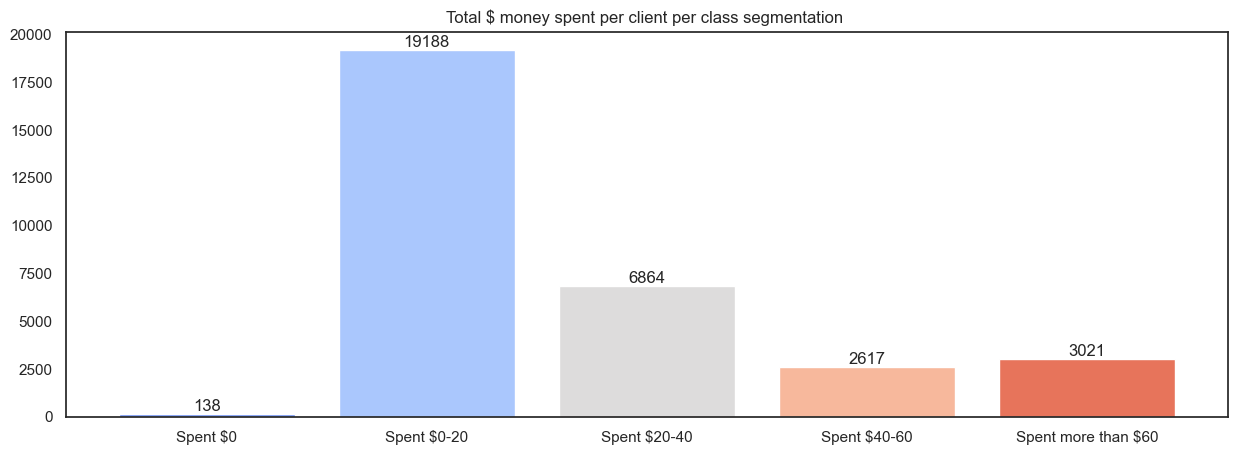

In [211]:
spent_0 = df_fe.loc[df_fe["tot_money_spent_per_client"] == 0].shape[0]
spent_0_20 =  df_fe.loc[(df_fe["tot_money_spent_per_client"] > 0) & (df_fe["tot_money_spent_per_client"] <20)].shape[0]
spent_20_40 = df_fe.loc[(df_fe["tot_money_spent_per_client"] >= 20) & (df_fe["tot_money_spent_per_client"] <40)].shape[0]
spent_40_60 = df_fe.loc[(df_fe["tot_money_spent_per_client"] >= 40) & (df_fe["tot_money_spent_per_client"] <60)].shape[0]
spent_more_60 = df_fe.loc[(df_fe["tot_money_spent_per_client"] >= 60) ].shape[0]

total_elements = df_fe.shape[0]

fig, ax = plt.subplots(1,1, figsize = (15,5))
y_values= [tot_orders_0, tot_orders_1_3, tot_orders_4_6, tot_orders_7_9, tot_orders_10]
x_values = ["Spent $0", "Spent $0-20", "Spent $20-40", "Spent $40-60", "Spent more than $60" ]
bar_colours = sns.color_palette("coolwarm", len(x_values))

p = ax.bar(x_values, y_values, color=bar_colours)
ax.bar_label(p, labels= [f"{element}" for element in y_values])
ax.set_title("Total $ money spent per client per class segmentation ")
plt.show()

Some clients have $0 total money spent

In [213]:
tms_strange_clients_df = df_fe.loc[(df_fe["tot_money_spent_per_client"]==0) & (df_fe["tot_orders_per_client"] == 0)]
tms_strange_clients_df

#All the clients who have have 0 money spent correspond to the same client who have 0 orders made 

customer_region  customer_age  vendor_count  product_count  \
customer_id                                                              
4903041977             8670          22.0             0              0   
c94b288475             8670          26.0             0              0   
f687717dc1             8670          21.0             0              0   
c6cf0b76fb             8670          38.0             0              0   
1b7c34738e             8670          24.0             0              0   
...                     ...           ...           ...            ...   
177ede2420             8670          30.0             0              0   
0039059c9c             8670          22.0             0              0   
0e60632fe2             8670          23.0             0              0   
28ed1f1e3f             8670          20.0             0              0   
4c06e104de             8670          25.0             0              0   

             is_chain  first_order  last_order last_promo payment_method  \
customer_id                                                                
4903041977          1            1           1   DELIVERY           DIGI   
c94b288475          0            1           1   DELIVERY           CASH   
f687717dc1          1            1           1   DELIVERY           DIGI   
c6cf0b76fb          0            2           2   DELIVERY           CASH   
1b7c34738e          0            3           3    Unknown           CASH   
...               ...          ...         ...        ...            ...   
177ede2420          1           86          86    Unknown           DIGI   
0039059c9c          1           88          88   DISCOUNT           CARD   
0e60632fe2          0           89          89   DISCOUNT           CARD   
28ed1f1e3f          0           89          89   DELIVERY           DIGI   
4c06e104de          1           89          89    Unknown           CASH   

             CUI_American  ...  HR_17  HR_18  HR_19  HR_20  HR_21  HR_22  \
customer_id                ...                                             
4903041977            0.0  ...      0      0      0      0      0      0   
c94b288475            0.0  ...      0      0      0      0      0      0   
f687717dc1            0.0  ...      0      0      0      0      0      0   
c6cf0b76fb            0.0  ...      0      0      0      0      0      0   
1b7c34738e            0.0  ...      0      0      0      0      0      0   
...                   ...  ...    ...    ...    ...    ...    ...    ...   
177ede2420            0.0  ...      0      0      0      0      0      0   
0039059c9c            0.0  ...      0      0      0      0      0      0   
0e60632fe2            0.0  ...      0      0      0      0      0      0   
28ed1f1e3f            0.0  ...      0      0      0      0      0      0   
4c06e104de            0.0  ...      0      0      0      0      0      0   

             HR_23  tot_orders_per_client  tot_orders_per_client_HR  \
customer_id                                                           
4903041977       0                      0                         0   
c94b288475       0                      0                         0   
f687717dc1       0                      0                         0   
c6cf0b76fb       0                      0                         0   
1b7c34738e       0                      0                         0   
...            ...                    ...                       ...   
177ede2420       0                      0                         0   
0039059c9c       0                      0                         0   
0e60632fe2       0                      0                         0   
28ed1f1e3f       0                      0                         0   
4c06e104de       0                      0                         0   

             tot_money_spent_per_client  
customer_id                              
4903041977                          0.0  
c94b288475           

<div class="alert alert-block alert-info" style="font-size:16px">

### Key notes **`tot_money_spent_per_client`**
1. Represents a numerical feature with total money spent made per client
2. To build the feature, we did the sum of All CUI variables
3. Strange values detected. 
    - 138 clients had 0 total money spent
    - These clients correspond to the clients who also had 0 total orders made during the 3 months
    - How to deal with these values? In my opinion, they should be removed.
4. From 31,828 clients, almost 20k spent between $0-$20
5. From boxplot and histogram
    - A lot of outliers present (both extreme and moderate)
    - heavily left skewed distribution meaning that most clients didn't spend a lot of money during the 3 months
    
6. No NaN values



---

### **`CUI binary variables`** and **`num_unique_cuisines_tried`**

#### <u>CUI binary variables </u> - How did we create the feature?
1. Since each CUI variable has a lot of non spending clients, we decided to create a new feature ('purchased_cousine_type') that evaluates whether the client spent any money or not for each type ou cousine
2. Values interpretation:
- 0: means that the client didn't spent any money on that cousine
- 1: means that the client spent money

#### <u> num_unique_cuisines_tried </u> - How did we create the feature?
1. If we sum row wise all the CUI binary variables, we will get the total number of unique cuisines tried by each client.
2. It could provide a good insight into customer diversity and engagement

In [238]:
df_fe[CUI_columns]

CUI_American  CUI_Asian  CUI_Beverages  CUI_Cafe  \
customer_id                                                     
1b8f824d5e           0.00       0.00           0.00       0.0   
5d272b9dcb          12.82       6.39           0.00       0.0   
f6d1b2ba63           9.20       0.00           0.00       0.0   
180c632ed8           0.00      13.70           0.00       0.0   
4eb37a6705          14.57      40.87           0.00       0.0   
...                   ...        ...            ...       ...   
f4e366c281           0.00       0.00          18.04       0.0   
f6b6709018          18.04       0.00           0.00       0.0   
f74ad8ce3f           0.00       0.00           0.00       0.0   
f7b19c0241           0.00      12.03           0.00       0.0   
fd40d3b0e0           0.00       0.00           0.00       0.0   

             CUI_Chicken Dishes  CUI_Chinese  CUI_Desserts  CUI_Healthy  \
customer_id                                                               
1b8f824d5e                  0.0          0.0          0.00          0.0   
5d272b9dcb                  0.0          0.0          0.00          0.0   
f6d1b2ba63                  0.0          0.0          0.00          0.0   
180c632ed8                  0.0          0.0          0.00          0.0   
4eb37a6705                  0.0          0.0          0.00          0.0   
...                         ...          ...           ...          ...   
f4e366c281                  0.0          0.0          0.00          0.0   
f6b6709018                  0.0          0.0          0.00          0.0   
f74ad8ce3f                  0.0          0.0         17.79          0.0   
f7b19c0241                  0.0          0.0          0.00          0.0   
fd40d3b0e0                  0.0          0.0          0.00          0.0   

             CUI_Indian  CUI_Italian  CUI_Japanese  CUI_Noodle Dishes  \
customer_id                                                             
1b8f824d5e        28.88         0.00           0.0                0.0   
5d272b9dcb         0.00         0.00           0.0                0.0   
f6d1b2ba63         0.00         0.00           0.0                0.0   
180c632ed8        17.86         0.00           0.0                0.0   
4eb37a6705         0.00         0.00           0.0                0.0   
...                 ...          ...           ...                ...   
f4e366c281         0.00         0.00           0.0                0.0   
f6b6709018         0.00         0.00           0.0                0.0   
f74ad8ce3f         0.00         0.00           0.0                0.0   
f7b19c0241         0.00         0.00           0.0                0.0   
fd40d3b0e0         0.00         7.91           0.0                0.0   

             CUI_OTHER  CUI_Street Food / Snacks  CUI_Thai  
customer_id                                                 
1b8f824d5e         0.0                       0.0       0.0  
5d272b9dcb         0.0                       0.0       0.0  
f6d1b2ba63         0.0                       0.0       0.0  
180c632ed8         0.0                       0.0       0.0  
4eb37a6705         0.0                       0.0       0.0  
...                ...                       ...       ...  
f4e366c281         0.0                       0.0       0.0  
f6b6709018         0.0                       0.0       0.0  
f74ad8ce3f         0.0                       0.0       0.0  
f7b19c0241         0.0                       0.0       0.0  
fd40d3b0e0         0.0                       0.0       0.0  

[31828 rows x 15 columns]

Creating the **CUI binary variables**

In [239]:
for element in CUI_columns:
    current_ele = str(element).split("_")[1]
    type_clients = df_fe[element].map(lambda x: 0 if x==0 else 1)
    df_fe["purchased_"+ current_ele] = type_clients

purchased_features = [element for element in df_fe.columns if 'purchased' in str(element)]
df_fe[purchased_features]

purchased_American  purchased_Asian  purchased_Beverages  \
customer_id                                                             
1b8f824d5e                    0                0                    0   
5d272b9dcb                    1                1                    0   
f6d1b2ba63                    1                0                    0   
180c632ed8                    0                1                    0   
4eb37a6705                    1                1                    0   
...                         ...              ...                  ...   
f4e366c281                    0                0                    1   
f6b6709018                    1                0                    0   
f74ad8ce3f                    0                0                    0   
f7b19c0241                    0                1                    0   
fd40d3b0e0                    0                0                    0   

             purchased_Cafe  purchased_Chicken Dishes  purchased_Chinese  \
customer_id                                                                
1b8f824d5e                0                         0                  0   
5d272b9dcb                0                         0                  0   
f6d1b2ba63                0                         0                  0   
180c632ed8                0                         0                  0   
4eb37a6705                0                         0                  0   
...                     ...                       ...                ...   
f4e366c281                0                         0                  0   
f6b6709018                0                         0                  0   
f74ad8ce3f                0                         0                  0   
f7b19c0241                0                         0                  0   
fd40d3b0e0                0                         0                  0   

             purchased_Desserts  purchased_Healthy  purchased_Indian  \
customer_id                                                            
1b8f824d5e                    0                  0                 1   
5d272b9dcb                    0                  0                 0   
f6d1b2ba63                    0                  0                 0   
180c632ed8                    0                  0                 1   
4eb37a6705                    0                  0                 0   
...                         ...                ...               ...   
f4e366c281                    0                  0                 0   
f6b6709018                    0                  0                 0   
f74ad8ce3f                    1                  0                 0   
f7b19c0241                    0                  0                 0   
fd40d3b0e0                    0                  0                 0   

             purchased_Italian  purchased_Japanese  purchased_Noodle Dishes  \
customer_id                                                                   
1b8f824d5e                   0                   0                        0   
5d272b9dcb                   0                   0                        0   
f6d1b2ba63                   0                   0                        0   
180c632ed8                   0                   0                        0   
4eb37a6705                   0                   0                        0   
...                        ...                 ...                      ...   
f4e366c281                   0                   0                        0   
f6b6709018                   0                   0                        0   
f74ad8ce3f                   0                   0                        0   
f7b19c0241                   0                   0                        0   
fd40d3b0e0                   1                   0                        0   

             purchased_OTHER  purchased_Street Food / Snacks  purchased_Thai  
customer_id                   

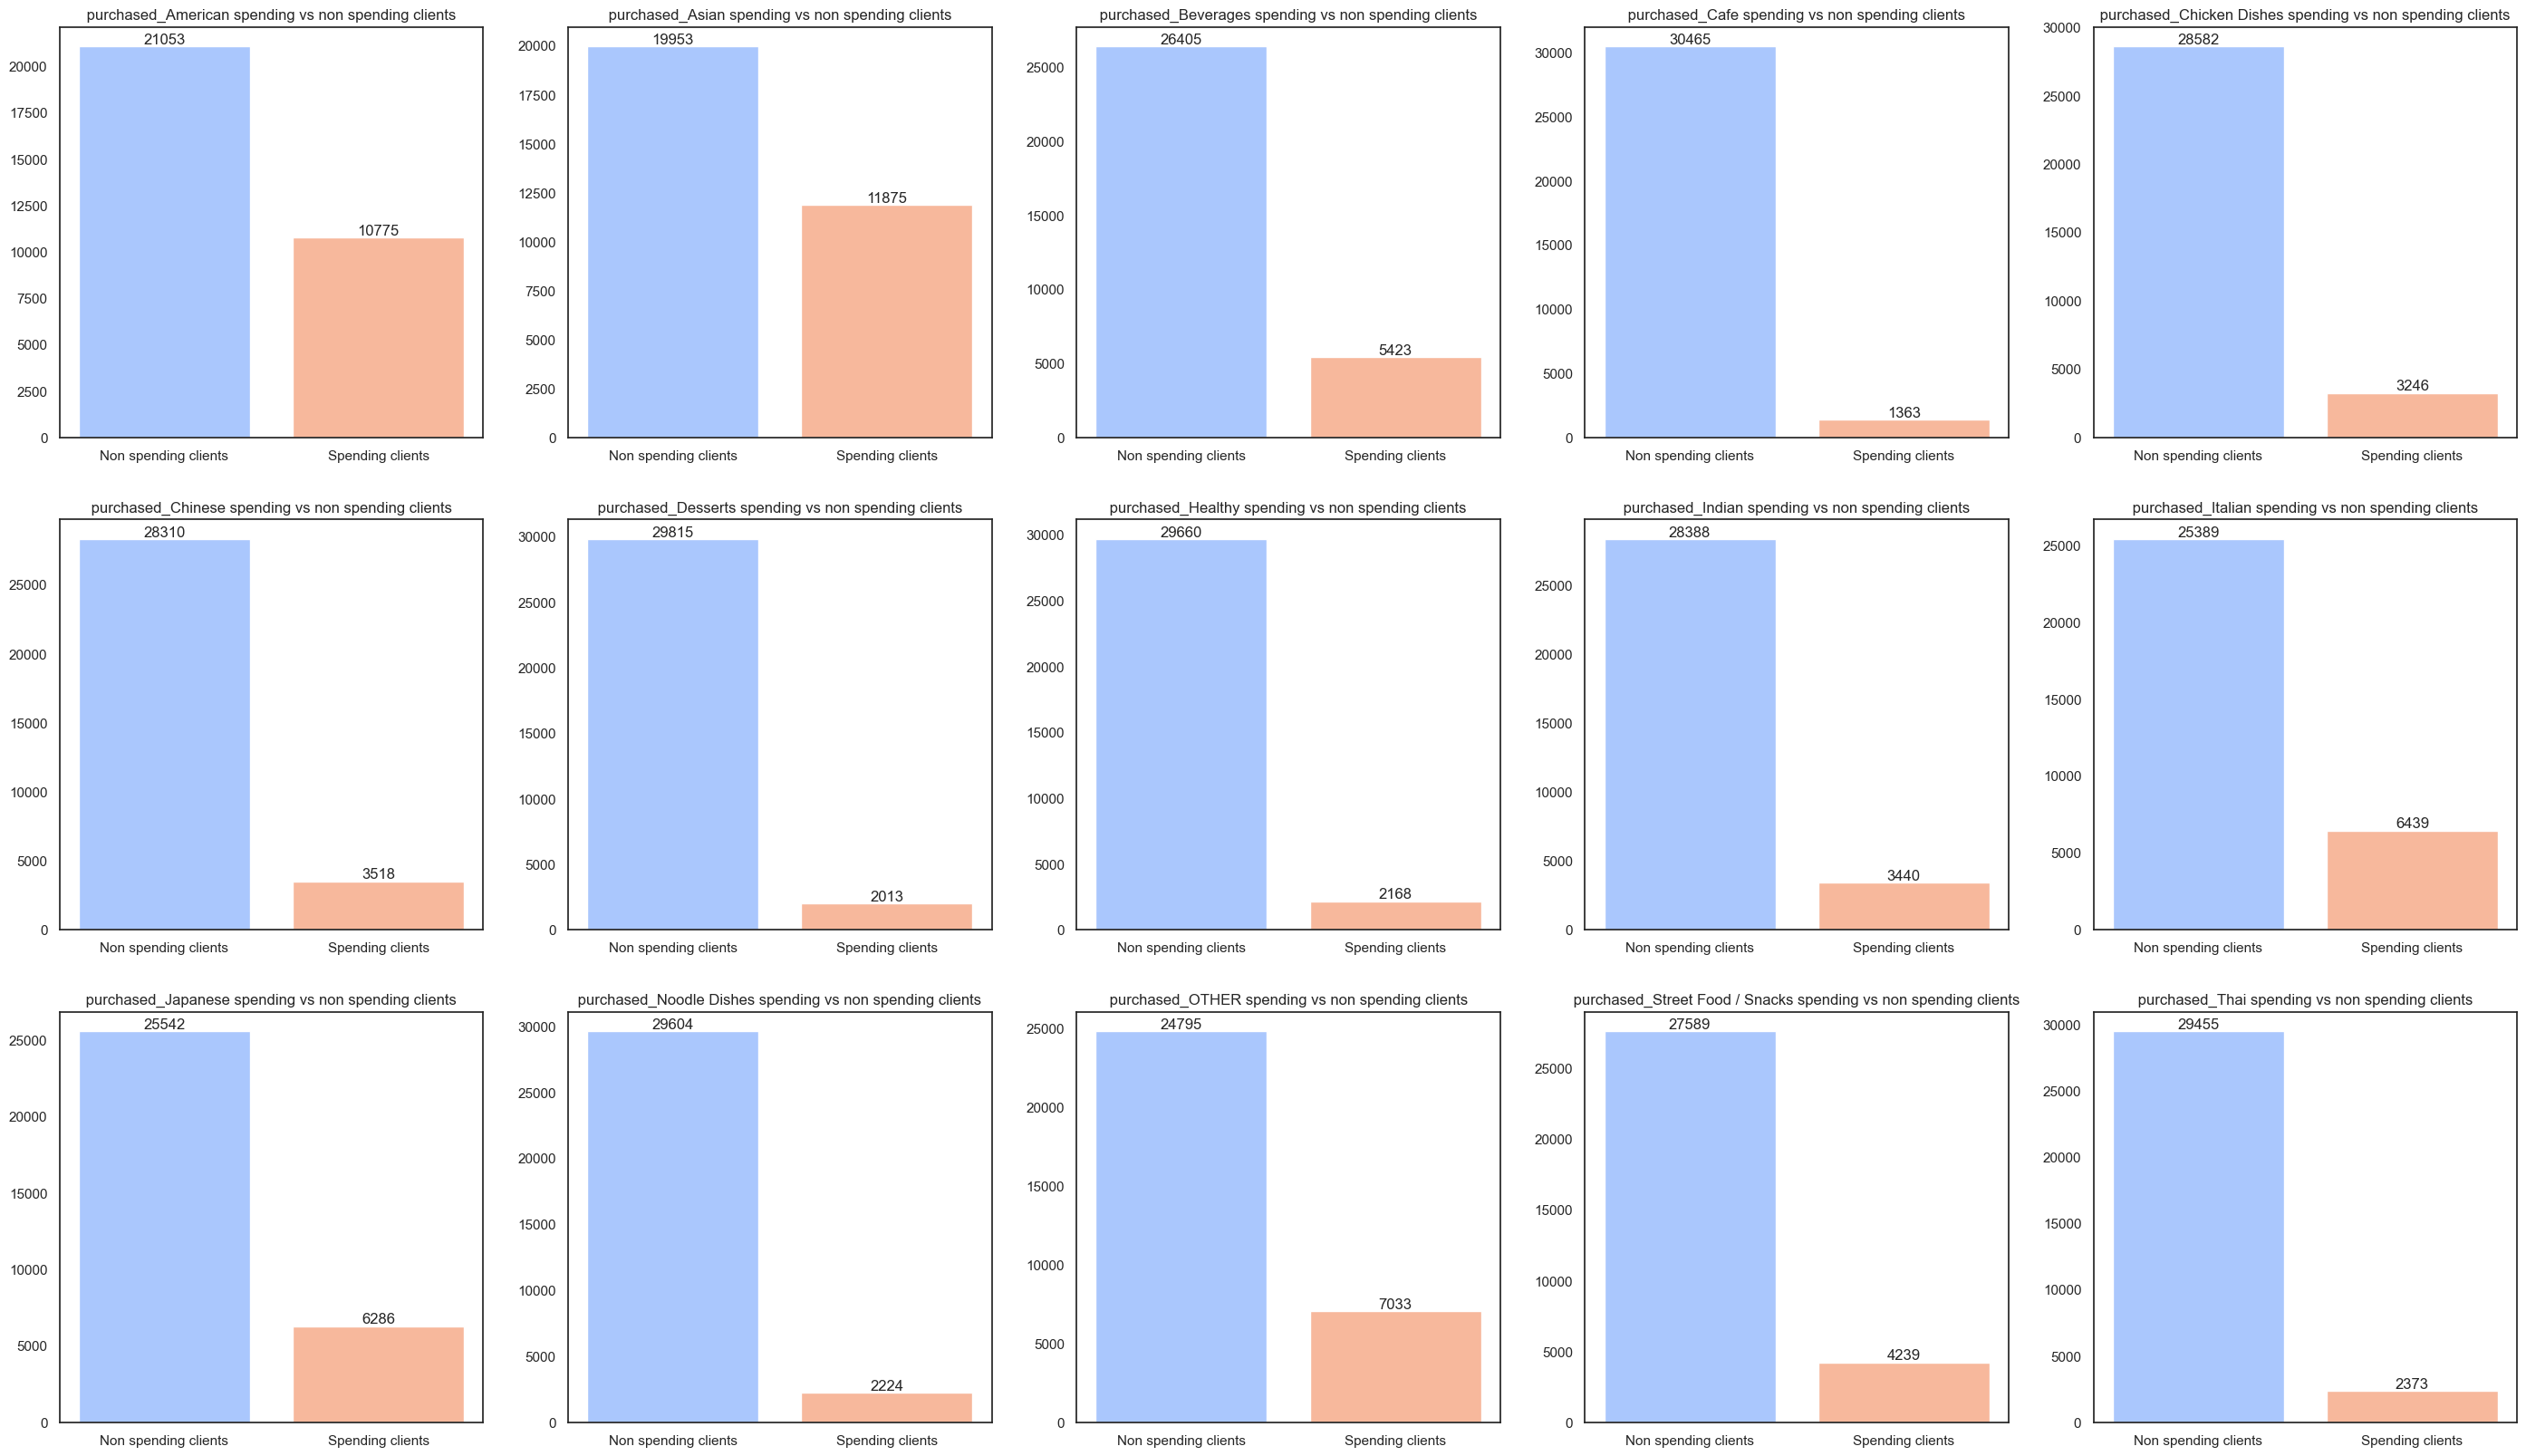

In [240]:
sns.set_style("white")

columns = purchased_features

fig, axes = plt.subplots(3, 5, figsize=(35, 20))

# Loop through each feature and plot boxplots with vertical lines for Q3 + 1.5*IQR and Q3 + 3*IQR
for i, feature in enumerate(columns):
    ax = axes[i // 5, i % 5]
    y_values = [df_fe.loc[df_fe[feature] == 0.].shape[0], df_fe.loc[df_fe[feature] == 1].shape[0]]
    x_values = ["Non spending clients", "Spending clients"]
    bar_colours = sns.color_palette("coolwarm", len(x_values))
    p = ax.bar(x_values, y_values, color=bar_colours)
    ax.bar_label(p, labels= [f"{element}" for element in y_values])
    ax.set_title(f" {feature} spending vs non spending clients ")

plt.show()

In [242]:
# No NaN values
df_fe[purchased_features].isnull().sum()

purchased_American                0
purchased_Asian                   0
purchased_Beverages               0
purchased_Cafe                    0
purchased_Chicken Dishes          0
purchased_Chinese                 0
purchased_Desserts                0
purchased_Healthy                 0
purchased_Indian                  0
purchased_Italian                 0
purchased_Japanese                0
purchased_Noodle Dishes           0
purchased_OTHER                   0
purchased_Street Food / Snacks    0
purchased_Thai                    0
dtype: int64

Creating the **'num_unique_cuisines_tried'** feature

In [243]:
df_fe["num_unique_cuisines_tried"] = df_fe[purchased_features].sum(axis = 1)
df_fe

customer_region  customer_age  vendor_count  product_count  \
customer_id                                                              
1b8f824d5e             2360          18.0             2              5   
5d272b9dcb             8670          17.0             2              2   
f6d1b2ba63             4660          38.0             1              2   
180c632ed8             4660           NaN             2              3   
4eb37a6705             4660          20.0             2              5   
...                     ...           ...           ...            ...   
f4e366c281             8670          30.0             1              1   
f6b6709018             8670           NaN             1              1   
f74ad8ce3f             8670          24.0             1              1   
f7b19c0241             8670          34.0             1              1   
fd40d3b0e0             4660          30.0             1              1   

             is_chain  first_order  last_order last_promo payment_method  \
customer_id                                                                
1b8f824d5e          1            0           1   DELIVERY           DIGI   
5d272b9dcb          2            0           1   DISCOUNT           DIGI   
f6d1b2ba63          2            0           1   DISCOUNT           CASH   
180c632ed8          1            0           2   DELIVERY           DIGI   
4eb37a6705          0            0           2    Unknown           DIGI   
...               ...          ...         ...        ...            ...   
f4e366c281          1         <NA>           0    FREEBIE           DIGI   
f6b6709018          0         <NA>           0   DELIVERY           DIGI   
f74ad8ce3f          1         <NA>           0    Unknown           DIGI   
f7b19c0241          0         <NA>           0   DISCOUNT           DIGI   
fd40d3b0e0          0         <NA>           0    Unknown           CASH   

             CUI_American  ...  purchased_Desserts  purchased_Healthy  \
customer_id                ...                                          
1b8f824d5e           0.00  ...                   0                  0   
5d272b9dcb          12.82  ...                   0                  0   
f6d1b2ba63           9.20  ...                   0                  0   
180c632ed8           0.00  ...                   0                  0   
4eb37a6705          14.57  ...                   0                  0   
...                   ...  ...                 ...                ...   
f4e366c281           0.00  ...                   0                  0   
f6b6709018          18.04  ...                   0                  0   
f74ad8ce3f           0.00  ...                   1                  0   
f7b19c0241           0.00  ...                   0                  0   
fd40d3b0e0           0.00  ...                   0                  0   

             purchased_Indian  purchased_Italian  purchased_Japanese  \
customer_id                                                            
1b8f824d5e                  1                  0                   0   
5d272b9dcb                  0                  0                   0   
f6d1b2ba63                  0                  0                   0   
180c632ed8                  1                  0                   0   
4eb37a6705                  0                  0                   0   
...                       ...                ...                 ...   
f4e366c281                  0                  0                   0   
f6b6709018                  0                  0                   0   
f74ad8ce3f                  0                  0                   0   
f7b19c0241                  0                  0                   0   
fd40d3b0e0                  0                  1                   0   

             purchased_Noodle Dishes  purchased_OTHER  \
customer_id                                             
1b8f824d5e                         0                0   
5d

Number of unique cuisines tried per client per class segmentation bar plot

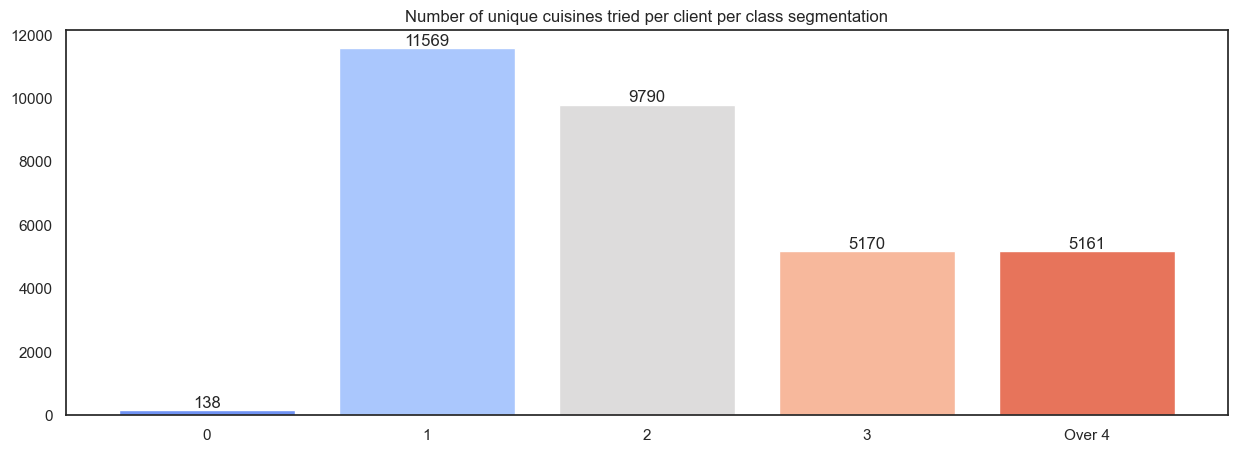

In [244]:
fig, ax = plt.subplots(1,1, figsize = (15,5))

unique_cui_0 = df_fe.loc[df_fe["num_unique_cuisines_tried"] == 0].shape[0]
unique_cui_1 = df_fe.loc[df_fe["num_unique_cuisines_tried"] == 1].shape[0]
unique_cui_2 = df_fe.loc[df_fe["num_unique_cuisines_tried"] == 2].shape[0]
unique_cui_3 = df_fe.loc[df_fe["num_unique_cuisines_tried"] == 3].shape[0]
unique_cui_over_4 = df_fe.loc[df_fe["num_unique_cuisines_tried"] >= 4].shape[0]

y_values = [unique_cui_0, unique_cui_1, unique_cui_2, unique_cui_3, unique_cui_over_4]
x_values = ["0", "1", "2", "3", "Over 4"]
bar_colours = sns.color_palette("coolwarm", len(x_values))

p = ax.bar(x_values, y_values, color=bar_colours)
ax.bar_label(p, labels= [f"{element}" for element in y_values])
ax.set_title("Number of unique cuisines tried per client per class segmentation")
plt.show()

In [245]:
# Number of nan values
df_fe["num_unique_cuisines_tried"].isnull().sum()

0

In [246]:
# Some clients tried 0 unique cuisines

uct_strange_clients_df = df_fe.loc[(df_fe["tot_money_spent_per_client"]==0) & (df_fe["tot_orders_per_client"] == 0) & (df_fe["num_unique_cuisines_tried"] == 0)]
uct_strange_clients_df = df_fe.loc[(df_fe["tot_money_spent_per_client"]==0) & (df_fe["tot_orders_per_client"] == 0)]
uct_strange_clients_df


#All the clients who have tried 0 uniquecuisines are also the clients that have spent 0 money and have made 0 orders 

customer_region  customer_age  vendor_count  product_count  \
customer_id                                                              
4903041977             8670          22.0             0              0   
c94b288475             8670          26.0             0              0   
f687717dc1             8670          21.0             0              0   
c6cf0b76fb             8670          38.0             0              0   
1b7c34738e             8670          24.0             0              0   
...                     ...           ...           ...            ...   
177ede2420             8670          30.0             0              0   
0039059c9c             8670          22.0             0              0   
0e60632fe2             8670          23.0             0              0   
28ed1f1e3f             8670          20.0             0              0   
4c06e104de             8670          25.0             0              0   

             is_chain  first_order  last_order last_promo payment_method  \
customer_id                                                                
4903041977          1            1           1   DELIVERY           DIGI   
c94b288475          0            1           1   DELIVERY           CASH   
f687717dc1          1            1           1   DELIVERY           DIGI   
c6cf0b76fb          0            2           2   DELIVERY           CASH   
1b7c34738e          0            3           3    Unknown           CASH   
...               ...          ...         ...        ...            ...   
177ede2420          1           86          86    Unknown           DIGI   
0039059c9c          1           88          88   DISCOUNT           CARD   
0e60632fe2          0           89          89   DISCOUNT           CARD   
28ed1f1e3f          0           89          89   DELIVERY           DIGI   
4c06e104de          1           89          89    Unknown           CASH   

             CUI_American  ...  purchased_Desserts  purchased_Healthy  \
customer_id                ...                                          
4903041977            0.0  ...                   0                  0   
c94b288475            0.0  ...                   0                  0   
f687717dc1            0.0  ...                   0                  0   
c6cf0b76fb            0.0  ...                   0                  0   
1b7c34738e            0.0  ...                   0                  0   
...                   ...  ...                 ...                ...   
177ede2420            0.0  ...                   0                  0   
0039059c9c            0.0  ...                   0                  0   
0e60632fe2            0.0  ...                   0                  0   
28ed1f1e3f            0.0  ...                   0                  0   
4c06e104de            0.0  ...                   0                  0   

             purchased_Indian  purchased_Italian  purchased_Japanese  \
customer_id                                                            
4903041977                  0                  0                   0   
c94b288475                  0                  0                   0   
f687717dc1                  0                  0                   0   
c6cf0b76fb                  0                  0                   0   
1b7c34738e                  0                  0                   0   
...                       ...                ...                 ...   
177ede2420                  0                  0                   0   
0039059c9c                  0                  0                   0   
0e60632fe2                  0                  0                   0   
28ed1f1e3f                  0                  0                   0   
4c06e104de                  0                  0                   0   

             purchased_Noodle Dishes  purchased_OTHER  \
customer_id                                             
4903041977                         0                0   
c9

<div class="alert alert-block alert-info" style="font-size:16px">

### Key notes **`CUI binary variables`**
1. Represents a binary feature that evaluates whether the client spent any money or not for each type of cousine. The value 0 means that the client didn't spent any money on that cousine and 1 that the client spent money
2. Important to highlight "American" and "Asian" cuisines with the highest numbers of spending clients. From the total ~32k clients in the dataset, ~11k and ~12k spent money on American and Asian cuisines respectively 
3. Important to note cafe as the CUI with the least number of spending clients 
cafe as the cui with the least amount of spending clients (~1.4k)
4. No nan values


### Key notes **`num_unique_cuisines_tried`**
1. Represents a numerical feature with total number of unique cuisines tried per client.
2. To build the feature, we did the row wise sum of all binary CUI variables
3. Strange values detected. 
    - The same 138 clients who haven't made any orders or spent any money during the 3 months, as expected, haven't tried a single cuisine 
    - The recommendation to remove them keeps unchanged

4. From 31,828 clients, ~11.5k tried a single cuisine. This suggests that a significant portion of the customer base may have narrow or specific tastes, preferring familiar options. 
5. No NaN values



---

### **`peak_days_num_orders`**, **`off_peak_days_num_orders`** and **`client_order_behaviour`** 

#### peak_days_num_orders and off_peak_days_num_orders - How did we create the features?
1. To reduce dimensonality, we will create 2 features that evaluate the total numbers of orders made by each client during the peak days and all the remaining days
2.  How was each feature defined?
    - peak_days_num_orders: Considering that Thursday, Friday and Saturday are the days with the most orders they will be considered the peak days
    - off_peak_num_orders: Correspond to all the remaining days
3. We opted for this approach instead of doing week_day_num_orders and weekend_num_orders due the DOW variables distribution


#### client_order_behaviour - How did we create the feature?

1. After creating the 'peak_days_num_orders' and 'off_peak_days_num_orders' we can determine for each client whether their mostly order during the peak or off peak days. This feature will be called client_order_behaviour
2. Classification process:
    - If the peak_days_num_orders is bigger than the off_peak_days_num_orders, client is considered a Peak Order client and classified as a 1
    - If the opposite happens, client is considered Off-Peak order client and classified as a 0


Creating **'peak_days_num_orders'** and **'off_peak_days_num_orders'** features

In [247]:
peak_days_columns = ["DOW_4", "DOW_5", "DOW_6"]
off_peak_days_columns = ["DOW_0", "DOW_1", "DOW_2", "DOW_3"]

df_fe["peak_days_num_orders"] = df_fe[peak_days_columns].sum(axis=1).astype(int)
df_fe["off_peak_days_num_orders"] = df_fe[off_peak_days_columns].sum(axis=1).astype(int)

In [248]:
print (f"peak_days_num_orders statistics: \n")
print (df_fe["peak_days_num_orders"].describe())

print (f"\noff_peak_days_num_orders statistics \n")
print (df_fe["off_peak_days_num_orders"].describe())


peak_days_num_orders statistics: 

count    31828.000000
mean         2.035158
std          2.515167
min          0.000000
25%          1.000000
50%          1.000000
75%          3.000000
max         45.000000
Name: peak_days_num_orders, dtype: float64

off_peak_days_num_orders statistics 

count    31828.000000
mean         2.333763
std          3.184887
min          0.000000
25%          1.000000
50%          1.000000
75%          3.000000
max         60.000000
Name: off_peak_days_num_orders, dtype: float64


Histogram and boxplot for 'peak_days_num_orders' and 'off_peak_days_num_orders' 

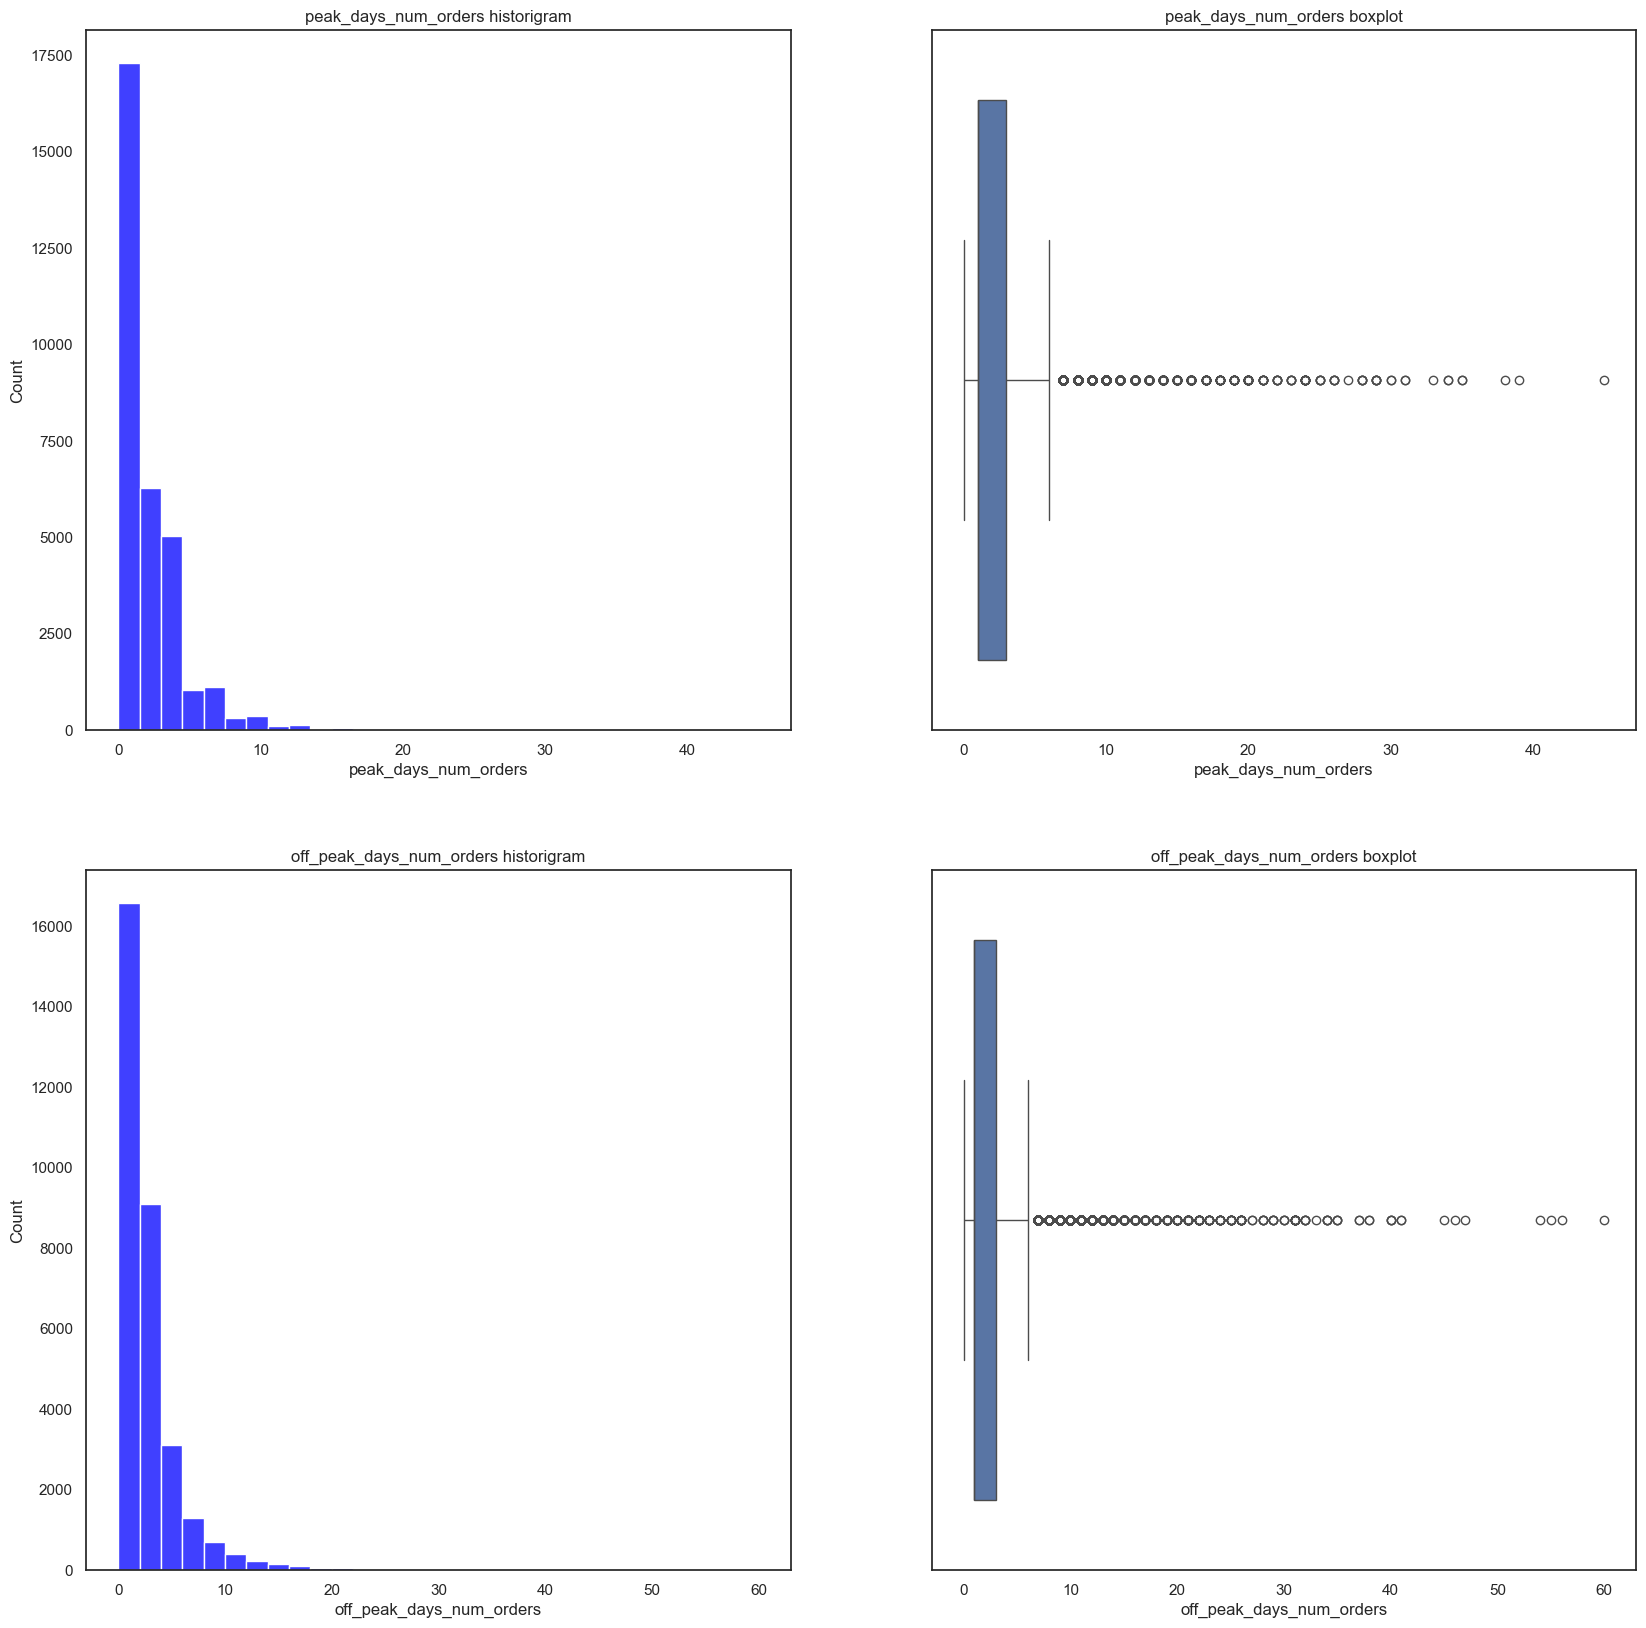

In [249]:
fig, axes = plt.subplots(2, 2, figsize = (20,20))

# Peak number of orders
sns.histplot(df_fe["peak_days_num_orders"], kde=False, color="blue", bins=30, ax=axes[0,0])
axes[0,0].set_title("peak_days_num_orders historigram")

sns.boxplot(x = df_fe["peak_days_num_orders"], ax=axes[0,1])
axes[0,1].set_title("peak_days_num_orders boxplot")

# Off-Peak number of orders
sns.histplot(df_fe["off_peak_days_num_orders"], kde=False, color="blue", bins=30, ax=axes[1,0])
axes[1,0].set_title("off_peak_days_num_orders historigram")

sns.boxplot(x = df_fe["off_peak_days_num_orders"], ax=axes[1,1])
axes[1,1].set_title("off_peak_days_num_orders boxplot")

plt.show()

Number of orders made during off-peak and peak days per class segmentation bar plot

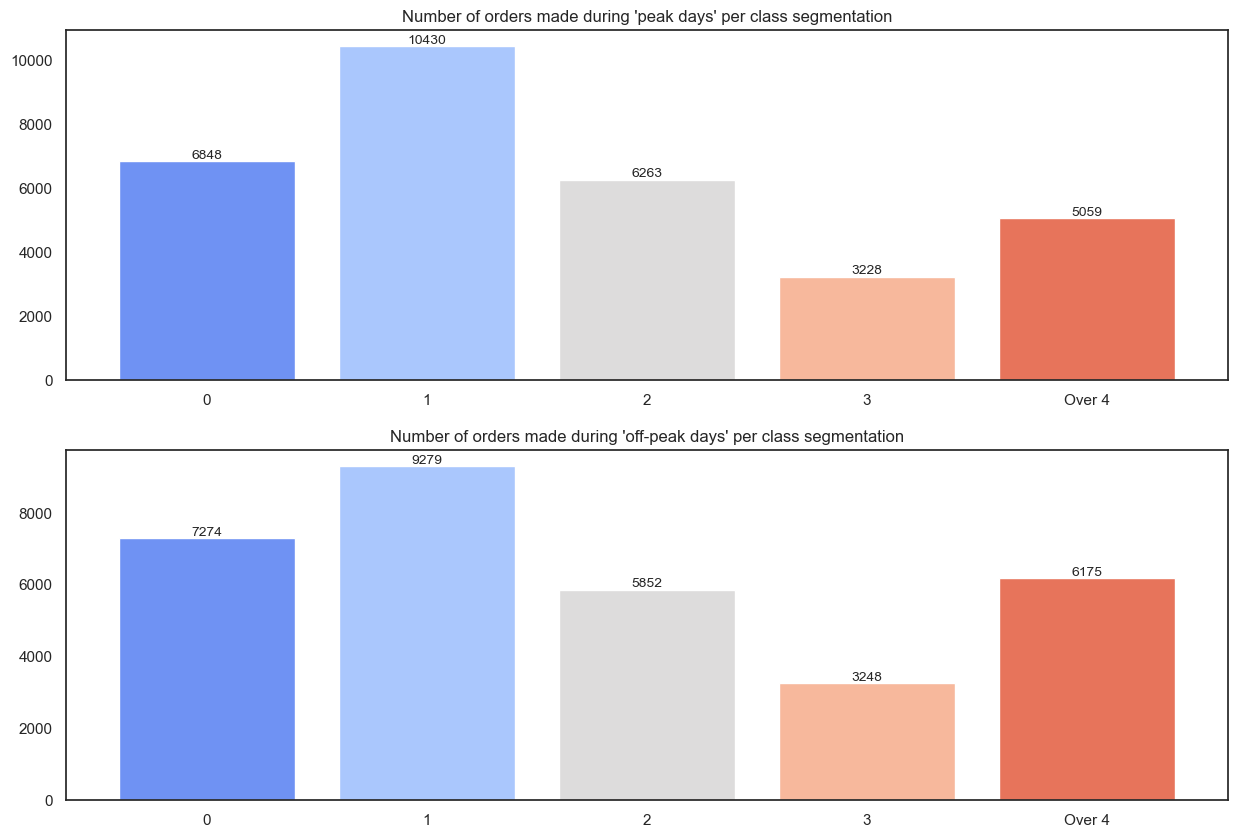

In [250]:
fig, ax = plt.subplots(2,1, figsize = (15,10))

# Peak days
peak_days_0 = df_fe.loc[(df_fe["peak_days_num_orders"] == 0)].shape[0]
peak_days_1 = df_fe.loc[(df_fe["peak_days_num_orders"] == 1)].shape[0]
peak_days_2 = df_fe.loc[(df_fe["peak_days_num_orders"] == 2)].shape[0]
peak_days_3 = df_fe.loc[(df_fe["peak_days_num_orders"] == 3)].shape[0]
peak_days_4more =df_fe.loc[(df_fe["peak_days_num_orders"] >= 4)].shape[0]

y_values = [peak_days_0, peak_days_1, peak_days_2, peak_days_3, peak_days_4more]
x_values = ["0", "1", "2", "3", "Over 4"]
bar_colours = sns.color_palette("coolwarm", len(x_values))

p = ax[0].bar(x_values, y_values, color=bar_colours)
ax[0].bar_label(p, labels= [f"{element}" for element in y_values], fontsize = 10)
ax[0].set_title("Number of orders made during 'peak days' per class segmentation")

# Off-Peak days
off_peak_days_0 = df_fe.loc[(df_fe["off_peak_days_num_orders"] == 0)].shape[0]
off_peak_days_1 = df_fe.loc[(df_fe["off_peak_days_num_orders"] == 1)].shape[0]
off_peak_days_2 = df_fe.loc[(df_fe["off_peak_days_num_orders"] == 2)].shape[0]
off_peak_days_3 = df_fe.loc[(df_fe["off_peak_days_num_orders"] == 3)].shape[0]
off_peak_days_4more =df_fe.loc[(df_fe["off_peak_days_num_orders"] >= 4)].shape[0]

y_values = [off_peak_days_0, off_peak_days_1, off_peak_days_2, off_peak_days_3, off_peak_days_4more]
x_values = ["0", "1", "2", "3", "Over 4"]
bar_colours = sns.color_palette("coolwarm", len(x_values))

p = ax[1].bar(x_values, y_values, color=bar_colours)
ax[1].bar_label(p, labels= [f"{element}" for element in y_values], fontsize = 10)
ax[1].set_title("Number of orders made during 'off-peak days' per class segmentation")

plt.show()

Creating feature **client_order_behaviour** regarding num_orders made in each category

In [251]:

df_fe.loc[df_fe["peak_days_num_orders"] > df_fe["off_peak_days_num_orders"]].shape[0]
df_fe.loc[df_fe["peak_days_num_orders"] < df_fe["off_peak_days_num_orders"]].shape[0]

df_fe["client_order_behaviour"] = df_fe.apply(lambda x: 1 if x["peak_days_num_orders"] > x["off_peak_days_num_orders"] else 0, axis=1 )

Client order behaviour per class segmentation and total orders made during peak and off peak days bar plots

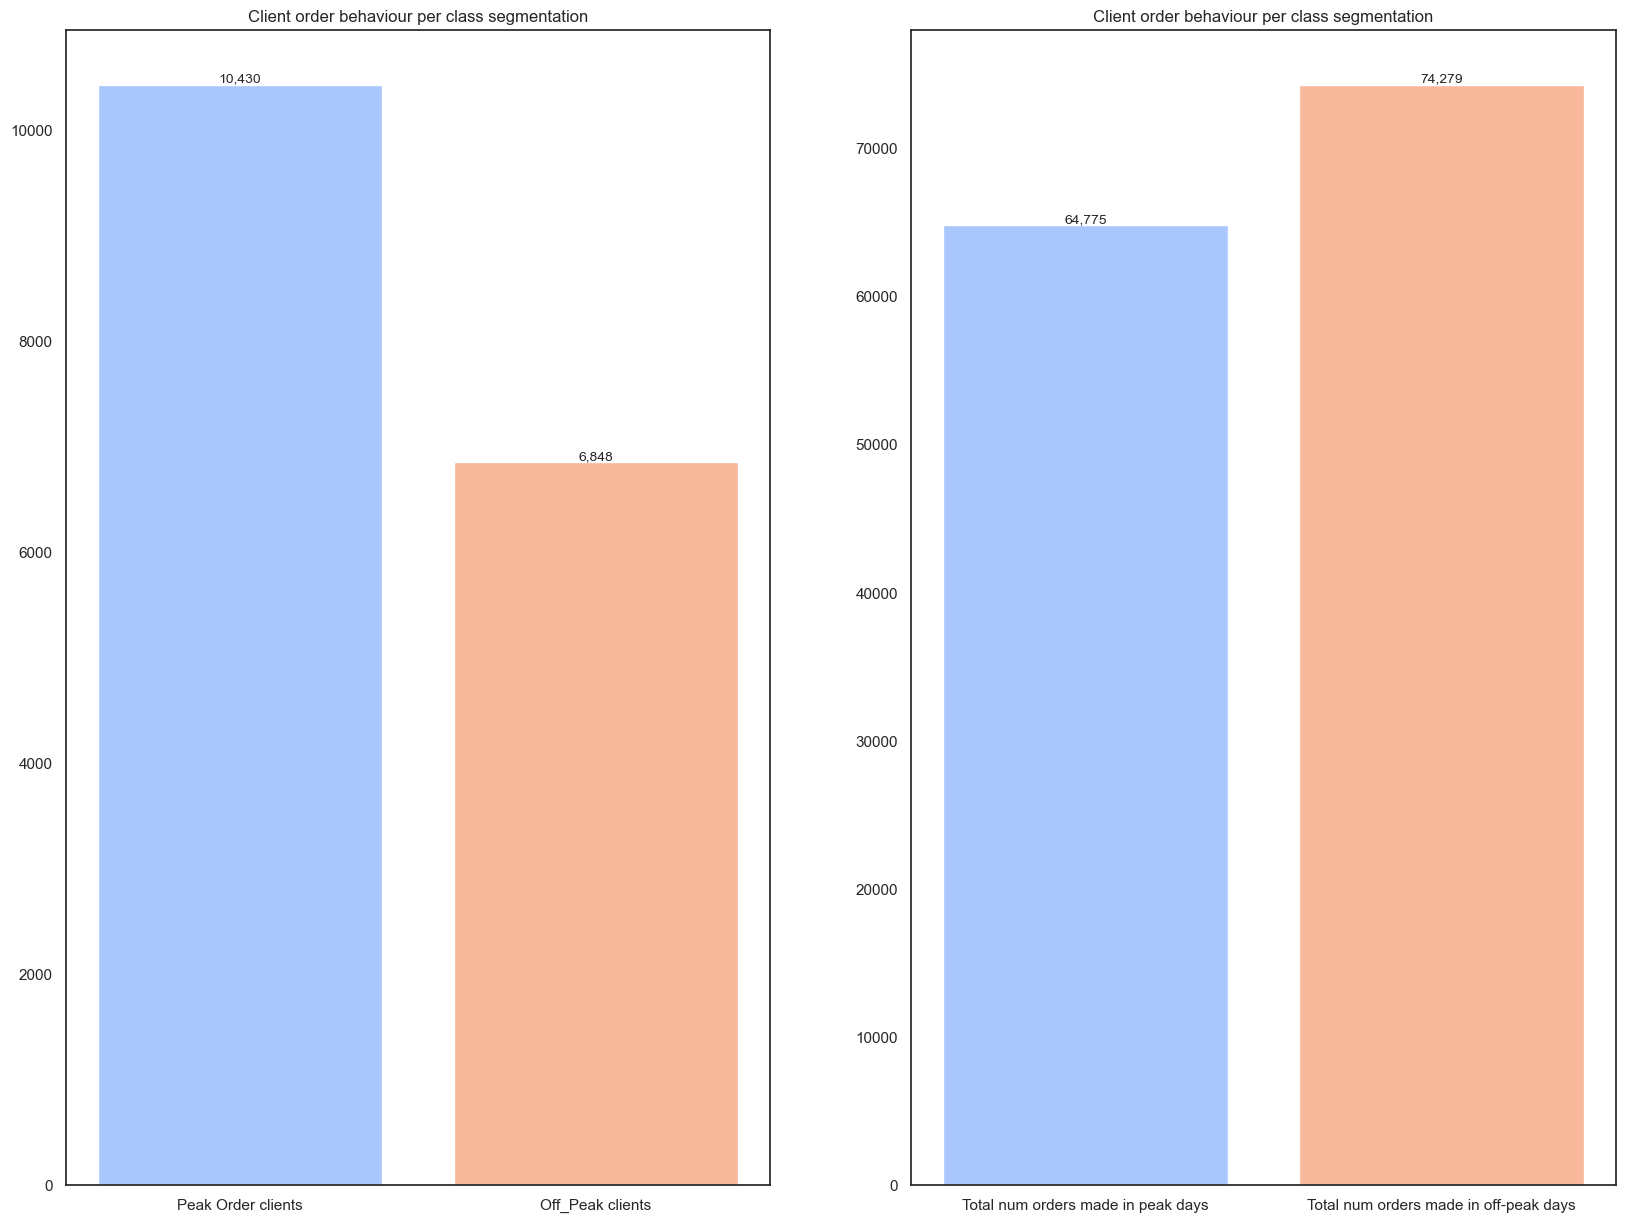

In [252]:
sns.set_style("white")
fig, ax = plt.subplots(1,2, figsize = (20,15))

# Client order behaviour per class segmentation
peak_order_num_clients = df_fe.loc[df_fe["peak_days_num_orders"] == 1].shape[0]
off_peak_order_num_clients = df_fe.loc[df_fe["peak_days_num_orders"] == 0].shape[0]

y_values = [peak_order_num_clients, off_peak_order_num_clients]
x_values = ["Peak Order clients","Off_Peak clients"]
bar_colours = sns.color_palette("coolwarm", len(x_values))

p = ax[0].bar(x_values, y_values, color=bar_colours)
ax[0].bar_label(p, labels= [f"{element:,}" for element in y_values], fontsize =10)
ax[0].set_title("Client order behaviour per class segmentation")

# Total orders made during peak and off peak days bar plots

tot_num_peak_days_orders = df_fe["peak_days_num_orders"].sum()
tot_num_off_peak_days_orders = df_fe["off_peak_days_num_orders"].sum()

y_values = [tot_num_peak_days_orders, tot_num_off_peak_days_orders  ]
x_values = ["Total num orders made in peak days","Total num orders made in off-peak days"]
bar_colours = sns.color_palette("coolwarm", len(x_values))

p = ax[1].bar(x_values, y_values, color=bar_colours)
ax[1].bar_label(p, labels= [f"{element:,}" for element in y_values], fontsize =10)
ax[1].set_title("Client order behaviour per class segmentation")

plt.show()

In [254]:
# Number of NaN values
df_fe[["off_peak_days_num_orders", "peak_days_num_orders", "client_order_behaviour"]].isnull().sum()

off_peak_days_num_orders    0
peak_days_num_orders        0
client_order_behaviour      0
dtype: int64

<div class="alert alert-block alert-info" style="font-size:16px">

### Key notes **`peak_days_num_orders`** and **`off_peak_days_num_orders`**
1. Respectively, the features represent the total number of orders made during peak days (Thursday, Saturday and Sunday) and off-peak days (remaining days) per client during the 3 months.
2. 75% of clients have made less or equal to 3 orders during peak days and off-peak days.
3. Both have outliers and non nan values


### Key notes **`client_order_behaviour`**
1. Represents a binary feature that evaluates whether the clinet has made more orders during peak or off-peak days. Value 0 means that the client has made more orders during off-peak days and 1 means that the client has made more orders during peak days
2. Important to highlight the fact that despite the total orders made during peak days (~65k) being superior to the total orders made during off-peak days (~74k), the number of peak orders clients (~10k) is superior than the number of off-peak clients (~7k). This means that despite more orders being made during the 4 off peak days, more clients prefer to make their orders during the peak days 
3. No nan values

---

### **`morning_num_orders`**, **`afternoon_num_orders`** , **`evening_num_orders`** and **`night_num_orders`**

#### How did we create the features?
1. To reduce the input space dimensionality associated with the HR features, we decided to create 4 features:
    - morning_num_orders: includes number of orders made per client from 6:00 - 11:59 (HR_6 - HR_11)
    - afternoon_num_orders: includes number of orders made per client from 12:00 - 17:59 (HR_12 - HR_17)
    - evening num_orders: includes number of orders made per client from 18:00 - 21:59 (HR_18 - HR_21)
    - night_num_orders: includes number of orders made per client from 22:00 - 5:59 (HR_22 - HR_5)


2. Opted for uneven time slots so they are meaningful and capture typical customer behavior patterns

Creating the features

In [255]:
morning_columns = [element for element in HR_columns if int(element.split("_")[1]) in range (6,12)]
afternoon_columns = [element for element in HR_columns if int(element.split("_")[1]) in range (12,18)]
evening_columns = [element for element in HR_columns if int(element.split("_")[1]) in range (18,22)]
night_columns = ['HR_22', 'HR_23', 'HR_0', 'HR_1', 'HR_2', 'HR_3', 'HR_4', 'HR_5']

df_fe["morning_num_orders"] = df_fe[morning_columns].sum(axis=1).astype(int)
df_fe["afternoon_num_orders"] = df_fe[afternoon_columns].sum(axis=1).astype(int)
df_fe["evening_num_orders"] = df_fe[evening_columns].sum(axis=1).astype(int)
df_fe["night_num_orders"] = df_fe[night_columns].sum(axis=1).astype(int)

In [258]:
print (f"morning_num_orders statistics: \n")
print (df_fe["morning_num_orders"].describe())

print (f"\nafternoon_num_orders statistics \n")
print (df_fe["afternoon_num_orders"].describe())

print (f"\nevening_num_orders statistics \n")
print (df_fe["evening_num_orders"].describe())

print (f"\n night_num_orders statistics \n")
print (df_fe["night_num_orders"].describe())

morning_num_orders statistics: 

count    31828.000000
mean         1.220592
std          2.259893
min          0.000000
25%          0.000000
50%          1.000000
75%          2.000000
max         72.000000
Name: morning_num_orders, dtype: float64

afternoon_num_orders statistics 

count    31828.000000
mean         1.790373
std          2.723316
min          0.000000
25%          0.000000
50%          1.000000
75%          2.000000
max         52.000000
Name: afternoon_num_orders, dtype: float64

evening_num_orders statistics 

count    31828.000000
mean         0.797003
std          1.793775
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max         50.000000
Name: evening_num_orders, dtype: float64

 night_num_orders statistics 

count    31828.000000
mean         0.560953
std          1.388324
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max         35.000000
Name: night_num_orders, dtype: float64

Plot histogram and boxplot for each created feature

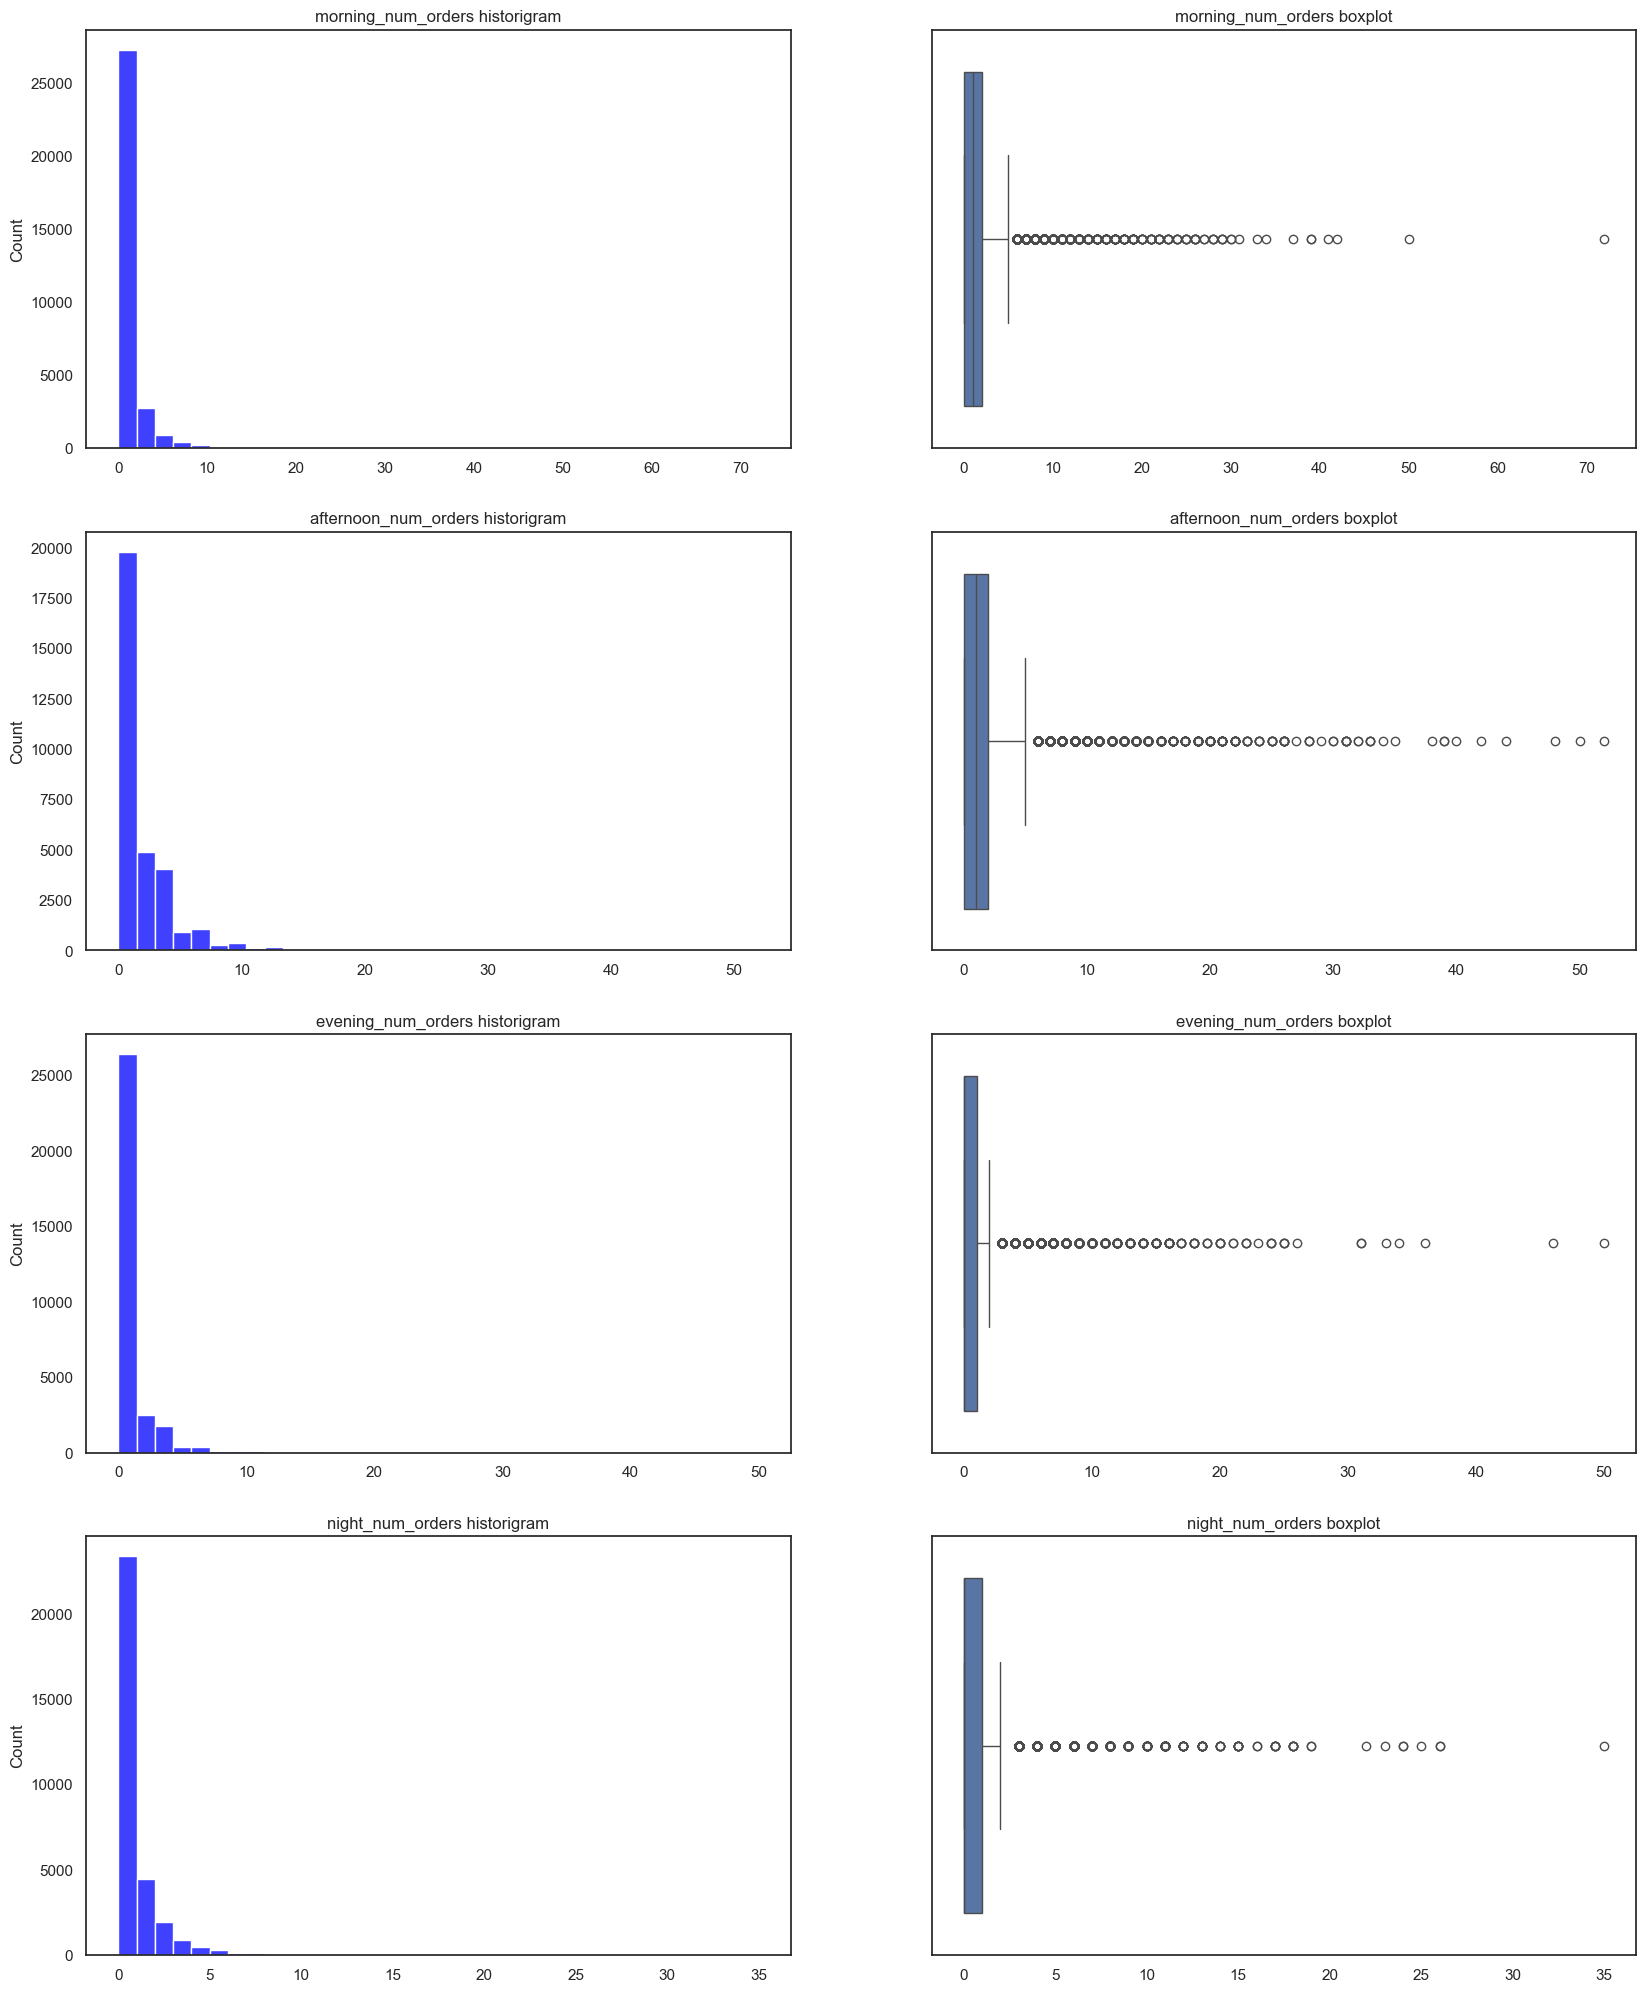

In [259]:
fig, axes = plt.subplots(4, 2, figsize = (20,25))

# Morning number of orders
sns.histplot(df_fe["morning_num_orders"], kde=False, color="blue", bins=35, ax=axes[0,0])
axes[0,0].set_title("morning_num_orders historigram")
axes[0,0].set_xlabel("")

sns.boxplot(x = df_fe["morning_num_orders"], ax=axes[0,1])
axes[0,1].set_title("morning_num_orders boxplot")
axes[0,1].set_xlabel("")

# Afternoon number of orders
sns.histplot(df_fe["afternoon_num_orders"], kde=False, color="blue", bins=35, ax=axes[1,0])
axes[1,0].set_title("afternoon_num_orders historigram")
axes[1,0].set_xlabel("")

sns.boxplot(x = df_fe["afternoon_num_orders"], ax=axes[1,1])
axes[1,1].set_title("afternoon_num_orders boxplot")
axes[1,1].set_xlabel("")

# Afternoon number of orders
sns.histplot(df_fe["evening_num_orders"], kde=False, color="blue", bins=35, ax=axes[2,0])
axes[2,0].set_title("evening_num_orders historigram")
axes[2,0].set_xlabel("")

sns.boxplot(x = df_fe["evening_num_orders"], ax=axes[2,1])
axes[2,1].set_title("evening_num_orders boxplot")
axes[2,1].set_xlabel("")

# Night number of orders
sns.histplot(df_fe["night_num_orders"], kde=False, color="blue", bins=35, ax=axes[3,0])
axes[3,0].set_title("night_num_orders historigram")
axes[3,0].set_xlabel("")

sns.boxplot(x = df_fe["night_num_orders"], ax=axes[3,1])
axes[3,1].set_title("night_num_orders boxplot")
axes[3,1].set_xlabel("")


plt.show()

In [260]:
df_fe.loc[df_fe["morning_num_orders"] == 2]
df_fe.loc[df_fe["morning_num_orders"] >= 3]

customer_region  customer_age  vendor_count  product_count  \
customer_id                                                              
1f1fe12bed             8670          26.0             5              6   
b92ab1eeec             2360          47.0             5              6   
728552f1e2             4140          26.0             1              3   
63cb294ad9             8670          16.0             5              8   
66962f296d             2360          30.0             2              3   
...                     ...           ...           ...            ...   
d93459c40c             4660           NaN             3              7   
692c2285e8             8670          22.0             3              4   
3490c50d77             2360          26.0             2              6   
0777806a99             4660          26.0             3              4   
0a786af79c             4660          20.0             2              5   

             is_chain  first_order  last_order last_promo payment_method  \
customer_id                                                                
1f1fe12bed          1            0           6   DISCOUNT           CASH   
b92ab1eeec          5            0           6    Unknown           DIGI   
728552f1e2          3            0          12   DELIVERY           CARD   
63cb294ad9          1            0          13    Unknown           CARD   
66962f296d          3            0          21    Unknown           CARD   
...               ...          ...         ...        ...            ...   
d93459c40c          2           83          85   DELIVERY           DIGI   
692c2285e8          0           85          88   DISCOUNT           CARD   
3490c50d77          3           87          90   DISCOUNT           DIGI   
0777806a99          3           88          88   DELIVERY           DIGI   
0a786af79c          1           89          89    Unknown           DIGI   

             CUI_American  ...  purchased_Street Food / Snacks  \
customer_id                ...                                   
1f1fe12bed           5.96  ...                               1   
b92ab1eeec           3.00  ...                               0   
728552f1e2           0.00  ...                               0   
63cb294ad9           0.00  ...                               1   
66962f296d           0.00  ...                               1   
...                   ...  ...                             ...   
d93459c40c           0.00  ...                               0   
692c2285e8          12.36  ...                               0   
3490c50d77           0.00  ...                               0   
0777806a99           0.00  ...                               0   
0a786af79c           0.00  ...                               0   

             purchased_Thai  num_unique_cuisines_tried  peak_days_num_orders  \
customer_id                                                                    
1f1fe12bed                0                          4                     4   
b92ab1eeec                0                          5                     3   
728552f1e2                0                          1                     3   
63cb294ad9                0                          2                     2   
66962f296d                0                          2                     3   
...                     ...                        ...                   ...   
d93459c40c                0                          2                     2   
692c2285e8                0                          3                     0   
3490c50d77                0                          1                     1   
0777806a99                0                          2                     0   
0a786af79c                0                          2                     3   

             off_peak_days_num_orders  client_order_behaviour  \
customer_id                                                     
1f1fe12bed                    

**Client Order Frequency Analysis** for Morning/Afternoon/Evening/Night Time Slots

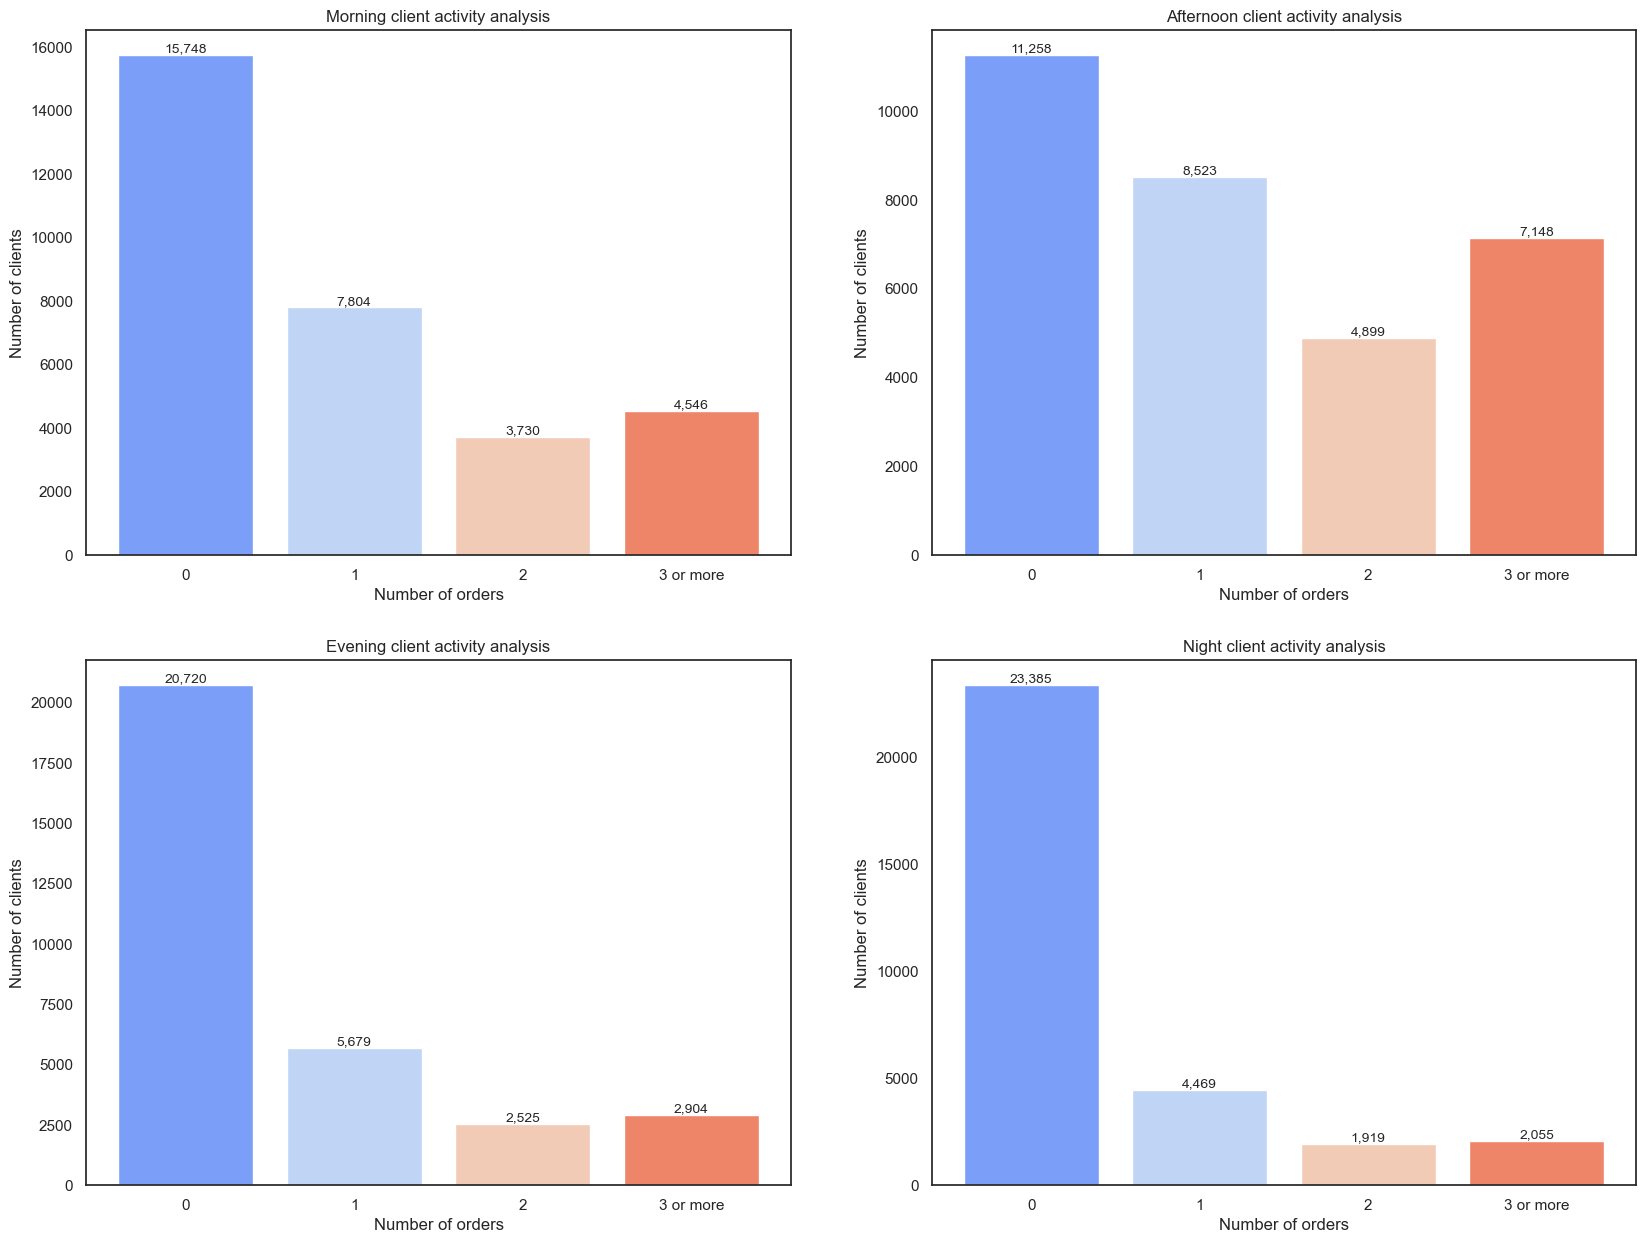

In [261]:
sns.set_style("white")
fig, ax = plt.subplots(2,2, figsize = (20,15))

# Morning
morning_orders_0 = df_fe.loc[df_fe["morning_num_orders"] == 0].shape[0]
morning_orders_1 = df_fe.loc[df_fe["morning_num_orders"] == 1].shape[0]
morning_orders_2 = df_fe.loc[df_fe["morning_num_orders"] == 2].shape[0]
morning_orders_3_more = df_fe.loc[df_fe["morning_num_orders"] >= 3].shape[0]

y_values = [morning_orders_0, morning_orders_1, morning_orders_2, morning_orders_3_more]
x_values = ["0","1", "2", "3 or more"]
bar_colours = sns.color_palette("coolwarm", len(x_values))

p = ax[0, 0].bar(x_values, y_values, color=bar_colours)
ax[0,0].bar_label(p, labels= [f"{element:,}" for element in y_values], fontsize =10)
ax[0,0].set_title("Morning client activity analysis")
ax[0,0].set_ylabel("Number of clients")
ax[0,0].set_xlabel("Number of orders")


# Afternoon
afternoon_orders_0 = df_fe.loc[df_fe["afternoon_num_orders"] == 0].shape[0]
afternoon_orders_1 = df_fe.loc[df_fe["afternoon_num_orders"] == 1].shape[0]
afternoon_orders_2 = df_fe.loc[df_fe["afternoon_num_orders"] == 2].shape[0]
afternoon_orders_3_more = df_fe.loc[df_fe["afternoon_num_orders"] >= 3].shape[0]

y_values = [afternoon_orders_0, afternoon_orders_1, afternoon_orders_2, afternoon_orders_3_more]
x_values = ["0","1", "2", "3 or more"]
bar_colours = sns.color_palette("coolwarm", len(x_values))

p = ax[0, 1].bar(x_values, y_values, color=bar_colours)
ax[0,1].bar_label(p, labels= [f"{element:,}" for element in y_values], fontsize =10)
ax[0,1].set_title("Afternoon client activity analysis")
ax[0,1].set_ylabel("Number of clients")
ax[0,1].set_xlabel("Number of orders")


# Evening
evening_orders_0 = df_fe.loc[df_fe["evening_num_orders"] == 0].shape[0]
evening_orders_1 = df_fe.loc[df_fe["evening_num_orders"] == 1].shape[0]
evening_orders_2 = df_fe.loc[df_fe["evening_num_orders"] == 2].shape[0]
evening_orders_3_more = df_fe.loc[df_fe["evening_num_orders"] >= 3].shape[0]

y_values = [evening_orders_0, evening_orders_1, evening_orders_2, evening_orders_3_more]
x_values = ["0","1", "2", "3 or more"]
bar_colours = sns.color_palette("coolwarm", len(x_values))

p = ax[1, 0].bar(x_values, y_values, color=bar_colours)
ax[1,0].bar_label(p, labels= [f"{element:,}" for element in y_values], fontsize =10)
ax[1,0].set_title("Evening client activity analysis")
ax[1,0].set_ylabel("Number of clients")
ax[1,0].set_xlabel("Number of orders")

# Night
night_orders_0 = df_fe.loc[df_fe["night_num_orders"] == 0].shape[0]
night_orders_1 = df_fe.loc[df_fe["night_num_orders"] == 1].shape[0]
night_orders_2 = df_fe.loc[df_fe["night_num_orders"] == 2].shape[0]
night_orders_3_more = df_fe.loc[df_fe["night_num_orders"] >= 3].shape[0]

y_values = [night_orders_0, night_orders_1, night_orders_2, night_orders_3_more]
x_values = ["0","1", "2", "3 or more"]
bar_colours = sns.color_palette("coolwarm", len(x_values))

p = ax[1, 1].bar(x_values, y_values, color=bar_colours)
ax[1,1].bar_label(p, labels= [f"{element:,}" for element in y_values], fontsize =10)
ax[1,1].set_title("Night client activity analysis")
ax[1,1].set_ylabel("Number of clients")
ax[1,1].set_xlabel("Number of orders")

plt.show()

**Number of orders Per Time of day**: Morning, Afternoon, Evening, and Night

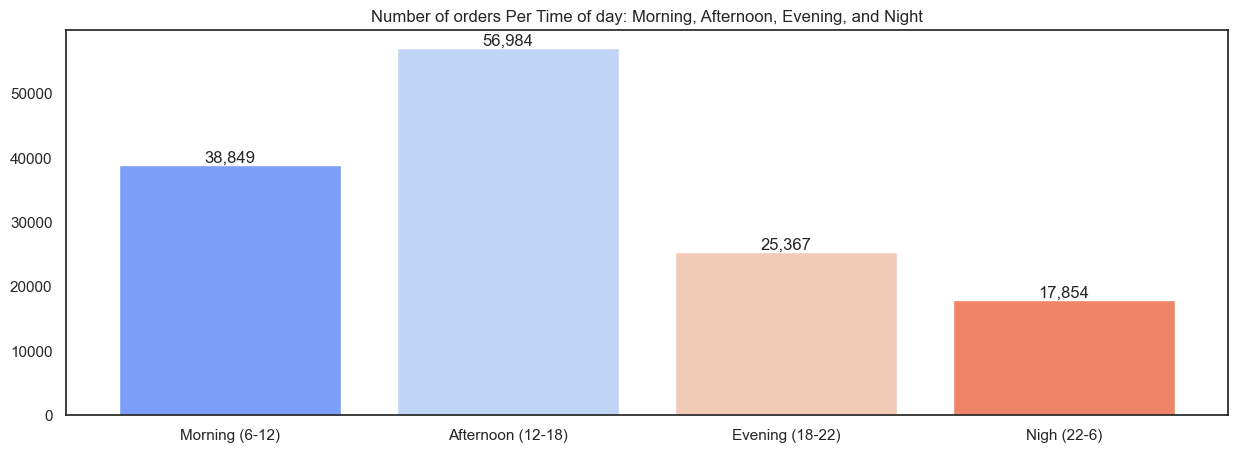

In [262]:
fig, ax = plt.subplots(1,1, figsize = (15,5))

morning_tot_orders = df_fe["morning_num_orders"].sum()
afternoon_tot_orders = df_fe["afternoon_num_orders"].sum()
evening_tot_orders = df_fe["evening_num_orders"].sum()
night_tot_orders = df_fe["night_num_orders"].sum()

y_values = [morning_tot_orders, afternoon_tot_orders, evening_tot_orders, night_tot_orders]
x_values = ["Morning (6-12)", "Afternoon (12-18)", "Evening (18-22)", "Nigh (22-6)"]
bar_colours = sns.color_palette("coolwarm", len(x_values))

p = ax.bar(x_values, y_values, color=bar_colours)
ax.bar_label(p, labels= [f"{element:,}" for element in y_values])
ax.set_title("Number of orders Per Time of day: Morning, Afternoon, Evening, and Night")
plt.show()


Analyzing NaN values

In [263]:
df_fe[["morning_num_orders", "afternoon_num_orders","evening_num_orders", "night_num_orders"]].isnull().sum()
#No nan values 


morning_num_orders      0
afternoon_num_orders    0
evening_num_orders      0
night_num_orders        0
dtype: int64

In [264]:
# Total amount of orders made
tot_num_orders = df_fe["morning_num_orders"].sum() + df_fe["afternoon_num_orders"].sum() + df_fe["evening_num_orders"].sum() + df_fe["night_num_orders"].sum()

In [265]:
tot_order_per_client_sum = df_fe["tot_orders_per_client"].sum()
tot_order_per_client_sum

139054

<div class="alert alert-block alert-info" style="font-size:16px">

### Key notes **`morning_num_orders`**, **`afternoon_num_orders`** , **`evening_num_orders`** and **`night_num_orders`**
1. The time of day with the most amount of orders made is the afternoon with close to 57k orders. It is then followed by the morning period
2.  COMPLETE it better


### **`Removing strange values`** present present across tot_orders_per_client, tot_money_spent_per_client and num_unique_cuisines_tried 

### Notes
1. Across the 3 features mentioned above we detected 138 clients that have contradicting values. Cliens that despite having one or multiple features of product_count, is_chain, first_order and last_order bigger than 0, their total_orders_per_client, tot_money_spent_per_client and num_unique_cuisines_tried was 0.


2. Noting that these values are not coherent with the dataset at hand, we decided to remove them from df_fe DataFrame 

Removing strange values identified above

In [266]:
uct_strange_clients_df = df_fe.loc[(df_fe["tot_money_spent_per_client"]==0) & (df_fe["tot_orders_per_client"] == 0) & (df_fe["num_unique_cuisines_tried"] == 0)]
indices_to_remove = uct_strange_clients_df.index
df_fe.drop(indices_to_remove, inplace = True)

In [267]:
df_fe

customer_region  customer_age  vendor_count  product_count  \
customer_id                                                              
1b8f824d5e             2360          18.0             2              5   
5d272b9dcb             8670          17.0             2              2   
f6d1b2ba63             4660          38.0             1              2   
180c632ed8             4660           NaN             2              3   
4eb37a6705             4660          20.0             2              5   
...                     ...           ...           ...            ...   
f4e366c281             8670          30.0             1              1   
f6b6709018             8670           NaN             1              1   
f74ad8ce3f             8670          24.0             1              1   
f7b19c0241             8670          34.0             1              1   
fd40d3b0e0             4660          30.0             1              1   

             is_chain  first_order  last_order last_promo payment_method  \
customer_id                                                                
1b8f824d5e          1            0           1   DELIVERY           DIGI   
5d272b9dcb          2            0           1   DISCOUNT           DIGI   
f6d1b2ba63          2            0           1   DISCOUNT           CASH   
180c632ed8          1            0           2   DELIVERY           DIGI   
4eb37a6705          0            0           2    Unknown           DIGI   
...               ...          ...         ...        ...            ...   
f4e366c281          1         <NA>           0    FREEBIE           DIGI   
f6b6709018          0         <NA>           0   DELIVERY           DIGI   
f74ad8ce3f          1         <NA>           0    Unknown           DIGI   
f7b19c0241          0         <NA>           0   DISCOUNT           DIGI   
fd40d3b0e0          0         <NA>           0    Unknown           CASH   

             CUI_American  ...  purchased_Street Food / Snacks  \
customer_id                ...                                   
1b8f824d5e           0.00  ...                               0   
5d272b9dcb          12.82  ...                               0   
f6d1b2ba63           9.20  ...                               0   
180c632ed8           0.00  ...                               0   
4eb37a6705          14.57  ...                               0   
...                   ...  ...                             ...   
f4e366c281           0.00  ...                               0   
f6b6709018          18.04  ...                               0   
f74ad8ce3f           0.00  ...                               0   
f7b19c0241           0.00  ...                               0   
fd40d3b0e0           0.00  ...                               0   

             purchased_Thai  num_unique_cuisines_tried  peak_days_num_orders  \
customer_id                                                                    
1b8f824d5e                0                          1                     1   
5d272b9dcb                0                          2                     1   
f6d1b2ba63                0                          1                     1   
180c632ed8                0                          2                     1   
4eb37a6705                0                          2                     1   
...                     ...                        ...                   ...   
f4e366c281                0                          1                     1   
f6b6709018                0                          1                     1   
f74ad8ce3f                0                          1                     1   
f7b19c0241                0                          1                     1   
fd40d3b0e0                0                          1                     1   

             off_peak_days_num_orders  client_order_behaviour  \
customer_id                                                     
1b8f824d5e                    

---

### **`Overview of all new features`**


<div class="alert alert-block alert-info" style="font-size:16px">

### Key notes **`payment_method_combined`**
- Data type is object
- Duplicate values are expected
- No missing values
- 2/3 of customers pay with card
- If we consider "card" and "cash" to indicate in-person payment, and "digi" to indicate digital/online payment, then 31828 80.87% of customers are paying in-person. This presents a potential loss for the company - customers paying upon pickup may not show up, delivery drives may have to wait longer to move on to the next order, etc. It would be in the company's best interest to move more payments to online.

### Key notes **`city`**  
- If we assume the first digit of the region indicates city, customers are split appproximately evenly throughout the three cities
    - 10,757 customers in City 2 (cities beginning with 2)
    - 10,407 customers in City 4 (cities beginning with 4)
    - 10,282 customers in City 8 (cities beginning with 8)
- 442 "unknown region" values are kept as unknown when assigned to a city
- We don't know specifically what these region codes represent, not much benefit is gained by analying the regions individually. When we combine the regions into cities, this feature gains meaning and interpretability.

### Key notes **`tot_orders_per_client`**
1. Represents a numerical feature with total orders made per clietn
2. To build the feature, we had 2 initial options: sum all the DOW variables or all the HR variables. Since only DOW variables don't have any NaN values, we opted to use it. 
3. Strange values detected. 
    - 138 clients had 0 total orders made despite one or many of the following features being bigger than 0: "product_count", "is_chain", "first_order" and "last_order"
    - Tried to understand if the issue was related to the DOW variables (features used to determine tot_orders_per_client feature). To do so, decided to determine the total number of orders per client using the HR variables despite the existence of NaN values. The results didn't change, meaning that all strange clients stayed strange clients.
    - How to deal with these values? In my opinion, they should be removed.
4. From 31,828 clients, almost 20k have made a total number of orders between 1 and 3
5. From boxplot and histogram
    - A lot of outliers present (both extreme and moderate)
    - heavily left skewed distribution
6. No NaN values




### Key notes **`tot_money_spent_per_client`**
1. Represents a numerical feature with total money spent made per client
2. To build the feature, we did the sum of All CUI variables
3. Strange values detected. 
    - 138 clients had 0 total money spent
    - These clients correspond to the clients who also had 0 total orders made during the 3 months
    - How to deal with these values? In my opinion, they should be removed.
4. From 31,828 clients, almost 20k spent between $0-$20
5. From boxplot and histogram
    - A lot of outliers present (both extreme and moderate)
    - heavily left skewed distribution meaning that most clients didn't spend a lot of money during the 3 months
6. No NaN values




### Key notes **`CUI binary variables`**
1. Represents a binary feature that evaluates whether the client spent any money or not for each type of cousine. The value 0 means that the client didn't spent any money on that cousine and 1 that the client spent money
2. Important to highlight "American" and "Asian" cuisines with the highest numbers of spending clients. From the total ~32k clients in the dataset, ~11k and ~12k spent money on American and Asian cuisines respectively 
3. Important to note cafe as the CUI with the least number of spending clients 
cafe as the cui with the least amount of spending clients (~1.4k)
4. No nan values



### Key notes **`num_unique_cuisines_tried`**
1. Represents a numerical feature with total number of unique cuisines tried per client.
2. To build the feature, we did the row wise sum of all binary CUI variables
3. Strange values detected. 
    - The same 138 clients who haven't made any orders or spent any money during the 3 months, as expected, haven't tried a single cuisine 
    - The recommendation to remove them keeps unchanged

4. From 31,828 clients, ~11.5k tried a single cuisine. This suggests that a significant portion of the customer base may have narrow or specific tastes, preferring familiar options. 
5. No NaN values


### Key notes **`peak_days_num_orders`** and **`off_peak_days_num_orders`**
1. Respectively, the features represent the total number of orders made during peak days (Thursday, Saturday and Sunday) and off-peak days (remaining days) per client during the 3 months.
2. 75% of clients have made less or equal to 3 orders during peak days and off-peak days.
3. Both have outliers and non nan values


### Key notes **`client_order_behaviour`**
1. Represents a binary feature that evaluates whether the clinet has made more orders during peak or off-peak days. Value 0 means that the client has made more orders during off-peak days and 1 means that the client has made more orders during peak days
2. Important to highlight the fact that despite the total orders made during peak days (~65k) being superior to the total orders made during off-peak days (~74k), the number of peak orders clients (~10k) is superior than the number of off-peak clients (~7k). This means that despite more orders being made during the 4 off peak days, more clients prefer to make their orders during the peak days 
3. No nan values



### Key notes **`morning_num_orders`**, **`afternoon_num_orders`** , **`evening_num_orders`** and **`night_num_orders`**
1. The time of day with the most amount of orders made is the afternoon with close to 57k orders. It is then followed by the morning period
2.  COMPLETE it better



---

<div class="alert alert-block alert-info" style="font-size:16px" id = "multivariate_analyzis">

## 6. Multivariate analyzis
### 6.1 Analyzing original df columns